#### Notebook with exclusive KLVI and inclusive KLVI- using Markovian score climbing ...

In [1]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
import autograd
import pickle
import pystan

In [2]:
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       perturbed_black_box_vi,
                       make_stan_log_density,
                       make_stan_log_density_grad,
                       adagrad_optimize, 
                     
                      )

from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         plot_dist_to_opt_param,
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

In [3]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat, adagrad_optimize, markov_score_climbing_cis

In [4]:
from viabel.vb_overdispersed import black_box_gapis,  adagrad_optimize_IS

In [5]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  matrix[N, 2] x;   // predictor matrix
  vector[N] y;      // outcome vector
  real<lower=1> df; // degrees of freedom
}
parameters {
  vector[2] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(df, x * beta, 1);  // likelihood
}"""

In [6]:
try:
    sm = pickle.load(open('robust_reg_model_inc.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_inc.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [7]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.75],[.75, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

In [8]:
data = dict(N=N, x=x, y=y, df=40)
fit = sm.sampling(data=data, iter=50000, thin=50, chains=10)

In [9]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
print('true mean =', true_mean)
print('true cov =', true_cov)

true mean = [-2.50279046  1.50059883]
true cov = [[ 0.43165775 -0.42671214]
 [-0.42671214  0.44303536]]


In [10]:
fit

Inference for Stan model: regression_model_da1de6f365ef6d14558a2a755c2fe849.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   -2.5  9.4e-3   0.66  -3.78  -2.94   -2.5  -2.07  -1.17   4900    1.0
beta[2]    1.5  9.5e-3   0.67   0.16   1.06   1.51   1.96   2.76   4914    1.0
lp__    -20.29    0.01   1.01 -23.13  -20.7 -19.98 -19.57 -19.31   5054    1.0

Samples were drawn using NUTS at Thu Aug 27 19:43:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

#### True posterior marginals

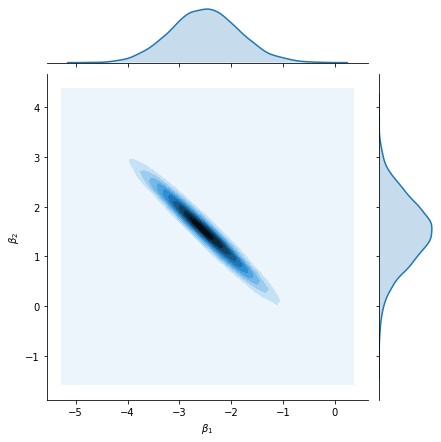

In [11]:

jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
#plt.show()

In [12]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-4,-1], ylim=[-.5,3.5])
mc_samples = 1000000  # number of Monte Carlo samples for estimating bounds and for PSIS

In [13]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(2, 40)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

klvi_var_param, klvi_param_history, _, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 24.216: 100%|██████████| 5000/5000 [00:19<00:00, 252.32it/s]
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:192: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


### Plot with exclusive KLVI optimised params
#### Black shows true posterior, red shows approximation

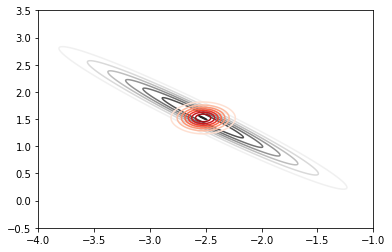

In [14]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi1.pdf')

In [18]:
#### Optimisation trace for the variational parameters- distance from optimal.

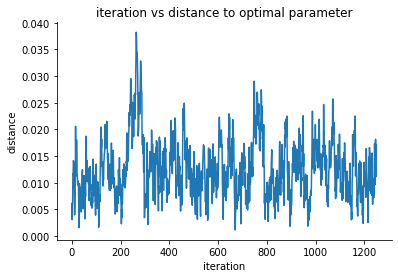

In [19]:
plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

In [20]:
check_approx_accuracy(mf_t_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.52404451  1.52136443]
stdevs = [0.14346427 0.14578815]

mean error             = 0.0297
stdev error            = 0.731
||cov error||_2^{1/2}  = 0.918
||true cov||_2^{1/2}   = 0.93


In [21]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [22]:
print(true_mean)
print(true_std)
print(klvi_var_param[:2])
print(np.exp(klvi_var_param[2:]))

[-2.50279046  1.50059883]
[0.65700666 0.66560901]
[-2.52404451  1.52136443]
[0.13983168 0.14209671]


In [23]:
k=2
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
stan_log_density_grad= make_stan_log_density_grad(fit)

chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 10000)
incl_klvi_mf_objective_and_grad = markov_score_climbing_cis(mf_g_var_family, stan_log_density, 2000,2)



In [25]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)*0.5
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 3000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
inc_klvi_var_param, inc_klvi_param_history, _,  inc_klvi_history, op_log_inklvi = \
    adagrad_optimize(n_iters, incl_klvi_mf_objective_and_grad, init_var_param, learning_rate=.005, has_log_norm=3,k=2)

Average Loss = -3.8898e-08:   0%|          | 10/3000 [00:00<01:07, 44.51it/s]

[[0. 0.]]
(1,)
4.879676027814649e-06
[2.01861725e-19 2.44485705e-74 6.32651645e-06 ... 1.80711342e-48
 3.91304206e-07 4.57425880e-15]
[[-2.60439903  1.93133303]]
(1,)
4.734533056088091e-06
[5.30179790e-39 3.58032305e-32 1.48508304e-19 ... 3.76532295e-23
 1.16957365e-04 7.73657139e-03]
[[-2.50037942  1.31239699]]
(1,)
5.465814232858305e-06
[2.48073301e-005 2.71893977e-002 6.09232379e-154 ... 4.21848809e-101
 1.17526441e-015 2.47651466e-002]
[[-2.82707912  1.8698948 ]]
(1,)
4.92061936441814e-06
[4.58487073e-159 7.49924852e-101 7.18481912e-004 ... 1.91415180e-146
 3.11175375e-031 9.87652118e-002]
[[-1.14925222 -0.05627085]]
(1,)
4.291481907805476e-06
[7.76354550e-15 3.55415371e-17 3.54096784e-65 ... 9.07206863e-09
 6.36420378e-41 8.19596244e-04]
[[-1.77440633  0.59835643]]
(1,)
4.450488447610681e-06
[2.10646496e-48 6.14274511e-91 3.73451453e-02 ... 6.64619233e-50
 2.73061145e-10 7.35309041e-03]
[[-2.07382739  0.99924447]]
(1,)
5.21938813950077e-06
[7.79977779e-09 4.06842448e-87 9.36500839

Average Loss = -3.8558e-08:   1%|          | 20/3000 [00:00<01:05, 45.70it/s]

(1,)
4.778840579606409e-06
[5.55976526e-004 4.68017862e-046 2.26006858e-100 ... 7.75161438e-003
 2.49835048e-017 1.48953789e-003]
[[-2.07804027  0.8592097 ]]
(1,)
5.800324999394861e-06
[3.47153433e-70 6.03571493e-49 8.50303938e-29 ... 2.13920097e-21
 2.72447508e-45 7.68908616e-03]
[[-1.52998344  0.33512789]]
(1,)
4.700967320373498e-06
[4.54095099e-26 1.30724919e-16 1.61656302e-56 ... 5.95809511e-14
 2.15135652e-06 2.90274946e-03]
[[-2.5032948   1.41999308]]
(1,)
4.369435257915569e-06
[2.13904000e-011 7.50926058e-125 1.31161911e-136 ... 5.50315308e-025
 7.86415149e-090 6.09169791e-002]
[[-1.54805679  0.41857222]]
(1,)
5.710824803989907e-06
[9.79789410e-012 5.26019148e-008 5.68128499e-162 ... 1.50495743e-011
 1.25307951e-046 4.21063813e-003]
[[-2.13978791  1.19063268]]
(1,)
5.404626257893822e-06
[1.85111710e-19 4.00032580e-05 2.54805160e-13 ... 1.10186354e-99
 1.83027644e-74 3.01118712e-02]
[[-1.70361375  0.69144195]]
(1,)
5.757323691421627e-06
[1.32521992e-057 6.42354745e-053 2.84573557

Average Loss = -3.9783e-08:   1%|          | 30/3000 [00:00<01:04, 46.22it/s]

(1,)
4.131784407753167e-06
[3.70818041e-103 2.64742628e-119 5.61031854e-023 ... 6.02918412e-011
 1.86305795e-048 1.02787393e-001]
[[-1.858913    0.59455475]]
(1,)
5.505705952802105e-06
[1.90719444e-037 4.87744733e-011 2.03368069e-012 ... 5.17770051e-258
 2.01985943e-006 2.80184952e-003]
[[-2.24259974  1.2472065 ]]
(1,)
5.532003726064015e-06
[3.86797700e-53 1.22254350e-14 9.79121750e-10 ... 2.82265617e-57
 4.16635848e-03 3.67122062e-02]
[[-1.37856508  0.4280275 ]]
(1,)
5.008585180057014e-06
[2.80812485e-033 4.59842553e-195 7.45762425e-026 ... 8.73155250e-018
 2.56686533e-083 4.15424007e-003]
[[-2.0979806   1.12008388]]
(1,)
4.697276583815201e-06
[4.29914826e-128 6.92594998e-007 2.12281606e-067 ... 4.53710512e-070
 7.01156680e-006 3.20516080e-002]
[[-2.81887002  1.7101726 ]]
(1,)
4.332787225434868e-06
[2.46949699e-80 2.84376352e-10 1.73337969e-26 ... 3.41778822e-87
 1.65496360e-89 7.62207582e-02]
[[-2.41923461  1.66109115]]
(1,)
4.0997579144894e-06
[3.73985346e-074 3.35467480e-008 4.9896

Average Loss = -3.9234e-08:   1%|▏         | 40/3000 [00:00<01:02, 47.04it/s]

(1,)
4.224182629684088e-06
[1.60280992e-50 9.50932800e-87 2.33310008e-06 ... 4.34341596e-68
 1.02223167e-07 1.66839722e-02]
[[-2.86988662  1.72112401]]
(1,)
4.100647512105349e-06
[1.87405678e-005 1.35094562e-028 1.23202478e-174 ... 4.93457261e-109
 1.21712940e-082 6.26047812e-002]
[[-2.80693895  1.72915717]]
(1,)
5.219871134458264e-06
[1.76911942e-35 6.97199639e-13 1.66168865e-46 ... 4.74946994e-43
 8.81767376e-74 6.95358023e-02]
[[-1.76144869  0.66206213]]
(1,)
5.8088584366509185e-06
[8.55306455e-116 1.14790033e-006 2.90718780e-183 ... 6.73557780e-137
 1.27739858e-037 8.69410372e-003]
[[-1.66810081  0.6643693 ]]
(1,)
5.545321778994012e-06
[2.10622331e-019 5.50235558e-117 5.08932379e-023 ... 2.04321225e-042
 1.16898667e-011 9.23106717e-003]
[[-3.76592648  2.86900782]]
(1,)
5.234294574778237e-06
[1.42432350e-146 9.60494979e-073 1.45144834e-065 ... 1.49196422e-008
 1.72573928e-129 7.62651578e-002]
[[-0.84427136  0.01591077]]
(1,)
3.839653667200873e-06
[5.97424949e-091 4.92133700e-067 1.0

Average Loss = -3.8893e-08:   2%|▏         | 50/3000 [00:01<01:03, 46.75it/s]

(1,)
4.7103188252223695e-06
[1.25404559e-022 8.69822197e-119 3.13913190e-010 ... 2.84041247e-016
 8.30129359e-028 2.90275992e-002]
[[-3.04794054  2.15946515]]
(1,)
6.309631356921089e-06
[1.43545678e-067 6.30005310e-023 1.07386828e-143 ... 1.15850303e-003
 5.51070593e-012 6.22224436e-002]
[[-4.06141694  2.69244607]]
(1,)
3.4608249668759855e-06
[8.50076632e-11 1.13260932e-13 4.09020772e-08 ... 3.17128202e-44
 2.60031774e-89 3.91177768e-03]
[[-2.75836062  1.99321927]]
(1,)
6.558395979276982e-06
[2.70776933e-06 1.34377217e-38 3.81944256e-04 ... 1.60953286e-79
 5.16346017e-30 1.82354993e-02]
[[-2.34982201  1.15849168]]
(1,)
4.243771628309883e-06
[6.42780886e-11 7.02955553e-05 4.61185000e-24 ... 3.25999413e-06
 2.54831032e-12 2.12136805e-02]
[[-2.38096403  1.40488277]]
(1,)
6.396156969225925e-06
[8.49482117e-145 2.82744789e-030 1.00956636e-002 ... 5.40107962e-143
 5.28720798e-076 3.76576579e-002]
[[-2.99844122  2.03576689]]
(1,)
4.645882638901514e-06
[3.97786837e-34 1.76204417e-10 1.99368224

Average Loss = -3.9121e-08:   2%|▏         | 55/3000 [00:01<01:04, 45.98it/s]

(1,)
5.994296052475646e-06
[9.96077783e-024 2.58250735e-082 2.63105204e-021 ... 7.54475865e-216
 4.06244770e-016 7.82880986e-002]
[[-1.85358128  0.55504369]]
(1,)
4.940406804947907e-06
[2.30245218e-76 6.05839409e-18 1.68066829e-08 ... 7.76740303e-16
 1.02947672e-09 1.85918741e-03]
[[-3.3384155   2.45791923]]
(1,)
5.735045223105401e-06
[1.54636199e-81 1.02394123e-71 7.45849408e-97 ... 8.59402784e-68
 4.21560750e-06 6.75350939e-02]
[[-1.26065249  0.03440409]]
(1,)
5.294923135566529e-06
[1.03290442e-003 2.14764921e-123 1.24188336e-015 ... 7.72348621e-042
 1.26248509e-099 7.69933343e-004]
[[-3.02471527  2.31039723]]
(1,)
6.161627093048927e-06
[1.51031363e-092 9.14459984e-159 1.68182270e-094 ... 2.61097054e-004
 6.66238839e-057 1.25671672e-002]
[[-1.8480119   0.78714965]]
(1,)
4.128578953746039e-06
[7.36852386e-004 7.50435287e-006 1.08561644e-004 ... 4.58987045e-206
 4.56835345e-010 1.73631361e-002]
[[-1.79029332  0.90617558]]
(1,)
4.86282656585992e-06
[2.57290492e-007 1.84365821e-120 3.842

Average Loss = -3.9672e-08:   2%|▏         | 65/3000 [00:01<01:07, 43.27it/s]

5.4006389168916035e-06
[1.11309722e-17 2.86452029e-02 1.12094839e-03 ... 9.98926179e-21
 1.42121310e-48 7.20836585e-02]
[[-1.85425443  0.61496174]]
(1,)
5.309372507010538e-06
[4.08423360e-080 2.23148317e-019 3.68572292e-109 ... 7.66502856e-016
 3.52794598e-196 3.64932437e-003]
[[-3.884469    2.95490901]]
(1,)
6.220734376667079e-06
[6.15246959e-008 1.34291461e-154 1.42165340e-258 ... 2.99244420e-066
 1.21356066e-004 5.72133482e-002]
[[-2.5696      1.41824514]]
(1,)
5.254622113251498e-06
[5.03881364e-004 4.08430861e-074 1.27148523e-007 ... 5.90146123e-189
 1.49644520e-056 3.16007771e-002]
[[-3.13636866  2.13238327]]
(1,)
5.375894291683592e-06
[5.91905321e-035 1.47218692e-007 1.40797022e-030 ... 1.99482267e-039
 3.26404628e-296 8.79587136e-002]
[[-1.83339676  0.68977257]]
(1,)
5.140682119636187e-06
[1.59693174e-34 1.57349526e-56 2.08977693e-30 ... 1.98165382e-30
 5.07376422e-30 8.66791874e-03]
[[-1.35208789  0.29713429]]
(1,)
5.109322404669796e-06
[3.69179872e-056 1.24028048e-106 1.288657

Average Loss = -3.9807e-08:   2%|▎         | 75/3000 [00:01<01:05, 44.96it/s]

(1,)
4.284176194199447e-06
[2.73098275e-16 1.72636560e-07 2.48373461e-03 ... 7.40159708e-34
 1.51816117e-30 1.61663910e-03]
[[-2.51939615  1.61557509]]
(1,)
4.595437910150219e-06
[2.66850075e-46 4.71446192e-15 6.22554201e-16 ... 2.93352844e-11
 3.22901153e-04 5.10847095e-02]
[[-3.185804    1.99481096]]
(1,)
5.866870587297844e-06
[2.03579110e-22 1.08154505e-05 4.08385214e-06 ... 4.64852939e-46
 5.17180922e-08 3.16132073e-02]
[[-3.38364972  2.19599672]]
(1,)
3.879386146250389e-06
[2.51900983e-220 3.05842548e-093 1.83022055e-070 ... 9.72971221e-022
 1.21536987e-025 4.96736910e-002]
[[-3.21407295  2.40312734]]
(1,)
5.696091721963597e-06
[1.15653136e-163 1.02423998e-016 5.23966534e-123 ... 3.18949502e-038
 2.38438999e-044 3.78888278e-002]
[[-2.87551734  1.90726035]]
(1,)
5.641202762748384e-06
[8.65995610e-037 4.20145128e-080 5.01726332e-055 ... 3.74150450e-066
 5.75630958e-140 6.96183145e-002]
[[-1.86226776  0.85185488]]
(1,)
5.79338480537919e-06
[5.67884437e-006 1.32073657e-158 1.46257803e

Average Loss = -4.0176e-08:   3%|▎         | 85/3000 [00:01<01:04, 45.46it/s]

(1,)
4.384129003645196e-06
[2.26772939e-32 8.12784143e-20 1.57405285e-56 ... 4.77286504e-14
 5.24103218e-53 1.01958469e-01]
[[-2.77708222  1.64856855]]
(1,)
4.6542283111934455e-06
[6.74274180e-15 6.12148976e-35 1.98683474e-07 ... 3.03125219e-37
 2.40590979e-10 4.96404044e-02]
[[-2.15998119  1.30809915]]
(1,)
3.5132736487427886e-06
[4.23827865e-24 1.82407648e-70 6.76411694e-09 ... 1.42893721e-62
 1.48219884e-19 2.75601906e-02]
[[-1.60801107  0.47249975]]
(1,)
6.6743332870807815e-06
[1.35463879e-18 2.87054311e-51 4.68720228e-17 ... 2.83888899e-28
 1.14056446e-18 3.85229707e-03]
[[-1.45618334  0.38423078]]
(1,)
4.872142299139555e-06
[7.92713370e-43 8.30977977e-37 2.31687513e-17 ... 5.66126690e-13
 6.93925413e-26 4.70448383e-03]
[[-2.38964271  1.60077791]]
(1,)
5.236578969903152e-06
[1.27970853e-14 6.39494063e-92 1.41317291e-04 ... 1.10990550e-85
 2.61004779e-16 1.64329637e-02]
[[-2.25671104  1.17321066]]
(1,)
5.7044934970015626e-06
[1.43462933e-059 5.97631991e-054 2.15684298e-011 ... 3.02

Average Loss = -4.052e-08:   3%|▎         | 95/3000 [00:02<01:03, 45.62it/s] 

5.9228902805051035e-06
[3.20260960e-010 3.71039164e-036 7.31664285e-140 ... 2.36272460e-159
 1.14472282e-064 4.25194439e-002]
[[-3.50429657  2.50022273]]
(1,)
4.904233602134788e-06
[3.21035917e-16 2.36779305e-06 3.03929405e-05 ... 8.21287979e-03
 1.17380841e-50 8.55415725e-02]
[[-1.42533566  0.31361001]]
(1,)
4.327570137436597e-06
[9.93067143e-08 1.41705127e-29 5.56057860e-21 ... 1.56846379e-04
 4.80487608e-26 4.01077697e-03]
[[-1.97513542  0.9663536 ]]
(1,)
5.5770943497902005e-06
[2.45316196e-06 5.24416415e-03 4.35013333e-86 ... 4.71487187e-07
 7.66618089e-08 1.82692398e-02]
[[-2.92877264  1.88396094]]
(1,)
7.0347563175342015e-06
[4.32416994e-015 6.71067017e-215 3.44680148e-033 ... 8.71704271e-003
 7.86903281e-049 5.15640103e-002]
[[-3.07090696  1.90412122]]
(1,)
3.743805723779124e-06
[3.89113896e-025 3.07642038e-136 2.21282535e-048 ... 1.80933316e-003
 3.83334396e-079 5.35915714e-002]
[[-4.41403194  3.38718762]]
(1,)
5.440128365605694e-06
[1.19065902e-51 5.89368509e-53 1.20757775e-35

Average Loss = -4.0616e-08:   4%|▎         | 105/3000 [00:02<01:04, 44.95it/s]

(1,)
5.28340163656628e-06
[2.47188846e-71 6.68650772e-80 4.64630986e-04 ... 4.25455443e-64
 1.13378946e-11 4.21645733e-02]
[[-2.34178976  1.53485905]]
(1,)
4.075889972798788e-06
[7.60024043e-006 2.42886314e-021 3.37711382e-072 ... 4.32703171e-145
 7.90437745e-088 2.22161457e-002]
[[-1.88067555  0.6017309 ]]
(1,)
4.175356465404002e-06
[5.18703787e-029 2.27902813e-007 3.02741498e-156 ... 1.56864693e-032
 8.80543536e-007 2.92307794e-003]
[[-1.89929153  0.66330046]]
(1,)
3.627905429383498e-06
[2.89051955e-018 6.05402047e-016 1.61144069e-014 ... 9.69790031e-007
 1.39040477e-113 5.92984431e-003]
[[-3.05532064  1.95757904]]
(1,)
5.595358983167841e-06
[4.60723605e-154 3.72091780e-083 1.69225583e-034 ... 1.80250005e-041
 6.94365742e-185 5.40767222e-002]
[[-3.5625805   2.76768031]]
(1,)
4.814698338369074e-06
[1.57006277e-010 7.21630700e-041 3.51653141e-109 ... 4.20248764e-067
 1.21949638e-023 3.10315835e-002]
[[-2.95457151  2.17853094]]
(1,)
4.396747386016503e-06
[7.70923989e-066 4.28028861e-068

Average Loss = -4.044e-08:   4%|▍         | 115/3000 [00:02<01:03, 45.28it/s] 

5.531451665137398e-06
[5.50363171e-05 1.57290997e-35 3.40612875e-28 ... 4.16819632e-58
 3.46483273e-05 1.61315771e-02]
[[-3.04611676  1.84857499]]
(1,)
6.596259558775409e-06
[9.01712894e-165 4.26878458e-085 2.61412883e-090 ... 2.48037414e-008
 6.58895948e-010 2.15183696e-002]
[[-3.17395047  1.96135186]]
(1,)
3.2906857027988496e-06
[1.29707282e-021 1.19179238e-180 2.12724328e-139 ... 2.71657552e-047
 2.87601803e-062 3.80904981e-002]
[[-2.40555588  1.20369556]]
(1,)
3.5789725749758283e-06
[3.11669656e-89 5.15356543e-60 3.64063953e-13 ... 4.00202228e-81
 1.00583440e-15 2.14660660e-02]
[[-2.3512437   1.29486816]]
(1,)
4.778903311053122e-06
[1.22431421e-081 2.21615496e-118 1.89084104e-084 ... 6.50971734e-032
 7.75040079e-009 3.78163981e-002]
[[-1.78090967  0.88016522]]
(1,)
4.424407087102717e-06
[1.12624027e-105 7.96015411e-105 4.88328219e-091 ... 4.75996941e-045
 1.62238337e-026 1.19872701e-002]
[[-2.19353248  1.39538667]]
(1,)
4.983890113452881e-06
[1.36729242e-03 9.72251442e-41 4.8283580

Average Loss = -4.0282e-08:   4%|▍         | 125/3000 [00:02<01:03, 45.40it/s]

[[-2.69564579  1.58685789]]
(1,)
4.522497183128458e-06
[5.67699181e-071 1.48822110e-003 1.12581246e-120 ... 2.14789015e-030
 1.01884989e-006 4.80019176e-002]
[[-2.79965876  1.75695392]]
(1,)
4.780525362848462e-06
[6.18601386e-11 1.55018609e-32 1.19990381e-22 ... 8.14671999e-58
 3.02306741e-41 6.41659904e-02]
[[-2.59041131  1.73248913]]
(1,)
4.6110928897805905e-06
[5.16978674e-022 1.49747931e-128 1.33060549e-057 ... 5.32318716e-014
 8.24251276e-038 3.81717744e-002]
[[-2.27589368  1.33394564]]
(1,)
5.312429136387405e-06
[3.31957702e-027 6.39824287e-157 2.12852001e-004 ... 3.53728477e-012
 2.37429475e-004 3.09205578e-002]
[[-3.2735022   2.10453993]]
(1,)
5.106482102948095e-06
[3.71767289e-074 1.67729415e-118 1.11542723e-032 ... 3.05029403e-041
 3.67334448e-014 3.55986107e-002]
[[-2.2006616   1.24888311]]
(1,)
5.769007976917116e-06
[4.83404493e-06 1.12292629e-89 6.43236658e-12 ... 1.48955986e-07
 5.81368924e-18 2.54921338e-02]
[[-3.35453275  2.27672193]]
(1,)
4.627180847119272e-06
[4.84022

Average Loss = -4.065e-08:   4%|▍         | 130/3000 [00:02<01:03, 45.30it/s] 

(1,)
7.470873493043663e-06
[7.19126355e-011 2.51261827e-005 4.53625848e-044 ... 7.24801644e-071
 2.18828830e-105 2.00127209e-002]
[[-2.82888138  1.88052868]]
(1,)
5.291264886742884e-06
[1.23682295e-025 1.55236209e-111 6.26632408e-142 ... 6.77328264e-077
 1.82668446e-060 5.83526213e-002]
[[-4.75753507  3.73504862]]
(1,)
5.801664743216599e-06
[5.65479134e-37 1.33334600e-02 4.20060367e-42 ... 5.74474250e-81
 2.07196315e-32 8.89148028e-03]
[[-2.15511368  1.01767296]]
(1,)
6.868773529183912e-06
[9.53859893e-015 3.47374685e-183 2.13921348e-101 ... 4.47488222e-135
 4.60614850e-002 1.23405664e-002]
[[-2.81948194  1.81451536]]
(1,)
5.0794144422215115e-06
[8.42335284e-059 4.40027567e-012 1.00505961e-144 ... 6.90515901e-079
 1.41034423e-021 6.21238571e-002]
[[-1.31011491  0.4613757 ]]
(1,)
5.185875619412121e-06
[1.45488438e-050 4.93327075e-037 4.27257734e-105 ... 4.26728086e-011
 1.74989634e-110 2.01571738e-003]
[[-3.05708351  2.10159324]]
(1,)
4.090103461426797e-06
[1.87792366e-52 6.52911704e-09

Average Loss = -4.0504e-08:   5%|▍         | 140/3000 [00:03<01:08, 41.89it/s]

(1,)
5.588432609746181e-06
[4.25578938e-064 4.30097533e-125 1.56062428e-034 ... 7.74284441e-007
 6.26472607e-065 2.66763414e-002]
[[-2.47926737  1.62118632]]
(1,)
6.220954018357433e-06
[6.45058495e-88 1.77184354e-25 2.84390915e-92 ... 1.16831675e-44
 2.88021027e-36 2.39200652e-02]
[[-3.0573275   2.02588939]]
(1,)
3.922297088544079e-06
[1.85416508e-36 1.64230243e-21 4.59870412e-05 ... 7.39648175e-94
 2.74139028e-09 8.60801029e-02]
[[-2.89617277  1.79758546]]
(1,)
5.818234528630346e-06
[1.35277850e-22 2.86500366e-12 1.07999798e-13 ... 2.82171280e-29
 1.76713056e-28 4.29023103e-02]
[[-2.57131067  1.62526973]]
(1,)
4.57954928000796e-06
[9.83010950e-77 2.68457211e-99 2.21674402e-50 ... 1.33119584e-28
 1.61377469e-72 5.19683551e-02]
[[-3.00733375  1.81773793]]
(1,)
6.3031344145595774e-06
[3.03825429e-017 1.93147758e-141 1.23541259e-112 ... 9.97502720e-120
 1.03729473e-004 2.15445622e-002]
[[-2.11350387  0.99384534]]
(1,)
3.5174917034855166e-06
[9.68817994e-097 9.85426750e-113 6.50359218e-109

Average Loss = -4.0467e-08:   5%|▌         | 150/3000 [00:03<01:04, 43.85it/s]

[[-3.12808374  1.93955149]]
(1,)
4.6211179659599885e-06
[6.43819865e-069 8.99186402e-132 1.62394007e-020 ... 1.61199450e-188
 1.25579381e-024 3.03932546e-002]
[[-1.78836383  0.80103702]]
(1,)
5.067791327189473e-06
[1.58712094e-09 1.31218631e-47 3.39825757e-13 ... 2.84195309e-72
 1.30121537e-52 1.24431408e-02]
[[-2.54645381  1.53877467]]
(1,)
5.095971746482837e-06
[3.16201464e-043 5.83363073e-031 2.06432170e-002 ... 3.61179596e-008
 4.04691619e-168 4.67159911e-002]
[[-2.95371619  1.91828561]]
(1,)
5.834763428125145e-06
[6.12817042e-012 1.62410691e-016 2.71453056e-159 ... 3.40991652e-141
 3.07467592e-008 5.38042128e-002]
[[-2.93822917  1.90336026]]
(1,)
4.587825301458385e-06
[1.05854526e-033 3.60557282e-010 5.42670275e-108 ... 5.56423960e-015
 1.55739425e-013 6.76996153e-002]
[[-1.70971056  0.53931505]]
(1,)
5.433732118178924e-06
[3.49825168e-71 6.69108540e-15 7.04704506e-22 ... 8.21271024e-50
 2.51938762e-03 4.55882171e-03]
[[-0.88208573 -0.2041349 ]]
(1,)
5.149753326190524e-06
[1.84271

Average Loss = -4.0331e-08:   5%|▌         | 160/3000 [00:03<01:06, 42.77it/s]

(1,)
5.693888412747723e-06
[5.69502939e-003 2.23976642e-013 2.71105869e-004 ... 1.31067421e-248
 1.36906736e-062 3.00267745e-003]
[[-1.70853361  0.47819908]]
(1,)
6.952685251924517e-06
[4.38559921e-03 2.20527623e-26 3.64444939e-06 ... 1.74966019e-15
 7.11871196e-13 1.97149964e-03]
[[-2.87934666  1.96713671]]
(1,)
3.917168700985962e-06
[5.93332389e-194 7.60490575e-006 4.37856562e-007 ... 5.63611026e-011
 3.94513665e-005 6.89351104e-002]
[[-2.67986166  1.80560778]]
(1,)
4.162320357566218e-06
[1.57374660e-009 9.10100604e-007 3.92667372e-126 ... 5.62786666e-060
 2.93867860e-127 4.68130252e-002]
[[-1.89138101  0.67656935]]
(1,)
4.608094263757411e-06
[4.18500185e-007 4.96878152e-057 1.27703813e-134 ... 1.39595048e-123
 6.94930177e-024 5.35674274e-003]
[[-1.51345927  0.36201237]]
(1,)
4.564696625668314e-06
[5.37514238e-52 9.12183477e-08 8.30224002e-34 ... 4.98869083e-64
 1.43996730e-15 3.66833581e-03]
[[-2.26547012  1.48751654]]
(1,)
3.927850849282192e-06
[1.38880039e-004 2.60985063e-003 1.98

Average Loss = -4.0331e-08:   6%|▌         | 165/3000 [00:03<01:05, 43.39it/s]

(1,)
6.633770617234833e-06
[1.52731610e-081 1.13274267e-030 2.58512735e-119 ... 7.57914584e-006
 3.10444425e-114 2.10932642e-002]
[[-3.51816531  2.42402481]]
(1,)
4.513642592832182e-06
[1.01985325e-03 1.81458178e-96 1.97150620e-70 ... 2.27865252e-38
 4.26675426e-96 5.33589502e-02]
[[-2.39541479  1.40546657]]
(1,)
5.572406819500242e-06
[3.12712321e-71 3.11773718e-10 9.71523955e-16 ... 2.79463253e-17
 1.41669836e-23 3.42985351e-02]
[[-3.09075352  2.16341789]]
(1,)
5.8517473766917965e-06
[9.19358840e-005 8.32464736e-136 2.46020266e-010 ... 1.78195186e-005
 3.69446961e-026 5.06506598e-002]
[[-3.09075352  2.16341789]]
(1,)
4.942401681624888e-06
[1.17327442e-070 1.24179208e-004 1.30711733e-011 ... 8.48573902e-008
 4.54218020e-254 5.96550480e-002]
[[-3.09075352  2.16341789]]
(1,)
6.047323451016527e-06
[2.43625014e-005 7.98730733e-113 7.70532821e-005 ... 2.39830688e-063
 1.38339289e-026 4.85114111e-002]
[[-3.22970385  2.05443926]]
(1,)
4.778529720403312e-06
[3.16795653e-69 4.06206386e-14 1.828

Average Loss = -4.0447e-08:   6%|▌         | 175/3000 [00:03<01:07, 41.63it/s]

[[-2.02635736  1.12348309]]
(1,)
4.120131476600674e-06
[7.42254714e-011 2.94095831e-108 5.94788220e-023 ... 1.88049157e-119
 1.15574895e-145 2.07250818e-002]
[[-2.62722946  1.61846551]]
(1,)
4.449656301736272e-06
[9.72384351e-04 5.07694672e-34 7.73339119e-26 ... 4.79630118e-27
 4.37801700e-16 5.49354863e-02]
[[-2.30450488  1.10393399]]
(1,)
6.2707803632902165e-06
[3.60431793e-139 2.00018713e-061 3.49393373e-016 ... 7.71334600e-044
 1.28640478e-018 9.51653349e-003]
[[-1.55901832  0.57144806]]
(1,)
5.028720603215405e-06
[3.25468334e-30 8.22001337e-59 1.11377750e-02 ... 1.17998830e-51
 6.39635515e-77 6.77537597e-03]
[[-3.05504542  1.97903602]]
(1,)
3.886665880400181e-06
[1.89747383e-007 5.82846611e-045 1.29085791e-148 ... 3.65188545e-009
 1.10171531e-006 6.87139239e-002]
[[-2.02693606  1.2669462 ]]
(1,)
5.072796014083709e-06
[9.01755960e-27 7.16558220e-12 2.41190807e-60 ... 2.69829978e-33
 4.60908181e-49 5.72621464e-03]
[[-2.9914369   1.65649165]]
(1,)
6.131135005653553e-06
[1.44600658e-8

Average Loss = -4.0616e-08:   6%|▌         | 185/3000 [00:04<01:04, 43.70it/s]

(1,)
5.871627689306609e-06
[3.00061591e-086 5.41769383e-110 1.51187532e-032 ... 1.38434221e-004
 1.96617742e-108 2.26759737e-002]
[[-2.27413916  1.40606017]]
(1,)
6.601549444096215e-06
[6.34622703e-084 1.65029555e-011 9.58130758e-151 ... 2.49667841e-005
 7.08321429e-006 1.65015971e-002]
[[-2.82115306  1.64405331]]
(1,)
6.329134709862949e-06
[1.70659531e-061 1.01135581e-006 2.27696416e-012 ... 2.11669134e-014
 1.05866748e-104 1.96975454e-002]
[[-2.28394164  1.12679223]]
(1,)
6.167110345722991e-06
[1.40414261e-04 2.01687937e-86 1.22768918e-79 ... 2.33163079e-30
 1.78387189e-02 1.34566504e-02]
[[-2.14902663  1.00641518]]
(1,)
3.553442459254679e-06
[2.84579293e-007 1.88338178e-005 3.99117724e-006 ... 4.46352016e-014
 1.50941195e-107 2.08452112e-002]
[[-2.79204215  1.85048613]]
(1,)
3.98806295671013e-06
[1.10793290e-020 1.33023302e-089 1.02174251e-023 ... 4.01763032e-040
 6.58905654e-158 6.45541739e-002]
[[-2.5304253   1.50703899]]
(1,)
4.571557571930879e-06
[9.30294708e-018 8.48358040e-108

Average Loss = -4.0736e-08:   6%|▋         | 195/3000 [00:04<01:02, 44.64it/s]

(1,)
7.205522433829944e-06
[6.01524372e-115 8.56342325e-106 7.49567257e-040 ... 1.08177566e-009
 2.23779195e-075 1.91073563e-002]
[[-2.96400365  1.92247274]]
(1,)
6.749385479876893e-06
[2.71570546e-072 2.44542032e-009 4.98867938e-113 ... 8.08912659e-058
 2.68714962e-006 4.10052242e-002]
[[-2.51443613  1.62247571]]
(1,)
3.7366857190633137e-06
[1.81903263e-25 2.31891690e-27 4.40509370e-78 ... 2.70694784e-40
 2.44343563e-38 4.44302630e-02]
[[-2.21858155  1.13678497]]
(1,)
4.509505599999666e-06
[8.17165701e-54 1.33238949e-16 8.34749134e-06 ... 3.03779219e-33
 9.65665662e-31 2.55607803e-02]
[[-2.83228615  1.68157451]]
(1,)
5.901571526818557e-06
[9.89192358e-61 4.15623644e-76 3.55974433e-53 ... 1.45915237e-57
 1.77639406e-84 2.55281738e-02]
[[-2.54195784  1.51793638]]
(1,)
5.035645475501441e-06
[3.86428856e-22 4.12422650e-18 1.61484912e-06 ... 4.73230135e-11
 2.23010691e-02 4.15343564e-02]
[[-2.90594169  2.03579857]]
(1,)
5.386006052376369e-06
[5.56370340e-031 1.60117783e-069 8.09016179e-174

Average Loss = -4.0637e-08:   7%|▋         | 205/3000 [00:04<01:02, 44.56it/s]

(1,)
4.542619278874991e-06
[1.37817257e-43 3.22214833e-03 2.92105247e-14 ... 1.77435539e-18
 2.55680134e-04 6.51531413e-03]
[[-2.13642974  1.07644199]]
(1,)
6.104470592457541e-06
[3.25903643e-70 2.63927164e-76 6.93813742e-06 ... 1.31467287e-17
 7.25739802e-17 1.76319980e-02]
[[-1.35925586  0.4208718 ]]
(1,)
5.668177648565018e-06
[5.78422296e-03 2.38059568e-12 7.22176538e-67 ... 4.61154022e-27
 4.91356146e-47 3.09096542e-03]
[[-1.64695939  0.35694335]]
(1,)
4.620157618482522e-06
[1.88192899e-074 4.14906424e-012 6.16801362e-117 ... 5.58137236e-005
 1.80681916e-021 1.17952483e-003]
[[-2.0915071   0.81025504]]
(1,)
5.214126145238455e-06
[2.53871713e-008 3.26856849e-032 3.54700138e-025 ... 1.63031646e-129
 2.08762786e-087 3.02295730e-003]
[[-1.50893653  0.61164288]]
(1,)
6.4030302217932326e-06
[3.85067417e-100 3.84417392e-053 4.56459169e-014 ... 2.84730436e-026
 2.13930585e-029 3.63745679e-003]
[[-2.92159274  1.84785671]]
(1,)
5.283664503043434e-06
[2.84553078e-08 1.90290716e-40 1.28130447e

Average Loss = -4.0781e-08:   7%|▋         | 215/3000 [00:04<01:10, 39.73it/s]

(1,)
6.204721983967175e-06
[4.41388966e-17 3.40528436e-34 4.86068371e-69 ... 6.40006404e-26
 2.71424189e-08 2.52513621e-02]
[[-2.9515153   1.91404566]]
(1,)
4.97986749739005e-06
[3.39181858e-209 5.08260166e-023 6.65229956e-035 ... 7.97992843e-010
 3.82688749e-059 5.38623528e-002]
[[-2.05158406  1.03399226]]
(1,)
4.786852227840302e-06
[6.19526216e-041 2.14811494e-189 3.58941015e-028 ... 6.83563672e-060
 3.96650954e-009 2.08522788e-002]
[[-2.27188647  1.0518238 ]]
(1,)
4.8755877765992945e-06
[1.37863856e-40 1.21094491e-36 3.64031872e-02 ... 1.08748898e-17
 3.87250991e-02 8.92757304e-03]
[[-2.0218123  1.1266288]]
(1,)
6.774637318736051e-06
[2.18781277e-04 4.92101044e-62 6.93838577e-25 ... 1.65035968e-07
 2.07171300e-27 1.13164570e-02]
[[-3.68223887  2.75450229]]
(1,)
5.082435508861204e-06
[4.52707894e-26 1.59137170e-09 1.98897498e-32 ... 2.92544147e-86
 4.73109083e-44 4.21945410e-02]
[[-2.62199513  1.6109488 ]]
(1,)
5.475569304772549e-06
[2.78169189e-086 5.19342361e-048 7.60134718e-130 ..

Average Loss = -4.0963e-08:   8%|▊         | 225/3000 [00:05<01:05, 42.60it/s]

(1,)
5.350621531019136e-06
[3.74582682e-018 8.78583189e-162 2.10418056e-078 ... 5.82701476e-057
 4.46783946e-018 1.40284047e-003]
[[-1.71661817  0.69274691]]
(1,)
5.77174995690193e-06
[3.74569948e-058 6.06611889e-148 1.65736984e-052 ... 3.32770404e-006
 3.48806521e-036 8.25796750e-003]
[[-2.81532787  1.89463829]]
(1,)
6.289717430535478e-06
[3.95297580e-99 8.85341912e-15 4.95334975e-10 ... 4.77677968e-11
 2.49074900e-09 3.65948659e-02]
[[-2.54863466  1.4705247 ]]
(1,)
5.359279192001648e-06
[3.29921598e-07 3.99280892e-03 5.67049948e-07 ... 2.67367350e-15
 6.04588092e-54 3.23555870e-02]
[[-2.96108767  1.74776321]]
(1,)
5.478825475501599e-06
[4.53262835e-003 2.07797531e-005 3.43890852e-118 ... 5.26336575e-091
 4.69696426e-190 1.58280627e-002]
[[-0.85240367 -0.1314962 ]]
(1,)
5.493843485446632e-06
[7.19478881e-006 8.96148376e-028 1.94769106e-124 ... 3.65420927e-085
 3.89525826e-072 5.96245332e-004]
[[-0.99743179 -0.00736693]]
(1,)
4.853963706969685e-06
[1.81081574e-60 4.33557044e-28 5.69567

Average Loss = -4.1232e-08:   8%|▊         | 230/3000 [00:05<01:02, 44.17it/s]

(1,)
6.995471763969332e-06
[5.65520895e-52 8.44060056e-45 9.83163738e-09 ... 1.67079209e-53
 3.11188596e-29 2.30495991e-02]
[[-2.56240404  1.36464236]]
(1,)
7.538387220077751e-06
[2.13077650e-025 4.73953997e-024 2.69163393e-155 ... 3.24618410e-008
 4.80135783e-028 1.01295420e-002]
[[-1.66581481  0.93704312]]
(1,)
5.190380457267818e-06
[6.27331006e-009 3.83937629e-188 5.87314615e-038 ... 5.49078463e-125
 2.52674218e-020 1.63284320e-003]
[[-2.319829    1.19771377]]
(1,)
5.134144168967779e-06
[1.71037340e-21 1.94770817e-10 5.83372868e-09 ... 1.65674562e-18
 1.61084652e-19 2.00683469e-02]
[[-3.15237335  2.14760228]]
(1,)
4.678156814632396e-06
[7.02953530e-18 1.89284269e-41 4.88903268e-85 ... 1.66033904e-15
 3.94770706e-36 5.96667273e-02]
[[-2.27934644  1.52409875]]
(1,)
6.156449235038535e-06
[1.59790972e-09 3.59509620e-15 4.90045720e-11 ... 4.74826303e-21
 1.14422730e-20 6.33778890e-03]
[[-2.86457314  1.7502577 ]]
(1,)
5.259135706590265e-06
[3.53354462e-09 1.56723446e-48 1.40047789e-82 ...

Average Loss = -4.1168e-08:   8%|▊         | 240/3000 [00:05<01:08, 40.23it/s]

4.7254517941217095e-06
[5.35769223e-09 1.61556527e-04 2.85299758e-18 ... 2.90690807e-83
 1.92715067e-67 1.89135915e-02]
[[-2.11200864  0.76785652]]
(1,)
4.004769765597118e-06
[1.49977783e-072 1.08906972e-154 2.13085942e-134 ... 2.93836087e-007
 1.51873259e-017 1.53940108e-003]
[[-2.84165249  2.05168562]]
(1,)
3.746829754504387e-06
[3.09985073e-23 1.53350719e-25 1.18960357e-04 ... 6.41955865e-68
 3.54456719e-73 2.60796627e-02]
[[-2.05278537  0.98480541]]
(1,)
4.2586730501406226e-06
[5.00820109e-112 4.70576358e-005 1.34323849e-037 ... 1.38811116e-011
 7.82045726e-081 2.00021794e-002]
[[-2.83257113  1.97845079]]
(1,)
4.572049398049299e-06
[2.12094435e-23 4.07521792e-50 9.13433840e-36 ... 2.37251161e-06
 1.19913740e-10 3.52660305e-02]
[[-2.56696656  1.48829234]]
(1,)
5.022679532064775e-06
[1.05336661e-237 4.20547427e-033 1.07504013e-022 ... 8.50808210e-175
 1.03636510e-011 3.37777235e-002]
[[-2.55140684  1.55392138]]
(1,)
5.33628962440403e-06
[5.71591691e-030 4.97662976e-121 5.08571922e-06

Average Loss = -4.1168e-08:   8%|▊         | 245/3000 [00:05<01:12, 38.23it/s]

(1,)
6.228205724584389e-06
[2.77549993e-75 1.11017321e-07 8.09143098e-52 ... 1.91187983e-51
 2.29371046e-13 2.99092723e-03]
[[-2.47462583  1.05519346]]
(1,)
4.636977830622166e-06
[2.71644289e-123 2.46703113e-012 9.09084270e-091 ... 2.33293824e-046
 1.17339333e-028 5.64933596e-004]
[[-1.77492338  0.65662969]]
(1,)
4.7516152005111976e-06
[4.79858212e-007 6.74022303e-016 1.66846417e-018 ... 1.97796409e-125
 3.19932589e-003 7.86845217e-003]
[[-2.92467335  1.73741183]]
(1,)
4.851239381799786e-06
[2.85769087e-91 2.45130875e-16 1.07852058e-80 ... 7.90752249e-06
 9.01834908e-67 2.16735497e-02]
[[-1.90292613  0.83879378]]
(1,)
4.681392579377192e-06
[3.68604316e-037 4.65131798e-022 2.58126375e-176 ... 3.98945066e-020
 3.51098873e-020 1.35090658e-002]
[[-2.97524176  2.06158981]]
(1,)
6.374375420788598e-06
[4.16278937e-139 7.57930462e-027 3.79029498e-085 ... 1.60257939e-045
 1.25973182e-004 3.59742675e-002]
[[-2.51052279  1.51730412]]
(1,)
4.8395655614969315e-06
[2.88385654e-012 1.24922927e-103 1.

Average Loss = -4.1149e-08:   8%|▊         | 253/3000 [00:05<01:18, 35.07it/s]

(1,)
4.460202267013202e-06
[1.78492712e-009 6.69469593e-035 4.12505490e-004 ... 1.71821123e-096
 1.02038260e-159 3.23087686e-002]
[[-2.02863718  0.91054607]]
(1,)
4.2617123006954474e-06
[2.48708511e-24 8.01611210e-41 1.88649398e-05 ... 3.83172064e-10
 2.03389447e-04 1.47522707e-02]
[[-1.92984587  1.09893642]]
(1,)
4.664579973087938e-06
[1.33184386e-038 1.05357164e-115 5.26862314e-013 ... 3.56529110e-012
 5.27262268e-010 8.74377580e-003]
[[-2.64881171  1.77767695]]
(1,)
5.375489851899016e-06
[4.46972845e-005 5.99166706e-016 6.15150301e-052 ... 2.03876783e-006
 1.40825316e-102 2.84704723e-002]
[[-2.66944855  1.62513959]]
(1,)
5.161635185547341e-06
[3.21055415e-07 9.35862406e-05 6.35440787e-74 ... 1.24354980e-02
 4.20181888e-02 3.94607678e-02]
[[-2.77958419  1.77829477]]
(1,)
5.332691494734439e-06
[1.36405073e-103 8.06678380e-008 1.14912509e-005 ... 3.79816061e-011
 1.69424430e-085 4.41295839e-002]
[[-1.64120307  0.51189458]]
(1,)
5.781960619589139e-06
[9.98295995e-11 2.91198083e-40 9.939

Average Loss = -4.1162e-08:   9%|▊         | 262/3000 [00:06<01:14, 36.85it/s]

(1,)
5.008230490354489e-06
[3.69866691e-07 1.36756691e-38 8.09483819e-86 ... 3.32934767e-05
 1.40436859e-74 1.16891123e-02]
[[-2.10359713  1.1172086 ]]
(1,)
4.206581581424554e-06
[4.20183677e-012 4.89436316e-098 4.34042321e-148 ... 1.71686457e-033
 9.11010710e-003 2.43585523e-002]
[[-2.07343124  1.03081843]]
(1,)
5.275400494530517e-06
[1.53340393e-57 8.87307290e-16 4.19683893e-07 ... 3.51402428e-56
 8.33485784e-21 1.72814631e-02]
[[-2.79891117  1.73711813]]
(1,)
5.274740692434359e-06
[2.71203396e-008 3.12967984e-005 3.51021808e-208 ... 2.84597615e-012
 3.54222173e-184 3.98526330e-002]
[[-2.79891117  1.73711813]]
(1,)
7.212757914570285e-06
[3.88066647e-06 2.21533664e-08 1.36264404e-21 ... 9.29376864e-76
 4.62535812e-06 2.90508683e-02]
[[-1.85120072  0.7670673 ]]
(1,)
5.683782003490938e-06
[4.74650769e-05 2.65955923e-10 8.24395819e-90 ... 1.94204949e-06
 3.47628461e-61 8.93369021e-03]
[[-2.13201164  1.09621793]]
(1,)
5.20888331218204e-06
[1.15562973e-80 1.00055747e-62 4.97901218e-49 ... 

Average Loss = -4.1229e-08:   9%|▉         | 271/3000 [00:06<01:12, 37.64it/s]

(1,)
5.113766780547371e-06
[2.51394804e-23 7.04671708e-58 6.42156616e-59 ... 3.06985039e-18
 4.16431091e-32 1.29449113e-02]
[[-2.49858886  1.50368116]]
(1,)
5.541626714012998e-06
[6.29256575e-09 2.78898586e-76 3.49791917e-73 ... 3.86458488e-11
 5.65083093e-32 3.23237485e-02]
[[-2.73628076  1.78492281]]
(1,)
4.941362204448349e-06
[1.13917161e-023 4.65184946e-005 5.67897230e-109 ... 3.93041256e-151
 3.31175458e-006 4.36866915e-002]
[[-2.19866234  1.19752159]]
(1,)
4.347747927940121e-06
[3.59869446e-030 1.49598649e-016 3.00858932e-065 ... 1.39237012e-100
 2.43734104e-003 2.70597377e-002]
[[-2.75622537  1.91086629]]
(1,)
5.085598817667511e-06
[1.67457159e-55 1.12119394e-59 8.61866119e-05 ... 2.58389155e-16
 1.13564749e-58 2.70860467e-02]
[[-1.58572897  0.62513409]]
(1,)
4.552372001113046e-06
[1.52962033e-013 1.86456378e-009 9.29391156e-080 ... 1.90850840e-002
 1.60709069e-254 6.90196775e-003]
[[-3.36218874  2.62721493]]
(1,)
5.722155163161823e-06
[6.17091322e-16 1.05103434e-05 6.98919344e-

Average Loss = -4.1244e-08:   9%|▉         | 280/3000 [00:06<01:10, 38.54it/s]

(1,)
5.81898137909457e-06
[3.73728326e-05 1.62189517e-22 8.76447938e-04 ... 2.50434978e-20
 6.37308008e-12 2.76313663e-03]
[[-1.9832969   1.21799048]]
(1,)
5.680099358167144e-06
[4.32571216e-26 1.22296927e-15 8.23328750e-20 ... 9.84831330e-55
 1.86187840e-58 4.22714013e-03]
[[-2.12176653  1.1773772 ]]
(1,)
4.894319851501045e-06
[3.91045931e-069 4.84648309e-016 1.38344620e-024 ... 2.10103545e-152
 2.20394490e-007 1.99113090e-002]
[[-2.30539415  1.50305287]]
(1,)
4.3429818777875975e-06
[1.97006634e-73 3.39628166e-58 5.12825248e-24 ... 1.76610149e-11
 6.09342568e-20 1.37001213e-02]
[[-2.30539415  1.50305287]]
(1,)
5.432880469821692e-06
[3.71941112e-010 2.79703651e-006 8.27396574e-006 ... 4.38841729e-102
 1.25508443e-119 1.09324829e-002]
[[-1.32434026  0.25125471]]
(1,)
4.8042821642003665e-06
[8.22086259e-120 2.18534719e-050 2.01628446e-005 ... 3.43507565e-010
 1.08071649e-008 2.77934339e-003]
[[-2.43274156  1.48209562]]
(1,)
4.29192599363555e-06
[8.60173804e-011 9.14528654e-041 1.49661905

Average Loss = -4.1244e-08:  10%|▉         | 288/3000 [00:06<01:10, 38.37it/s]

6.969411404642706e-06
[2.33398130e-14 2.16359100e-55 9.02894096e-27 ... 4.60383372e-03
 1.44302553e-39 2.69862542e-02]
[[-2.02028943  0.95599933]]
(1,)
4.021634941500428e-06
[2.89779795e-12 1.08338851e-58 8.07694144e-46 ... 5.96218794e-12
 1.04333531e-57 1.85253488e-02]
[[-2.28501273  1.70661419]]
(1,)
5.92224243317048e-06
[3.36700268e-056 7.02896272e-011 1.87250145e-179 ... 2.21022419e-020
 3.15990749e-087 4.17906514e-004]
[[-2.57429442  1.73653595]]
(1,)
5.225013148140058e-06
[1.12771240e-121 4.25102005e-099 1.38101230e-025 ... 4.15248791e-005
 6.90297876e-028 2.07932340e-002]
[[-1.480114    0.42231395]]
(1,)
6.006429685316029e-06
[6.05276651e-30 1.00011926e-29 5.60515953e-26 ... 1.65545127e-25
 3.84114649e-97 3.60056103e-03]
[[-2.98191575  1.88197892]]
(1,)
3.7345606364413284e-06
[1.07921748e-02 7.21252173e-23 1.71181447e-33 ... 2.51650330e-02
 2.48159896e-12 5.00622463e-02]
[[-1.31452214  0.43826879]]
(1,)
4.70666309644553e-06
[1.80155860e-008 2.72464523e-007 1.27586841e-005 ... 3.

Average Loss = -4.1248e-08:  10%|▉         | 298/3000 [00:06<01:06, 40.77it/s]

[[-2.93919299  1.90703938]]
(1,)
4.437039291991149e-06
[2.61829666e-002 4.18932980e-091 3.08334312e-155 ... 4.40190469e-006
 2.17633588e-002 5.24637435e-002]
[[-2.49818652  1.4763957 ]]
(1,)
6.549119582787973e-06
[2.25593876e-095 1.20335712e-103 1.60138124e-008 ... 3.33255951e-012
 5.90263981e-033 2.55371676e-002]
[[-0.93074083 -0.01569071]]
(1,)
5.271558846815661e-06
[3.21439651e-02 4.33759490e-45 3.85936444e-14 ... 2.30874160e-02
 3.01512499e-57 7.39662321e-04]
[[-1.41679047  0.52614403]]
(1,)
4.685452584851771e-06
[3.66867274e-88 4.08681197e-70 1.39255236e-16 ... 8.90238387e-05
 7.14438574e-05 3.26734484e-03]
[[-1.89521716  0.95863285]]
(1,)
4.310472374657586e-06
[3.11282374e-051 9.96159923e-139 1.54932457e-179 ... 2.68405901e-033
 8.37922422e-051 1.37801272e-002]
[[-3.31523901  2.02492041]]
(1,)
4.055571718587297e-06
[1.78127890e-67 4.78932558e-07 2.47576440e-08 ... 1.08732869e-05
 1.54795844e-49 7.55575640e-03]
[[-3.08972284  2.06109991]]
(1,)
4.634143230290336e-06
[3.31448835e-05

Average Loss = -4.1238e-08:  10%|█         | 303/3000 [00:07<01:06, 40.66it/s]

(1,)
4.6364615235922944e-06
[2.53127771e-06 2.49081171e-11 3.20458495e-26 ... 7.30478012e-70
 2.17526921e-53 1.52786528e-03]
[[-2.4533892   1.33862799]]
(1,)
5.5428106869092294e-06
[1.59132668e-08 3.85783733e-06 1.47459186e-11 ... 1.12392236e-02
 2.28465702e-05 2.01455113e-02]
[[-2.29144908  1.33390588]]
(1,)
5.58054708480026e-06
[2.63384581e-087 8.87901907e-010 5.10439417e-006 ... 1.99886227e-157
 2.79925319e-096 2.24312557e-002]
[[-2.22253199  1.178739  ]]
(1,)
5.3641571244945064e-06
[8.65110947e-008 9.45534436e-006 2.34536954e-032 ... 6.80204606e-170
 1.61014945e-006 2.01840475e-002]
[[-3.09093918  2.02075483]]
(1,)
6.10914126976301e-06
[1.19540611e-091 3.59458221e-073 1.75332297e-068 ... 6.47819015e-198
 6.69165975e-031 3.50135816e-002]
[[-2.2325099   1.38754021]]
(1,)
5.264133265359354e-06
[1.14307653e-25 2.48507022e-08 7.73684426e-63 ... 1.47870663e-29
 5.56390335e-07 1.34584209e-02]
[[-2.68332285  1.76889069]]
(1,)
5.435821201516503e-06
[3.39462380e-18 2.83429036e-27 4.07503440e

Average Loss = -4.133e-08:  10%|█         | 313/3000 [00:07<01:06, 40.54it/s] 

(1,)
6.300234902624742e-06
[5.06084849e-007 1.76072366e-097 1.04579670e-127 ... 1.66984287e-005
 6.91882628e-060 2.59854558e-002]
[[-2.7523742   1.79910666]]
(1,)
4.633082994621128e-06
[2.69791066e-058 4.81445017e-028 3.36096285e-120 ... 2.63112545e-006
 3.73566763e-141 4.39101165e-002]
[[-1.71631487  0.51813283]]
(1,)
4.450381449520186e-06
[2.33931785e-28 7.92564898e-11 3.43095340e-63 ... 1.40854849e-41
 5.52916083e-28 3.57492096e-03]
[[-2.21094157  1.06582328]]
(1,)
4.630307077814736e-06
[2.22347450e-076 1.34415384e-095 2.19836357e-027 ... 3.99245752e-053
 2.92397537e-164 1.38678166e-002]
[[-2.34666798  1.09706338]]
(1,)
4.942270142232343e-06
[7.99397031e-23 2.72265464e-47 5.96057688e-11 ... 4.08186757e-40
 4.29401681e-41 5.80144087e-03]
[[-3.12413993  1.86582926]]
(1,)
6.039044843654762e-06
[1.00734075e-10 3.27961700e-48 1.58744288e-05 ... 1.22111081e-04
 1.72374109e-75 7.48976787e-03]
[[-1.6319753   0.72586036]]
(1,)
5.836149050510198e-06
[5.50041940e-010 4.49938554e-117 6.90119173

Average Loss = -4.1428e-08:  11%|█         | 323/3000 [00:07<01:05, 41.14it/s]

(1,)
4.9719942988118475e-06
[2.53399796e-012 8.51274135e-027 1.67155766e-070 ... 6.21600037e-009
 2.46021849e-178 1.48189871e-002]
[[-2.40603245  1.51402127]]
(1,)
4.9880353091848095e-06
[1.40450944e-014 1.32172968e-004 5.19721258e-036 ... 1.99334990e-093
 1.75091324e-110 2.32420628e-002]
[[-2.47239005  1.69528894]]
(1,)
7.312649740850262e-06
[1.96143240e-25 4.82962064e-03 2.99181556e-26 ... 3.87611063e-61
 9.28192146e-68 7.42458733e-03]
[[-2.62152046  1.86484011]]
(1,)
5.380874409555305e-06
[9.51457440e-107 2.45737680e-079 3.19484335e-092 ... 2.59318128e-030
 2.46804340e-060 9.56541143e-003]
[[-1.55648995  0.53949668]]
(1,)
5.193116320323878e-06
[8.78035548e-35 1.21245817e-11 7.67712798e-10 ... 3.45239761e-13
 4.09792074e-68 5.24415806e-03]
[[-1.43852161  0.68348232]]
(1,)
5.529652065080369e-06
[1.74300018e-020 5.01850828e-113 9.32268209e-057 ... 4.58151339e-046
 6.27248089e-026 9.61871573e-004]
[[-2.95655273  2.04206566]]
(1,)
6.375405073263117e-06
[8.69185079e-073 4.44176224e-241 5.

Average Loss = -4.1357e-08:  11%|█         | 333/3000 [00:07<01:00, 44.34it/s]

4.5570587349264656e-06
[5.77949577e-044 1.38437279e-122 1.20653544e-035 ... 5.96275148e-076
 3.14246271e-045 2.11848310e-002]
[[-2.22636161  1.42750241]]
(1,)
4.175232009799261e-06
[8.47992567e-06 4.69542515e-27 7.25316202e-15 ... 1.42890238e-11
 3.54186492e-20 1.11664201e-02]
[[-2.08390386  1.18941233]]
(1,)
3.974247648041232e-06
[3.25425993e-163 1.24729136e-146 4.35453189e-035 ... 1.36405357e-015
 1.63401767e-037 1.75224822e-002]
[[-2.19228247  1.33561237]]
(1,)
3.827207772105457e-06
[1.05228326e-120 2.37709661e-042 2.08205931e-067 ... 1.98101340e-136
 2.49745610e-003 1.78404722e-002]
[[-2.82569102  1.49102929]]
(1,)
6.2052587627835654e-06
[3.32367354e-038 1.57715413e-012 6.37532670e-116 ... 2.29675193e-008
 4.84761147e-018 2.14983789e-003]
[[-2.31534768  1.25539291]]
(1,)
4.808739304795639e-06
[1.64417678e-03 3.92704290e-18 4.73732971e-27 ... 9.10919593e-21
 1.62133352e-06 2.33266840e-02]
[[-2.97880744  2.09797537]]
(1,)
4.090007382944084e-06
[5.83213628e-121 5.69620127e-021 2.76591

Average Loss = -4.1471e-08:  11%|█▏        | 343/3000 [00:08<01:01, 43.06it/s]

(1,)
6.793585228008619e-06
[1.52165927e-084 5.28900672e-048 1.68102185e-128 ... 7.21924297e-015
 3.11100187e-003 1.52680997e-002]
[[-2.80754605  1.73573871]]
(1,)
6.288393776427421e-06
[1.70389093e-141 1.69744492e-041 1.59051219e-029 ... 1.89540444e-006
 1.55130915e-035 2.81786344e-002]
[[-2.80754605  1.73573871]]
(1,)
4.769133079742782e-06
[3.71546231e-05 2.15521822e-03 2.17245688e-57 ... 2.56433366e-07
 2.13478569e-12 3.70814745e-02]
[[-2.98409129  1.73879239]]
(1,)
5.406244426709827e-06
[1.01207062e-121 3.97009879e-004 2.91290593e-087 ... 4.26996568e-013
 5.28312262e-015 9.03545928e-003]
[[-2.17462936  1.01082689]]
(1,)
5.749424683697612e-06
[4.54876184e-003 1.34367489e-019 7.14340147e-042 ... 2.81473209e-090
 2.97412273e-128 8.73083560e-003]
[[-3.18610961  2.2500648 ]]
(1,)
4.6307206039218885e-06
[3.98834516e-04 9.66943469e-47 7.51129647e-56 ... 1.41203947e-43
 1.55253951e-21 4.76020464e-02]
[[-2.05102923  0.99498733]]
(1,)
6.082449836051321e-06
[5.36579830e-54 4.79803054e-95 2.898

Average Loss = -4.1469e-08:  12%|█▏        | 348/3000 [00:08<01:00, 43.78it/s]

(1,)
4.761946724097796e-06
[8.19810287e-156 6.83160470e-109 3.17229599e-015 ... 1.78397561e-020
 1.87699063e-008 6.39921103e-004]
[[-1.99188424  0.98447858]]
(1,)
4.9566239888881415e-06
[1.20532109e-010 2.76166141e-020 3.98975184e-095 ... 1.25292977e-005
 1.45555523e-129 1.44332169e-002]
[[-2.46718362  1.60289841]]
(1,)
4.903104503162771e-06
[4.10800204e-028 8.48082356e-114 1.20861038e-016 ... 7.31987633e-058
 2.01201231e-064 2.09822665e-002]
[[-2.06471222  1.14359754]]
(1,)
5.556386501230603e-06
[9.63101490e-022 1.87493297e-009 4.17641589e-097 ... 1.80214519e-018
 4.57691687e-131 1.31198556e-002]
[[-2.58580221  1.62510441]]
(1,)
5.444355971307036e-06
[1.54367697e-008 8.16814095e-025 6.30154070e-060 ... 1.36009867e-146
 1.75259803e-016 3.05047886e-002]
[[-2.10435812  1.07568843]]
(1,)
4.425911921628309e-06
[9.53472734e-14 1.70683143e-85 1.15224013e-04 ... 8.83418268e-10
 2.41513872e-05 1.91674643e-02]
[[-2.79363675  1.93138754]]
(1,)
5.151566115837791e-06
[2.73491460e-007 1.75123039e-1

Average Loss = -4.147e-08:  12%|█▏        | 358/3000 [00:08<00:59, 44.47it/s] 

[[-3.50275925  2.59053316]]
(1,)
6.0816810976976046e-06
[3.08282122e-143 4.31480152e-103 3.84126369e-023 ... 4.29256217e-006
 2.72516526e-003 3.10530649e-002]
[[-2.02925654  0.86057437]]
(1,)
6.0513277731874745e-06
[9.27763116e-25 3.15220459e-04 9.19192326e-42 ... 1.48547535e-40
 4.22768085e-09 6.09247746e-03]
[[-2.82497231  1.715138  ]]
(1,)
5.485229246658971e-06
[7.96696240e-178 3.29364467e-007 6.01200746e-022 ... 1.76704593e-058
 2.21550676e-109 2.62970258e-002]
[[-2.96277155  2.13233571]]
(1,)
5.088187913373718e-06
[1.27165056e-27 3.08759892e-40 1.89883056e-05 ... 3.32666616e-17
 1.13759153e-33 2.34941967e-02]
[[-2.73452427  1.73460699]]
(1,)
5.421155600937464e-06
[7.70882648e-025 5.35888346e-018 1.09642412e-013 ... 1.10075838e-131
 1.51552431e-006 3.48346613e-002]
[[-1.88714303  0.65973302]]
(1,)
4.295269767938416e-06
[5.96283592e-003 1.10260718e-126 2.64040867e-033 ... 1.89369777e-076
 4.01824215e-038 3.74271656e-003]
[[-1.80890827  0.70947601]]
(1,)
5.380716004801948e-06
[1.4260

Average Loss = -4.1542e-08:  12%|█▏        | 368/3000 [00:08<00:58, 44.84it/s]

(1,)
4.123486233463799e-06
[3.77183452e-135 1.54849586e-062 7.81341089e-147 ... 2.18539339e-022
 5.96247792e-134 3.59976367e-003]
[[-0.98941399 -0.07540492]]
(1,)
5.820867808350296e-06
[1.77359501e-53 3.42287804e-16 2.27664717e-77 ... 1.07230115e-64
 1.32955498e-03 7.52092531e-04]
[[-3.65233534  2.72483116]]
(1,)
4.717929310915876e-06
[4.23355136e-026 5.13626694e-038 4.14673159e-007 ... 4.74231267e-004
 2.65721398e-217 3.89635232e-002]
[[-2.23469535  1.43055128]]
(1,)
5.623897688462393e-06
[1.42271875e-010 4.92245548e-146 2.15695678e-065 ... 5.91796473e-035
 1.99942649e-023 8.27641505e-003]
[[-2.58317105  1.25570787]]
(1,)
4.965029641749265e-06
[2.18850181e-040 3.42724134e-003 1.03911851e-003 ... 1.19378758e-074
 1.04619279e-128 2.34974543e-003]
[[-1.45147761  0.35834008]]
(1,)
5.139766638041976e-06
[4.52980663e-035 1.23769260e-006 6.25551722e-172 ... 2.00160306e-058
 1.97775361e-021 3.10021540e-003]
[[-2.34625059  1.21304697]]
(1,)
6.57183720873778e-06
[8.23054299e-037 2.12455769e-104

Average Loss = -4.1558e-08:  13%|█▎        | 378/3000 [00:08<00:57, 45.51it/s]

(1,)
5.3112111411056425e-06
[2.49659571e-081 5.81475180e-138 1.13916739e-005 ... 9.61134720e-012
 1.55811018e-083 1.88381045e-002]
[[-4.29513212  2.99457331]]
(1,)
5.455244867555619e-06
[3.41942892e-07 2.50750699e-66 1.55051412e-44 ... 3.12870984e-05
 4.44751328e-47 1.75616036e-03]
[[-2.91455084  1.97310642]]
(1,)
5.480288042871395e-06
[4.33719092e-052 1.22932904e-013 3.67090203e-005 ... 2.36839305e-116
 6.40005222e-021 3.56548148e-002]
[[-2.33133622  1.08442892]]
(1,)
5.036486374301984e-06
[2.83591543e-06 2.49055830e-32 7.81932160e-10 ... 4.63227869e-09
 1.02398661e-38 5.20240684e-03]
[[-2.55288569  1.57660079]]
(1,)
5.5048484070141405e-06
[2.19456299e-50 1.91147616e-75 1.50705249e-38 ... 4.04585096e-28
 5.93541248e-46 2.82512137e-02]
[[-3.19513202  2.14128461]]
(1,)
4.711799157845506e-06
[3.97302002e-036 5.02496762e-104 2.49508619e-014 ... 2.93537923e-076
 4.67898921e-019 4.24020090e-002]
[[-1.24333382  0.05260724]]
(1,)
4.78717173237763e-06
[5.72630013e-045 3.45533997e-004 1.4685403

Average Loss = -4.155e-08:  13%|█▎        | 388/3000 [00:09<00:56, 46.41it/s] 

(1,)
5.93803280938097e-06
[9.04316828e-024 9.81993824e-077 6.29755986e-063 ... 6.50131453e-208
 1.10508622e-163 3.21318599e-002]
[[-2.43819128  1.44070624]]
(1,)
4.778887014968009e-06
[2.29677761e-31 4.79822182e-04 5.10762526e-07 ... 6.83309891e-03
 3.40373400e-12 2.84379553e-02]
[[-2.12051719  0.97981348]]
(1,)
4.756378224738968e-06
[6.28214763e-32 2.02018670e-50 3.55079746e-25 ... 5.57785788e-29
 4.86171953e-06 1.07648624e-02]
[[-2.41674567  1.38342911]]
(1,)
3.4446478323027714e-06
[2.32511500e-31 2.64522346e-26 9.67550833e-33 ... 1.92124166e-79
 1.65361367e-21 3.67268454e-02]
[[-3.8068115   2.84410675]]
(1,)
4.475094719947391e-06
[1.21965117e-108 3.84584382e-009 3.35766143e-014 ... 1.48110079e-021
 1.15197121e-063 3.70215939e-002]
[[-3.8068115   2.84410675]]
(1,)
5.141337102950134e-06
[8.37433524e-143 1.92325890e-017 2.06678160e-078 ... 4.29364886e-009
 9.57199227e-251 3.17118697e-002]
[[-2.46800558  1.40016978]]
(1,)
3.854642485122551e-06
[3.02671501e-36 4.20499118e-06 4.84336445e-

Average Loss = -4.1571e-08:  13%|█▎        | 398/3000 [00:09<00:55, 46.74it/s]

(1,)
4.842130023638656e-06
[5.04415734e-028 1.12176133e-004 4.43184121e-007 ... 2.24588778e-163
 3.90877935e-052 3.01592318e-003]
[[-2.91738862  2.01474852]]
(1,)
5.250364176261045e-06
[6.57979660e-105 1.29224489e-130 6.05240305e-194 ... 2.45878391e-027
 1.16905187e-003 3.18162018e-002]
[[-2.91738862  2.01474852]]
(1,)
5.486351895542041e-06
[8.49000503e-110 4.60819277e-037 1.30133984e-069 ... 5.20773804e-100
 2.03574992e-004 3.03672867e-002]
[[-2.91738862  2.01474852]]
(1,)
6.161481810970836e-06
[4.64602629e-47 7.98123802e-04 2.62037971e-14 ... 2.87811100e-04
 1.25769142e-55 2.69705988e-02]
[[-1.99333487  0.96203293]]
(1,)
5.688577500024959e-06
[1.75997722e-003 1.72518913e-055 1.23115921e-176 ... 1.32879883e-010
 2.83483764e-058 1.14972710e-002]
[[-3.53222598  2.68717345]]
(1,)
4.939348586694791e-06
[1.55915500e-11 5.91829848e-07 9.01855923e-08 ... 2.40347289e-05
 2.93984913e-06 2.43298290e-02]
[[-1.23224629  0.26038088]]
(1,)
4.887568201539778e-06
[1.75704294e-043 5.59201693e-025 2.30

Average Loss = -4.1604e-08:  14%|█▎        | 408/3000 [00:09<00:56, 46.13it/s]

(1,)
4.6816960022765614e-06
[1.37435809e-015 3.23998096e-011 4.16793797e-206 ... 1.47031387e-053
 1.79463526e-018 1.45912521e-002]
[[-3.27672144  2.14904602]]
(1,)
5.8754889235222065e-06
[3.71710772e-030 2.00895793e-126 9.72827500e-043 ... 9.97615141e-102
 1.89568586e-032 2.27128801e-002]
[[-1.99329126  0.80276836]]
(1,)
6.774751884055528e-06
[3.88516842e-003 4.09437581e-257 1.43649260e-016 ... 6.52604197e-056
 1.37334169e-112 3.99118895e-003]
[[-2.54815024  1.58570209]]
(1,)
5.290628937886195e-06
[5.75899290e-03 7.34735818e-04 1.93257674e-99 ... 4.06744169e-98
 7.07245107e-05 2.76206259e-02]
[[-3.2304527   2.15285061]]
(1,)
5.046065665809975e-06
[1.22484199e-07 5.11357343e-40 3.01371994e-97 ... 6.85224204e-43
 9.87332817e-88 3.44352884e-02]
[[-0.53821617 -0.2678609 ]]
(1,)
4.680396931813625e-06
[6.39820142e-215 3.46579463e-004 2.61551009e-003 ... 7.91971949e-059
 6.89112627e-031 8.40542760e-005]
[[-2.90870888  1.8093406 ]]
(1,)
4.592017686653031e-06
[2.23218368e-011 1.16424362e-250 2.

Average Loss = -4.1604e-08:  14%|█▍        | 418/3000 [00:09<00:59, 43.50it/s]

(1,)
4.782570704238272e-06
[1.04973456e-56 8.11972881e-12 1.14007238e-16 ... 3.69037102e-15
 7.40784490e-35 6.68915162e-03]
[[-2.53509498  1.39168361]]
(1,)
5.34294853166012e-06
[6.65465132e-022 8.08417000e-068 6.99050709e-018 ... 2.37935946e-185
 3.71509539e-005 1.57420437e-002]
[[-2.40117994  1.59202453]]
(1,)
5.005853318757956e-06
[2.81644764e-81 5.32137903e-46 9.69055801e-09 ... 8.57049730e-56
 2.34107065e-29 1.14376366e-02]
[[-2.70049891  1.81668132]]
(1,)
5.11759758533708e-06
[3.66520663e-61 1.43263549e-15 6.06454176e-48 ... 1.29882556e-66
 4.24831718e-73 2.52272679e-02]
[[-2.31619213  1.30189528]]
(1,)
5.124015565058541e-06
[1.02208065e-007 6.65436228e-208 2.11501098e-019 ... 2.20472972e-073
 1.90199630e-222 2.13379172e-002]
[[-1.65293412  0.67983634]]
(1,)
4.6818898711734395e-06
[3.79899836e-123 7.21487378e-007 2.11940417e-197 ... 2.27885912e-038
 3.10672099e-054 6.73435555e-003]
[[-2.25048829  1.33215574]]
(1,)
4.550929836868676e-06
[1.36622373e-003 1.70000823e-109 1.43610032e

Average Loss = -4.1645e-08:  14%|█▍        | 428/3000 [00:09<00:57, 44.76it/s]

(1,)
6.799105907475683e-06
[3.13791035e-058 4.28521122e-120 5.36965885e-057 ... 1.67207188e-019
 2.56931647e-163 1.46258021e-002]
[[-3.08636926  2.28324125]]
(1,)
4.5878175018436645e-06
[6.13260708e-246 5.86212596e-006 4.53858121e-151 ... 4.32903850e-150
 4.97443371e-005 1.97194790e-002]
[[-2.70927611  1.72818959]]
(1,)
5.208403853374851e-06
[1.76714855e-40 1.51291554e-61 2.31063617e-35 ... 5.78129808e-17
 2.49258774e-43 3.19740129e-02]
[[-1.93269415  0.90640318]]
(1,)
5.871074815059927e-06
[5.10106188e-85 2.00536928e-03 2.79085445e-04 ... 1.68446594e-06
 4.46466245e-04 9.52022636e-03]
[[-1.70518566  0.6352709 ]]
(1,)
5.156122860313894e-06
[1.73701413e-075 1.82183985e-005 2.49141298e-075 ... 4.45604558e-120
 4.26086914e-004 6.00105128e-003]
[[-2.5134517  1.6791473]]
(1,)
5.671131548174185e-06
[3.66334961e-102 7.36530460e-011 4.60892272e-046 ... 1.02068374e-008
 1.24602532e-034 1.37456829e-002]
[[-2.09658689  1.47764789]]
(1,)
4.466831549221001e-06
[3.68215098e-009 1.12382846e-026 1.306

Average Loss = -4.1694e-08:  15%|█▍        | 438/3000 [00:10<00:57, 44.20it/s]

(1,)
5.691281724147039e-06
[2.55904598e-07 4.01192965e-58 4.57964701e-05 ... 1.59266840e-05
 1.77396391e-07 3.59082414e-02]
[[-1.34182091  0.29116003]]
(1,)
5.75451808615138e-06
[1.39541495e-013 3.24835279e-067 3.59814736e-078 ... 5.39962727e-171
 7.87470323e-004 2.24786194e-003]
[[-2.68110956  1.64359861]]
(1,)
5.439672205367905e-06
[4.52310471e-144 8.22796500e-151 4.32506989e-141 ... 2.79773777e-018
 6.75258783e-095 2.79347229e-002]
[[-1.47805512  0.52352755]]
(1,)
5.211621063401355e-06
[1.60345337e-36 2.44442419e-63 1.46188416e-10 ... 2.08071082e-52
 1.19037460e-13 3.66631051e-03]
[[-2.65253713  1.79141487]]
(1,)
5.094840719235801e-06
[7.30804312e-083 3.47593420e-009 3.26944189e-093 ... 3.20949388e-025
 1.20291052e-156 2.07511474e-002]
[[-2.02020029  0.86476058]]
(1,)
5.750591977461012e-06
[1.74973842e-248 1.52590019e-063 1.20120946e-021 ... 1.32138614e-103
 5.06488378e-064 6.19507845e-003]
[[-2.69920094  1.66243445]]
(1,)
5.56264059015646e-06
[4.13459378e-03 5.75519421e-07 2.518453

Average Loss = -4.1753e-08:  15%|█▍        | 448/3000 [00:10<00:58, 43.94it/s]

(1,)
6.706116967934445e-06
[4.06422222e-108 3.38587780e-012 9.38698115e-029 ... 6.23175411e-008
 6.32854487e-070 9.15259014e-003]
[[-2.6029623  1.5702855]]
(1,)
5.409395889653306e-06
[2.57055577e-89 1.65148126e-56 9.28566526e-41 ... 6.13437127e-85
 3.73432661e-28 2.60270848e-02]
[[-1.25934261  0.25621095]]
(1,)
5.033570616282665e-06
[2.55871613e-04 1.45909332e-66 2.14362185e-07 ... 1.22128195e-27
 3.37226138e-03 2.12727263e-03]
[[-2.30976517  1.35009645]]
(1,)
4.246657282614925e-06
[1.62239052e-18 1.61150794e-27 9.50005297e-42 ... 7.11698875e-05
 4.60986198e-04 2.37523825e-02]
[[-1.38203036  0.43254223]]
(1,)
4.868157106516815e-06
[5.05412106e-04 2.60421949e-43 2.46234591e-40 ... 1.39897566e-28
 4.83428381e-15 2.93151054e-03]
[[-2.29676746  1.38360165]]
(1,)
4.858165128531322e-06
[9.40545155e-108 7.32917897e-054 3.68494878e-029 ... 1.66796124e-031
 3.89052781e-014 1.80015603e-002]
[[-2.29936195  0.93457404]]
(1,)
5.704963965677361e-06
[2.00001328e-46 6.82482102e-04 1.53885490e-08 ... 1

Average Loss = -4.1771e-08:  15%|█▌        | 453/3000 [00:10<01:02, 40.81it/s]

(1,)
5.770608418762813e-06
[1.66970072e-002 1.21203356e-117 9.71121317e-028 ... 6.53435401e-009
 1.19584502e-023 3.00149002e-002]
[[-2.03189225  0.93227335]]
(1,)
5.391163445456147e-06
[1.90257604e-06 1.97698204e-02 1.88368170e-91 ... 1.09337577e-09
 1.36901908e-89 9.32993263e-03]
[[-2.9460048   1.89479003]]
(1,)
4.871251347700414e-06
[5.70454297e-18 2.05056991e-38 4.82077849e-42 ... 4.30881054e-33
 1.21444268e-09 3.45479891e-02]
[[-3.24433763  2.0523794 ]]
(1,)
5.318015310710801e-06
[1.78903413e-18 1.25998868e-80 1.25331247e-05 ... 1.41926277e-09
 5.50048378e-23 1.39818257e-02]
[[-3.24433763  2.0523794 ]]
(1,)
5.1510873634340634e-06
[1.33900134e-018 4.49375337e-117 1.13915642e-073 ... 9.29473747e-004
 3.41115209e-007 1.43762098e-002]
[[-1.83232033  1.20274963]]
(1,)
4.581564346435812e-06
[9.17400631e-13 2.11223882e-02 1.59339359e-65 ... 3.50140182e-40
 7.31132865e-53 4.46648809e-04]
[[-3.24153032  2.28124649]]
(1,)
6.111629589589561e-06
[1.03692782e-034 9.82423439e-105 9.57786706e-149

Average Loss = -4.1798e-08:  15%|█▌        | 463/3000 [00:10<00:58, 43.59it/s]

(1,)
5.017173770339028e-06
[3.35873227e-05 1.09371229e-10 2.96343311e-63 ... 1.26361157e-13
 2.66466261e-09 5.92290256e-03]
[[-2.34455014  1.26263326]]
(1,)
6.292217008514112e-06
[1.91799501e-05 2.63566142e-17 8.77506212e-04 ... 2.07489818e-05
 3.77526967e-36 1.38680482e-02]
[[-2.34455014  1.26263326]]
(1,)
4.202595903714583e-06
[3.34164185e-010 2.30841041e-140 3.14888798e-144 ... 1.04939238e-022
 1.42778466e-132 2.07121417e-002]
[[-2.84255976  2.05573058]]
(1,)
5.103954576628448e-06
[3.42809648e-078 1.35088851e-016 6.18727437e-101 ... 8.72250450e-008
 9.16941323e-043 1.28922667e-002]
[[-2.84255976  2.05573058]]
(1,)
4.546320461992495e-06
[2.49886834e-088 1.33600801e-007 5.99876162e-060 ... 1.95032936e-112
 8.78311483e-053 1.44249475e-002]
[[-1.83617299  0.62129049]]
(1,)
5.044529100500925e-06
[3.06910781e-006 2.08738412e-011 2.58599384e-179 ... 7.29685483e-010
 1.66527573e-007 2.85189473e-003]
[[-1.61955335  0.51317688]]
(1,)
5.3475939208727466e-06
[7.26416491e-23 1.15933069e-64 1.827

Average Loss = -4.1865e-08:  16%|█▌        | 473/3000 [00:11<01:05, 38.73it/s]

(1,)
5.3257508059779995e-06
[1.47843264e-034 5.19132035e-114 2.07773716e-148 ... 3.73508777e-081
 1.61860004e-006 9.66258500e-003]
[[-3.07543178  2.18951   ]]
(1,)
5.141735813583089e-06
[5.52961007e-20 1.84752988e-91 1.72417820e-06 ... 2.29397280e-05
 2.94977852e-63 2.86941170e-02]
[[-2.17699754  1.30728556]]
(1,)
6.326983425467881e-06
[9.79563332e-10 1.57472410e-06 7.15922159e-06 ... 6.53040647e-21
 1.85875811e-27 9.06592328e-03]
[[-3.19494516  2.23511271]]
(1,)
5.077262390134054e-06
[1.60865847e-49 1.03045134e-62 1.63984888e-04 ... 1.57680523e-43
 1.87319430e-15 3.70776157e-02]
[[-1.97707929  0.75797984]]
(1,)
4.829317230255912e-06
[2.19936319e-247 3.31765847e-111 2.20139995e-013 ... 7.62398604e-004
 3.86020312e-008 3.67719692e-003]
[[-2.59416389  1.6910329 ]]
(1,)
5.874401597884115e-06
[9.00846434e-010 8.61017276e-119 1.08279792e-029 ... 5.51522758e-089
 4.98793486e-057 1.96832553e-002]
[[-2.92445722  2.07646572]]
(1,)
4.9727861747564556e-06
[1.98505171e-36 1.44290408e-03 1.30659248

Average Loss = -4.1943e-08:  16%|█▌        | 483/3000 [00:11<00:59, 42.02it/s]

(1,)
5.494522870069157e-06
[2.64749053e-036 1.03394482e-010 2.12221729e-074 ... 1.03815717e-057
 4.12306317e-164 1.52276644e-002]
[[-2.77398778  1.65719701]]
(1,)
5.078712999184375e-06
[1.98871572e-003 1.19658537e-140 9.49609598e-127 ... 1.16512407e-007
 2.36006752e-074 2.14268902e-002]
[[-2.86332578  1.96091317]]
(1,)
5.956146676195457e-06
[4.40081554e-18 1.65248702e-03 1.19899815e-02 ... 1.00262503e-63
 1.80494902e-91 2.37266644e-02]
[[-3.5042378   2.49416762]]
(1,)
6.791401009294558e-06
[1.00394427e-07 2.65166147e-06 7.02692596e-12 ... 9.23831347e-06
 6.25635701e-23 2.61790412e-02]
[[-2.628863    1.60026203]]
(1,)
5.614061478736157e-06
[7.53481930e-007 3.03910712e-011 2.56813115e-122 ... 1.63271138e-170
 2.71498427e-074 2.42048931e-002]
[[-4.23573722  3.23456884]]
(1,)
5.528081222072786e-06
[6.36615810e-49 4.13095901e-52 3.40913495e-03 ... 1.07638406e-09
 5.41863148e-28 1.66699562e-02]
[[-2.55910946  1.47667594]]
(1,)
4.925396195066549e-06
[2.06814840e-069 9.78202596e-143 4.65159785

Average Loss = -4.2011e-08:  16%|█▋        | 493/3000 [00:11<00:55, 44.87it/s]

(1,)
5.199604738344807e-06
[5.38237812e-020 1.58995828e-023 5.41582123e-063 ... 2.59240026e-150
 3.89468545e-037 1.06445454e-002]
[[-2.757903    1.70313781]]
(1,)
4.85363613340561e-06
[2.32342453e-51 7.31259595e-07 1.04816488e-10 ... 8.83610302e-26
 4.64648429e-15 2.88369799e-02]
[[-2.27495972  1.23901768]]
(1,)
5.328865756438057e-06
[3.20742102e-21 6.28433864e-51 2.69735781e-26 ... 3.29144516e-03
 2.28689933e-15 1.65807522e-02]
[[-2.93659929  1.89581163]]
(1,)
6.223427433360253e-06
[1.41122051e-032 2.19443036e-159 2.07623610e-037 ... 2.22971376e-041
 2.07526243e-010 2.57983335e-002]
[[-3.41431423  2.55217356]]
(1,)
6.210164655104754e-06
[1.17439433e-12 5.29256780e-05 1.53848066e-34 ... 2.76794175e-02
 8.51381574e-98 2.00217409e-02]
[[-2.37990757  1.23136158]]
(1,)
5.643916002031098e-06
[8.93246248e-45 2.16836950e-05 1.43360429e-76 ... 9.11241777e-94
 3.11068754e-27 1.05595055e-02]
[[-4.00436407  3.10660197]]
(1,)
5.104725714859877e-06
[1.16396515e-30 5.43006204e-36 1.93382851e-29 ... 

Average Loss = -4.2023e-08:  17%|█▋        | 498/3000 [00:11<00:56, 44.48it/s]

(1,)
4.331822595511316e-06
[6.24500107e-73 1.23755885e-48 1.13904704e-17 ... 9.34615395e-25
 1.63592738e-25 2.14883710e-02]
[[-2.14840035  1.14720027]]
(1,)
5.135908257625361e-06
[4.25182500e-006 2.38468090e-038 8.63734409e-005 ... 1.17028620e-009
 5.31141405e-188 1.47619622e-002]
[[-2.49738245  1.30335452]]
(1,)
5.5182457435857084e-06
[2.43633367e-21 1.00762889e-04 1.97633682e-73 ... 4.61225954e-35
 2.24970359e-83 8.34955319e-03]
[[-1.74917475  0.62229422]]
(1,)
5.392085736548729e-06
[1.26179048e-77 6.26174973e-08 3.55713383e-39 ... 6.82648131e-79
 2.18748964e-04 4.47868220e-03]
[[-3.03874378  2.26624795]]
(1,)
5.791356506318311e-06
[3.98165886e-010 1.97633366e-131 1.55056082e-072 ... 4.37145152e-064
 2.25786952e-017 1.00635287e-002]
[[-2.24196529  0.94895721]]
(1,)
4.749277447711933e-06
[3.19197716e-59 4.97838952e-04 3.83027956e-16 ... 3.76047090e-08
 9.58895341e-08 2.26298797e-03]
[[-3.00856057  2.11380619]]
(1,)
5.344760194796798e-06
[8.32082887e-34 8.98880376e-09 3.11570560e-13 ..

Average Loss = -4.2083e-08:  17%|█▋        | 508/3000 [00:11<00:56, 44.49it/s]

(1,)
5.132936661099571e-06
[6.73720953e-84 1.07376354e-46 3.28221791e-52 ... 1.69484811e-19
 2.29150578e-59 6.47778059e-03]
[[-2.90381805  1.60178798]]
(1,)
6.244750138725244e-06
[5.21052346e-35 9.65917191e-49 5.09677948e-08 ... 1.23693885e-26
 1.81881409e-17 2.66594265e-03]
[[-2.57300262  1.79703736]]
(1,)
5.154558878736059e-06
[1.80995099e-68 1.60656934e-07 3.75974551e-45 ... 3.00265568e-17
 8.07851022e-28 8.45355969e-03]
[[-2.12212165  1.34423814]]
(1,)
4.444044655624176e-06
[8.85019629e-021 2.97668858e-044 3.71973248e-003 ... 4.83024436e-009
 1.35016691e-103 5.46808051e-003]
[[-2.40566679  1.16763943]]
(1,)
6.799376301624943e-06
[8.73442973e-100 4.52921283e-063 9.48492049e-007 ... 1.35133526e-079
 2.39738830e-032 3.80596998e-003]
[[-3.03811852  1.88552009]]
(1,)
5.435495804238032e-06
[1.73687762e-022 2.33771838e-070 2.42618018e-038 ... 5.67626261e-011
 3.23739120e-211 1.67029336e-002]
[[-2.7243982   1.45977149]]
(1,)
5.5177803512964915e-06
[5.57821302e-014 1.68455905e-110 1.4095669

Average Loss = -4.2107e-08:  17%|█▋        | 518/3000 [00:12<00:55, 44.38it/s]

[[-2.9812326   1.96961412]]
(1,)
5.337612328438161e-06
[3.85356675e-038 1.07354045e-094 1.89351014e-109 ... 5.55084599e-063
 1.49061555e-063 3.07377418e-002]
[[-3.2926429  2.2007317]]
(1,)
4.807240583337404e-06
[6.66865710e-27 7.02575006e-17 1.95024784e-51 ... 3.17100916e-39
 4.77442322e-21 2.80008006e-02]
[[-2.12279982  0.93869029]]
(1,)
4.686635768348231e-06
[7.71107546e-044 1.33698823e-023 9.92795850e-010 ... 2.98159863e-113
 2.59167696e-005 6.44021305e-003]
[[-2.10067707  1.29134612]]
(1,)
5.004723539883815e-06
[2.66848256e-042 3.93326338e-172 4.72155791e-005 ... 1.53292950e-131
 7.89432282e-057 6.14066678e-003]
[[-2.77363706  1.77216364]]
(1,)
5.2821700858106815e-06
[1.54577206e-06 7.99407171e-07 2.58973363e-93 ... 1.13992780e-58
 4.33842674e-08 2.77984982e-02]
[[-2.19517136  1.2740553 ]]
(1,)
5.540224753467773e-06
[1.71023672e-29 4.22356490e-20 9.77632140e-29 ... 4.24446177e-26
 4.92012642e-65 1.24950153e-02]
[[-1.67220502  0.63969638]]
(1,)
5.413167025224422e-06
[7.99200614e-027

Average Loss = -4.2107e-08:  18%|█▊        | 528/3000 [00:12<01:01, 40.11it/s]

(1,)
5.490168962570345e-06
[1.40808979e-07 1.35088008e-17 1.28765205e-02 ... 1.09316309e-30
 7.70334279e-03 8.59749887e-03]
[[-2.78134274  1.68092263]]
(1,)
5.7061673789147225e-06
[5.21113311e-007 2.93853977e-004 2.12355567e-155 ... 5.39706954e-006
 7.96699550e-023 1.92287433e-002]
[[-2.36809742  1.35682323]]
(1,)
5.522255095257413e-06
[3.20600860e-06 1.97236393e-32 8.69582062e-09 ... 2.29745449e-43
 4.63904528e-06 1.75198789e-02]
[[-2.40374011  1.52788665]]
(1,)
6.46272540323678e-06
[4.69318466e-03 3.90939025e-18 1.11890433e-72 ... 1.52779482e-80
 8.09518733e-79 1.15304929e-02]
[[-2.55329025  1.58868053]]
(1,)
4.495962042425455e-06
[3.58169950e-125 4.72801006e-156 1.48502310e-090 ... 4.88783467e-062
 2.88731962e-044 2.62518126e-002]
[[-2.90384045  1.64664086]]
(1,)
5.024784066342627e-06
[2.44200222e-64 4.84425519e-27 1.28149404e-27 ... 7.38036683e-05
 5.44064312e-04 5.78040105e-03]
[[-1.99850171  1.08982342]]
(1,)
5.432565209145821e-06
[1.67236900e-76 1.03955236e-17 8.26633526e-05 ...

Average Loss = -4.2143e-08:  18%|█▊        | 533/3000 [00:12<01:04, 38.53it/s]

(1,)
5.059200220145641e-06
[1.69644835e-12 9.01856893e-31 1.14601631e-66 ... 2.06888426e-48
 4.52995310e-06 2.74133373e-02]
[[-1.89911046  0.8631948 ]]
(1,)
5.130180697810227e-06
[2.86657452e-17 5.75709939e-11 2.64491319e-05 ... 8.25779858e-03
 5.45849474e-54 8.54091140e-03]
[[-2.54189977  1.57570253]]
(1,)
4.359791151537067e-06
[1.66607681e-07 1.86847043e-03 4.60345590e-42 ... 8.04664876e-27
 7.33142309e-14 2.64873899e-02]
[[-2.08601827  1.09741304]]
(1,)
5.3174565552997255e-06
[1.18646476e-003 9.21120232e-162 5.80118659e-054 ... 2.56512752e-023
 2.58643463e-030 1.18772134e-002]
[[-1.56222714  0.5068109 ]]
(1,)
4.092394282081882e-06
[4.38578479e-18 2.20109377e-42 2.08914378e-30 ... 1.22532120e-12
 1.69514364e-44 4.96299819e-03]
[[-1.96551353  1.09707347]]
(1,)
4.989277431814949e-06
[5.77682687e-67 1.64352833e-45 1.06120604e-59 ... 4.35725335e-33
 1.45131285e-10 7.05588318e-03]
[[-3.41235926  2.45836279]]
(1,)
5.004933511157584e-06
[7.15981216e-003 4.37325401e-028 2.89468881e-043 ... 1

Average Loss = -4.2084e-08:  18%|█▊        | 543/3000 [00:12<00:58, 41.83it/s]

(1,)
4.535069020864353e-06
[5.40864237e-03 9.64344141e-07 1.37390361e-58 ... 3.05879658e-07
 1.19124085e-08 1.88497984e-02]
[[-3.53032782  2.56761066]]
(1,)
5.319212414296121e-06
[2.22223731e-134 2.81070471e-027 5.00505357e-010 ... 4.53230379e-015
 6.72716916e-003 3.03846661e-002]
[[-2.83652229  1.66536944]]
(1,)
3.7905095819638865e-06
[1.50448054e-034 4.45031029e-004 8.01155800e-019 ... 3.33612559e-053
 5.38956227e-136 1.77920815e-002]
[[-2.05047415  1.10414219]]
(1,)
4.158310049940929e-06
[3.12974253e-84 9.48707870e-07 5.55386754e-06 ... 9.00889687e-39
 1.56712977e-42 1.33926948e-02]
[[-2.61637313  1.57386046]]
(1,)
4.867852351073028e-06
[8.62335658e-12 1.32927205e-58 2.92134110e-16 ... 5.40515529e-20
 4.45782042e-33 2.37282292e-02]
[[-3.20791743  2.38243262]]
(1,)
4.7080373301740045e-06
[2.40912818e-078 2.57720714e-041 5.93772734e-014 ... 1.06638793e-144
 4.99789960e-156 1.93189142e-002]
[[-2.37484327  1.42373079]]
(1,)
4.256571801046539e-06
[1.21078259e-108 3.34722939e-057 4.595425

Average Loss = -4.208e-08:  18%|█▊        | 553/3000 [00:12<00:54, 44.52it/s] 

(1,)
5.261450244352636e-06
[1.29082085e-079 5.79537605e-034 3.16064773e-125 ... 6.22392416e-008
 1.99754593e-027 7.52413263e-003]
[[-3.61902003  2.52308068]]
(1,)
5.203127410892789e-06
[2.74083434e-09 4.28040393e-03 1.35764325e-56 ... 2.59658512e-40
 1.00824150e-08 2.17514997e-02]
[[-1.70193228  0.69781932]]
(1,)
4.650649045723662e-06
[3.38574486e-23 5.86507579e-20 9.48179599e-03 ... 5.05114051e-97
 3.51098685e-72 6.46623145e-03]
[[-2.84039143  1.81555339]]
(1,)
5.354530707597568e-06
[3.70846271e-92 2.17653594e-13 3.20785584e-20 ... 1.71795842e-77
 2.40657275e-07 2.60607137e-02]
[[-2.09940042  1.02798052]]
(1,)
6.204963173296182e-06
[1.50507018e-063 4.42577377e-107 3.70206648e-147 ... 1.86645719e-006
 1.83075617e-014 8.87046072e-003]
[[-1.975438    0.67276409]]
(1,)
4.22157115308311e-06
[2.66094168e-66 9.35940937e-25 4.39525123e-46 ... 8.04276725e-38
 1.07365783e-08 1.36993789e-03]
[[-2.2743489   1.32519009]]
(1,)
4.478989731718593e-06
[1.06691879e-111 1.79616225e-042 2.59567387e-023 .

Average Loss = -4.207e-08:  19%|█▉        | 563/3000 [00:13<00:59, 40.64it/s]

(1,)
5.379055722355036e-06
[3.17469036e-61 1.04396958e-41 9.53591702e-15 ... 3.30462338e-16
 2.03430382e-03 2.38172843e-03]
[[-2.82409781  1.69588815]]
(1,)
4.968348483104792e-06
[4.57511199e-60 7.65093152e-16 2.12876266e-72 ... 2.72991288e-03
 2.29042571e-03 1.80530789e-02]
[[-1.85799626  0.80087818]]
(1,)
4.787696491979632e-06
[9.19872850e-059 8.45467586e-090 1.27073493e-108 ... 2.51403431e-006
 3.88387990e-004 7.75211606e-003]
[[-2.58439561  1.47273616]]
(1,)
4.377435304368893e-06
[1.03378014e-003 8.18443412e-005 6.25840170e-214 ... 9.58990017e-022
 9.97353721e-029 1.88041319e-002]
[[-2.83467593  1.80311783]]
(1,)
4.455843598782578e-06
[1.22686729e-30 1.15904166e-70 9.38759649e-31 ... 2.36668024e-04
 1.12187261e-10 3.03534884e-02]
[[-1.46480096  0.58283975]]
(1,)
5.226909643974434e-06
[7.15549067e-98 3.14032622e-23 4.18892451e-08 ... 1.59210162e-66
 3.13168199e-41 2.37129695e-03]
[[-2.54190637  1.50109266]]
(1,)
5.901550097570458e-06
[1.01023815e-09 4.71873691e-65 5.95728588e-29 ...

Average Loss = -4.2118e-08:  19%|█▉        | 573/3000 [00:13<00:56, 43.25it/s]

(1,)
5.227194420463435e-06
[9.57175567e-74 2.40786705e-97 5.34808904e-59 ... 9.14049602e-05
 1.76455272e-42 9.53257205e-03]
[[-2.31838678  1.26017385]]
(1,)
4.1670588968429065e-06
[1.40392158e-37 7.20703125e-27 2.61446522e-16 ... 1.08804666e-10
 8.84125038e-19 1.82277019e-02]
[[-2.61961854  1.54781236]]
(1,)
6.909957195616807e-06
[6.14457773e-04 8.99532758e-17 9.06577626e-43 ... 2.38374941e-32
 8.16183971e-21 1.45704373e-02]
[[-2.19724428  1.03807446]]
(1,)
3.860877750453847e-06
[2.01218399e-46 5.27574736e-29 1.43633473e-99 ... 1.87134580e-78
 5.73660171e-11 9.62996466e-03]
[[-2.44122453  1.56633106]]
(1,)
5.346362314720983e-06
[3.12633809e-018 1.90817274e-063 5.28644761e-037 ... 2.89568124e-121
 5.17298183e-004 1.32590786e-002]
[[-2.12529413  1.00917478]]
(1,)
6.6752719156583286e-06
[1.00441232e-012 4.31370000e-030 1.99164219e-122 ... 2.87668193e-016
 1.22300938e-024 6.63777762e-003]
[[-3.1643791   2.06946116]]
(1,)
5.000052616260243e-06
[1.37088427e-36 7.18180697e-15 2.74593982e-07 .

Average Loss = -4.2112e-08:  19%|█▉        | 583/3000 [00:13<00:54, 44.33it/s]

(1,)
4.296472795245963e-06
[5.67837213e-45 1.29903294e-46 9.76018803e-10 ... 3.94447200e-47
 1.63537848e-61 2.65436296e-03]
[[-2.47595308  1.55862658]]
(1,)
5.081758878738857e-06
[3.54731819e-03 2.97608753e-10 2.22267806e-58 ... 7.83544575e-75
 1.87905517e-14 1.73033006e-02]
[[-1.56709893  0.64896911]]
(1,)
4.6569111834005185e-06
[6.62537965e-54 2.11935811e-20 2.36257550e-52 ... 9.23056173e-04
 7.04768284e-26 3.88440574e-03]
[[-0.9692827   0.12622607]]
(1,)
5.25160120663342e-06
[9.95471787e-061 9.91408269e-031 1.26676791e-151 ... 4.88656104e-070
 7.73925478e-014 4.46314001e-004]
[[-2.11619626  1.00706953]]
(1,)
5.843198187051442e-06
[1.47953872e-06 3.71500248e-06 1.36577243e-57 ... 8.77313161e-17
 9.57479869e-12 7.63209915e-03]
[[-3.17926316  2.02941742]]
(1,)
5.495744270937589e-06
[1.51639905e-19 6.38979614e-16 3.43977374e-09 ... 2.23496969e-13
 1.28979619e-07 1.54242743e-02]
[[-2.26218823  1.34695436]]
(1,)
5.6093851172487915e-06
[2.05605371e-07 1.42676971e-23 6.79663580e-51 ... 1.27

Average Loss = -4.2097e-08:  20%|█▉        | 588/3000 [00:13<01:00, 40.13it/s]

(1,)
3.871376457293904e-06
[3.26228187e-04 2.53185635e-15 1.06881884e-57 ... 8.79288456e-23
 3.49151228e-91 2.58882382e-02]
[[-2.22148017  1.45556969]]
(1,)
4.10613294267043e-06
[4.26064984e-059 3.38035988e-083 1.73813143e-075 ... 5.14189483e-112
 4.46918146e-077 5.18763922e-003]
[[-2.59909058  1.65972155]]
(1,)
4.738930225127534e-06
[2.89902185e-71 2.72387679e-57 4.98589134e-42 ... 6.63297875e-58
 1.15376099e-83 2.20975559e-02]
[[-3.78960449  2.81400549]]
(1,)
4.149324155359905e-06
[1.80690645e-153 1.37529351e-229 1.41601996e-015 ... 2.10331503e-090
 1.21647937e-005 3.31612198e-002]
[[-3.11139871  2.2775813 ]]
(1,)
5.393929534336439e-06
[3.38846826e-174 6.91352786e-003 2.61826045e-021 ... 1.91517816e-025
 2.76808043e-083 1.63057520e-002]
[[-2.4559031   1.27528131]]
(1,)
4.824702061048773e-06
[9.87522086e-009 2.81991452e-014 2.39789284e-175 ... 2.32532797e-004
 4.47055792e-068 8.58768459e-003]
[[-2.2649953   1.34189316]]
(1,)
5.627356333302702e-06
[2.61069574e-11 3.80901822e-12 2.01904

Average Loss = -4.2093e-08:  20%|█▉        | 598/3000 [00:14<01:00, 39.93it/s]

(1,)
4.9739866382534206e-06
[1.47866351e-017 1.92392575e-151 8.55283733e-015 ... 2.34004319e-046
 1.40718296e-005 1.07206986e-002]
[[-3.01905554  2.26984322]]
(1,)
4.933971669119858e-06
[9.13219594e-112 4.11877603e-106 1.27668115e-106 ... 1.09923988e-004
 9.53359394e-029 7.83518579e-003]
[[-2.3613541   1.37935761]]
(1,)
5.687077427097152e-06
[4.85892619e-49 3.89342599e-38 1.51560787e-30 ... 3.53243294e-88
 3.31708848e-47 1.48590392e-02]
[[-3.4259214   2.33671373]]
(1,)
4.043822866267571e-06
[1.46913663e-029 1.05236329e-125 7.04788772e-014 ... 1.17895268e-006
 6.92934229e-014 2.91898978e-002]
[[-2.24771338  1.10166761]]
(1,)
5.4134247869359405e-06
[1.18725984e-41 4.09207880e-55 1.70653632e-22 ... 2.13372045e-70
 3.79566465e-06 7.80718162e-03]
[[-1.26552871  0.17076018]]
(1,)
4.922677703394566e-06
[1.95940454e-003 4.49153258e-027 5.55328348e-139 ... 1.50444486e-005
 8.64104657e-019 1.66265322e-003]
[[-2.24475749  1.00639414]]
(1,)
5.419810463417639e-06
[5.26474103e-071 7.45468160e-110 1.

Average Loss = -4.213e-08:  20%|██        | 608/3000 [00:14<00:55, 43.26it/s] 

(1,)
4.76792033674789e-06
[7.71660879e-005 2.35428093e-028 7.80008463e-089 ... 3.65464747e-021
 8.42594965e-144 1.72848141e-002]
[[-1.60465321  0.60219465]]
(1,)
5.313211014544689e-06
[7.71013528e-050 4.11498117e-128 1.81473652e-102 ... 1.41896507e-065
 7.28516369e-054 4.23817531e-003]
[[-2.07135041  0.97229165]]
(1,)
5.675266350491725e-06
[1.15140861e-66 1.25203045e-20 2.51460113e-12 ... 1.74560967e-75
 5.23898795e-50 7.51338240e-03]
[[-3.14913397  2.22252824]]
(1,)
5.695692000054017e-06
[5.27074930e-096 3.00827135e-096 4.13991096e-109 ... 2.96022895e-006
 5.31763816e-075 2.40766931e-002]
[[-2.89621838  1.75162525]]
(1,)
4.9003190592437135e-06
[1.89008468e-76 2.93706251e-69 1.73571914e-21 ... 1.63400379e-03
 5.70435452e-18 1.55088335e-02]
[[-2.89621838  1.75162525]]
(1,)
4.949231201370441e-06
[1.89658223e-70 1.98394212e-06 1.04238984e-02 ... 5.87992287e-06
 4.68472080e-10 1.53182846e-02]
[[-1.91671824  1.06239404]]
(1,)
5.320449889260355e-06
[2.88374650e-018 6.74151858e-006 3.41402154

Average Loss = -4.213e-08:  21%|██        | 618/3000 [00:14<00:53, 44.56it/s]

(1,)
4.9084830537478055e-06
[1.94848044e-14 1.35493915e-64 4.33091491e-55 ... 7.62430817e-20
 1.19734337e-30 2.60829254e-02]
[[-2.95411287  1.90869253]]
(1,)
4.597757499719152e-06
[2.15269069e-146 3.66278259e-028 3.04352564e-031 ... 3.21490909e-100
 6.66945148e-108 2.75251665e-002]
[[-3.38363035  1.99808274]]
(1,)
5.206959337173737e-06
[1.22679313e-23 1.17015574e-34 8.57219545e-17 ... 6.85167946e-07
 5.23450370e-48 6.86518818e-04]
[[-1.3057027   0.32361525]]
(1,)
3.932742084970601e-06
[2.10389895e-08 1.35856775e-04 1.09474260e-41 ... 5.63185611e-30
 8.45183015e-05 2.76708012e-03]
[[-2.18506394  1.16140041]]
(1,)
4.398873189600901e-06
[1.53748678e-029 2.50320154e-023 3.66501107e-110 ... 3.38317313e-043
 5.24390044e-070 1.43490137e-002]
[[-2.14395224  1.1219094 ]]
(1,)
4.827973233490998e-06
[1.13508382e-91 7.89408054e-07 3.43734704e-59 ... 1.14354099e-07
 2.18301084e-67 1.22977188e-02]
[[-1.47393987  0.57081579]]
(1,)
5.390925707329763e-06
[3.83877419e-028 8.03165504e-007 5.68408613e-090

Average Loss = -4.2119e-08:  21%|██        | 628/3000 [00:14<00:55, 42.56it/s]

4.359614631090288e-06
[1.95550133e-02 2.94099613e-97 8.36608637e-13 ... 1.37303405e-25
 1.58134831e-11 1.59989630e-02]
[[-1.61915713  0.71547805]]
(1,)
4.1551781970460795e-06
[1.46888705e-41 2.67002015e-10 6.61314892e-50 ... 8.12568014e-03
 3.46499452e-06 4.43568151e-03]
[[-2.5094459  1.5390434]]
(1,)
4.524933526584471e-06
[7.41862057e-120 5.80795059e-003 3.21734800e-005 ... 1.34310262e-012
 1.82756865e-011 2.09676521e-002]
[[-2.88565629  1.62759071]]
(1,)
4.253511214553594e-06
[1.70638508e-082 2.50307241e-088 7.72278894e-045 ... 1.30198017e-163
 2.02667612e-002 5.61023877e-003]
[[-2.25637253  0.86506124]]
(1,)
5.817993529835579e-06
[4.78334000e-05 1.28026286e-79 5.68082421e-05 ... 7.22591990e-63
 9.76041801e-38 3.16061392e-04]
[[-2.10756225  1.23517375]]
(1,)
4.48457400130623e-06
[3.20680423e-04 4.72145951e-96 2.15090040e-08 ... 2.43900984e-09
 1.29092246e-54 8.84689024e-03]
[[-1.88087649  0.59942169]]
(1,)
5.099421258155417e-06
[1.53483961e-50 9.23744665e-03 2.24578015e-16 ... 5.4709

Average Loss = -4.2121e-08:  21%|██▏       | 638/3000 [00:14<00:53, 44.11it/s]

(1,)
4.328134784787633e-06
[1.32651901e-07 2.80129379e-05 1.89776794e-20 ... 1.74091653e-29
 2.33663834e-67 1.22476190e-02]
[[-2.18798494  1.10971941]]
(1,)
4.873224531125899e-06
[1.52867119e-16 4.04363597e-62 2.17042680e-29 ... 1.84943081e-02
 4.95701899e-06 1.08436032e-02]
[[-2.93501182  1.84213156]]
(1,)
5.429400132659704e-06
[6.35484937e-03 3.60400585e-21 4.48085736e-54 ... 2.16022130e-30
 1.29859275e-25 1.88035286e-02]
[[-2.75636797  1.74696084]]
(1,)
5.295724537159044e-06
[1.00399595e-15 4.17561119e-66 1.69443358e-34 ... 5.01913036e-48
 1.97460390e-91 2.19531282e-02]
[[-1.7858612   0.84014383]]
(1,)
5.602512949017554e-06
[7.14688898e-28 4.41871463e-59 8.20753425e-92 ... 1.95408152e-55
 3.10898918e-05 5.22069734e-03]
[[-2.54868959  1.5367267 ]]
(1,)
5.310381379544931e-06
[9.12445342e-137 4.97784634e-096 1.05768059e-101 ... 9.16669372e-014
 4.77003388e-007 1.80711938e-002]
[[-2.70557642  1.72717385]]
(1,)
4.704528729549908e-06
[4.68387476e-20 1.93067696e-55 2.33256795e-12 ... 3.110

Average Loss = -4.2146e-08:  21%|██▏       | 643/3000 [00:15<00:55, 42.15it/s]

(1,)
5.227365131870519e-06
[1.06709086e-21 5.87012074e-23 6.45615117e-23 ... 7.35323345e-60
 3.92176215e-04 2.81372511e-03]
[[-2.80131875  2.07660678]]
(1,)
5.717799784804733e-06
[1.05212992e-02 5.00256473e-11 7.57971496e-04 ... 1.64035093e-33
 7.93872042e-34 4.12317624e-03]
[[-2.93908123  1.88173915]]
(1,)
5.331900914179088e-06
[5.54534712e-142 9.59794172e-007 8.40758439e-069 ... 6.05351540e-010
 1.53150059e-045 2.16710065e-002]
[[-2.62642846  1.60386118]]
(1,)
4.331852258411246e-06
[1.13166197e-015 5.00134451e-120 3.18135593e-067 ... 5.53652008e-080
 2.53626935e-059 2.32234002e-002]
[[-1.23745366  0.32163869]]
(1,)
4.7312891881291514e-06
[9.04373438e-22 1.86008750e-71 1.30413045e-11 ... 2.16937319e-87
 2.81296233e-34 1.58017992e-03]
[[-1.85752294  0.81164598]]
(1,)
4.998752358797859e-06
[3.75595333e-047 2.05339620e-117 9.61617139e-004 ... 1.40319895e-003
 6.47763897e-006 6.67661003e-003]
[[-2.07330247  1.10430953]]
(1,)
5.534990833007318e-06
[1.38631476e-002 2.26569681e-041 4.4333981

Average Loss = -4.2135e-08:  22%|██▏       | 653/3000 [00:15<00:58, 40.24it/s]

[[-3.05272445  2.01207401]]
(1,)
4.003236723280396e-06
[1.74080265e-015 2.95083075e-074 5.13302634e-008 ... 3.85821656e-110
 4.79685585e-036 3.16231051e-002]
[[-2.17652821  1.57184469]]
(1,)
4.693669163959194e-06
[4.25724067e-28 2.10343341e-08 1.83363390e-97 ... 2.80534110e-54
 5.73410136e-05 3.80439070e-04]
[[-3.2123336   1.90483383]]
(1,)
5.3930241222771135e-06
[6.50220504e-125 1.13571754e-010 1.62753059e-018 ... 4.82127323e-051
 6.89947545e-068 2.34122625e-003]
[[-2.20019372  1.28801495]]
(1,)
4.684802834818698e-06
[1.40656222e-05 2.19789477e-22 6.81926521e-72 ... 3.96666495e-07
 9.83323264e-16 1.12159987e-02]
[[-2.85727061  1.78538743]]
(1,)
5.00623459711587e-06
[3.80414402e-004 5.39117899e-003 1.38231395e-007 ... 8.60453404e-013
 1.78687932e-109 2.05471478e-002]
[[-2.06970496  1.11297609]]
(1,)
4.347346987433238e-06
[5.38892484e-94 1.28123753e-16 7.20300516e-10 ... 3.78552913e-09
 2.49933088e-19 1.11301171e-02]
[[-3.62945557  2.76918186]]
(1,)
4.9808267144662535e-06
[5.61150908e-8

Average Loss = -4.2165e-08:  22%|██▏       | 663/3000 [00:15<00:56, 41.49it/s]

(1,)
5.8062536946464095e-06
[5.88407207e-006 2.11480279e-069 2.47971440e-134 ... 1.72544410e-089
 1.63745406e-115 1.64539351e-002]
[[-3.14160994  2.13030989]]
(1,)
5.07584566068871e-06
[1.88440314e-96 1.73181066e-29 9.22030730e-48 ... 1.34442951e-12
 1.17066831e-28 2.64848107e-02]
[[-2.26967287  1.12345976]]
(1,)
4.396839739704872e-06
[8.24418121e-33 1.43570708e-29 3.61499094e-13 ... 2.46765187e-13
 9.86040001e-09 8.86826532e-03]
[[-2.27289403  1.43720216]]
(1,)
5.6419708211687885e-06
[3.92531547e-14 6.07525567e-06 1.84734253e-25 ... 1.53713140e-50
 4.03664535e-05 6.68638499e-03]
[[-2.35194023  1.35343618]]
(1,)
5.9362154140168045e-06
[9.42861171e-16 2.66898682e-03 9.59055134e-08 ... 1.26977933e-25
 2.65241774e-03 1.24904723e-02]
[[-1.92403177  0.90347915]]
(1,)
5.600638892825499e-06
[8.61402419e-004 1.32119071e-014 9.71105885e-133 ... 8.37057679e-017
 3.65667645e-005 6.86216850e-003]
[[-2.88453796  2.01512757]]
(1,)
6.105253956647459e-06
[1.52372574e-37 6.42704788e-74 1.25474338e-70 .

Average Loss = -4.2166e-08:  22%|██▏       | 673/3000 [00:15<00:54, 42.73it/s]

(1,)
6.35836924654218e-06
[1.14784952e-92 7.99202748e-54 3.13623392e-79 ... 1.27417478e-05
 1.69897579e-03 4.73656337e-03]
[[-1.69662603  0.90742307]]
(1,)
4.853039367647399e-06
[1.16600475e-03 9.34396783e-04 2.97449448e-04 ... 1.21016257e-04
 1.83755401e-06 1.86302208e-03]
[[-3.30917187  2.34417716]]
(1,)
5.1932169849068744e-06
[5.61176473e-031 7.80958422e-063 2.54246016e-119 ... 2.92197198e-119
 3.46289204e-022 2.67233614e-002]
[[-3.1316512   2.26317908]]
(1,)
4.045807506395798e-06
[5.23901779e-004 1.35448467e-021 3.45253306e-003 ... 8.99929614e-013
 1.20559343e-179 2.40366785e-002]
[[-2.14321312  1.19334184]]
(1,)
5.4249338897783885e-06
[2.47629074e-06 1.47752099e-69 3.38337530e-90 ... 3.12431059e-88
 7.25001093e-19 9.63642902e-03]
[[-0.97602898  0.21064296]]
(1,)
5.674318297073231e-06
[6.89907812e-14 4.95896231e-09 4.48273492e-74 ... 3.01835414e-48
 3.50996102e-85 2.01918888e-04]
[[-3.19982197  2.26465358]]
(1,)
4.149595272106072e-06
[1.04386967e-43 6.59298395e-04 2.42993485e-37 ..

Average Loss = -4.2181e-08:  23%|██▎       | 678/3000 [00:15<00:54, 42.64it/s]

5.438929384586335e-06
[1.75287567e-062 7.77717728e-033 1.38449371e-157 ... 2.16736222e-003
 5.94557979e-024 1.89927342e-003]
[[-2.22169395  1.11875281]]
(1,)
5.003542941616743e-06
[2.26691254e-22 2.82516760e-13 7.90808837e-18 ... 4.68645174e-09
 5.63345396e-13 9.19806082e-03]
[[-3.16504901  2.08448972]]
(1,)
5.161431434677825e-06
[5.29092541e-132 1.37352341e-126 3.65946691e-004 ... 4.47224970e-003
 2.63562223e-009 2.10728657e-002]
[[-2.53790366  1.52012085]]
(1,)
5.020284655264807e-06
[1.21085354e-059 3.58227612e-097 6.67814369e-037 ... 7.82850982e-165
 6.05238762e-118 1.73811600e-002]
[[-1.75947861  0.70900766]]
(1,)
5.947919632518776e-06
[8.24890571e-64 2.94639198e-07 5.35520793e-09 ... 1.73708331e-37
 2.48662620e-03 4.41361391e-03]
[[-3.13693107  2.21290627]]
(1,)
4.634115392272042e-06
[1.97336637e-105 1.22542891e-012 1.01862870e-006 ... 5.75407757e-008
 9.59518198e-008 2.62487209e-002]
[[-1.93460442  1.05983887]]
(1,)
4.93088528411407e-06
[6.13236510e-57 4.36794933e-12 2.66962197e-

Average Loss = -4.2151e-08:  23%|██▎       | 688/3000 [00:16<00:52, 43.66it/s]

[[-2.62525405  1.64524407]]
(1,)
4.962753945944504e-06
[4.42783808e-67 1.53677845e-06 3.53094167e-18 ... 1.92396884e-48
 1.22308383e-77 1.91732820e-02]
[[-1.72855131  0.76914534]]
(1,)
4.19533151263254e-06
[7.32347139e-80 1.81003546e-05 4.86060343e-05 ... 1.12852354e-09
 9.68543107e-04 5.98688471e-03]
[[-3.44173797  2.561939  ]]
(1,)
5.214708257118522e-06
[2.08751584e-004 3.83360133e-059 6.05576201e-106 ... 1.27481866e-039
 1.45379482e-113 2.05231502e-002]
[[-2.33612014  1.20645112]]
(1,)
5.263448693232718e-06
[2.08184914e-62 1.02723486e-24 5.31644456e-98 ... 3.91264373e-04
 3.52786992e-11 8.51836601e-03]
[[-2.39754557  1.31294804]]
(1,)
3.9825319582945655e-06
[3.00859475e-124 3.21045882e-005 2.16846593e-052 ... 1.25535144e-010
 3.46963241e-123 1.53268747e-002]
[[-1.49137621  0.66269709]]
(1,)
4.662548134355644e-06
[1.82674679e-51 3.63709158e-11 6.40285121e-10 ... 1.34794290e-04
 1.13205524e-47 1.69883490e-03]
[[-3.09485149  1.81023018]]
(1,)
5.156559658682649e-06
[2.73870198e-04 2.072

Average Loss = -4.2191e-08:  23%|██▎       | 698/3000 [00:16<00:50, 45.83it/s]

(1,)
5.5707669088571515e-06
[1.22181463e-05 1.84829365e-75 4.61792746e-18 ... 9.08162338e-97
 3.46841777e-29 2.03174185e-02]
[[-2.60585766  1.29650948]]
(1,)
5.964080110852133e-06
[1.36783732e-09 6.80281967e-20 3.94028343e-28 ... 4.05366878e-23
 4.68223673e-18 1.46624400e-03]
[[-1.98084748  1.00741929]]
(1,)
4.9436389017411775e-06
[3.84872356e-06 8.14155578e-13 6.84958254e-62 ... 4.84057002e-73
 3.72825620e-87 8.14564177e-03]
[[-2.836927    1.81378157]]
(1,)
5.856006680049803e-06
[1.66738863e-109 2.32814343e-005 1.89271365e-074 ... 4.70333523e-015
 8.31072388e-089 1.83283887e-002]
[[-3.35203616  2.26705789]]
(1,)
4.6374219119687645e-06
[1.37296724e-003 7.22917061e-017 1.81097695e-018 ... 1.53796709e-103
 2.35396057e-012 2.25982351e-002]
[[-2.5039811   1.56690928]]
(1,)
4.947688080794869e-06
[5.01304345e-53 4.97037664e-04 5.49396240e-12 ... 1.50545402e-24
 3.15349535e-07 1.55845955e-02]
[[-2.94555636  1.89164429]]
(1,)
4.381923016646391e-06
[1.42591617e-028 1.67793888e-146 1.37023689e-0

Average Loss = -4.2192e-08:  24%|██▎       | 708/3000 [00:16<00:49, 46.52it/s]

(1,)
4.776951242817342e-06
[1.23365427e-21 8.66198997e-19 3.14165705e-48 ... 5.39576484e-12
 3.42504477e-52 2.66841144e-02]
[[-2.22816813  1.23958522]]
(1,)
3.908289586370437e-06
[4.49860241e-57 9.24187138e-57 9.21174778e-11 ... 4.22233345e-66
 6.10792092e-03 1.49409895e-02]
[[-1.84776341  0.79368319]]
(1,)
5.732127573916956e-06
[7.12928487e-11 1.56955804e-78 2.31164076e-05 ... 6.06313109e-50
 7.61565217e-47 5.18731491e-03]
[[-3.47116056  2.81441256]]
(1,)
5.244736441809706e-06
[1.70746879e-02 1.82267093e-05 1.95398859e-70 ... 5.39599333e-80
 2.38431066e-09 2.14266146e-03]
[[-2.84988833  1.85633015]]
(1,)
4.790002000201588e-06
[5.61990670e-037 3.80268891e-103 1.87959050e-013 ... 1.07613907e-048
 2.49072965e-030 2.27259119e-002]
[[-2.17036653  1.29492707]]
(1,)
4.7181806637743065e-06
[1.22134294e-057 1.43610320e-003 1.49401310e-021 ... 2.32274846e-003
 2.61934725e-172 8.16767381e-003]
[[-2.53543384  1.62756526]]
(1,)
5.751985499511995e-06
[3.38240082e-64 1.44237808e-03 6.44133879e-07 ..

Average Loss = -4.2212e-08:  24%|██▍       | 718/3000 [00:16<00:49, 45.74it/s]

[[-1.55580677  0.63491569]]
(1,)
5.210845610316111e-06
[4.20586976e-66 3.33996720e-61 1.97024847e-82 ... 6.89985916e-69
 1.58710489e-06 2.98822885e-03]
[[-2.58514719  1.71959194]]
(1,)
4.730187222454627e-06
[4.63934044e-144 1.17962585e-030 3.85113539e-020 ... 4.54267112e-030
 6.12632227e-005 1.27917445e-002]
[[-1.74709942  0.83965279]]
(1,)
5.093971683904105e-06
[1.42911066e-18 6.79030738e-96 3.18337389e-03 ... 9.35787538e-15
 9.35522425e-07 4.25912002e-03]
[[-2.83743809  2.00036441]]
(1,)
5.295041207198234e-06
[3.02699734e-21 5.89484669e-03 2.24710945e-03 ... 1.00406402e-02
 2.47385815e-03 1.18034893e-02]
[[-2.64183838  1.62906622]]
(1,)
4.596113643667093e-06
[3.69636761e-79 3.42416038e-18 3.79597352e-31 ... 7.07153488e-04
 7.18137128e-14 1.96086538e-02]
[[-3.00574343  1.81752231]]
(1,)
5.471593096150821e-06
[1.47822315e-064 9.27652505e-011 2.27240635e-018 ... 5.61602774e-007
 1.00358319e-150 8.25274466e-003]
[[-2.67057431  1.56051807]]
(1,)
5.3338976841546e-06
[5.68992552e-14 5.66033

Average Loss = -4.2211e-08:  24%|██▍       | 728/3000 [00:16<00:49, 46.13it/s]

(1,)
4.4565726043853085e-06
[9.18739518e-49 3.40372448e-75 1.28323738e-02 ... 3.01857891e-06
 5.75655079e-07 1.31962881e-02]
[[-2.36680808  1.42249829]]
(1,)
5.10084451790387e-06
[3.15858483e-18 6.49977403e-32 4.01531597e-34 ... 5.79626794e-03
 9.37710621e-04 1.25302693e-02]
[[-2.87046536  1.86174358]]
(1,)
5.305801764262216e-06
[1.09970564e-12 6.92670761e-16 8.16915252e-13 ... 1.51387002e-23
 1.57704273e-03 1.99431572e-02]
[[-3.3362015   2.49739547]]
(1,)
5.69992020942161e-06
[2.15277971e-24 1.03961905e-03 2.07814214e-06 ... 2.50880968e-05
 2.57402888e-19 1.36299195e-02]
[[-2.40472324  1.11339325]]
(1,)
4.749712450782906e-06
[4.75999478e-019 2.78794364e-046 9.57062026e-155 ... 2.68719270e-032
 3.11327114e-022 1.89267342e-003]
[[-1.83407965  0.89902357]]
(1,)
5.195958588982348e-06
[5.14691274e-055 2.35621827e-002 3.66527231e-055 ... 5.86340535e-004
 1.92339538e-107 5.32160917e-003]
[[-1.69018156  0.72560873]]
(1,)
4.163200374000358e-06
[4.64127974e-003 3.97939245e-087 4.79243524e-169 .

Average Loss = -4.2211e-08:  25%|██▍       | 738/3000 [00:17<00:49, 45.67it/s]

(1,)
5.609111283390519e-06
[8.27328605e-21 2.38222527e-08 3.11457904e-34 ... 3.15168928e-08
 1.53812644e-31 1.84721580e-02]
[[-2.15361702  1.14439252]]
(1,)
4.364120030495102e-06
[2.48331715e-038 2.04279487e-010 2.74541206e-118 ... 4.41136672e-006
 1.99381260e-005 1.14297951e-002]
[[-1.66485881  0.85855286]]
(1,)
5.283463950272585e-06
[2.94677103e-07 2.23210677e-03 3.65898450e-15 ... 1.65705992e-15
 1.08907462e-92 1.72415297e-03]
[[-2.22642526  1.14528817]]
(1,)
5.3702194784952555e-06
[7.95423801e-018 1.97037336e-088 1.04567057e-028 ... 6.47081595e-030
 2.17080404e-126 8.61768636e-003]
[[-3.11566056  1.9730789 ]]
(1,)
4.735175141141686e-06
[1.68820815e-009 3.80420817e-005 2.84855951e-106 ... 1.40318468e-004
 7.68330432e-051 1.40265299e-002]
[[-3.06339218  2.29312599]]
(1,)
4.854616426276398e-06
[2.87316256e-048 4.63091372e-158 1.73000781e-055 ... 8.80883388e-039
 2.24365943e-020 8.08354850e-003]
[[-2.2274518   1.49690385]]
(1,)
5.353033731816747e-06
[2.52173132e-007 5.15263479e-010 1.8

Average Loss = -4.2226e-08:  25%|██▍       | 748/3000 [00:17<00:48, 45.96it/s]

5.503688487325876e-06
[6.07357119e-005 1.29297304e-123 2.57144649e-048 ... 1.12082425e-064
 1.96947596e-012 1.31827544e-002]
[[-2.84839551  1.7336329 ]]
(1,)
4.4528749257431975e-06
[7.67600179e-17 1.05303724e-43 1.24451654e-02 ... 2.24432737e-12
 3.26475568e-67 1.56776516e-02]
[[-3.33043552  2.50218732]]
(1,)
5.0104457166623405e-06
[1.86921175e-010 7.89200071e-015 3.18810393e-139 ... 1.60339439e-177
 2.33245937e-028 1.38284864e-002]
[[-1.98455797  0.89558568]]
(1,)
4.301271624231342e-06
[3.30195807e-031 4.02215821e-033 1.02548430e-008 ... 3.94026084e-019
 2.32807174e-101 7.40253960e-003]
[[-2.74230631  1.93672805]]
(1,)
5.0795780659724014e-06
[1.04946939e-004 4.75052592e-017 1.76866398e-006 ... 1.81748131e-136
 8.40687286e-015 8.41298080e-003]
[[-3.00888813  1.93112362]]
(1,)
5.657955935524177e-06
[2.24109711e-32 5.95682730e-10 1.69876870e-63 ... 2.82179713e-56
 2.08757457e-27 1.60243435e-02]
[[-2.14411363  0.95448522]]
(1,)
4.481460414461578e-06
[3.57406123e-03 1.92832514e-37 1.308960

Average Loss = -4.2234e-08:  25%|██▌       | 758/3000 [00:17<00:49, 45.22it/s]

(1,)
4.4196663314161805e-06
[9.96113572e-07 1.77266015e-04 6.80806846e-40 ... 2.49678003e-27
 6.02990745e-20 1.46978958e-02]
[[-2.35326263  1.43157532]]
(1,)
5.1018674624203335e-06
[4.83741143e-19 3.81016689e-58 1.01137413e-62 ... 4.73413618e-67
 5.89994129e-19 1.09753968e-02]
[[-2.20441678  1.4149451 ]]
(1,)
4.583635065443749e-06
[3.20857718e-25 1.86352461e-18 4.22260696e-37 ... 5.53030817e-09
 3.46770939e-05 4.25894363e-03]
[[-1.38698634  0.35078762]]
(1,)
5.406483548906654e-06
[2.07235861e-62 2.27144803e-14 8.13889791e-04 ... 2.63206926e-27
 5.10018661e-50 2.20156939e-03]
[[-1.55367485  0.6773125 ]]
(1,)
4.496296864850136e-06
[5.00856611e-009 2.11614364e-003 4.12770883e-129 ... 1.55099447e-006
 1.02251056e-005 2.63693847e-003]
[[-2.988492    1.97054025]]
(1,)
5.876891922600477e-06
[3.40200001e-051 2.45029254e-010 3.78599118e-010 ... 2.02329398e-026
 1.59611547e-107 1.79605012e-002]
[[-2.53025056  1.78906752]]
(1,)
4.796094933454546e-06
[1.80480803e-04 2.67712311e-17 2.96281566e-04 .

Average Loss = -4.2256e-08:  26%|██▌       | 768/3000 [00:17<00:51, 43.64it/s]

(1,)
4.783068277976185e-06
[9.68312749e-21 7.62764587e-54 4.68632682e-12 ... 2.44254615e-73
 1.53035751e-60 9.69091072e-03]
[[-2.75982362  1.5234742 ]]
(1,)
5.277621483115717e-06
[8.80621265e-10 8.45653487e-19 1.53864938e-78 ... 1.55298866e-20
 3.20177557e-28 4.20773518e-03]
[[-2.75550309  1.92130131]]
(1,)
5.140792383518257e-06
[1.82176762e-07 3.13691881e-04 1.41898390e-15 ... 2.83442509e-68
 1.72797572e-02 1.01973289e-02]
[[-1.84016477  0.81740374]]
(1,)
4.52796354593483e-06
[1.87529170e-14 1.13150640e-59 9.48525025e-60 ... 1.06245604e-61
 8.50110465e-06 6.36002032e-03]
[[-2.76952127  2.03659761]]
(1,)
4.85860603831021e-06
[3.01214883e-20 6.62383927e-05 2.93797802e-06 ... 5.66275298e-27
 8.59772077e-05 4.14918881e-03]
[[-1.54593821  0.55187019]]
(1,)
5.793251347038557e-06
[6.91938683e-50 8.51004844e-05 2.23779528e-08 ... 1.74904406e-15
 1.94270430e-49 2.88768098e-03]
[[-3.70026006  2.73345572]]
(1,)
4.287829385228089e-06
[9.62906780e-72 6.53526834e-03 7.62944578e-18 ... 1.48646650e-3

Average Loss = -4.2258e-08:  26%|██▌       | 773/3000 [00:17<00:56, 39.35it/s]

(1,)
4.361531737870054e-06
[2.85348344e-34 1.11651711e-02 1.03666865e-46 ... 4.90108596e-03
 7.59035543e-08 1.88899991e-02]
[[-2.61011221  1.66897631]]
(1,)
6.012855596301916e-06
[2.94965992e-069 1.47165227e-012 7.26845318e-006 ... 1.98322024e-004
 8.55690361e-188 1.25155049e-002]
[[-0.49355172 -0.61907962]]
(1,)
4.342745627252946e-06
[2.45093399e-34 3.74368228e-05 5.18732966e-49 ... 1.31316953e-10
 4.48791148e-91 2.30148331e-04]
[[-2.49877558  1.66360633]]
(1,)
4.901074041288613e-06
[7.81529953e-079 4.70781182e-007 1.73720828e-017 ... 7.64605156e-117
 8.97909566e-003 8.24527561e-003]
[[-2.69179577  1.64389459]]
(1,)
5.544065028154315e-06
[2.20035432e-07 4.07078822e-16 1.28666358e-03 ... 8.48461485e-03
 9.47830356e-25 1.42394762e-02]
[[-3.3363586   2.36086711]]
(1,)
4.4707340922768475e-06
[1.35334257e-16 2.44454063e-28 4.95994399e-09 ... 8.42198309e-04
 1.40253605e-10 2.62020569e-02]
[[-1.54636094  0.51007788]]
(1,)
5.2176661208148634e-06
[1.71631937e-03 1.81381538e-11 3.71869907e-66 .

Average Loss = -4.227e-08:  26%|██▌       | 783/3000 [00:18<00:57, 38.72it/s] 


5.29398806700329e-06
[1.99662712e-042 1.14342595e-037 2.03415760e-135 ... 1.77580434e-003
 5.59012219e-192 2.97976059e-003]
[[-1.57008459  0.34328623]]
(1,)
5.832397901595585e-06
[1.52982548e-14 3.38361728e-43 1.31975810e-05 ... 3.04843118e-13
 7.11777398e-38 9.70100610e-04]
[[-3.21694119  2.00729019]]
(1,)
5.6131797381399195e-06
[7.17899304e-39 2.43023608e-93 3.39323326e-37 ... 4.09663631e-84
 3.62738200e-23 6.21350673e-03]
[[-2.22612525  1.25298066]]
(1,)
4.755922083468393e-06
[1.53496179e-02 2.93682573e-11 5.70541948e-16 ... 1.46400014e-95
 5.99149966e-41 1.06509839e-02]
[[-1.69268377  0.8308649 ]]
(1,)
4.536781269749989e-06
[5.08824760e-16 7.52026564e-22 8.81620481e-16 ... 3.92503829e-10
 1.16032434e-04 3.07061242e-03]
[[-2.85299348  1.94431599]]
(1,)
4.3035125108019685e-06
[2.78290930e-017 3.70067112e-009 3.76169153e-027 ... 5.47096505e-137
 4.96056192e-014 1.91656528e-002]
[[-1.93111585  1.05785825]]
(1,)
4.941364539723818e-06
[2.32892632e-079 3.03514440e-020 6.91690243e-043 ...

Average Loss = -4.227e-08:  26%|██▌       | 787/3000 [00:18<01:00, 36.37it/s]

(1,)
5.766955309640402e-06
[8.30369108e-19 4.33440389e-05 1.45999639e-23 ... 2.94107396e-78
 7.47602630e-57 4.60670458e-03]
[[-2.58154902  1.70728479]]
(1,)
5.797642690945311e-06
[8.80073628e-037 2.31583999e-012 2.86608402e-118 ... 8.22007027e-035
 1.34089906e-003 9.53607994e-003]
[[-4.07394924  3.26565757]]
(1,)
4.647204810300492e-06
[1.15275307e-04 1.63153845e-12 1.03221647e-90 ... 7.02572851e-06
 3.60750625e-68 1.11030138e-02]
[[-2.45648201  1.51410026]]
(1,)
5.004979577376603e-06
[8.58023624e-11 3.30520750e-08 4.08471807e-13 ... 5.00608521e-42
 2.28121380e-59 1.25984915e-02]
[[-3.42443192  2.41335252]]
(1,)
5.395531620710857e-06
[1.91312910e-12 1.08208249e-02 4.69789038e-12 ... 1.69864251e-03
 8.29880879e-08 2.09297357e-02]
[[-1.6645546   0.33691613]]
(1,)
4.395143589419807e-06
[1.52438596e-014 5.21033849e-003 2.08977253e-017 ... 2.49452990e-128
 1.09902536e-052 4.38681208e-004]
[[-2.70481106  1.88800963]]
(1,)
5.103758288091981e-06
[2.25594841e-41 1.19186506e-22 6.35598526e-61 ...

Average Loss = -4.2294e-08:  26%|██▋       | 795/3000 [00:18<01:31, 24.11it/s]

(1,)
5.137203656298342e-06
[3.08389267e-114 2.65129603e-094 2.80687410e-095 ... 1.01131404e-101
 1.80578704e-015 4.93387024e-003]
[[-1.51357479  0.58934584]]
(1,)
5.376329278586205e-06
[2.16656031e-23 2.04508168e-05 1.23504652e-03 ... 2.64514599e-12
 9.49578787e-05 2.49762320e-03]
[[-2.42354458  1.62283184]]
(1,)
6.183807598084446e-06
[1.67414882e-03 3.63986308e-39 1.86570312e-03 ... 1.79092586e-02
 2.66823578e-44 4.39182571e-03]
[[-2.49133865  1.46075526]]
(1,)
4.137439273600436e-06
[1.03434615e-23 1.38164604e-47 4.83110784e-22 ... 8.29761057e-23
 6.41172755e-64 1.60539252e-02]
[[-2.10373284  0.93135829]]
(1,)
4.857567777600889e-06
[7.15990023e-85 6.90544042e-26 1.13881261e-06 ... 4.44599742e-13
 1.90191797e-48 4.33275099e-03]
[[-1.66424154  0.82078225]]


Average Loss = -4.2294e-08:  27%|██▋       | 798/3000 [00:19<01:48, 20.32it/s]

(1,)
5.535733441766845e-06
[4.14428994e-05 3.03086995e-06 1.63596367e-60 ... 5.27455370e-04
 1.05261078e-11 2.07972777e-03]
[[-1.90889785  0.90982933]]
(1,)
5.94002304442614e-06
[1.36874207e-004 4.17948109e-125 2.18340301e-021 ... 5.64690389e-126
 7.69051739e-054 5.30602818e-003]
[[-2.54845597  1.60142573]]
(1,)
5.518039481831403e-06
[1.35044696e-65 4.21255905e-07 1.48176400e-11 ... 4.94228561e-03
 2.18200047e-11 1.24856584e-02]
[[-4.15477801  2.83831963]]
(1,)
4.7592957937837475e-06
[5.09465253e-55 7.32132552e-91 1.11226453e-03 ... 1.39293155e-14
 7.42254893e-06 1.30172028e-03]
[[-3.50746473  2.41209684]]

Average Loss = -4.2316e-08:  27%|██▋       | 801/3000 [00:19<01:46, 20.62it/s]


(1,)
4.67248859548057e-06
[1.83623356e-21 7.31206849e-04 8.51958858e-78 ... 1.65335944e-09
 1.25574039e-05 1.79445620e-02]
[[-1.38933796  0.50692784]]
(1,)
4.437668499728877e-06
[4.84827773e-09 3.15741555e-50 5.93195915e-03 ... 1.47891967e-49
 4.52386349e-56 1.90090039e-03]
[[-3.37861014  2.23957757]]
(1,)
5.473030637499821e-06
[6.10420190e-072 1.91167394e-003 2.73675802e-004 ... 1.94538950e-175
 3.62484325e-048 1.16039512e-002]
[[-2.01922499  0.8841663 ]]
(1,)
4.131433897083538e-06
[1.14430799e-025 4.08603860e-013 6.52203230e-102 ... 4.77903053e-008
 2.18699804e-003 5.90143358e-003]
[[-2.50625243  1.50940011]]
(1,)
5.170528704971947e-06
[3.84092418e-41 1.85880414e-16 6.05850025e-03 ... 3.95527285e-34
 1.08586760e-18 1.32759422e-02]
[[-2.67139392  1.69219364]]
(1,)
5.01652535078004e-06
[4.56282423e-20 1.97936548e-03 1.21405561e-03 ... 2.67991317e-04
 3.03793403e-43 1.58698171e-02]
[[-3.05828652  2.36022182]]
(1,)
5.657405669728621e-06
[2.80482995e-016 2.80113389e-146 5.49732483e-040 .

Average Loss = -4.2333e-08:  27%|██▋       | 809/3000 [00:19<01:30, 24.14it/s]

[[-2.51988344  1.65256482]]
(1,)
4.561556658224768e-06
[4.99217967e-150 6.45002682e-027 1.74507944e-005 ... 6.15518724e-008
 1.09503308e-002 1.05829223e-002]
[[-2.16560793  1.40670493]]
(1,)
5.149522656955701e-06
[2.56606414e-031 1.76362729e-031 2.59884309e-007 ... 2.79130564e-005
 3.03161010e-113 2.40498868e-003]
[[-3.2579522   2.22385431]]
(1,)
5.6546909737897214e-06
[3.31580677e-58 1.58008487e-04 3.27327223e-14 ... 2.41820531e-35
 6.21325591e-05 1.81186075e-02]
[[-2.77496559  1.88233712]]
(1,)
5.140497447639978e-06
[1.04230073e-60 9.82259739e-12 1.23178002e-22 ... 2.04841458e-26
 5.43005420e-31 1.34402054e-02]
[[-2.4890526   1.32171878]]
(1,)
4.886199746678718e-06
[1.19911953e-22 4.46175741e-16 1.78020376e-04 ... 1.80075815e-02
 3.75828191e-37 6.72391082e-03]
[[-3.21380014  2.1009318 ]]


Average Loss = -4.2333e-08:  27%|██▋       | 812/3000 [00:19<01:33, 23.44it/s]

(1,)
5.5748629047650815e-06
[3.83165978e-055 7.83901700e-079 1.51519556e-048 ... 5.68794601e-064
 9.40014447e-111 1.29889267e-002]
[[-3.11071519  1.77056506]]
(1,)
4.573743482365618e-06
[8.29910421e-75 1.17200004e-03 2.04253057e-14 ... 1.36904862e-39
 1.37714686e-36 1.21548755e-03]
[[-2.83823586  1.66774555]]
(1,)
4.761098033412504e-06
[1.00461228e-012 1.47618770e-003 1.16527387e-051 ... 2.17129025e-151
 4.86498359e-012 8.62155737e-003]
[[-2.90380516  2.07415353]]


Average Loss = -4.2333e-08:  27%|██▋       | 815/3000 [00:19<02:12, 16.52it/s]

(1,)
5.593428797083286e-06
[1.12339501e-06 5.52076219e-79 3.25184764e-60 ... 4.99676495e-09
 5.01996048e-45 9.24220049e-03]
[[-2.34588151  1.31311731]]
(1,)
4.9354471321878055e-06
[4.68576638e-13 4.75926291e-04 9.06522933e-64 ... 1.56237108e-24
 6.08855006e-10 1.10666002e-02]
[[-2.67743323  1.76939819]]
(1,)
4.733490845052238e-06
[7.80906951e-52 2.59679208e-04 2.80542287e-68 ... 3.55053529e-03
 8.00782578e-52 1.41233976e-02]
[[-2.31098873  0.95093089]]


Average Loss = -4.2333e-08:  27%|██▋       | 818/3000 [00:20<02:29, 14.60it/s]

(1,)
5.02506101505092e-06
[1.62906184e-29 2.99789972e-48 1.49228828e-11 ... 3.05289117e-19
 5.37763567e-17 5.06699087e-04]
[[-1.80586863  0.7643412 ]]
(1,)
4.85745071587087e-06
[1.92111875e-03 4.82439767e-11 1.79597386e-46 ... 2.78926202e-40
 1.00749316e-34 5.17199549e-03]
[[-1.80586863  0.7643412 ]]


Average Loss = -4.2343e-08:  27%|██▋       | 820/3000 [00:20<03:00, 12.06it/s]

(1,)
4.799248615631418e-06
[1.15382653e-015 1.00534463e-125 2.86993967e-004 ... 1.15436489e-037
 2.81737379e-107 5.21124938e-003]
[[-1.7293093  0.8078487]]
(1,)
5.218431624342614e-06
[5.69116768e-10 5.85731222e-11 4.95731676e-04 ... 2.18784761e-04
 2.90419399e-25 3.72391478e-03]
[[-3.15421963  2.40968775]]
(1,)

Average Loss = -4.2343e-08:  27%|██▋       | 824/3000 [00:20<03:05, 11.74it/s]


5.7772484500437735e-06
[4.26143054e-07 5.20722109e-59 1.68013541e-02 ... 4.07382084e-63
 9.12382795e-28 4.73248177e-03]
[[-2.20216361  1.05710734]]
(1,)
4.87540379263924e-06
[2.29940940e-004 8.44362349e-075 2.89937923e-166 ... 1.38720909e-067
 2.21926363e-015 5.72097942e-003]
[[-3.06740758  1.9562542 ]]
(1,)
4.828941330922551e-06
[3.13621814e-54 2.08857667e-06 5.56395080e-44 ... 2.46125956e-03
 1.37001252e-05 1.42391242e-02]
[[-2.22973117  1.03869978]]
(1,)
4.565448345491673e-06
[1.04791453e-25 3.19836079e-14 2.71961279e-08 ... 5.92070599e-38
 2.83658217e-18 4.37056392e-03]
[[-2.09585415  0.95933372]]


Average Loss = -4.2343e-08:  28%|██▊       | 829/3000 [00:20<02:30, 14.38it/s]

(1,)
4.440950264158817e-06
[7.06179115e-22 1.06675780e-03 7.64488781e-10 ... 4.88245803e-06
 2.02776282e-08 5.77915923e-03]
[[-3.30705215  2.50091102]]
(1,)
5.698049194576077e-06
[5.49965515e-55 5.46411323e-63 2.18570365e-30 ... 3.82315815e-18
 2.99456761e-47 9.19719992e-03]
[[-2.68578443  1.85166   ]]
(1,)
5.589900425925654e-06
[1.04306584e-36 6.86336739e-47 6.86028671e-10 ... 1.11018191e-24
 4.63769633e-25 7.83687112e-03]
[[-2.0122649   1.00267569]]
(1,)
5.839772688594522e-06
[1.76632031e-62 2.37636358e-78 4.62348836e-17 ... 9.56551825e-03
 5.12253047e-05 6.03829464e-03]
[[-2.07205471  1.21178733]]


Average Loss = -4.2361e-08:  28%|██▊       | 831/3000 [00:21<03:56,  9.18it/s]

(1,)
4.3599761336539995e-06
[1.53608755e-02 9.61051313e-04 8.75986508e-14 ... 4.55713708e-09
 9.25262376e-49 5.67259825e-03]
[[-3.06488435  1.83001982]]
(1,)
4.9467401213245396e-06
[2.05176004e-55 4.36335365e-09 2.04533604e-76 ... 1.64161248e-06
 5.56059528e-04 4.66642746e-03]
[[-2.91944398  2.25915963]]


Average Loss = -4.2361e-08:  28%|██▊       | 833/3000 [00:21<04:28,  8.07it/s]

(1,)
4.374534072930111e-06
[1.18517238e-10 1.25430425e-39 4.83107959e-03 ... 7.26274739e-03
 2.08113535e-11 1.74539502e-03]
[[-3.13953409  2.19706948]]
(1,)
5.751707977127711e-06
[2.23757275e-020 6.29114563e-032 3.84895792e-010 ... 7.36249332e-124
 2.28269421e-035 1.67985116e-002]
[[-2.44179166  1.50783681]]
(1,)
5.757330377282396e-06
[8.22333991e-16 3.36135932e-63 2.19506036e-11 ... 6.50397290e-94
 2.29741570e-34 9.66660995e-03]
[[-3.43798414  2.36075951]]
(1,)
4.855074059928625e-06
[4.34724574e-11 4.40939223e-83 3.58810231e-34 ... 9.24687639e-86
 4.01862734e-03 1.78761159e-02]

Average Loss = -4.2361e-08:  28%|██▊       | 838/3000 [00:22<04:13,  8.53it/s]


[[-1.90206743  0.95206023]]
(1,)
5.537801248392412e-06
[2.63385415e-68 7.26080077e-36 1.61852480e-03 ... 5.45821967e-06
 4.69186937e-06 5.06162749e-03]
[[-2.8175033   1.77966158]]
(1,)
5.338606784650065e-06
[2.46023285e-05 2.78642412e-19 3.02252593e-05 ... 3.92033887e-03
 6.84107929e-21 1.47890734e-02]
[[-4.01472359  3.04454833]]
(1,)
5.242298834652481e-06
[5.43393513e-03 2.19605721e-32 6.76945104e-13 ... 7.20806180e-04
 1.07564851e-85 1.84406443e-02]
[[-3.04145427  1.88322072]]


Average Loss = -4.2377e-08:  28%|██▊       | 840/3000 [00:22<04:37,  7.79it/s]

(1,)
4.396002120915006e-06
[7.82830930e-12 3.14451584e-30 1.33432282e-47 ... 1.62435209e-58
 1.57564884e-06 1.07949725e-02]
[[-2.64641814  1.40235687]]
(1,)
4.985771650403874e-06
[1.65821055e-07 1.66224089e-09 8.52427600e-72 ... 4.96194839e-03
 3.03339312e-65 3.31843271e-03]
[[-1.92335492  0.95651751]]
(1,)
4.637489192765487e-06
[1.39008822e-32 8.49502077e-06 5.73008563e-04 ... 7.40417879e-36
 4.32348094e-04 6.46020153e-03]
[[-2.62542929  1.64037343]]


Average Loss = -4.2377e-08:  28%|██▊       | 844/3000 [00:22<03:29, 10.29it/s]

(1,)
4.992866544558719e-06
[5.45149378e-117 2.14384587e-014 4.64510367e-034 ... 5.35778679e-129
 1.32395902e-079 1.42720864e-002]
[[-2.26254278  0.84213034]]
(1,)
6.071386859835894e-06
[6.49115069e-73 1.49154765e-15 4.90675965e-04 ... 7.34357743e-03
 5.69799937e-12 1.32511562e-04]
[[-2.47878014  1.50658655]]
(1,)
5.179107475542964e-06
[2.40958797e-54 3.77513173e-16 3.23493005e-44 ... 3.26627781e-03
 4.56153879e-86 1.18303503e-02]
[[-3.18141372  2.04026933]]
(1,)
5.68605376068166e-06
[6.84670666e-11 6.20282986e-06 2.20359747e-77 ... 1.69880069e-02
 1.67202222e-03 9.86214249e-03]
[[-3.58904504  2.63112988]]
(1,)
5.565933485984334e-06
[1.92911889e-16 8.34106305e-11 5.74530325e-15 ... 7.75687461e-61
 2.78865136e-19 1.87628106e-02]
[[-1.95860314  0.97081825]]
(1,)
6.643622297098118e-06
[3.51747376e-70 4.25296609e-75 2.54469498e-03 ... 1.31404503e-07
 2.43146043e-16 4.84191893e-03]


Average Loss = -4.2404e-08:  28%|██▊       | 853/3000 [00:22<02:09, 16.55it/s]

[[-2.0226682   1.11627784]]
(1,)
4.091804436514306e-06
[3.61051012e-018 3.87137211e-004 1.93396114e-016 ... 2.42825313e-009
 1.39048159e-124 7.06690511e-003]
[[-1.74000785  0.69728037]]
(1,)
4.546596151046672e-06
[1.46969465e-013 3.24034088e-073 1.55102319e-006 ... 6.78440020e-108
 1.22675993e-053 4.81810454e-003]
[[-1.97429073  0.92247187]]
(1,)
4.701992190744073e-06
[3.29788848e-104 2.01691248e-003 7.35296044e-003 ... 4.60808641e-009
 1.29842908e-006 6.54345933e-003]
[[-3.87519539  2.71639304]]
(1,)
4.418374209274454e-06
[1.31921231e-31 1.58916575e-99 2.91120203e-16 ... 3.01250335e-22
 2.59872346e-11 1.04868121e-02]
[[-2.21533409  1.29789708]]
(1,)
5.476090625469601e-06
[6.73649734e-80 1.89392767e-09 2.05908262e-41 ... 1.55876617e-10
 3.42126143e-24 7.17994991e-03]
[[-2.62041865  1.76598058]]
(1,)
4.016554919068435e-06
[2.27444165e-21 5.84583102e-62 7.95053839e-17 ... 4.78482262e-17
 3.98491574e-05 1.12609512e-02]
[[-2.53912831  1.34771471]]
(1,)
5.373979248653318e-06
[2.38864503e-00

Average Loss = -4.2407e-08:  29%|██▊       | 862/3000 [00:23<01:30, 23.59it/s]

(1,)
4.859440093783974e-06
[2.25165753e-14 7.07674217e-44 1.85279354e-21 ... 4.10975253e-13
 9.30258507e-22 6.43784644e-04]
[[-2.64193028  1.90549824]]
(1,)
4.643122158368037e-06
[1.92819170e-06 1.43819007e-12 1.17828733e-62 ... 9.67046627e-05
 2.73966422e-16 3.40917517e-03]
[[-3.74231715  2.80678231]]
(1,)
4.788200564386778e-06
[9.69342966e-04 4.94407740e-07 3.64796549e-07 ... 1.29115913e-24
 3.70833124e-22 2.06340819e-02]
[[-2.64021173  1.66552519]]
(1,)
4.825752131500511e-06
[2.63298681e-12 2.20922986e-08 1.02472979e-08 ... 3.36477357e-80
 4.18467637e-26 1.45400922e-02]
[[-3.40618683  2.44059061]]
(1,)
5.4361145930335165e-06
[3.78272399e-43 4.95416925e-03 7.53496817e-77 ... 8.81577770e-18
 7.64097509e-26 1.87455033e-02]
[[-2.69530653  1.68643692]]
(1,)
5.21061875313359e-06
[1.37165332e-13 1.18382075e-05 4.83582429e-06 ... 4.82246321e-10
 2.94778519e-04 1.40183660e-02]
[[-2.34221545  1.37404288]]
(1,)
4.872734146601626e-06
[1.63076425e-108 8.50230377e-003 1.17676234e-071 ... 3.256773

Average Loss = -4.2407e-08:  29%|██▉       | 872/3000 [00:23<01:10, 30.19it/s]

(1,)
4.871970135469611e-06
[3.93726200e-53 1.68666481e-15 2.03947091e-78 ... 3.18513717e-17
 2.51894925e-03 1.32505713e-03]
[[-1.79634309  0.74124687]]
(1,)
5.249513889975273e-06
[1.34832138e-018 3.96064516e-182 1.04897759e-030 ... 7.82199605e-004
 3.17313511e-108 4.41763894e-003]
[[-1.88828034  0.85641742]]
(1,)
4.602311005117387e-06
[2.18416171e-26 1.68799472e-07 1.21417751e-08 ... 2.79198985e-03
 3.17034413e-57 6.04252472e-03]
[[-2.73575572  1.68150878]]
(1,)
4.604909765168536e-06
[3.11339042e-76 1.08216679e-05 1.09616343e-23 ... 1.14101945e-02
 1.41907248e-92 1.47802264e-02]
[[-1.48213828  0.50341157]]
(1,)
4.82204017063102e-06
[3.44487823e-007 2.76426429e-012 5.05854976e-004 ... 1.19013179e-158
 2.18372300e-018 2.87291603e-003]
[[-2.13327098  1.33833588]]
(1,)
4.839033355160979e-06
[1.03606080e-87 2.20541463e-15 6.50572484e-28 ... 3.35399954e-75
 7.28969583e-28 3.17217947e-03]
[[-2.29489785  1.33234241]]
(1,)
4.887672988501428e-06
[1.74954676e-063 3.41887627e-003 1.18286571e-069 .

Average Loss = -4.2428e-08:  29%|██▉       | 881/3000 [00:23<01:02, 34.17it/s]

(1,)
5.9563023902069975e-06
[6.03372142e-05 2.14494847e-19 4.39311016e-03 ... 7.47324468e-92
 2.41415322e-16 3.17208227e-03]
[[-2.63099361  1.61816869]]
(1,)
4.994938959441735e-06
[2.70928437e-008 7.06995292e-117 6.07717672e-004 ... 2.44040663e-044
 7.01767055e-003 1.33997053e-002]
[[-2.33452748  1.26393115]]
(1,)
4.775545108202555e-06
[4.75951380e-04 6.81248260e-04 3.85209099e-74 ... 1.90359041e-03
 2.56293048e-06 9.19193941e-03]
[[-2.2266549  1.1967781]]
(1,)
4.971511450355488e-06
[6.57246910e-03 1.10157296e-81 6.69600437e-03 ... 3.42735448e-04
 2.60989721e-46 8.61244231e-03]
[[-2.46877367  1.32413803]]
(1,)
5.355432460266106e-06
[3.74237904e-04 5.30673152e-08 2.64502033e-07 ... 1.59048508e-43
 6.44479163e-09 6.31871271e-03]
[[-3.05070556  1.95035428]]
(1,)
4.492597149825143e-06
[3.06939585e-05 2.26282162e-69 2.65683101e-10 ... 2.38769250e-16
 1.73033284e-42 1.46564908e-02]
[[-3.05070556  1.95035428]]
(1,)
5.439211220274139e-06
[1.44130437e-058 4.06624093e-048 1.51309844e-003 ... 1.9

Average Loss = -4.2428e-08:  30%|██▉       | 889/3000 [00:23<00:57, 36.74it/s]

[[-3.10393049  2.31340237]]
(1,)
5.073227156438369e-06
[8.11602687e-19 4.27204515e-28 8.64708426e-26 ... 4.34825048e-27
 5.15553814e-64 7.46646159e-03]
[[-2.64930354  1.72918115]]
(1,)
5.456650036796148e-06
[5.02272903e-09 1.66000197e-35 1.00827499e-70 ... 2.69469519e-08
 2.68492771e-19 1.09787801e-02]
[[-2.94429286  2.00357573]]
(1,)
4.424217525428394e-06
[3.76511389e-87 4.64603861e-03 1.23419304e-02 ... 2.81927355e-09
 3.56727430e-51 1.78561071e-02]
[[-3.16733792  2.19647591]]
(1,)
4.399794762445836e-06
[5.85167303e-62 4.04017588e-09 2.37530391e-04 ... 3.41158171e-07
 9.05443544e-53 2.08893148e-02]
[[-3.97468256  2.6450901 ]]
(1,)
5.430169454948253e-06
[2.60891436e-03 4.53155734e-21 7.85194795e-21 ... 4.21316145e-23
 9.51689675e-39 9.19140458e-04]
[[-4.32085018  3.17517933]]
(1,)
5.215277705574934e-06
[3.71674923e-013 4.50769127e-060 2.31018891e-046 ... 1.58007208e-004
 2.63191675e-106 7.21974350e-003]
[[-2.49572821  1.3156782 ]]
(1,)
4.387497912820825e-06
[2.10702158e-005 2.00068387

Average Loss = -4.2436e-08:  30%|██▉       | 897/3000 [00:24<00:58, 36.16it/s]

[[-1.80907467  0.59452915]]
(1,)
5.453119680659584e-06
[4.46987079e-010 6.52174546e-005 3.79231229e-040 ... 3.52778142e-103
 7.36074111e-046 1.64782681e-003]
[[-3.17266132  2.27352392]]
(1,)
5.03403795817179e-06
[2.79420188e-47 1.03565755e-39 8.17405706e-16 ... 2.08176691e-03
 3.71843377e-08 1.52864026e-02]
[[-2.73788832  1.63872205]]
(1,)
5.719020016297768e-06
[5.06498148e-60 6.65445765e-31 2.41210205e-51 ... 3.76966011e-35
 3.93471483e-68 9.48023930e-03]
[[-3.61678421  2.71685194]]
(1,)
4.797120169478229e-06
[1.31276029e-61 3.72293076e-44 4.09290614e-85 ... 1.23995067e-26
 1.94293137e-05 1.75073194e-02]
[[-2.92420946  1.93382165]]
(1,)
4.466563583532469e-06
[7.42282394e-005 1.87822274e-136 2.69464135e-023 ... 7.12140732e-060
 1.36451059e-003 1.80149291e-002]
[[-1.6234367   0.44101254]]
(1,)
4.892061158878514e-06
[8.02488733e-03 1.99278969e-17 3.01578407e-06 ... 4.18140235e-17
 5.32785734e-18 1.86139901e-03]
[[-2.75993689  1.62352153]]
(1,)
5.244038975522365e-06
[6.43516317e-146 7.086

Average Loss = -4.2457e-08:  30%|███       | 906/3000 [00:24<00:54, 38.77it/s]

(1,)
5.003355592574038e-06
[3.67977477e-85 2.29039801e-48 2.49431751e-12 ... 1.23979363e-11
 1.72522580e-87 1.38428290e-02]
[[-2.48700973  1.4005735 ]]
(1,)
4.899961008876363e-06
[2.78999546e-06 3.89560237e-05 1.33831438e-05 ... 2.74028160e-49
 5.93741236e-73 9.59456515e-03]
[[-3.6630923   2.46553654]]
(1,)
6.135354966464267e-06
[6.14891793e-21 3.98255579e-33 5.50476964e-23 ... 1.15372312e-23
 2.16041480e-22 5.01613285e-03]
[[-2.07951362  1.06458423]]
(1,)
5.401616493088287e-06
[4.44041804e-72 6.59963101e-60 1.48511869e-52 ... 1.69447492e-10
 1.56419139e-05 6.68216036e-03]
[[-3.08658601  2.06955426]]
(1,)
5.9036165436222635e-06
[5.22885200e-57 1.52074280e-03 1.88944299e-84 ... 1.24070267e-71
 4.68997716e-05 1.42058459e-02]
[[-2.46215171  1.67775613]]
(1,)
5.118767904995445e-06
[2.83595511e-34 1.15154992e-04 1.64373289e-18 ... 3.52556205e-81
 1.65923430e-84 3.92930023e-03]
[[-1.26244574  0.20564754]]
(1,)
4.760178635354933e-06
[1.13464501e-075 3.61486069e-003 6.05738475e-055 ... 1.86147

Average Loss = -4.2468e-08:  30%|███       | 911/3000 [00:24<00:51, 40.57it/s]

(1,)
4.638239071056539e-06
[4.39639420e-45 8.19828370e-36 8.94667320e-03 ... 8.43876847e-04
 9.56315038e-03 1.02057388e-02]
[[-2.42452709  1.50127013]]
(1,)
5.013155122982278e-06
[4.29620970e-009 2.99711161e-038 1.06174889e-007 ... 5.03840910e-037
 3.07536211e-138 9.45305274e-003]
[[-3.07876902  2.00454609]]
(1,)
4.65078853727588e-06
[1.69602093e-005 6.01560920e-054 9.74114631e-004 ... 1.62106365e-121
 1.08660797e-016 1.51664238e-002]
[[-2.7897764   1.55896676]]
(1,)
4.90078289635e-06
[3.81377499e-06 3.71993550e-34 2.20100428e-03 ... 6.94035575e-70
 1.15212195e-73 3.82762368e-03]
[[-3.21252876  2.44007826]]
(1,)
4.8512250632945525e-06
[9.85577534e-036 5.92919555e-108 2.60159174e-049 ... 3.67060809e-027
 8.04472393e-051 6.46460603e-003]
[[-2.43972771  1.31243115]]
(1,)
5.908024103707093e-06
[9.33150628e-32 8.95647609e-18 2.71891889e-08 ... 3.56496115e-18
 4.08201199e-92 6.06618547e-03]
[[-2.1077372   1.17887411]]
(1,)
5.4032268377387525e-06
[1.50652885e-27 1.17331137e-03 1.39622369e-03 

Average Loss = -4.248e-08:  31%|███       | 921/3000 [00:24<00:49, 42.23it/s] 

(1,)
5.289167771741154e-06
[3.81584053e-153 8.32387073e-037 4.34303340e-003 ... 4.30518887e-004
 8.46931219e-071 1.01719883e-004]
[[-2.34049635  1.49271973]]
(1,)
4.724410289222886e-06
[2.25258927e-006 5.65841023e-022 1.37736314e-023 ... 7.13929998e-009
 1.51721336e-109 6.10465471e-003]
[[-2.90062315  1.72698954]]
(1,)
5.140879483036612e-06
[2.03464899e-34 1.96138127e-03 1.96309764e-04 ... 6.16044104e-17
 2.98708393e-08 6.65138890e-03]
[[-1.57131297  0.50833358]]
(1,)
5.162255420348023e-06
[4.00113021e-46 3.88137422e-07 1.97036843e-12 ... 2.20294167e-06
 7.43902035e-21 2.99006037e-03]
[[-1.34724312  0.16455182]]
(1,)
4.850585587565011e-06
[2.12082202e-073 5.53131296e-003 5.86761299e-107 ... 6.45520416e-052
 6.95701486e-063 1.18542707e-003]
[[-3.75553211  2.74310688]]
(1,)
4.254887196568273e-06
[3.27027651e-07 9.21633703e-05 3.32557320e-70 ... 1.74879863e-19
 2.34536817e-16 2.11781789e-02]
[[-2.59369729  1.82631596]]
(1,)
5.2263525518770204e-06
[5.12115225e-04 4.05448706e-05 2.04032286e

Average Loss = -4.2484e-08:  31%|███       | 931/3000 [00:24<00:48, 42.32it/s]

(1,)
5.042116010859091e-06
[3.94693190e-24 3.02804837e-19 5.78736654e-13 ... 5.42742058e-05
 3.08629600e-04 1.80188988e-02]
[[-2.65383254  1.39052175]]
(1,)
4.3495878165507295e-06
[1.17256088e-30 1.43114888e-16 6.97607141e-12 ... 6.07022947e-55
 1.23339003e-07 2.65668466e-03]
[[-1.97842665  1.04164529]]
(1,)
5.447387332237068e-06
[4.32967253e-09 3.97449878e-24 2.46117043e-09 ... 8.38469980e-06
 1.99996331e-11 5.07858485e-03]
[[-3.23165251  2.10905031]]
(1,)
4.918606024203149e-06
[5.21264545e-73 8.50151193e-06 6.81920476e-33 ... 1.54277681e-05
 5.91403785e-03 1.13100658e-02]
[[-1.89610704  0.88668549]]
(1,)
4.611002839728768e-06
[5.63311420e-007 1.20570089e-018 1.15417286e-003 ... 4.21700477e-145
 3.39843740e-034 5.88218055e-003]
[[-2.76210623  1.85004607]]
(1,)
5.6778307392875074e-06
[4.38396895e-16 1.15146508e-85 3.71807291e-21 ... 7.76337911e-84
 2.56318822e-06 1.04692833e-02]
[[-2.57116008  1.55776902]]
(1,)
4.8400173057180635e-06
[2.51192271e-030 4.18286419e-026 7.16584030e-007 ...

Average Loss = -4.2483e-08:  31%|███▏      | 941/3000 [00:25<00:51, 40.04it/s]

(1,)
4.481859783436885e-06
[1.19992590e-004 5.12562947e-072 3.58128224e-007 ... 2.94382072e-104
 1.90773385e-012 9.32023236e-003]
[[-2.2127478   1.19318888]]
(1,)
4.893009370088414e-06
[1.08401828e-05 4.93857035e-03 1.89827578e-11 ... 7.05592375e-03
 9.78502065e-16 8.15133815e-03]
[[-3.16782088  2.10168189]]
(1,)
4.298898234612527e-06
[2.93136281e-143 3.36632046e-019 5.52578106e-004 ... 9.68747759e-003
 1.31663330e-017 1.67583495e-002]
[[-2.39601    1.6739357]]
(1,)
4.680034635663274e-06
[1.37445475e-125 8.37809749e-021 6.98637882e-079 ... 1.59753225e-004
 2.50223584e-007 1.86313741e-003]
[[-1.79390568  0.63328719]]
(1,)
5.030725295372514e-06
[2.34015945e-08 8.53409947e-52 1.50625705e-31 ... 3.11961372e-05
 5.43811009e-76 2.64467379e-03]
[[-2.44807396  1.26877624]]
(1,)
5.536311755058662e-06
[1.29710389e-28 3.93113047e-34 5.35470895e-12 ... 1.52602667e-03
 1.52898463e-36 4.21679390e-03]
[[-3.56184594  2.33291814]]
(1,)
4.534169106410254e-06
[1.17122919e-67 1.38935314e-59 7.95330300e-04

Average Loss = -4.2483e-08:  32%|███▏      | 946/3000 [00:25<00:52, 39.15it/s]

(1,)
5.562213723999472e-06
[3.62445249e-103 1.47496573e-017 3.43206581e-004 ... 9.22045643e-071
 2.85556748e-019 8.22717568e-003]
[[-3.53547079  2.53470788]]
(1,)
5.259627461820445e-06
[1.24604206e-05 3.86581360e-10 2.02213233e-52 ... 3.24867934e-77
 6.12176717e-10 1.69510856e-02]
[[-2.77937725  1.76919576]]
(1,)
4.7677747928929976e-06
[3.14375916e-04 2.35640063e-19 1.68025506e-03 ... 1.00581402e-04
 7.88026002e-43 1.39331703e-02]
[[-2.28539852  1.18195561]]
(1,)
4.891254310584918e-06
[1.49382599e-04 4.64175628e-20 1.15866012e-71 ... 1.01452814e-07
 6.91212331e-03 6.80912837e-03]
[[-2.47172507  1.80968722]]
(1,)
4.668104158652494e-06
[6.06973919e-06 3.37712026e-22 8.12547045e-46 ... 9.54733061e-34
 3.26488511e-04 8.70034215e-04]
[[-3.45842582  2.50722041]]
(1,)
4.961969059008245e-06
[6.92844447e-38 3.42006623e-91 1.05238148e-03 ... 4.31586051e-21
 2.84627274e-77 1.75231197e-02]
[[-2.56006515  1.6763583 ]]
(1,)
4.573102317241082e-06
[6.98994401e-23 1.03010564e-13 9.14850934e-53 ... 4.00

Average Loss = -4.2488e-08:  32%|███▏      | 955/3000 [00:25<00:50, 40.42it/s]

(1,)
4.74390293942635e-06
[5.75760102e-10 1.88031629e-14 1.16119041e-53 ... 4.89488781e-04
 8.43458549e-30 2.55721944e-03]
[[-2.52219181  1.37352516]]
(1,)
5.117879883766626e-06
[3.59199233e-50 2.92826230e-42 3.88191481e-59 ... 2.81577946e-15
 7.78703429e-51 6.04620134e-03]
[[-4.16820463  3.03675395]]
(1,)
4.902847989872084e-06
[1.57936203e-36 8.42132285e-32 1.39426738e-02 ... 6.79745297e-09
 1.07177293e-03 9.06017305e-03]
[[-2.08541686  1.20590412]]
(1,)
5.80225891258717e-06
[1.39907708e-89 3.45727660e-07 1.48491039e-15 ... 1.72014675e-69
 2.95641911e-39 4.16149176e-03]
[[-3.11336947  2.05587123]]
(1,)
5.229171308686585e-06
[8.62935463e-003 2.42905226e-023 2.19944772e-006 ... 5.09853686e-094
 1.21971304e-101 1.34240318e-002]
[[-2.79811561  1.96961826]]
(1,)
5.459365961057338e-06
[9.44758084e-38 5.74307406e-88 3.44911082e-16 ... 1.18238825e-17
 1.41156742e-16 6.69462181e-03]
[[-3.39866081  2.5544303 ]]
(1,)
5.490611126613165e-06
[1.52592209e-104 6.48109066e-018 1.23246434e-002 ... 5.16

Average Loss = -4.2539e-08:  32%|███▏      | 965/3000 [00:25<00:47, 43.07it/s]

(1,)
5.064360537367341e-06
[2.52757875e-43 2.46057009e-36 2.37135302e-84 ... 5.54277514e-14
 4.30354932e-03 6.00504273e-03]
[[-2.75677052  1.94282444]]
(1,)
5.722838908945902e-06
[1.96854373e-14 1.01218760e-61 1.22821186e-43 ... 3.10079981e-23
 4.31769929e-03 5.45187813e-03]
[[-2.05314323  0.94118727]]
(1,)
4.911594898106747e-06
[1.45634283e-52 4.42467591e-56 9.88998702e-08 ... 3.62943801e-05
 4.39107772e-04 4.96605977e-03]
[[-2.57079998  1.49733291]]
(1,)
4.669826292578594e-06
[4.10113112e-06 3.05985357e-34 1.25052613e-33 ... 2.04714005e-06
 3.82966326e-25 1.01707752e-02]
[[-2.00995658  1.26721376]]
(1,)
4.8170075391549555e-06
[3.60659734e-28 1.11031957e-25 5.40294426e-66 ... 4.22509072e-23
 5.64026343e-17 1.33224720e-03]
[[-1.15714785  0.09498208]]
(1,)
5.29179107302231e-06
[4.10116288e-70 1.46440160e-24 6.49398993e-16 ... 3.67419032e-04
 7.56219970e-21 1.42739945e-03]
[[-2.10370847  1.03766304]]
(1,)
5.466548470679255e-06
[2.43521145e-012 7.13982870e-037 2.05717367e-037 ... 7.095731

Average Loss = -4.2564e-08:  32%|███▎      | 975/3000 [00:25<00:51, 39.20it/s]

(1,)
5.437086287778635e-06
[4.03708653e-05 6.97835361e-84 3.21551414e-65 ... 6.63926993e-32
 1.60855710e-18 5.05960282e-03]
[[-2.23110697  1.21277849]]
(1,)
5.571360398876739e-06
[4.36876736e-07 1.03363216e-20 1.28698740e-02 ... 5.30370133e-34
 3.99358899e-11 6.98128496e-03]
[[-2.83807396  1.83001389]]
(1,)
5.31500267235487e-06
[2.23907085e-041 4.83218069e-015 1.11949690e-107 ... 6.78923145e-049
 4.06170194e-011 1.24181737e-002]
[[-1.33918832  0.32208766]]
(1,)
4.987610393315538e-06
[2.12355993e-09 1.27095023e-04 5.22120169e-25 ... 4.06825217e-03
 1.76631710e-15 2.20533900e-03]
[[-2.83659775  1.75966742]]
(1,)
6.236882790907045e-06
[4.66373961e-61 3.98321846e-22 9.53979422e-50 ... 9.11594766e-71
 1.64238457e-81 8.89522595e-03]
[[-2.97610721  2.18731295]]
(1,)
4.594182158939627e-06
[2.46746864e-04 2.72653286e-42 6.12633594e-07 ... 1.31535538e-02
 3.43243442e-18 6.33228183e-03]
[[-1.92544295  0.72071372]]
(1,)
5.0627956569334485e-06
[1.89952108e-05 2.45039544e-16 4.22303320e-21 ... 3.078

Average Loss = -4.2577e-08:  33%|███▎      | 984/3000 [00:26<00:49, 40.51it/s]

(1,)
4.877518237560388e-06
[1.02375013e-53 3.00484555e-27 1.91626734e-11 ... 3.77534656e-20
 5.88130197e-06 1.24395999e-02]
[[-3.94457765  3.16960089]]
(1,)
5.505446819036629e-06
[2.22267553e-03 1.81908588e-36 8.01064534e-12 ... 3.05513000e-07
 3.73423973e-24 6.16052965e-03]
[[-2.38111815  1.50524942]]
(1,)
4.576291521263336e-06
[4.27323990e-12 4.25286618e-05 6.18871652e-29 ... 1.13244341e-08
 3.04167003e-07 7.13407400e-03]
[[-1.77118047  0.31579489]]
(1,)
4.079716820736574e-06
[6.59971067e-33 4.22169732e-03 1.73202139e-59 ... 2.78531991e-68
 1.53586511e-05 5.91742602e-05]
[[-2.73620905  1.62238032]]
(1,)
5.267834075422628e-06
[1.17814875e-024 6.72244965e-038 3.46305070e-148 ... 8.89134726e-007
 1.33342563e-024 8.21524974e-003]
[[-2.47439857  1.71539147]]
(1,)
5.122873195808812e-06
[2.44452076e-16 5.67214641e-76 5.37125095e-46 ... 1.59145414e-35
 2.81181158e-25 2.67889618e-03]
[[-1.7691947   0.81125174]]
(1,)
4.738056283988596e-06
[3.82548351e-111 1.55498525e-003 8.46623053e-053 ... 1.

Average Loss = -4.259e-08:  33%|███▎      | 989/3000 [00:26<00:47, 42.10it/s] 

(1,)
5.399077956381514e-06
[2.86802943e-40 4.24795574e-39 5.87485000e-09 ... 5.07884539e-05
 1.59829244e-41 6.36448950e-03]
[[-1.4915978  0.4032743]]
(1,)
4.618428186395531e-06
[3.75085806e-017 1.40978729e-071 1.64030910e-125 ... 5.68497457e-024
 4.91737122e-031 2.67895639e-003]
[[-2.14030889  1.04878526]]
(1,)
5.455777279460035e-06
[9.17457813e-03 7.48077900e-03 1.37286081e-14 ... 1.15349663e-11
 3.05914239e-34 5.24565875e-03]
[[-1.98337687  1.01251   ]]
(1,)
5.220748235911802e-06
[8.69910955e-03 2.06579179e-62 4.63833977e-35 ... 6.05076622e-04
 1.42385685e-06 5.32619353e-03]
[[-2.54402586  1.65939676]]
(1,)
4.824822182372741e-06
[1.74489363e-40 1.52838930e-23 9.02611666e-06 ... 2.02984901e-33
 4.90383768e-05 8.18205066e-03]
[[-2.07786647  1.01143682]]
(1,)
5.51203469979825e-06
[5.45653064e-05 1.18049744e-05 6.05979692e-54 ... 1.53410534e-49
 6.71165774e-35 5.24541703e-03]
[[-2.11419586  1.26790388]]
(1,)
5.144523421594882e-06
[3.38669395e-148 8.54587953e-064 7.12498114e-036 ... 1.004

Average Loss = -4.2612e-08:  33%|███▎      | 999/3000 [00:26<00:48, 41.43it/s]

(1,)
4.691460887489857e-06
[5.05293763e-115 3.43966764e-031 2.22319028e-005 ... 9.09082598e-009
 3.77322456e-060 9.00739050e-003]
[[-2.24836124  1.35039251]]
(1,)
5.155814409122784e-06
[1.45883676e-104 4.16634789e-003 3.64472290e-024 ... 6.47649471e-015
 1.17687835e-004 5.88895448e-003]
[[-0.60517504 -0.31192748]]
(1,)
4.8184452087585265e-06
[8.52282936e-126 9.85911266e-043 7.79608873e-124 ... 1.28639036e-040
 1.65820866e-002 4.13724559e-004]
[[-4.6210464   3.55624839]]
(1,)
5.205994250319641e-06
[2.15665886e-03 4.60245275e-38 6.86022813e-21 ... 3.40957876e-04
 3.95232861e-18 1.01518485e-02]
[[-2.58132257  1.43842247]]
(1,)
5.629304781203649e-06
[1.83913471e-004 1.70313329e-161 2.19915919e-009 ... 9.56434960e-007
 8.29153934e-035 5.61574443e-003]
[[-1.36505387  0.54553668]]
(1,)
5.118994971003754e-06
[2.14178674e-49 1.17316333e-38 2.83781554e-04 ... 3.07016173e-31
 7.12781920e-27 9.32839275e-04]
[[-2.33431206  1.46659332]]
(1,)
4.5431069746030416e-06
[3.58413807e-23 2.39142041e-10 2.34

Average Loss = -4.2665e-08:  34%|███▎      | 1009/3000 [00:26<00:49, 40.58it/s]

(1,)
5.133187703216468e-06
[2.81189339e-04 5.84876927e-18 8.69190874e-12 ... 4.80378598e-04
 1.21374862e-09 1.16362924e-02]
[[-2.39160566  1.59819286]]
(1,)
4.884887631951159e-06
[1.57431296e-15 1.23328934e-03 1.16746292e-04 ... 3.42685869e-35
 7.64368563e-10 3.51097790e-03]
[[-2.54351894  1.54498161]]
(1,)
4.029486166868502e-06
[6.65629149e-03 3.04765615e-04 2.23659298e-30 ... 7.64228201e-84
 2.19280520e-55 1.26285070e-02]
[[-2.12042044  0.9819593 ]]
(1,)
5.416735140198943e-06
[5.52401105e-43 2.18346504e-11 1.16542077e-15 ... 7.80594887e-05
 4.57963285e-32 3.96309441e-03]
[[-2.81486913  1.83788631]]
(1,)
5.142277810167889e-06
[8.49492376e-042 9.61109536e-003 3.52038439e-120 ... 6.04683205e-010
 8.98057594e-004 1.21170453e-002]
[[-3.70013018  2.66262415]]
(1,)
5.4503725530676765e-06
[1.80061721e-36 3.00667656e-29 3.39000576e-06 ... 1.65883484e-80
 2.45025100e-20 1.43297847e-02]
[[-2.69795834  1.75720922]]
(1,)
4.988818691407962e-06
[7.11694738e-59 6.79457825e-43 1.81107969e-47 ... 6.03

Average Loss = -4.2712e-08:  34%|███▍      | 1020/3000 [00:27<00:45, 43.39it/s]

(1,)
4.844617867728809e-06
[6.85124377e-069 1.17741888e-122 2.49558849e-030 ... 5.01554452e-005
 1.33062225e-027 1.12895280e-002]
[[-1.54500464  0.43067516]]
(1,)
5.34581587600174e-06
[1.82156238e-25 4.32179626e-03 3.59591917e-03 ... 2.87583409e-11
 4.94810915e-58 2.23705560e-03]
[[-2.05464331  1.0221227 ]]
(1,)
5.484766303722646e-06
[1.34106953e-160 1.12525289e-047 1.32855091e-009 ... 2.04842186e-005
 1.45378036e-010 5.39607962e-003]
[[-2.78350896  1.89340445]]
(1,)
4.876919079389546e-06
[8.79296238e-115 7.17836784e-003 1.07128208e-072 ... 2.52785636e-113
 7.54563532e-010 9.83863295e-003]
[[-1.95085684  1.08664598]]
(1,)
6.067406288482794e-06
[1.03615238e-11 5.52641040e-40 3.71905630e-15 ... 3.02940133e-05
 9.99608864e-04 2.77636135e-03]
[[-3.87297588  3.09917369]]
(1,)
5.333942840071319e-06
[1.82130630e-006 3.78381328e-111 4.47483278e-043 ... 3.53429754e-056
 3.22992891e-080 6.48826605e-003]
[[-3.40713757  2.01177935]]
(1,)
5.012691385232337e-06
[3.52313723e-25 7.06497549e-03 1.77659

Average Loss = -4.28e-08:  34%|███▍      | 1030/3000 [00:27<00:43, 45.71it/s]  

(1,)
5.104452569517541e-06
[1.27351128e-15 5.67175158e-14 2.03817029e-08 ... 3.28466274e-04
 1.28682311e-08 2.16606512e-03]
[[-2.36318639  1.34089333]]
(1,)
5.1673260178223406e-06
[1.81416626e-011 1.76545517e-012 1.09897339e-117 ... 1.07442235e-122
 1.27500873e-017 8.01957048e-003]
[[-2.23110982  1.43766962]]
(1,)
5.77530734742203e-06
[1.25679289e-003 6.56714288e-062 2.00956683e-012 ... 4.53051362e-173
 3.37357182e-101 2.38710902e-003]
[[-2.85630483  2.08312743]]
(1,)
5.190664236919978e-06
[7.28439820e-04 1.43116453e-17 2.24559718e-34 ... 3.81531063e-12
 1.12291077e-04 4.08834466e-03]
[[-2.96095061  1.76195691]]
(1,)
5.28085486300978e-06
[2.67680804e-034 1.37123014e-006 5.76320574e-112 ... 1.44578061e-030
 2.43939200e-038 4.42223270e-003]
[[-2.46663956  1.47724747]]
(1,)
5.615401140314644e-06
[6.26417968e-48 1.15958458e-07 2.55968470e-20 ... 4.70820143e-20
 2.33005376e-23 8.16598845e-03]
[[-2.47564247  1.34619346]]
(1,)
4.982532021410513e-06
[4.02783175e-42 6.69415779e-04 1.10615832e-0

Average Loss = -4.28e-08:  35%|███▍      | 1040/3000 [00:27<00:44, 44.04it/s]

(1,)
4.742116159729372e-06
[5.91287992e-34 1.39625684e-44 9.85923680e-35 ... 4.69689514e-30
 5.05327420e-28 5.75873070e-03]
[[-2.03803195  0.99066061]]
(1,)
4.571689000038641e-06
[1.09564511e-36 4.17475588e-03 1.37798763e-55 ... 6.70444695e-03
 2.47950971e-03 6.09501388e-03]
[[-2.74789222  1.50517524]]
(1,)
5.056859570971264e-06
[1.22985216e-06 6.15438921e-04 4.27542147e-07 ... 8.16301589e-06
 3.14299568e-32 2.61412139e-03]
[[-3.19287959  2.3089875 ]]
(1,)
5.596265587590362e-06
[9.29983102e-07 1.60931853e-75 4.25388678e-03 ... 4.36462320e-06
 1.36868466e-67 1.04932019e-02]
[[-3.22928628  2.187759  ]]
(1,)
4.760280718019847e-06
[5.07664566e-91 1.87515403e-03 1.48000051e-11 ... 2.48367977e-03
 5.46646458e-08 1.44343350e-02]
[[-2.89249724  1.9401235 ]]
(1,)
5.2601348770640594e-06
[9.26472762e-24 2.48422090e-32 5.74916219e-26 ... 3.39016694e-05
 7.63385996e-05 1.15685841e-02]
[[-2.35213383  1.39897966]]
(1,)
4.66060104068945e-06
[1.29023688e-27 8.87940753e-52 8.91167475e-12 ... 4.91158977e

Average Loss = -4.2865e-08:  35%|███▌      | 1050/3000 [00:27<00:43, 44.71it/s]

(1,)
4.965881246638915e-06
[8.83459813e-05 4.08143178e-04 1.63834291e-04 ... 5.27307771e-21
 1.95949301e-05 1.00314697e-02]
[[-2.40259088  1.7406628 ]]
(1,)
5.469121398707425e-06
[4.22349688e-20 6.34250887e-44 2.58158587e-23 ... 1.52964317e-12
 2.79425463e-05 5.86437643e-04]
[[-3.6044291   2.60794903]]
(1,)
5.224388938963077e-06
[2.18124132e-64 3.55657273e-04 3.92879513e-24 ... 3.31714306e-04
 2.00905080e-07 1.54190164e-02]
[[-2.98968152  1.93709346]]
(1,)
5.231720688575853e-06
[2.19036874e-93 1.06531981e-61 2.56521120e-73 ... 3.81987941e-35
 3.49524524e-05 1.12767359e-02]
[[-2.09829307  1.26711569]]
(1,)
5.802348515841581e-06
[5.67939460e-04 2.61730073e-18 3.53348046e-03 ... 1.36304781e-27
 1.64853926e-58 2.70697969e-03]
[[-2.25169259  1.32266303]]
(1,)
4.579064170089045e-06
[8.75393349e-06 6.98414182e-20 1.49427293e-18 ... 2.12712220e-12
 6.82884807e-59 7.05556753e-03]
[[-1.92889136  0.94969812]]
(1,)
5.306771218815961e-06
[2.93300219e-119 5.11776820e-004 1.55423990e-034 ... 4.079000

Average Loss = -4.2936e-08:  35%|███▌      | 1055/3000 [00:27<00:43, 45.13it/s]

(1,)
4.927802298691274e-06
[1.49883565e-125 1.64508233e-038 1.76929632e-008 ... 4.93391097e-051
 3.10465349e-103 3.30537379e-003]
[[-2.2183691   1.15163032]]
(1,)
5.183602965771855e-06
[2.35340011e-03 9.82218231e-15 6.76152184e-04 ... 4.18334802e-15
 1.15941069e-04 6.06480279e-03]
[[-2.12289633  1.57310459]]
(1,)
4.888371834960663e-06
[1.45219780e-09 4.68768299e-33 1.88498467e-96 ... 3.36789610e-04
 1.70888136e-58 5.93989965e-05]
[[-2.10897191  1.37560363]]
(1,)
4.9921449449929695e-06
[3.45333782e-10 8.66365640e-56 4.67474403e-26 ... 1.11218321e-06
 2.15383324e-18 1.16819097e-03]
[[-2.64570013  1.53807547]]
(1,)
4.6740888723932555e-06
[5.63520519e-018 6.91784067e-111 1.92454228e-020 ... 1.25843736e-025
 7.36852519e-024 8.01528506e-003]
[[-3.11732036  1.98314403]]
(1,)
5.5289355120905645e-06
[2.99376374e-03 5.50638959e-68 2.26927918e-82 ... 1.25581369e-12
 8.94363540e-03 7.34787754e-03]
[[-3.06832889  2.20622275]]
(1,)
4.6582626823033385e-06
[4.10866875e-13 3.65164261e-04 1.25267180e-25

Average Loss = -4.2958e-08:  36%|███▌      | 1065/3000 [00:28<00:44, 43.24it/s]

(1,)
5.61861058905953e-06
[2.96701722e-15 4.09766209e-06 7.96429401e-14 ... 3.64843953e-77
 1.32669478e-17 9.60527680e-03]
[[-2.69975133  1.73141567]]
(1,)
5.46958641532343e-06
[7.51408226e-57 1.03755886e-03 4.52018475e-09 ... 4.80110436e-03
 9.61005037e-04 9.46951799e-03]
[[-3.16737529  1.8028607 ]]
(1,)
5.008280154938056e-06
[5.67866512e-102 4.10944284e-024 1.99355693e-029 ... 1.00984371e-027
 5.50985103e-005 4.88747369e-004]
[[-2.61691444  1.6906045 ]]
(1,)
4.845449863836612e-06
[4.36597370e-07 2.29823829e-09 7.45176247e-18 ... 2.64436837e-27
 1.10788434e-06 9.12296279e-03]
[[-2.24404459  1.31832589]]
(1,)
4.730277786387325e-06
[8.13293987e-95 5.23658882e-48 7.60552320e-27 ... 1.01311518e-58
 9.30101472e-66 6.50872742e-03]
[[-2.53720029  1.49175325]]
(1,)
4.992256764336505e-06
[8.39125972e-21 5.77116842e-04 9.33578531e-17 ... 7.06383517e-10
 6.26094970e-48 8.61886889e-03]
[[-2.9677429   1.87273342]]
(1,)
5.028468971460341e-06
[4.50419171e-03 1.77332797e-16 1.18415393e-05 ... 6.01847

Average Loss = -4.2988e-08:  36%|███▌      | 1075/3000 [00:28<00:45, 41.86it/s]

4.7286374754521365e-06
[6.58572978e-27 5.90838656e-22 2.33322869e-67 ... 7.74515523e-89
 1.97120942e-21 2.33158455e-03]
[[-1.97456363  0.84772786]]
(1,)
4.861675422107194e-06
[3.37358016e-125 1.36794384e-024 7.93159055e-004 ... 5.14094939e-114
 1.89866354e-049 3.78946847e-003]
[[-2.7508054   1.75143045]]
(1,)
5.428143994447132e-06
[5.88913365e-74 1.69506515e-73 4.19552193e-09 ... 1.97495263e-04
 3.70544606e-28 9.76100252e-03]
[[-2.66724456  1.83671622]]
(1,)
5.463144377562966e-06
[9.22023126e-004 2.66813342e-136 1.87616758e-095 ... 5.54220258e-003
 6.82176521e-041 4.98165129e-003]
[[-2.81471626  1.84552716]]
(1,)
4.5028816291153e-06
[1.81647581e-32 1.13253945e-05 1.13939584e-30 ... 2.56743893e-14
 3.82612139e-03 1.21281642e-02]
[[-2.67426671  1.61219783]]
(1,)
5.197652595358113e-06
[1.52751908e-26 1.25419552e-20 2.27254531e-22 ... 1.25500282e-06
 1.06216060e-38 8.53095563e-03]
[[-2.94528257  2.10062291]]
(1,)
4.774762541912827e-06
[1.05892153e-51 2.71067016e-40 5.56138150e-12 ... 1.285

Average Loss = -4.3001e-08:  36%|███▌      | 1085/3000 [00:28<00:45, 42.20it/s]

[[-1.49869097  0.31698876]]
(1,)
5.650216264348801e-06
[1.63418377e-04 2.88346797e-07 8.02758849e-17 ... 9.49406968e-62
 1.67338333e-03 1.33517055e-03]
[[-2.15869209  1.1384663 ]]
(1,)
4.731076505561215e-06
[1.21478389e-62 4.13605297e-20 7.67777282e-29 ... 6.09807536e-37
 1.94349507e-07 6.46199701e-03]
[[-2.87971364  1.95526607]]
(1,)
5.88059288860242e-06
[5.57855490e-41 5.66736973e-18 6.66401667e-63 ... 8.91824238e-04
 4.78783466e-21 8.78176959e-03]
[[-3.11550474  2.19104589]]
(1,)
5.022406599590958e-06
[1.38281206e-33 2.61707637e-08 1.10557645e-25 ... 7.50832627e-28
 2.37319413e-16 1.19347453e-02]
[[-2.6913532   1.72069178]]
(1,)
4.396627554715389e-06
[1.40239145e-04 7.25110663e-03 3.71889572e-14 ... 9.05323552e-03
 1.48562888e-08 1.11072374e-02]
[[-2.03510391  1.07514049]]
(1,)
4.3485178205236745e-06
[7.35064964e-03 9.21294645e-03 3.97389144e-53 ... 8.16309586e-04
 5.50318972e-26 5.88173185e-03]
[[-3.0254786   1.80525707]]
(1,)
4.754012542957898e-06
[4.02638372e-70 2.41482416e-16 2.

Average Loss = -4.3026e-08:  36%|███▋      | 1090/3000 [00:28<00:47, 39.86it/s]

(1,)
5.132610363662555e-06
[2.06383177e-37 2.27413247e-13 5.24204849e-41 ... 4.73386106e-54
 1.19862315e-68 7.82252849e-03]
[[-2.74224128  1.61911675]]
(1,)
6.070345549763595e-06
[7.28063224e-07 5.11833785e-65 7.79294782e-04 ... 1.45976144e-35
 1.35012082e-38 5.54493929e-03]
[[-1.71278281  0.65939113]]
(1,)
4.972568801727151e-06
[2.79164508e-19 1.02736534e-05 5.15676837e-03 ... 2.60353906e-51
 1.16241220e-14 3.52878643e-03]
[[-2.0771903   1.19250705]]
(1,)
5.241741733616382e-06
[3.87752465e-17 3.17232174e-27 5.37641599e-03 ... 1.48008022e-52
 8.68402810e-05 3.78403590e-03]
[[-2.23578582  1.07447213]]
(1,)
5.097998217531863e-06
[9.30372114e-21 3.92355455e-03 1.78647374e-24 ... 3.06113742e-31
 1.39964563e-21 3.51328008e-03]
[[-2.88508696  1.75004744]]
(1,)
4.767052765983379e-06
[1.61168905e-27 4.44651804e-59 2.61935711e-89 ... 2.81107962e-42
 3.27845365e-71 7.03934830e-03]
[[-3.46528151  2.52708621]]
(1,)
4.612953981791035e-06
[5.13136171e-07 1.88737532e-03 1.63348947e-03 ... 9.94615210e

Average Loss = -4.3037e-08:  37%|███▋      | 1100/3000 [00:28<00:44, 42.85it/s]

(1,)
4.826705241994572e-06
[1.34474057e-48 1.79126865e-07 1.27679508e-41 ... 3.23368732e-63
 9.61450592e-27 6.60725410e-03]
[[-3.72759674  2.91864991]]
(1,)
5.552026537507014e-06
[2.12131317e-04 1.10925690e-10 7.78316979e-26 ... 2.19974468e-30
 1.09603477e-16 7.96730271e-03]
[[-3.58891756  2.73556157]]
(1,)
5.389870544658975e-06
[6.39986585e-42 6.66014604e-26 1.61906797e-03 ... 3.97525183e-16
 1.32486026e-07 1.01802169e-02]
[[-2.19902929  1.1885254 ]]
(1,)
4.569073073084823e-06
[2.70333464e-19 2.60769088e-13 1.21427813e-34 ... 3.66245032e-29
 1.55036793e-16 6.78773189e-03]
[[-1.94246713  0.94386823]]
(1,)
5.000327263437629e-06
[7.92076273e-08 4.50598136e-30 3.71173289e-10 ... 2.54203757e-62
 3.18012290e-55 4.73764689e-03]
[[-2.87462455  1.80553268]]
(1,)
4.830311237236207e-06
[4.88254197e-07 8.00642507e-35 1.08231527e-58 ... 4.31977750e-64
 1.42318969e-04 9.60637721e-03]
[[-2.62894533  1.67008108]]
(1,)
4.723921469572274e-06
[7.19856141e-58 1.09519467e-67 2.00898956e-21 ... 2.40531184e

Average Loss = -4.3089e-08:  37%|███▋      | 1110/3000 [00:29<00:43, 43.48it/s]

(1,)
4.811382127958741e-06
[1.28323791e-36 5.35244330e-39 6.75931432e-13 ... 2.96374017e-27
 3.88612647e-30 1.88520932e-03]
[[-2.43083416  1.580632  ]]
(1,)
5.02085350661031e-06
[5.24505079e-109 2.08845018e-051 1.80460781e-079 ... 4.55682236e-031
 1.14887704e-037 4.60955773e-003]
[[-2.70835321  1.83653713]]
(1,)
4.811005168176175e-06
[4.36307054e-84 1.56987807e-07 3.46010795e-04 ... 3.10094622e-24
 1.22320951e-07 7.11084295e-03]
[[-3.12043413  2.10854041]]
(1,)
4.843730364250112e-06
[1.58978194e-03 8.35708755e-10 8.73404084e-18 ... 1.61242804e-29
 5.45336491e-32 1.25960960e-02]
[[-1.56354027  0.52955883]]
(1,)
4.573392132080068e-06
[7.63864639e-03 4.00988360e-41 1.71211975e-03 ... 6.84640836e-31
 1.41922327e-64 3.26867309e-03]
[[-1.59525433  0.60693091]]
(1,)
5.0130333198335545e-06
[6.26543524e-16 2.11958142e-03 8.65433596e-11 ... 6.71675378e-03
 1.70176600e-60 3.05736646e-03]
[[-1.84769395  1.11908488]]
(1,)
4.773589990158237e-06
[4.87755598e-17 1.15648420e-07 8.19401255e-55 ... 1.223

Average Loss = -4.3145e-08:  37%|███▋      | 1120/3000 [00:29<00:41, 44.78it/s]

(1,)
5.026741394814235e-06
[1.87164806e-04 3.94972235e-21 6.65513573e-07 ... 2.49728976e-06
 5.12399464e-30 7.36431010e-03]
[[-3.05141469  1.96271689]]
(1,)
4.708114927043313e-06
[4.58419127e-05 5.21186051e-89 6.31472553e-24 ... 2.08602841e-05
 2.83785696e-11 9.79222097e-03]
[[-2.21415707  0.98380564]]
(1,)
5.2757479156326375e-06
[5.25097918e-04 1.68795738e-04 3.71938368e-06 ... 6.83965707e-09
 6.88572294e-06 1.77315949e-03]
[[-3.80392536  2.7973874 ]]
(1,)
5.138186340051949e-06
[6.09198727e-83 5.84967283e-11 5.05728973e-46 ... 5.40742575e-15
 3.47568016e-04 1.52923843e-02]
[[-1.90441345  0.92459532]]
(1,)
4.714059409337978e-06
[4.77741948e-64 6.18083084e-13 4.52729435e-10 ... 2.01788967e-17
 8.21355613e-09 4.66249282e-03]
[[-2.56388696  1.5848461 ]]
(1,)
4.388109308670031e-06
[6.79460424e-024 9.55155313e-012 4.80039894e-014 ... 9.54705346e-019
 3.23622424e-124 9.48336707e-003]
[[-2.65090534  1.77564914]]
(1,)
5.228179743642535e-06
[4.65196263e-17 2.85437701e-41 3.68762553e-37 ... 8.04

Average Loss = -4.3132e-08:  38%|███▊      | 1130/3000 [00:29<00:48, 38.93it/s]

(1,)
3.907392027956359e-06
[2.37481203e-14 8.61082040e-10 3.93314913e-04 ... 9.51189655e-05
 7.67849434e-16 1.00419999e-02]
[[-2.79138229  1.91179136]]
(1,)
4.892409454969653e-06
[4.55045008e-128 1.78300975e-022 2.99441934e-054 ... 1.61374162e-005
 3.18039336e-005 7.57275504e-003]
[[-2.24131507  0.92433084]]
(1,)
5.442015090459259e-06
[8.80512792e-008 4.42525992e-113 3.20493114e-015 ... 1.00801892e-045
 3.45741960e-016 5.96844587e-004]
[[-3.487338    2.41925193]]
(1,)
5.09075441801504e-06
[5.11651483e-39 1.40564208e-08 1.33033297e-05 ... 1.45727502e-30
 1.15958519e-05 1.16156664e-02]
[[-2.52414228  1.61776893]]
(1,)
5.306963993908767e-06
[8.06345919e-22 1.19241256e-14 5.01655811e-04 ... 5.12213977e-09
 6.79929746e-04 6.24225918e-03]
[[-3.5948101   2.38936843]]
(1,)
5.906390091581017e-06
[3.88604865e-04 1.54311773e-70 2.02251613e-25 ... 5.08598657e-08
 2.89827023e-27 3.65101544e-03]
[[-2.59083403  1.64190099]]
(1,)
5.174138440127063e-06
[3.50821830e-42 1.44861449e-05 1.98133065e-31 ... 

Average Loss = -4.3132e-08:  38%|███▊      | 1139/3000 [00:29<00:53, 35.06it/s]

(1,)
5.5425759291146395e-06
[2.14355110e-024 8.32619455e-042 5.06767647e-033 ... 8.67705828e-141
 4.08016414e-047 6.10496544e-003]
[[-1.54734696  0.54306225]]
(1,)
5.4260042792894695e-06
[1.08885236e-100 1.14961742e-020 3.07399266e-020 ... 1.54140101e-012
 1.44695867e-005 2.72346169e-003]
[[-2.65302422  1.62214148]]
(1,)
4.911324977209463e-06
[2.26054427e-60 2.43995040e-28 3.28246371e-14 ... 1.11768242e-55
 4.86837061e-67 8.54654128e-03]
[[-2.14844091  1.03269806]]
(1,)
4.827574112347304e-06
[1.17505794e-002 2.80856179e-153 2.22131339e-009 ... 2.06552440e-004
 1.51170758e-013 4.36485603e-003]
[[-1.51012214  0.58902677]]
(1,)
5.375961945370724e-06
[6.03383591e-39 1.05202068e-02 5.73272810e-11 ... 7.27176380e-04
 1.75022617e-35 2.10891258e-03]
[[-1.68123053  0.87421095]]
(1,)
5.318837799567395e-06
[3.45253553e-43 2.95204131e-08 5.32578598e-06 ... 4.67839293e-04
 8.44307052e-05 1.20203085e-03]
[[-2.54938745  1.55460665]]
(1,)
5.054901588854819e-06
[9.57937978e-09 2.17279507e-98 1.76738837

Average Loss = -4.3184e-08:  38%|███▊      | 1144/3000 [00:30<00:50, 37.07it/s]

(1,)
4.774703050443664e-06
[1.21012904e-04 1.74782722e-04 3.34815924e-28 ... 6.38189300e-06
 2.45368738e-15 2.90967049e-03]
[[-2.72290149  1.49577744]]
(1,)
5.060584308480034e-06
[3.37965478e-03 2.64357504e-50 2.71341065e-03 ... 3.69242475e-06
 4.40401192e-04 2.48682863e-03]
[[-2.02477957  1.16243378]]
(1,)
4.711587615779917e-06
[4.89951691e-54 7.91220199e-07 5.72035140e-03 ... 1.80259800e-33
 1.61569428e-18 3.21300805e-03]
[[-1.72071281  0.53285384]]
(1,)
4.331363199952888e-06
[1.50319606e-37 1.34676892e-45 2.32691440e-15 ... 2.93672904e-03
 2.22842551e-03 2.07144367e-03]
[[-2.16772992  1.32454383]]
(1,)
4.6824403126140844e-06
[7.03860594e-31 1.25727979e-42 1.82037174e-40 ... 2.23477576e-25
 2.64105929e-03 3.30342244e-03]
[[-1.88597443  1.08363341]]
(1,)
5.609524135130915e-06
[3.27511839e-13 6.40188497e-92 1.40002370e-76 ... 1.26756452e-08
 2.44129866e-17 1.39436317e-03]
[[-3.48454047  2.58961557]]
(1,)
5.275462352017521e-06
[1.49225015e-12 4.20750508e-60 5.09060567e-52 ... 3.22141126

Average Loss = -4.324e-08:  38%|███▊      | 1152/3000 [00:30<00:59, 31.06it/s] 

(1,)
5.0162345519047295e-06
[9.20109672e-08 8.44283273e-20 7.84580704e-04 ... 2.16075427e-13
 2.04067507e-94 1.06565100e-03]
[[-1.80819435  0.98141205]]
(1,)
5.73224637594951e-06
[1.50819765e-30 7.59196502e-06 7.98901874e-06 ... 1.00344218e-08
 3.70835461e-46 1.53958981e-03]
[[-2.5075989   1.57681331]]
(1,)
4.909611007193263e-06
[1.57474946e-59 9.18719119e-79 1.58141400e-11 ... 3.67786545e-03
 4.45865305e-33 6.91198331e-03]
[[-1.90283481  0.84073927]]
(1,)
4.9752725651015075e-06
[4.26942660e-15 1.21330088e-18 2.47218729e-13 ... 1.36185203e-04
 1.04011792e-19 4.01174967e-03]
[[-3.38325189  2.36078307]]
(1,)
5.2082162150196635e-06
[1.33880178e-16 1.38758605e-47 3.74562702e-16 ... 5.19397262e-05
 5.16430009e-17 1.25157571e-02]
[[-2.22098717  1.45205059]]
(1,)
4.625013003061577e-06
[5.68086689e-026 2.44985839e-041 2.38127070e-004 ... 2.58762066e-128
 4.10553860e-056 1.79185730e-003]
[[-2.43328709  1.27424049]]
(1,)
5.851729042745534e-06
[2.34306502e-004 6.14603035e-003 2.66070991e-005 ... 

Average Loss = -4.3281e-08:  39%|███▊      | 1161/3000 [00:30<00:50, 36.29it/s]

[[-1.83621741  0.61523528]]
(1,)
4.653696618859232e-06
[1.15770630e-25 1.00329976e-89 1.58446961e-23 ... 5.78093860e-08
 1.45138408e-03 1.57683364e-03]
[[-2.38588427  1.46264378]]
(1,)
5.399388138447656e-06
[1.39885746e-121 6.86659243e-032 4.33483713e-054 ... 2.89001668e-021
 3.63674609e-017 5.40784933e-003]
[[-2.41547236  1.30619816]]
(1,)
4.541844489371694e-06
[1.32485998e-030 2.30731857e-134 1.45964565e-006 ... 1.99650952e-017
 1.66582721e-046 5.63523907e-003]
[[-1.83600414  0.85321095]]
(1,)
4.933983368248962e-06
[9.18907456e-06 7.43740380e-84 1.92903383e-49 ... 1.51101811e-38
 3.52864578e-57 3.88456986e-03]
[[-1.99907048  1.12393195]]
(1,)
4.316023590028347e-06
[8.25225959e-38 3.51218510e-70 5.42932371e-41 ... 2.26248767e-34
 2.99747140e-62 3.55483028e-03]
[[-0.71911121 -0.24784649]]
(1,)
4.7556497016805906e-06
[3.01958438e-03 3.38672814e-03 5.05478161e-27 ... 5.53258331e-26
 1.77897465e-54 9.85217491e-04]
[[-2.31096057  1.38358943]]
(1,)
4.659621858985599e-06
[5.46272365e-04 4.98

Average Loss = -4.3314e-08:  39%|███▉      | 1171/3000 [00:30<00:43, 41.76it/s]

(1,)
5.1518461053121674e-06
[8.82468300e-29 1.79285732e-84 1.35508290e-33 ... 3.88870320e-08
 2.56590476e-06 3.26920720e-03]
[[-2.59668355  1.58752442]]
(1,)
5.543036169592532e-06
[6.98529582e-06 7.17323675e-18 6.65771944e-03 ... 7.98804553e-05
 2.63593681e-48 7.02469311e-03]
[[-1.90938332  0.78133192]]
(1,)
4.866435446180617e-06
[6.19519379e-008 4.77435666e-131 1.41285451e-044 ... 9.59346681e-046
 1.36345667e-065 3.09901942e-003]
[[-2.78210176  1.61284902]]
(1,)
5.062193001953834e-06
[2.51486465e-05 1.81824070e-26 2.23295806e-05 ... 4.79082059e-03
 1.44274101e-03 4.25113589e-03]
[[-2.02141196  1.20878529]]
(1,)
4.850833354540925e-06
[7.01786152e-03 1.70099222e-29 1.44700893e-48 ... 4.57080286e-59
 9.14519583e-03 1.99515740e-03]
[[-2.2871762   1.43053169]]
(1,)
4.715592223485677e-06
[1.86873254e-20 1.30788392e-03 1.35934810e-36 ... 2.79555802e-14
 2.61381809e-03 3.88932532e-03]
[[-2.10865949  1.21239476]]
(1,)
5.107661687400976e-06
[3.88537614e-54 1.83228064e-10 1.42202532e-35 ... 9.71

Average Loss = -4.3352e-08:  39%|███▉      | 1181/3000 [00:30<00:42, 42.93it/s]

(1,)
5.277269676752511e-06
[2.71360648e-04 4.99221414e-39 1.31310437e-18 ... 1.59128296e-03
 1.02300983e-11 6.46644148e-03]
[[-3.45054171  2.08182047]]
(1,)
5.80914171403091e-06
[2.30384701e-04 3.09799730e-17 6.46731092e-43 ... 3.39900728e-49
 8.39702940e-67 3.46971276e-04]
[[-1.95520614  0.81043236]]
(1,)
4.789456752970574e-06
[5.65607754e-03 1.86999863e-45 7.75696643e-21 ... 3.17608051e-65
 2.96015802e-30 2.94024420e-03]
[[-2.1047738   1.14868504]]
(1,)
5.410122335668584e-06
[2.32320889e-09 5.73203612e-25 1.64490629e-03 ... 6.64550722e-13
 4.55865314e-07 4.28706195e-03]
[[-1.45201166  0.19018988]]
(1,)
5.4209105868101634e-06
[2.91571043e-03 2.74172297e-06 3.46467773e-51 ... 4.07068607e-06
 1.83965176e-03 6.54809417e-04]
[[-2.41936295  1.54295106]]
(1,)
4.947456030359355e-06
[6.07498953e-81 1.44811647e-42 3.93261778e-74 ... 5.57732264e-36
 1.62863947e-03 4.70355895e-03]
[[-2.11568572  1.13564668]]
(1,)
4.810796692447216e-06
[8.60423243e-29 5.20991017e-12 1.28059476e-14 ... 4.32760686e

Average Loss = -4.3355e-08:  40%|███▉      | 1191/3000 [00:31<00:41, 43.88it/s]

(1,)
4.662148898329385e-06
[2.33142539e-071 8.02144705e-058 5.32436861e-071 ... 1.13908733e-021
 8.73633207e-101 2.86716454e-003]
[[-1.68425951  0.53791776]]
(1,)
4.946649354452501e-06
[2.73840421e-21 1.62913254e-20 3.99260355e-04 ... 2.00918944e-03
 2.08279818e-36 2.24514346e-03]
[[-1.91566776  0.86720107]]
(1,)
4.686018208779866e-06
[1.03817520e-002 3.89622290e-080 1.73240314e-056 ... 3.24539800e-105
 2.40620215e-036 4.21070176e-003]
[[-0.98549076  0.073545  ]]
(1,)
4.904614866850612e-06
[5.34283448e-38 7.31461893e-06 4.19728993e-03 ... 3.06580414e-71
 4.53862985e-07 1.10391402e-03]
[[-2.43484025  1.33800607]]
(1,)
5.196475044090522e-06
[5.17868659e-19 1.00187829e-08 3.01668991e-03 ... 3.42512879e-06
 1.02348904e-36 5.04982503e-03]
[[-2.06911018  1.06719857]]
(1,)
4.627170786927706e-06
[1.20655367e-06 3.90595344e-07 2.00287716e-98 ... 4.14812037e-25
 3.12644445e-23 5.07782822e-03]
[[-2.91690662  1.87410891]]
(1,)
5.3976249129314435e-06
[1.69631718e-55 3.16502427e-46 2.89728699e-13 ..

Average Loss = -4.3355e-08:  40%|███▉      | 1196/3000 [00:31<00:40, 44.49it/s]


(1,)
5.4456601255138825e-06
[4.37393519e-010 2.11548066e-008 5.24230465e-032 ... 5.51652094e-138
 5.44510505e-018 4.32004240e-003]
[[-1.43195075  0.31308121]]
(1,)
5.0091487050606925e-06
[4.68095962e-35 1.62159049e-03 4.04207162e-12 ... 8.41464621e-04
 9.49563538e-05 2.02033329e-03]
[[-0.70599288 -0.35269778]]
(1,)
5.0839934993305506e-06
[9.92467478e-04 6.41033125e-03 1.96653559e-33 ... 7.29454554e-07
 2.18173241e-09 1.08786845e-03]
[[-2.08938134  1.34230873]]
(1,)
5.23790207889495e-06
[1.30174963e-005 1.66672705e-003 4.14680641e-016 ... 1.64726699e-116
 3.60801034e-008 9.84243922e-004]
[[-3.41509906  2.43107676]]
(1,)
5.105714541193289e-06
[1.59774765e-08 3.42980309e-03 7.77697925e-21 ... 2.16540606e-03
 1.23813246e-95 1.36507217e-02]
[[-1.65114092  0.64307028]]
(1,)
5.57318900707268e-06
[2.25525996e-05 1.60470816e-30 2.15938670e-15 ... 1.67602732e-29
 2.45452988e-11 2.77081898e-03]
[[-2.32575025  1.49108217]]
(1,)
4.541487319163807e-06
[2.83618846e-20 5.16228320e-11 1.84835986e-15 .

Average Loss = -4.3412e-08:  40%|████      | 1206/3000 [00:31<00:39, 45.82it/s]

(1,)
4.87750852364054e-06
[9.58196437e-20 4.87931864e-06 2.00488029e-08 ... 9.37283113e-46
 9.66775803e-04 8.97553246e-03]
[[-3.05857704  2.07455254]]
(1,)
5.56947217519421e-06
[1.24624535e-07 6.01986342e-11 2.82077170e-03 ... 1.88218003e-19
 6.69929744e-18 9.63140353e-03]
[[-2.83855325  1.60151767]]
(1,)
5.0852605110602705e-06
[1.25248268e-13 2.17738125e-05 1.33772317e-15 ... 4.34095631e-03
 4.09627401e-27 2.13648880e-03]
[[-2.8570911   1.95233657]]
(1,)
4.359857992000301e-06
[3.01126434e-101 2.21228488e-010 2.69520127e-007 ... 6.11175678e-009
 4.55502829e-009 8.95833011e-003]
[[-1.66572197  0.70641885]]
(1,)
5.0540298129240735e-06
[4.29084454e-79 2.31278632e-28 4.05478927e-12 ... 1.72070546e-05
 1.99258752e-04 2.87131958e-03]
[[-2.45214253  1.20958512]]
(1,)
5.4872993912301795e-06
[2.52764400e-33 1.92117647e-03 1.59288227e-05 ... 8.46147285e-42
 4.41599869e-03 1.49705766e-03]
[[-1.58415662  0.72283841]]
(1,)
5.098793763715743e-06
[8.79709064e-28 5.06520566e-03 4.06266560e-06 ... 3.51

Average Loss = -4.3418e-08:  41%|████      | 1216/3000 [00:31<00:37, 47.04it/s]

(1,)
5.116753723010914e-06
[3.49265358e-03 1.09557691e-10 1.30121480e-05 ... 5.45076813e-32
 1.27831259e-48 1.62549943e-03]
[[-2.19883609  1.1580953 ]]
(1,)
4.9570602157041475e-06
[8.48229504e-003 1.57129416e-040 2.16546769e-025 ... 1.77469524e-102
 4.35002795e-015 4.96705156e-003]
[[-1.56734366  0.5965852 ]]
(1,)
4.3996027514106235e-06
[3.40250676e-16 1.57511886e-03 1.15151503e-10 ... 5.37359095e-27
 1.07765030e-04 2.98699775e-03]
[[-1.93215102  1.01725934]]
(1,)
4.746481014164454e-06
[1.58009195e-03 2.73403047e-03 2.31736104e-28 ... 1.57040905e-24
 4.01796849e-04 3.36981112e-03]
[[-2.77986316  1.82945949]]
(1,)
5.025584995425264e-06
[2.38198993e-05 1.02046852e-15 1.98690826e-03 ... 1.60183437e-34
 2.68225782e-54 8.13692022e-03]
[[-2.94592578  2.20860145]]
(1,)
4.959816176941702e-06
[3.21198544e-14 8.00264664e-44 1.13655024e-69 ... 3.01171270e-42
 1.95295822e-03 2.40936750e-03]
[[-2.45445888  1.44451322]]
(1,)
4.557330087841768e-06
[4.95877054e-105 2.29187541e-012 4.77028767e-050 ... 

Average Loss = -4.3407e-08:  41%|████      | 1226/3000 [00:31<00:36, 47.98it/s]

(1,)
5.37758606813572e-06
[1.23730835e-12 4.97153556e-05 1.71074748e-25 ... 4.88080669e-23
 7.90739511e-10 5.66659066e-03]
[[-2.81080538  1.55629603]]
(1,)
4.579913584881433e-06
[2.96043023e-13 9.20861035e-25 2.08855455e-04 ... 2.80048825e-06
 4.38870300e-04 1.82555904e-03]
[[-2.59739817  1.48884149]]
(1,)
4.981058710263112e-06
[5.55930633e-14 5.32616608e-13 3.98995676e-29 ... 1.85101920e-03
 4.24437752e-04 5.21107649e-03]
[[-2.94046868  2.04390688]]
(1,)
5.2157583895119576e-06
[2.43282868e-021 3.60340009e-003 6.01740641e-005 ... 3.61401114e-123
 1.31476082e-003 7.62941637e-003]
[[-2.22925138  1.35331333]]
(1,)
5.043277175227324e-06
[1.11669491e-49 9.40599225e-19 1.39317852e-44 ... 2.84637754e-35
 1.55431790e-26 3.46440536e-03]
[[-2.74595229  1.55011072]]
(1,)
4.483128785828082e-06
[5.83993844e-20 6.84678787e-71 1.22356118e-05 ... 1.76090863e-36
 3.07648003e-09 3.33975845e-03]
[[-2.1534679   1.17051785]]
(1,)
5.352604506301269e-06
[2.11732312e-35 1.08719179e-03 1.40523779e-30 ... 7.474

Average Loss = -4.3376e-08:  41%|████      | 1236/3000 [00:32<00:36, 48.14it/s]

(1,)
4.250526214059697e-06
[4.67673640e-13 2.35375521e-36 2.86303728e-43 ... 4.15548624e-03
 2.15806453e-25 3.02566572e-04]
[[-0.83745095 -0.19529889]]
(1,)
5.357851218230059e-06
[9.63084523e-03 1.14484902e-15 4.32023609e-38 ... 7.45843894e-19
 3.53500477e-20 1.33213889e-03]
[[-2.01171829  0.95437573]]
(1,)
4.6356427375743185e-06
[3.95669616e-04 2.86862838e-04 9.78196226e-04 ... 6.99992067e-39
 1.74413109e-45 4.22420189e-03]
[[-2.73388803  1.90947758]]
(1,)
5.033882703580637e-06
[1.41615623e-003 9.53256362e-005 1.86208607e-009 ... 2.52698826e-036
 3.03492417e-108 4.17881938e-003]
[[-2.87921762  1.97083471]]
(1,)
5.693581391764463e-06
[6.30550385e-06 2.61521345e-15 1.11168649e-12 ... 8.96608414e-07
 5.80853600e-19 6.80797249e-03]
[[-2.14818483  1.32807049]]
(1,)
4.666857961891001e-06
[3.26630534e-51 6.77563806e-20 4.95735785e-75 ... 3.13002373e-13
 2.85127357e-46 2.28850463e-03]
[[-1.89051205  0.82858022]]
(1,)
4.633535009120751e-06
[1.81893415e-03 3.48936903e-03 1.48448852e-14 ... 3.29

Average Loss = -4.342e-08:  42%|████▏     | 1246/3000 [00:32<00:37, 47.21it/s] 

(1,)
4.9115221988940905e-06
[1.19946570e-58 2.29581950e-42 1.65863067e-16 ... 4.89792143e-06
 6.96756792e-12 9.57631521e-03]
[[-2.6827777   1.58244861]]
(1,)
5.687249514108517e-06
[7.65893358e-03 3.46098360e-03 3.12653749e-55 ... 6.58823336e-12
 1.80746188e-22 4.93117874e-03]
[[-2.17950692  1.34034558]]
(1,)
5.343045584008912e-06
[1.80916057e-18 1.47475012e-11 6.58936142e-09 ... 1.56358783e-15
 2.39824501e-03 2.36606889e-03]
[[-3.46812718  2.3929479 ]]
(1,)
5.539351263274165e-06
[1.11518035e-46 7.76611125e-38 4.60298159e-23 ... 2.89133710e-08
 5.04801885e-06 1.02153627e-02]
[[-2.8523114  1.972864 ]]
(1,)
4.885900808134403e-06
[5.65418655e-29 2.89580195e-03 2.86256122e-33 ... 2.79356622e-59
 8.06697442e-04 6.69439858e-03]
[[-2.30132513  1.32203286]]
(1,)
4.319812730795676e-06
[7.70200749e-19 3.68116235e-12 7.72863743e-65 ... 1.58454278e-36
 1.21953748e-14 5.99330338e-03]
[[-2.82276696  1.98237689]]
(1,)
4.520138913939027e-06
[7.77218999e-32 2.72299595e-06 3.35431849e-46 ... 2.03270915e-

Average Loss = -4.3452e-08:  42%|████▏     | 1256/3000 [00:32<00:36, 47.67it/s]

(1,)
4.884994964931426e-06
[3.14573303e-24 1.36328998e-20 6.63723927e-05 ... 2.34521102e-48
 2.79299145e-08 7.10685302e-04]
[[-2.28025922  1.18337261]]
(1,)
5.0119722604191435e-06
[2.09938389e-06 1.13594535e-04 3.36641224e-20 ... 2.96348736e-04
 8.73498451e-13 4.11987638e-03]
[[-3.0823159   1.96738987]]
(1,)
5.487876031588921e-06
[2.07630272e-022 3.59810926e-004 5.54446968e-024 ... 5.05389851e-030
 1.50157823e-101 6.19862535e-003]
[[-2.47558146  1.37661139]]
(1,)
4.774705770783387e-06
[3.02249992e-04 3.13130718e-03 1.29109800e-07 ... 2.75297566e-09
 9.00675569e-04 4.94298885e-03]
[[-2.27802277  1.17744835]]
(1,)
5.340508677597131e-06
[1.14805703e-56 1.74853713e-37 3.55957256e-10 ... 3.02483667e-16
 2.36806915e-32 3.77123195e-03]
[[-2.2459738   1.27714531]]
(1,)
4.608353059949786e-06
[7.98928796e-09 5.87104208e-03 5.33392335e-16 ... 5.38080821e-34
 2.19692724e-30 5.15286790e-03]
[[-2.96131391  1.88905604]]
(1,)
5.071037571313395e-06
[6.06333885e-03 2.95470667e-03 4.19119387e-61 ... 2.47

Average Loss = -4.348e-08:  42%|████▏     | 1266/3000 [00:32<00:36, 48.07it/s] 

(1,)
4.860158111451279e-06
[1.97424832e-38 4.96724278e-05 6.16528695e-03 ... 1.17687849e-15
 6.86148562e-80 1.28508689e-02]
[[-0.99498911 -0.041504  ]]
(1,)
4.8816289898113695e-06
[2.85997909e-47 4.84204919e-06 5.80739484e-41 ... 1.89208383e-03
 4.03019902e-25 1.79985132e-03]
[[-3.43883263  2.25492986]]
(1,)
4.7109666389618125e-06
[5.82662584e-07 5.25643910e-07 1.18537058e-19 ... 2.92479741e-03
 4.06122841e-04 5.19291052e-03]
[[-2.72601768  1.76166215]]
(1,)
5.159905309014177e-06
[4.50098925e-40 4.16780080e-35 3.22521391e-43 ... 4.75453805e-36
 5.63759878e-32 7.03307769e-03]
[[-1.94883134  0.7617313 ]]
(1,)
5.16273890283402e-06
[1.70520081e-11 7.09165906e-20 1.25403488e-03 ... 3.91000426e-14
 3.06737355e-18 1.82279419e-03]
[[-3.00817949  2.12042625]]
(1,)
4.441237944136831e-06
[4.25130209e-28 1.98451838e-13 9.02855079e-07 ... 3.37363721e-28
 6.48247039e-03 8.63592950e-03]
[[-2.93943907  1.86552295]]
(1,)
5.521639263224808e-06
[1.22943577e-78 4.96026104e-07 9.48856121e-24 ... 2.48249983

Average Loss = -4.3485e-08:  43%|████▎     | 1276/3000 [00:32<00:36, 47.74it/s]

(1,)
4.741054900831442e-06
[4.88757457e-16 8.43355592e-43 2.72525644e-39 ... 2.95505694e-44
 1.09483659e-23 1.26234852e-03]
[[-4.65424148  3.44545592]]
(1,)
4.881198714694879e-06
[2.13380777e-21 9.82255854e-25 3.98128463e-25 ... 1.98317120e-03
 2.54404398e-05 8.03924985e-03]
[[-1.92443596  1.04508335]]
(1,)
5.130451247179297e-06
[7.52897889e-10 2.40412422e-51 1.22603811e-32 ... 7.48155670e-33
 1.29887928e-20 2.42810569e-03]
[[-1.36000159  0.36475128]]
(1,)
4.706683697434014e-06
[8.29343210e-09 1.73386402e-03 3.27987914e-10 ... 1.75579566e-03
 5.21518424e-30 2.45335392e-03]
[[-2.14859447  1.07264657]]
(1,)
4.494874331152777e-06
[3.05336474e-28 6.01496765e-03 3.93648445e-05 ... 5.95734213e-04
 7.18942823e-16 4.44880536e-03]
[[-3.1449513   1.93130474]]
(1,)
5.1250189516443455e-06
[1.36953799e-55 5.80765534e-12 8.29493883e-08 ... 1.98528260e-64
 6.36448745e-39 2.87710704e-03]
[[-2.89712086  1.64115317]]
(1,)
5.0244360161609235e-06
[1.86853977e-14 5.71459580e-04 3.90580160e-56 ... 1.1740213

Average Loss = -4.3517e-08:  43%|████▎     | 1286/3000 [00:33<00:35, 48.06it/s]

(1,)
5.0241416222849795e-06
[3.44036113e-04 2.34087159e-08 2.21566943e-04 ... 5.68033658e-03
 1.33559261e-18 1.58183841e-03]
[[-1.95950577  0.67935608]]
(1,)
4.500245560386677e-06
[1.46479265e-10 1.50240523e-07 5.29067672e-04 ... 3.30965992e-09
 8.09980883e-30 8.29646104e-04]
[[-2.95728301  2.04382107]]
(1,)
4.973507256742115e-06
[2.32930431e-09 1.17932059e-04 3.16762796e-08 ... 3.62684366e-03
 3.79809931e-06 7.92909651e-03]
[[-2.02215496  1.16133423]]
(1,)
4.927855060442154e-06
[1.28927267e-19 3.02916603e-58 1.48204959e-31 ... 1.86138504e-06
 5.45683790e-13 2.43458290e-03]
[[-1.73375895  0.72727769]]
(1,)
5.126902865503089e-06
[3.40559999e-45 1.44243110e-10 7.77102761e-09 ... 2.27323109e-26
 1.02286796e-08 3.05007393e-03]
[[-3.54487169  2.64112545]]
(1,)
5.066190982819453e-06
[2.94074911e-23 2.11214395e-06 3.36091484e-47 ... 4.45532120e-71
 6.77793465e-16 1.33329443e-02]
[[-2.82360211  1.82492527]]
(1,)
5.391130763573477e-06
[7.85020822e-30 1.69567861e-03 3.95843778e-03 ... 2.03926522

Average Loss = -4.3552e-08:  43%|████▎     | 1296/3000 [00:33<00:35, 47.33it/s]

(1,)
5.13295589838712e-06
[1.03658783e-31 1.56320265e-77 1.19419876e-03 ... 5.36513216e-03
 1.37871288e-03 4.09604800e-03]
[[-2.9263259   1.89660694]]
(1,)
4.704853913310195e-06
[3.83983974e-024 1.52011738e-007 1.87529556e-023 ... 3.29460421e-103
 4.75398136e-005 8.63337641e-003]
[[-1.88216328  0.79256512]]
(1,)
4.668712099107586e-06
[1.33275171e-07 3.55661155e-03 3.43828224e-33 ... 3.43400042e-46
 2.82838021e-05 3.31272317e-03]
[[-2.51323768  1.60995497]]
(1,)
4.772591711821686e-06
[2.57300227e-96 4.14847800e-34 1.02208891e-18 ... 2.09974422e-03
 6.99598691e-12 5.10777079e-03]
[[-1.67177574  0.77509766]]
(1,)
4.750842606775147e-06
[2.95058610e-14 1.69923112e-22 8.24051986e-13 ... 5.38904193e-04
 1.86476980e-28 2.21319335e-03]
[[-2.64554267  1.74339769]]
(1,)
5.303105265376855e-06
[2.08064302e-25 5.14893498e-06 2.25134529e-30 ... 5.40890048e-03
 5.73670169e-67 5.18513469e-03]
[[-3.09955647  2.05644274]]
(1,)
4.60053497940939e-06
[5.80053191e-14 2.65598334e-17 1.81487372e-04 ... 5.00384

Average Loss = -4.3585e-08:  44%|████▎     | 1306/3000 [00:33<00:35, 47.58it/s]

5.059775065683621e-06
[1.73131190e-34 6.05004772e-53 8.58498419e-10 ... 1.56031489e-11
 2.50044811e-31 2.06872740e-02]
[[-1.70445416  0.83704333]]
(1,)
5.0212096103572914e-06
[1.43682491e-06 3.14342095e-26 2.77271924e-12 ... 4.38328658e-31
 6.00890998e-04 1.79672176e-03]
[[-2.49518009  1.29182842]]
(1,)
4.226628191549722e-06
[1.01137648e-04 3.97599859e-35 1.47681993e-08 ... 2.05093651e-17
 1.17270018e-02 2.56089479e-03]
[[-2.63426826  1.83019144]]
(1,)
4.796696714570916e-06
[6.76593941e-11 5.74219332e-04 1.04136734e-09 ... 2.65544784e-42
 2.47730107e-21 2.99719385e-03]
[[-2.70766479  1.63262543]]
(1,)
5.505433188186714e-06
[5.80463049e-07 4.21631695e-37 8.89679773e-16 ... 1.42367574e-03
 2.28829959e-03 5.29584970e-03]
[[-3.31507709  2.31816735]]
(1,)
5.377847841453809e-06
[1.16171434e-18 1.18818836e-58 1.98840517e-77 ... 5.02205577e-29
 6.94145509e-05 1.08973058e-02]
[[-2.18339527  0.9817392 ]]
(1,)
4.6070317349187405e-06
[6.61560950e-04 7.71602991e-07 6.89530323e-20 ... 1.89098342e-22

Average Loss = -4.358e-08:  44%|████▍     | 1316/3000 [00:33<00:35, 47.42it/s] 

(1,)
5.347273028260326e-06
[3.79000494e-10 3.95564739e-11 8.35522462e-88 ... 5.58006796e-04
 3.32343833e-33 1.99750532e-03]
[[-3.15655829  2.08640578]]
(1,)
4.70196948368408e-06
[1.46300075e-50 3.67745693e-32 2.02931733e-05 ... 5.80672249e-09
 2.50113368e-11 8.95317246e-03]
[[-2.89003487  1.87060733]]
(1,)
4.87948107735251e-06
[3.53564035e-118 1.67858254e-003 1.52877727e-015 ... 8.29377601e-005
 4.02399434e-025 7.96897523e-003]
[[-3.33363327  2.13922403]]
(1,)
4.530718586506395e-06
[1.20820955e-03 3.69182057e-07 3.66396177e-06 ... 7.15647686e-03
 1.43417025e-13 4.30363329e-03]
[[-3.34631912  2.34016293]]
(1,)
5.34473293316353e-06
[8.43303476e-05 1.07922173e-70 1.92916859e-15 ... 2.39186390e-33
 6.86430073e-63 1.09677973e-02]
[[-2.71737097  1.51940606]]
(1,)
4.2864450669164845e-06
[2.13870225e-25 1.06838789e-05 4.53449187e-08 ... 1.18441215e-68
 3.25280149e-03 2.96538174e-03]
[[-2.7084139   1.66182705]]
(1,)
4.833074581780482e-06
[2.43604357e-30 3.02385243e-04 1.05901614e-08 ... 1.06489

Average Loss = -4.3582e-08:  44%|████▍     | 1326/3000 [00:34<00:35, 47.60it/s]

(1,)
5.520063016978054e-06
[2.49497630e-22 1.48508687e-16 4.18411133e-04 ... 6.57693833e-03
 4.04769887e-14 5.84086411e-03]
[[-2.33581839  1.48598528]]
(1,)
5.3855927891161745e-06
[5.41029092e-05 3.36161746e-03 1.73384895e-10 ... 3.14465342e-21
 4.34381399e-41 2.66729121e-03]
[[-1.71971352  0.38112057]]
(1,)
4.721898709005922e-06
[1.80869659e-09 1.07467885e-03 1.40985482e-15 ... 1.55386628e-04
 5.51841265e-21 3.36723929e-04]
[[-2.34778744  1.3178303 ]]
(1,)
5.113596674304418e-06
[5.53184556e-10 3.91505642e-04 5.44030940e-47 ... 2.93395202e-05
 3.86021646e-03 4.66867443e-03]
[[-1.33625609  0.33064896]]
(1,)
5.372858464179771e-06
[5.14466291e-36 8.89201125e-07 1.96031794e-03 ... 7.59755088e-11
 1.27200021e-16 2.15829762e-03]
[[-2.41770728  1.45242267]]
(1,)
4.880900723158505e-06
[3.71582485e-12 4.97097175e-03 7.06601536e-20 ... 1.24275646e-08
 4.39055190e-63 5.14306384e-03]
[[-1.71891095  0.89628269]]
(1,)
4.975389008781308e-06
[5.84511108e-42 2.71787310e-17 1.19850993e-08 ... 4.46080394

Average Loss = -4.3642e-08:  45%|████▍     | 1336/3000 [00:34<00:35, 47.46it/s]

(1,)
5.688800510820786e-06
[9.20141019e-52 3.46333500e-35 9.15717216e-18 ... 1.21948757e-03
 1.37478522e-10 1.04090426e-02]
[[-1.95203913  1.12396436]]
(1,)
5.224492620034955e-06
[1.07064091e-12 9.99639793e-38 9.38057522e-11 ... 5.86528028e-54
 2.35857294e-54 1.57513048e-03]
[[-2.10454136  1.17113964]]
(1,)
4.640639197547569e-06
[5.35871200e-61 9.39712598e-36 2.03924701e-16 ... 5.06693229e-06
 5.78811649e-09 3.78879953e-03]
[[-2.02263535  1.27088028]]
(1,)
4.738256396842792e-06
[4.85107934e-19 1.19809639e-08 1.02641085e-09 ... 6.16886701e-15
 2.25938523e-03 8.62993604e-04]
[[-3.01721874  2.18709279]]
(1,)
5.642923817971839e-06
[4.58330380e-04 1.37282042e-26 1.39709792e-78 ... 7.99578617e-69
 2.51909463e-04 4.57042496e-03]
[[-2.78652046  2.02239588]]
(1,)
5.446964141142231e-06
[1.35065455e-03 1.58282251e-06 1.04040850e-44 ... 7.99295739e-40
 6.65292976e-03 2.04924097e-03]
[[-3.05496864  2.09029239]]
(1,)
5.504418767857361e-06
[1.31886294e-25 2.90845785e-05 2.02833036e-57 ... 3.20132751e

Average Loss = -4.3667e-08:  45%|████▍     | 1346/3000 [00:34<00:34, 47.65it/s]

(1,)
5.481795354904513e-06
[7.78831383e-03 3.19692782e-03 2.62561863e-04 ... 4.06333437e-19
 3.82145436e-03 3.98895435e-03]
[[-2.42940956  1.50925499]]
(1,)
4.559367784853405e-06
[3.12814507e-04 1.02295561e-13 3.81277774e-03 ... 4.28528294e-50
 1.30581044e-05 4.86116768e-03]
[[-2.55647604  1.43099377]]
(1,)
4.839179438879031e-06
[7.01190509e-28 4.33078517e-07 4.34285884e-10 ... 3.99945482e-04
 4.18992871e-37 3.95121459e-03]
[[-2.02365748  0.99912426]]
(1,)
5.151671141183876e-06
[3.56142039e-08 1.27639256e-29 1.37763197e-08 ... 1.36078992e-27
 1.15949394e-42 3.58713964e-03]
[[-3.24814794  1.89111785]]
(1,)
4.649709678537212e-06
[5.10421803e-12 1.62878692e-58 5.44134962e-04 ... 2.83728391e-12
 2.31978477e-03 4.11022494e-04]
[[-2.42144791  1.05102966]]
(1,)
5.1844066324186225e-06
[4.50317353e-13 2.45609662e-11 7.80918537e-22 ... 1.49174892e-30
 2.69294340e-48 2.15576348e-04]
[[-3.00802273  1.95294305]]
(1,)
4.9618122818363684e-06
[3.63374835e-17 5.91695421e-17 1.07642195e-44 ... 1.9788167

Average Loss = -4.3687e-08:  45%|████▌     | 1356/3000 [00:34<00:34, 47.95it/s]

5.124091250580782e-06
[8.37781273e-21 2.83065125e-05 2.11453910e-04 ... 7.71754583e-12
 1.59692960e-05 3.18343394e-03]
[[-1.64850059  0.77433066]]
(1,)
4.168508602457e-06
[7.40865375e-04 4.96059354e-20 3.22932336e-10 ... 3.06485913e-05
 1.17430461e-05 2.10288268e-03]
[[-2.46391913  1.5271982 ]]
(1,)
5.158476807171923e-06
[1.13993326e-19 4.91004720e-03 2.23768074e-04 ... 1.28890377e-09
 4.79115970e-05 4.57849908e-03]
[[-2.18184932  1.17501951]]
(1,)
4.957385171817775e-06
[2.28521793e-28 1.73689160e-10 3.99727679e-84 ... 4.10436591e-05
 4.20376128e-23 4.14711308e-03]
[[-1.72064982  0.78264174]]
(1,)
4.998937480855007e-06
[7.65089756e-04 1.29325250e-05 1.63407735e-03 ... 3.24327319e-05
 9.94908974e-74 2.57173156e-03]
[[-1.70383273  0.54540444]]
(1,)
5.152495674143641e-06
[2.29623317e-03 2.50790942e-60 2.16986373e-13 ... 2.12403108e-44
 8.80485119e-05 1.89290773e-03]
[[-2.78648379  1.96672138]]
(1,)
5.212472957642668e-06
[2.89409816e-10 1.33780489e-18 7.97921408e-52 ... 2.42431388e-15
 2.7

Average Loss = -4.371e-08:  46%|████▌     | 1366/3000 [00:34<00:33, 48.36it/s] 

(1,)
5.586592917643465e-06
[3.78351762e-11 2.30784360e-74 1.30666179e-04 ... 4.88386353e-60
 6.16784041e-37 5.90201103e-03]
[[-4.13949734  3.17669626]]
(1,)
4.971740967412708e-06
[6.39449277e-09 6.31953072e-30 1.17438929e-05 ... 1.75666396e-64
 7.70824729e-38 2.91039147e-02]
[[-2.74688607  1.29827037]]
(1,)
4.283798575300128e-06
[1.04481428e-36 2.10970435e-03 2.74111932e-48 ... 2.10243622e-07
 7.82380292e-08 6.47923614e-05]
[[-1.96608689  1.01032342]]
(1,)
4.954716654880395e-06
[1.79763958e-06 9.20329439e-14 4.72214249e-08 ... 8.16816066e-18
 2.62899933e-44 3.29466109e-03]
[[-2.95181108  2.05072821]]
(1,)
4.956650850447328e-06
[4.00522920e-27 3.44980097e-03 4.86772693e-35 ... 5.68867705e-08
 2.57664480e-25 6.70565599e-03]
[[-1.98441588  0.96972352]]
(1,)
5.232003666633357e-06
[2.60268242e-06 2.47094452e-63 1.84420209e-03 ... 2.32403235e-47
 6.12391858e-20 3.39908440e-03]
[[-2.00157047  0.94037512]]
(1,)
4.889002691049457e-06
[6.39306042e-06 4.40783116e-37 8.77944592e-13 ... 8.47443613e

Average Loss = -4.3728e-08:  46%|████▌     | 1376/3000 [00:35<00:33, 48.25it/s]

(1,)
5.012956309256431e-06
[9.88573429e-07 2.15409678e-04 1.22974650e-05 ... 9.39541456e-14
 8.29500462e-08 4.80256852e-03]
[[-2.25803942  0.93575317]]
(1,)
5.355621853324392e-06
[1.43646175e-03 5.51574425e-37 3.95821158e-04 ... 1.23359320e-84
 3.74784780e-66 4.07877195e-04]
[[-2.3202893   1.29336164]]
(1,)
4.70334399670713e-06
[1.09891363e-05 7.55986716e-22 2.78895125e-04 ... 7.96752793e-07
 1.77600512e-26 4.65742248e-03]
[[-2.90010508  1.85886009]]
(1,)
4.846456771446657e-06
[2.22865534e-32 2.80722598e-33 1.46489345e-04 ... 4.46157102e-13
 1.67216506e-03 6.99094178e-03]
[[-1.9291341  1.148696 ]]
(1,)
4.579818574702636e-06
[5.78994610e-10 1.32760665e-08 6.99524562e-66 ... 9.85277193e-76
 9.69074784e-04 1.05852155e-03]
[[-2.3307986   1.47738595]]
(1,)
4.966019740185672e-06
[1.28657617e-19 1.48337413e-03 9.80725477e-21 ... 9.68046029e-05
 7.79977769e-11 2.70547595e-03]
[[-1.87116583  0.85557285]]
(1,)
5.414756739188156e-06
[5.94588865e-06 3.22716148e-31 8.26015110e-07 ... 2.90134235e-07

Average Loss = -4.3738e-08:  46%|████▌     | 1386/3000 [00:35<00:35, 45.74it/s]

(1,)
4.484387706451206e-06
[2.01962680e-04 5.01461405e-42 6.80726238e-05 ... 4.87040238e-04
 6.80071720e-12 2.48807208e-03]
[[-1.70026379  0.85076338]]
(1,)
5.1036306411630295e-06
[6.03280112e-36 6.26164497e-27 6.75473907e-06 ... 1.15272765e-10
 1.30923099e-13 1.44033964e-03]
[[-2.96451987  1.96701083]]
(1,)
5.194922711920265e-06
[8.24920175e-04 1.50481424e-19 1.08123147e-26 ... 4.69336610e-33
 8.84630411e-04 7.40334857e-03]
[[-2.70619381  1.87629017]]
(1,)
4.977696920151253e-06
[3.82358397e-05 2.43390756e-08 3.71535689e-34 ... 3.19776782e-12
 3.08137321e-60 3.35918704e-03]
[[-1.84117887  1.08415544]]
(1,)
5.356752930287143e-06
[5.03165809e-14 1.47846732e-26 1.40328467e-27 ... 5.42569320e-03
 1.55169068e-14 6.23406172e-04]
[[-2.63731766  1.91871838]]
(1,)
5.048196851500006e-06
[1.20123779e-41 3.54844600e-03 6.14576718e-36 ... 1.00267945e-04
 4.74551804e-03 1.01331769e-03]
[[-1.90374713  1.26640341]]
(1,)
4.6178105092032675e-06
[5.48496425e-28 2.03548469e-30 1.79819997e-05 ... 2.2546916

Average Loss = -4.377e-08:  47%|████▋     | 1396/3000 [00:35<00:34, 47.09it/s] 

(1,)
4.84093324675365e-06
[5.16455416e-24 1.28830786e-15 2.56351998e-17 ... 1.86574171e-03
 1.54172388e-10 1.02265677e-02]
[[-2.54025835  1.42546169]]
(1,)
4.557525641029281e-06
[8.49266621e-17 7.71280610e-36 4.74728066e-07 ... 6.84871811e-36
 2.67338955e-07 4.01156433e-03]
[[-2.85894964  1.90844519]]
(1,)
5.1729636397097986e-06
[3.01245408e-003 7.12823326e-025 2.31194570e-020 ... 1.91090552e-006
 6.99732798e-111 6.42556000e-003]
[[-2.99687552  1.93513314]]
(1,)
5.462116613256994e-06
[2.76578855e-17 2.15981313e-03 6.61029261e-05 ... 3.11722680e-04
 1.58660717e-45 6.16576943e-03]
[[-3.82378954  2.88360977]]
(1,)
4.639350113412545e-06
[3.06570115e-08 8.40298521e-35 1.66602490e-49 ... 2.63884709e-15
 1.84152789e-58 2.31964423e-02]
[[-0.94444923 -0.08987499]]
(1,)
5.119825121428678e-06
[9.76136498e-06 1.87589855e-13 1.46786673e-31 ... 5.89086183e-12
 5.07752776e-05 2.28913830e-03]
[[-2.02308331  1.1738883 ]]
(1,)
4.86219458829721e-06
[1.37130006e-53 4.08615852e-08 4.11600256e-08 ... 7.0125

Average Loss = -4.3805e-08:  47%|████▋     | 1406/3000 [00:35<00:33, 47.79it/s]

(1,)
4.931557809039193e-06
[1.48642238e-03 1.49442973e-27 4.01115621e-72 ... 4.80678269e-04
 9.80511059e-39 6.52435497e-03]
[[-2.93697393  2.09124967]]
(1,)
4.6091336198314955e-06
[4.72859344e-06 2.70259047e-05 5.99847921e-03 ... 6.59316693e-05
 1.79170273e-03 5.13676843e-03]
[[-2.87058834  1.91708643]]
(1,)
4.758958369800263e-06
[2.53567167e-03 7.70367130e-13 8.76661814e-04 ... 8.12175426e-04
 1.06416250e-28 6.97781563e-03]
[[-3.18399943  2.18994459]]
(1,)
5.02478702192518e-06
[9.84250260e-09 1.37931611e-12 1.66309418e-14 ... 6.20716678e-04
 3.70659840e-06 9.21935366e-03]
[[-2.58981651  1.655659  ]]
(1,)
4.389447297582865e-06
[5.13509224e-08 1.54215965e-09 5.00934395e-05 ... 2.00835644e-04
 2.84351838e-03 5.51426790e-03]
[[-2.76574018  1.85273468]]
(1,)
4.818507523830661e-06
[2.89125519e-72 2.91493145e-34 3.70414324e-08 ... 6.14693714e-65
 6.39023502e-41 5.57566990e-03]
[[-2.76574018  1.85273468]]
(1,)
4.783363674533262e-06
[6.02288172e-03 4.79675219e-64 8.42377644e-06 ... 3.35941530e

Average Loss = -4.3807e-08:  47%|████▋     | 1416/3000 [00:35<00:33, 47.39it/s]

(1,)
4.7079112862633315e-06
[1.55774152e-23 1.17200905e-03 5.80778492e-61 ... 1.36363536e-13
 5.82405586e-13 1.06804115e-02]
[[-3.27160316  2.32328969]]
(1,)
5.274373251377947e-06
[6.04069096e-33 1.23742686e-13 3.30045855e-14 ... 4.87321837e-03
 3.15581476e-08 9.45008757e-03]
[[-1.69838928  0.55096156]]
(1,)
4.434973257173533e-06
[1.28365125e-75 3.23128377e-04 8.57912215e-25 ... 1.61501360e-68
 2.43836023e-43 2.37939148e-03]
[[-1.84761639  1.0375692 ]]
(1,)
5.201238831354674e-06
[3.32070812e-005 2.88612187e-007 2.33534127e-101 ... 3.69068194e-008
 5.57663361e-003 1.13105631e-003]
[[-1.24286389  0.13882237]]
(1,)
4.456596777489296e-06
[1.49962167e-20 2.79109392e-03 3.08066186e-05 ... 3.37811291e-03
 2.13754249e-71 2.61362915e-03]
[[-2.83803     1.73178737]]
(1,)
4.727595739761505e-06
[2.53786681e-49 3.15271882e-46 4.40390118e-08 ... 4.33784546e-16
 4.27292272e-21 4.91993418e-03]
[[-0.79296431 -0.30273511]]
(1,)
4.8675399398649245e-06
[2.08198369e-40 7.58772310e-37 3.71980630e-22 ... 2.1

Average Loss = -4.3823e-08:  48%|████▊     | 1426/3000 [00:36<00:33, 47.33it/s]

(1,)
4.728801766767521e-06
[4.19920174e-71 6.86868653e-95 2.76232029e-03 ... 5.37674768e-06
 1.16425417e-11 2.53319226e-03]
[[-1.83834302  0.74594262]]
(1,)
5.158014359411154e-06
[7.17025264e-17 9.64050046e-06 5.76097073e-12 ... 4.62088552e-10
 7.32084631e-32 2.69891012e-03]
[[-3.73686438  2.65220872]]
(1,)
4.938813120810991e-06
[2.12779035e-13 3.27826477e-12 2.38349001e-10 ... 1.23402908e-07
 1.26194341e-11 1.24229267e-02]
[[-2.65013111  1.59652153]]
(1,)
4.801831549938297e-06
[2.85679524e-03 2.41209685e-14 2.07502215e-35 ... 1.20402573e-07
 5.05349577e-28 5.22029322e-03]
[[-3.3077054   2.33377491]]
(1,)
5.082140659961879e-06
[7.18985818e-05 3.30743485e-03 1.34207620e-22 ... 3.50431200e-11
 6.47049632e-10 1.02343925e-02]
[[-1.93817298  0.88621874]]
(1,)
5.145000030209324e-06
[6.52418858e-14 1.26808032e-03 3.20004585e-38 ... 2.15712711e-05
 3.37761169e-79 3.13724942e-03]
[[-1.69213685  0.81603837]]
(1,)
4.874644573171455e-06
[4.18931397e-06 1.67420439e-43 6.68618438e-12 ... 3.88533813e

Average Loss = -4.3826e-08:  48%|████▊     | 1436/3000 [00:36<00:32, 47.71it/s]

(1,)
5.042861002041365e-06
[4.42133044e-03 4.57693671e-10 5.85466937e-21 ... 1.62631452e-51
 9.18700685e-32 2.79733318e-03]
[[-2.12469128  0.99375355]]
(1,)
5.02285960626952e-06
[5.58208297e-65 3.60854832e-17 6.56439383e-66 ... 1.52063804e-07
 1.26134109e-25 2.63403514e-03]
[[-1.64044319  0.78939158]]
(1,)
5.475787208515313e-06
[1.98333593e-07 1.16694036e-04 2.06925198e-03 ... 4.11421169e-51
 4.02964483e-07 1.32016828e-03]
[[-2.92519384  1.84681036]]
(1,)
4.780050810302512e-06
[1.33883688e-23 2.69037964e-03 7.30751124e-10 ... 1.20189118e-12
 3.10824920e-38 5.92274236e-03]
[[-1.86069408  1.1924504 ]]
(1,)
5.175789468386561e-06
[6.10995045e-28 2.98715320e-08 4.30385069e-03 ... 1.56736189e-05
 8.95609705e-06 1.92669671e-04]
[[-2.93153255  1.98169064]]
(1,)
4.859377918454072e-06
[2.20574247e-35 5.11535979e-11 5.99932880e-91 ... 2.17724676e-80
 7.21554614e-40 6.99403636e-03]
[[-3.12166475  2.35511698]]
(1,)
5.5362889821253565e-06
[5.65201650e-04 5.88383531e-09 1.03048500e-03 ... 3.18197269e

Average Loss = -4.3838e-08:  48%|████▊     | 1446/3000 [00:36<00:32, 48.14it/s]

(1,)
4.48658136232043e-06
[8.03969539e-04 9.78799041e-05 1.20593674e-04 ... 2.24467171e-11
 4.11742021e-06 4.31015854e-03]
[[-2.59438306  1.496909  ]]
(1,)
5.636885995759264e-06
[2.15489797e-05 1.48281110e-28 1.47435743e-34 ... 2.61293594e-08
 2.35751361e-04 3.52797786e-03]
[[-1.64755483  0.74947896]]
(1,)
4.888323060859261e-06
[2.66803195e-65 1.65007756e-04 1.21496776e-25 ... 8.12575332e-29
 8.72359878e-07 2.03672790e-03]
[[-2.67386239  1.5935771 ]]
(1,)
5.872239944344932e-06
[6.37049149e-17 5.05671600e-63 1.76708899e-27 ... 1.29997177e-59
 2.32579077e-24 3.84181725e-03]
[[-1.6956713   0.53644536]]
(1,)
4.7859957021728314e-06
[8.45612080e-168 1.38678715e-003 3.58909284e-004 ... 1.37292010e-003
 1.72345045e-028 2.03497205e-003]
[[-2.95958541  1.99289144]]
(1,)
4.791076190923491e-06
[3.83414195e-03 6.42210961e-29 8.36427949e-43 ... 1.32926959e-07
 2.15453170e-39 7.32964667e-03]
[[-2.99747438  2.14720719]]
(1,)
5.372629606177624e-06
[5.21590593e-04 2.76862703e-03 9.93735677e-15 ... 3.606

Average Loss = -4.3866e-08:  49%|████▊     | 1456/3000 [00:36<00:32, 47.54it/s]

(1,)
4.97538348672216e-06
[4.65242134e-39 1.92120392e-06 2.41837153e-20 ... 4.63366889e-03
 3.82560421e-46 2.17551387e-03]
[[-4.28002199  3.42428175]]
(1,)
5.52636713359382e-06
[8.14983074e-48 3.04744576e-97 5.95973495e-29 ... 9.89060760e-09
 1.50168869e-23 3.09483070e-02]
[[-3.61097861  2.70281401]]
(1,)
5.1119963326173966e-06
[1.62725359e-36 7.40921832e-38 9.96752601e-14 ... 1.43982484e-07
 1.91639259e-17 1.33947401e-02]
[[-2.8866626   1.87829304]]
(1,)
4.9544757262976304e-06
[1.06805723e-27 6.35208667e-05 2.96121171e-28 ... 3.04566402e-08
 4.20511750e-26 6.44028994e-03]
[[-1.46747492  0.50527422]]
(1,)
5.1949299640998795e-06
[3.06143448e-03 5.17028487e-47 1.00583583e-06 ... 4.45252095e-04
 2.64215699e-06 2.37731508e-03]
[[-3.54959539  2.49976404]]
(1,)
5.188396503032494e-06
[7.19281035e-04 1.77297035e-12 2.14767873e-27 ... 8.03815730e-06
 4.84496680e-03 1.09272555e-02]
[[-0.86449362 -0.12781471]]
(1,)
5.290634141147344e-06
[1.20072420e-03 7.68934383e-08 5.49437756e-43 ... 4.08737813

Average Loss = -4.3892e-08:  49%|████▉     | 1466/3000 [00:36<00:32, 47.75it/s]

(1,)
4.8720545709462794e-06
[1.46856565e-05 2.62020870e-29 2.05669539e-22 ... 2.22441741e-07
 8.68382079e-04 3.85089093e-03]
[[-2.42186007  1.67342392]]
(1,)
5.242161095309903e-06
[7.77300432e-09 7.81825794e-28 8.89203235e-08 ... 1.59596915e-25
 2.76826292e-27 9.89649495e-04]
[[-1.44453515  0.63071874]]
(1,)
4.750724849872106e-06
[6.74633851e-04 2.18805747e-70 3.03370359e-11 ... 6.27086776e-23
 8.80440949e-51 9.70498283e-04]
[[-1.30006147  0.33904157]]
(1,)
4.9302531449032805e-06
[7.05229112e-41 2.24330775e-06 1.57540279e-03 ... 8.11193804e-34
 1.62757010e-04 2.33750522e-03]
[[-2.82957849  1.87034265]]
(1,)
4.842783145932663e-06
[5.04029679e-10 6.50403264e-04 4.12005604e-39 ... 8.72765307e-30
 1.13043898e-09 6.22799717e-03]
[[-2.08181219  1.2016888 ]]
(1,)
5.003173817958595e-06
[5.78119544e-53 3.14727021e-05 3.46531157e-11 ... 1.55847529e-19
 5.08818383e-03 2.35829388e-03]
[[-2.08181219  1.2016888 ]]
(1,)
4.973436936326024e-06
[1.09289163e-03 2.56165512e-16 3.17665060e-11 ... 3.9508462

Average Loss = -4.3896e-08:  49%|████▉     | 1476/3000 [00:37<00:33, 46.11it/s]

(1,)
4.691612952970252e-06
[2.40780477e-06 5.44269995e-08 2.13765641e-11 ... 1.53794363e-05
 9.12902340e-24 5.58712408e-03]
[[-2.617234    1.51773098]]
(1,)
5.046295475717953e-06
[5.70260951e-03 8.82862760e-08 4.09942983e-04 ... 4.32803790e-04
 1.48425587e-17 3.85375218e-03]
[[-2.72075764  1.91925962]]
(1,)
5.072862096286668e-06
[1.64761442e-94 2.21741992e-10 6.19990088e-42 ... 2.62131757e-07
 9.38787916e-36 2.41770293e-03]
[[-1.94079282  1.1133404 ]]
(1,)
5.212887447962063e-06
[1.15756543e-09 1.07678804e-04 3.77309755e-05 ... 3.09333836e-03
 2.97374532e-07 1.36367545e-03]
[[-3.22391573  2.23148592]]
(1,)
4.7576810258752e-06
[4.44835169e-14 2.31278887e-18 3.63311840e-82 ... 2.04681361e-06
 1.54687196e-08 9.64312582e-03]
[[-2.87540445  1.76548247]]
(1,)
5.070471562873938e-06
[1.54025202e-08 2.40032424e-03 9.61824847e-04 ... 2.51004068e-19
 7.12827871e-17 4.35861758e-03]
[[-0.86920863 -0.31641016]]
(1,)
5.233298157490199e-06
[7.45735764e-15 3.73762685e-33 4.96754898e-04 ... 2.97692431e-0

Average Loss = -4.3892e-08:  50%|████▉     | 1486/3000 [00:37<00:34, 44.46it/s]

(1,)
4.709345145576096e-06
[3.63232589e-55 4.61087320e-43 8.62592554e-04 ... 3.27921600e-19
 4.80816288e-05 4.82713668e-03]
[[-3.01366153  1.85389952]]
(1,)
5.528892792807887e-06
[2.57812015e-18 3.67912075e-14 2.70008835e-16 ... 7.67507707e-45
 1.00940038e-25 3.18791863e-03]
[[-3.00556398  2.14523202]]
(1,)
5.081083472108879e-06
[2.00822994e-06 3.39215430e-12 6.71759927e-44 ... 2.55013746e-07
 1.17182205e-06 5.13410401e-03]
[[-3.75096185  2.84713953]]
(1,)
5.365909841958571e-06
[5.96853404e-08 5.52197884e-16 9.85575050e-11 ... 4.33237320e-27
 1.38036574e-03 1.58338703e-02]
[[-2.8409422   1.99872085]]
(1,)
4.576073034361995e-06
[9.24639055e-17 3.22257510e-20 3.80225541e-03 ... 6.62899048e-34
 2.01704755e-12 4.16429710e-03]
[[-2.20422727  1.14805487]]
(1,)
4.975830802595196e-06
[1.44081763e-05 1.18263103e-04 2.01178938e-23 ... 9.57397494e-04
 6.41048229e-03 3.50576578e-03]
[[-2.4535914   1.31958024]]
(1,)
4.485830134763441e-06
[8.25988433e-05 2.78485503e-57 2.18974994e-13 ... 4.02823986e

Average Loss = -4.3902e-08:  50%|████▉     | 1491/3000 [00:37<00:35, 42.52it/s]

(1,)
4.592739870718105e-06
[7.22124268e-05 6.28904194e-05 2.82892177e-03 ... 4.13962624e-03
 1.39466435e-22 2.60765159e-03]
[[-2.35621034  1.12649426]]
(1,)
4.786177040502072e-06
[1.27459394e-39 2.38339646e-08 3.61410624e-04 ... 3.26839150e-03
 2.00443929e-11 1.30324791e-03]
[[-3.44972872  2.46001482]]
(1,)
5.173777894073178e-06
[2.12816892e-03 3.19088735e-12 2.77938106e-29 ... 4.66115980e-20
 2.48910043e-03 1.15494354e-02]
[[-2.57879624  1.51775218]]
(1,)
5.074244944163447e-06
[1.46185505e-19 2.70911991e-05 1.20174203e-57 ... 2.10492961e-05
 2.01866368e-04 4.25558089e-03]
[[-2.70462359  1.79935121]]
(1,)
5.571538708231536e-06
[2.00048493e-40 1.11134495e-39 4.13270048e-06 ... 7.83292176e-04
 1.08005559e-21 4.03570486e-03]
[[-2.74554704  1.98286448]]
(1,)
4.886103558865041e-06
[2.29231038e-30 3.05756963e-57 8.96615208e-05 ... 3.60914656e-03
 7.19402676e-09 1.74691018e-03]
[[-2.00855359  1.11629294]]
(1,)
5.018206385986652e-06
[1.19820365e-04 4.80310752e-47 6.41854456e-09 ... 7.36964864e

Average Loss = -4.3904e-08:  50%|█████     | 1501/3000 [00:37<00:35, 42.13it/s]

(1,)
5.0415397257114974e-06
[8.73997852e-23 1.06151061e-07 1.25241210e-03 ... 2.36564394e-32
 2.06316883e-40 5.13844620e-03]
[[-3.22997873  2.20358667]]
(1,)
5.603792986584329e-06
[1.04408123e-32 4.42674655e-28 1.61529048e-04 ... 1.96785819e-04
 6.83133304e-58 7.57892865e-03]
[[-2.71450108  1.85601496]]
(1,)
5.186764099353337e-06
[6.25315705e-19 1.04036731e-17 1.83685614e-04 ... 2.73312062e-09
 1.53597338e-09 3.42578220e-03]
[[-2.49960429  1.40225919]]
(1,)
4.341551643674071e-06
[2.12735420e-22 5.03754311e-12 1.79346390e-36 ... 1.47805721e-55
 1.11902280e-53 4.03836593e-03]
[[-2.89005742  2.02155102]]
(1,)
4.768663940380365e-06
[4.75397324e-04 1.92282798e-05 9.39991782e-08 ... 8.62213211e-04
 1.79049922e-14 4.77906667e-03]
[[-2.14451442  1.23807038]]
(1,)
4.741255024865791e-06
[5.75636188e-003 3.51344258e-004 1.40298224e-004 ... 1.06311708e-128
 1.02174877e-029 2.86884024e-003]
[[-3.09130049  2.45552038]]
(1,)
4.469003862649995e-06
[1.28330883e-05 2.50910102e-23 5.36416316e-04 ... 5.53

Average Loss = -4.3919e-08:  50%|█████     | 1511/3000 [00:38<00:33, 43.99it/s]

(1,)
5.856655314804911e-06
[1.77774090e-03 6.51881447e-07 3.49774063e-53 ... 1.33825353e-41
 2.54138892e-41 7.75311848e-05]
[[-3.20519693  2.07932703]]
(1,)
4.781292104135718e-06
[1.91478215e-50 4.00592638e-29 2.38809898e-03 ... 9.44561171e-13
 9.17035604e-07 5.35541585e-03]
[[-2.35125147  1.81456459]]
(1,)
4.909426642674384e-06
[1.19868675e-09 4.88945619e-04 1.03873165e-03 ... 7.67992879e-04
 3.30691902e-27 2.95772077e-05]
[[-2.56908936  1.84602632]]
(1,)
5.432878701087926e-06
[7.74193825e-23 1.95984326e-31 1.19073569e-03 ... 1.58149092e-04
 3.29813008e-03 7.79145054e-04]
[[-3.73020008  2.65249596]]
(1,)
5.569978117996789e-06
[4.13142218e-03 1.90900577e-12 1.85119426e-04 ... 2.47513715e-11
 7.10376899e-20 1.11628961e-02]
[[-2.14843323  1.25940953]]
(1,)
5.430733503260626e-06
[2.77872036e-007 3.46261382e-009 2.59540434e-003 ... 8.42279297e-114
 2.16756600e-007 2.28320887e-003]
[[-3.01248125  2.22365939]]
(1,)
4.794944385618963e-06
[2.27365542e-15 2.45105451e-26 1.06721621e-19 ... 1.255

Average Loss = -4.3925e-08:  51%|█████     | 1521/3000 [00:38<00:33, 44.39it/s]

(1,)
4.979566713028799e-06
[6.85190369e-37 4.53261856e-03 3.75836830e-05 ... 6.71766651e-17
 1.16407900e-14 1.52952090e-02]
[[-2.49199048  1.47896504]]
(1,)
4.681971613514164e-06
[1.10884858e-39 2.38344230e-24 8.59838373e-10 ... 2.39801247e-13
 7.20697012e-05 4.52318741e-03]
[[-2.80836289  1.86152431]]
(1,)
5.3181137392200125e-06
[2.91193957e-03 4.31664134e-03 4.45466387e-20 ... 4.54812826e-09
 3.76727231e-28 4.99948388e-03]
[[-2.52107931  1.51246019]]
(1,)
4.743871410532902e-06
[7.99176746e-18 2.84159595e-05 6.62388084e-06 ... 1.22340927e-04
 1.06047128e-04 4.54913168e-03]
[[-2.06688051  0.82318712]]
(1,)
4.965225807355564e-06
[1.86275766e-07 1.47321984e-05 4.52441724e-12 ... 1.21855321e-12
 1.45953194e-04 1.00573060e-03]
[[-2.73979118  1.6514785 ]]
(1,)
5.130907293135624e-06
[9.53631733e-59 3.81375200e-03 9.96859046e-07 ... 2.86636020e-04
 1.63266201e-05 4.02952894e-03]
[[-2.54561925  1.6631282 ]]
(1,)
4.792348915273327e-06
[9.35188420e-59 2.91395490e-04 2.22562193e-11 ... 1.34549122

Average Loss = -4.3926e-08:  51%|█████     | 1531/3000 [00:38<00:32, 45.03it/s]

4.692657743433492e-06
[4.21275015e-15 7.92996131e-11 3.65610051e-31 ... 2.65930677e-35
 5.12890299e-42 3.44460485e-03]
[[-2.23828537  1.33192535]]
(1,)
4.85710167264888e-06
[1.61168532e-31 1.48694855e-13 6.21523007e-07 ... 1.57085155e-05
 1.50369443e-16 2.89635209e-03]
[[-3.5621328  2.3732109]]
(1,)
5.248575486305572e-06
[1.95399311e-29 1.98629460e-03 8.02000392e-14 ... 2.35366101e-36
 1.94296500e-03 3.93639254e-03]
[[-2.46609405  1.39818278]]
(1,)
5.613924598123394e-06
[5.45277484e-03 1.01422784e-20 2.41903293e-03 ... 3.98081939e-03
 1.09601462e-03 3.26784979e-03]
[[-2.5713457   1.43503879]]
(1,)
5.29867453604811e-06
[4.12681185e-60 5.64455960e-09 7.03319152e-53 ... 1.14643204e-04
 4.26512987e-14 2.64826735e-03]
[[-2.70014289  1.54887455]]
(1,)
4.810023325797773e-06
[8.57712166e-24 2.42784012e-03 1.59464791e-03 ... 3.03324895e-03
 5.19346173e-06 2.82851641e-03]
[[-2.70334167  1.55837432]]
(1,)
4.6225551182564016e-06
[3.59966209e-06 3.94437995e-39 2.10142796e-07 ... 2.13870197e-06
 6.5

Average Loss = -4.399e-08:  51%|█████▏    | 1541/3000 [00:38<00:31, 45.77it/s] 

(1,)
5.0328475542057365e-06
[3.36387158e-09 3.80724516e-03 3.16739397e-03 ... 7.28083623e-15
 2.14522128e-09 1.81989566e-04]
[[-2.76050148  1.67665577]]
(1,)
5.2373593156245385e-06
[5.60673258e-19 3.00795166e-03 1.08355387e-03 ... 1.32646807e-10
 2.10902443e-07 3.97507234e-03]
[[-1.88472353  1.03183768]]
(1,)
5.114048430407404e-06
[1.54879330e-08 1.24430247e-04 5.77822386e-15 ... 3.07850629e-03
 2.59677731e-38 1.57409905e-03]
[[-2.42545848  1.68385252]]
(1,)
5.238408069570278e-06
[3.22364665e-12 8.35184715e-18 5.00300630e-17 ... 7.98598480e-67
 4.97887013e-61 8.12864790e-04]
[[-2.20707004  0.9474543 ]]
(1,)
5.0717765379375335e-06
[1.49373703e-05 2.11663989e-40 4.27278868e-04 ... 1.52553355e-09
 3.40037404e-03 8.18138680e-04]
[[-3.88044606  2.61402008]]
(1,)
4.671426582534694e-06
[1.01643591e-10 5.70993213e-10 2.14550629e-12 ... 2.17931257e-20
 1.38623883e-03 2.50825215e-03]
[[-2.97505517  1.90848883]]
(1,)
5.22335429132569e-06
[8.72327493e-18 3.91766432e-10 2.37964287e-33 ... 3.2810889

Average Loss = -4.4046e-08:  52%|█████▏    | 1551/3000 [00:38<00:32, 44.25it/s]

(1,)
5.042740445987736e-06
[2.58198636e-03 1.13297477e-05 3.89233000e-04 ... 8.09432927e-06
 4.57835727e-05 2.97493858e-03]
[[-2.80952294  1.91795755]]
(1,)
4.9635402916418025e-06
[1.99835767e-03 4.96218417e-14 1.35711645e-63 ... 2.22796261e-30
 1.72372846e-04 4.28691236e-03]
[[-3.03766846  1.84214523]]
(1,)
5.174129811168802e-06
[1.92608099e-12 4.79858924e-10 1.44199478e-05 ... 4.79596227e-09
 2.89455304e-03 2.20819864e-03]
[[-1.85973177  0.97930134]]
(1,)
4.789057691388053e-06
[1.17925629e-07 2.61768218e-20 1.90711416e-16 ... 2.24163046e-21
 1.08896409e-03 2.01115203e-03]
[[-2.76773534  1.71206188]]
(1,)
5.5485975640512774e-06
[4.26823187e-03 5.11247124e-47 1.35428875e-09 ... 4.92245876e-19
 1.83581115e-04 4.07711636e-03]
[[-1.97444851  0.98233603]]
(1,)
5.030281941843572e-06
[5.67536050e-13 1.19581793e-13 1.30832160e-08 ... 4.49498055e-07
 6.88178068e-04 3.03029720e-03]
[[-3.41811064  2.34508156]]
(1,)
5.729772859077221e-06
[4.47903960e-19 2.50400387e-03 9.46756447e-50 ... 2.8518967

Average Loss = -4.4064e-08:  52%|█████▏    | 1561/3000 [00:39<00:31, 45.06it/s]

(1,)
4.947975780658516e-06
[3.56746185e-04 5.84002225e-03 5.91863498e-21 ... 9.24692786e-12
 2.84300718e-44 1.05418714e-02]
[[-2.59284253  1.62030874]]
(1,)
5.097085931624305e-06
[5.22761604e-14 1.07441929e-23 1.99288634e-17 ... 1.64366866e-11
 2.23159565e-03 4.19432516e-03]
[[-1.95116028  0.94327597]]
(1,)
4.51521707642966e-06
[2.92266891e-21 2.41997254e-05 1.22412783e-15 ... 8.82228223e-07
 4.72511610e-20 3.42192311e-03]
[[-2.06905444  1.16509967]]
(1,)
4.765750156824638e-06
[2.69413742e-03 4.72018449e-48 1.37274245e-24 ... 3.87444033e-04
 2.42582335e-04 2.55567972e-03]
[[-2.27517782  1.54046977]]
(1,)
4.736556407390378e-06
[7.07341330e-36 3.32381451e-45 5.83948172e-53 ... 1.66917837e-07
 1.62667001e-07 6.93818659e-04]
[[-2.83275365  1.67774015]]
(1,)
5.2175850117766316e-06
[2.81779932e-03 1.86362546e-13 5.65903613e-05 ... 3.42773040e-39
 9.78987542e-05 2.65446813e-03]
[[-2.62325602  1.59736458]]
(1,)
4.611927932725986e-06
[9.15750868e-22 9.49774977e-16 2.81476093e-15 ... 2.08575215e

Average Loss = -4.4082e-08:  52%|█████▏    | 1571/3000 [00:39<00:31, 45.49it/s]

(1,)
5.173241675630336e-06
[1.89859338e-30 3.71962827e-11 4.95231644e-04 ... 1.15140618e-07
 2.77646379e-03 2.11595933e-03]
[[-2.53186214  1.43679205]]
(1,)
5.3665801471483905e-06
[1.55524343e-03 3.41942223e-07 7.54405405e-10 ... 4.34582987e-16
 5.71818308e-15 3.02214625e-03]
[[-1.62587334  0.54335346]]
(1,)
4.5640660782768816e-06
[3.53534020e-10 2.57558830e-15 3.02756755e-03 ... 2.03607537e-21
 1.04308836e-03 3.02621604e-03]
[[-3.51912442  2.38614329]]
(1,)
4.832109017333062e-06
[4.61981554e-20 5.48695680e-07 2.43211639e-21 ... 4.56870858e-15
 2.87896238e-03 6.61188660e-03]
[[-2.10833613  0.85008614]]
(1,)
4.538423963345587e-06
[2.73642350e-54 1.53993974e-16 1.78182267e-14 ... 7.76778092e-37
 2.84444327e-03 9.11735862e-04]
[[-2.14732417  1.25817352]]
(1,)
5.371251622035406e-06
[1.02816936e-22 6.37214341e-24 1.96175808e-30 ... 1.03486202e-02
 2.51622394e-04 2.14315483e-03]
[[-2.93799167  1.89431147]]
(1,)
4.80750339364225e-06
[2.12370938e-29 7.67927227e-05 7.03195524e-29 ... 3.85463992

Average Loss = -4.411e-08:  53%|█████▎    | 1581/3000 [00:39<00:30, 46.58it/s] 

(1,)
4.741471697815245e-06
[5.00076585e-07 2.79237458e-04 5.83374287e-11 ... 1.85870801e-05
 2.69428554e-03 2.66052749e-03]
[[-2.65821487  1.90541542]]
(1,)
4.888177302343811e-06
[1.78593678e-15 4.04968654e-05 4.54343574e-54 ... 2.77075839e-57
 3.54893100e-03 1.21864738e-03]
[[-1.86726676  0.91678766]]
(1,)
4.799723876910171e-06
[5.66529280e-15 1.48775348e-24 5.70466531e-14 ... 1.85439059e-17
 1.06970813e-27 2.74932214e-03]
[[-2.0752803   0.70123561]]
(1,)
4.849739248663774e-06
[3.80783782e-020 2.93024289e-023 8.00551001e-003 ... 3.85839182e-100
 3.04404445e-003 1.80283076e-004]
[[-1.6578904   0.70688061]]
(1,)
5.198177039421717e-06
[2.70180642e-16 1.38327350e-04 3.68966477e-25 ... 3.76781398e-17
 3.15272693e-04 2.43170921e-03]
[[-1.96248409  0.88863179]]
(1,)
4.861777703660144e-06
[5.33730839e-04 8.39250664e-04 1.06170000e-16 ... 1.03363540e-08
 5.12030090e-22 2.86107397e-03]
[[-1.79189561  0.69921394]]
(1,)
5.141693234310166e-06
[6.51447524e-29 1.70024984e-05 6.10724815e-15 ... 7.045

Average Loss = -4.4143e-08:  53%|█████▎    | 1592/3000 [00:39<00:29, 47.47it/s]

(1,)
4.9980426212159415e-06
[9.64092021e-11 2.63646974e-03 3.05000341e-07 ... 5.37939625e-07
 3.95565514e-06 2.17636328e-03]
[[-2.41023159  1.41026085]]
(1,)
5.2404475852484856e-06
[1.22232586e-05 2.03481035e-12 3.25701200e-03 ... 2.97185694e-03
 2.23668641e-04 3.40794356e-03]
[[-2.80908036  1.90200626]]
(1,)
5.3073219103152666e-06
[5.11154133e-05 1.47995650e-05 2.03559854e-52 ... 3.15410242e-12
 2.05952641e-05 4.10240213e-03]
[[-2.30154961  1.10594365]]
(1,)
4.715481271824833e-06
[3.36475046e-03 3.74945196e-16 6.28091892e-04 ... 2.82757676e-03
 5.01574656e-04 1.55983690e-03]
[[-3.52996802  2.89030233]]
(1,)
4.938629722789636e-06
[6.53912370e-77 5.56680329e-10 8.44958698e-15 ... 4.11682736e-06
 1.86487852e-03 1.35579013e-03]
[[-3.66496205  2.45354928]]
(1,)
5.144518432753961e-06
[2.71883404e-05 4.29684299e-04 9.68852232e-12 ... 7.88476546e-04
 1.58247476e-27 3.68840869e-03]
[[-2.16965726  1.28925025]]
(1,)
4.794495395227079e-06
[7.76200217e-77 2.04014797e-16 3.37323162e-24 ... 9.313003

Average Loss = -4.419e-08:  53%|█████▎    | 1602/3000 [00:40<00:29, 47.65it/s] 

(1,)
5.089311402785734e-06
[6.52390885e-11 1.83929774e-04 3.54587626e-25 ... 2.63444148e-04
 3.50286047e-22 3.35019782e-03]
[[-2.45257004  1.40706644]]
(1,)
4.566088245585091e-06
[7.43046319e-27 2.39357767e-03 2.65970689e-72 ... 1.98921802e-24
 1.94365231e-03 3.79150281e-03]
[[-2.85900706  2.07092328]]
(1,)
5.346555071845786e-06
[1.74515395e-03 8.82868470e-12 4.26858890e-18 ... 5.27803377e-11
 5.22348595e-07 2.01860484e-03]
[[-2.06540699  1.09412321]]
(1,)
5.101858218054677e-06
[3.03554704e-15 2.43640190e-03 1.42477222e-03 ... 9.05994475e-28
 2.10873058e-09 2.81621240e-03]
[[-2.5653568   1.60867423]]
(1,)
4.96263468345027e-06
[1.04399577e-19 1.54570160e-06 1.95288543e-54 ... 1.29904966e-07
 4.60926692e-09 3.81230306e-03]
[[-1.54764832  0.55599023]]
(1,)
5.53622791679562e-06
[1.00751880e-05 3.24699309e-03 1.08134707e-28 ... 3.69848078e-08
 3.93822086e-03 2.55092799e-03]
[[-2.74647628  1.44640634]]
(1,)
5.374741148828149e-06
[6.09450164e-14 1.15072536e-11 6.56648265e-51 ... 1.03823909e-3

Average Loss = -4.4196e-08:  54%|█████▎    | 1612/3000 [00:40<00:29, 47.83it/s]

(1,)
4.945343416154337e-06
[1.66952111e-09 2.64682655e-18 2.75367542e-06 ... 6.38449138e-13
 7.01133789e-20 6.31567159e-04]
[[-2.00455616  0.91746695]]
(1,)
5.2296333204935615e-06
[2.05518682e-03 2.51031171e-40 5.33779886e-11 ... 7.94037945e-10
 3.26369085e-30 2.48113468e-03]
[[-2.82712168  1.6506211 ]]
(1,)
4.921985271105457e-06
[4.27158311e-05 2.84158307e-08 1.76458155e-03 ... 2.00452654e-06
 3.20891898e-16 2.22440978e-03]
[[-2.28152462  1.31334264]]
(1,)
4.7588244067718536e-06
[1.27153873e-10 1.02227779e-07 5.08696727e-06 ... 2.65456735e-17
 1.42916001e-21 3.26842991e-03]
[[-2.19220374  1.09916811]]
(1,)
4.917510110003729e-06
[3.35914069e-05 7.94657476e-04 1.69521743e-41 ... 2.88012494e-39
 9.83629958e-18 2.66682217e-03]
[[-3.22230498  2.3060533 ]]
(1,)
4.651640216039965e-06
[4.73036614e-10 2.50094196e-38 6.95282736e-08 ... 8.24958099e-03
 3.06037860e-03 8.40948067e-03]
[[-1.83356531  0.63609417]]
(1,)
5.306713872089259e-06
[3.96739906e-12 3.55400025e-05 7.99386108e-13 ... 2.2070682

Average Loss = -4.4224e-08:  54%|█████▍    | 1622/3000 [00:40<00:30, 45.07it/s]

(1,)
5.620015594387742e-06
[7.24469557e-10 5.09760714e-08 1.02482344e-03 ... 1.30920892e-03
 3.61209091e-12 9.58623778e-03]
[[-2.33887627  1.46095143]]
(1,)
4.742009693628102e-06
[5.80817428e-11 4.46233557e-46 4.58653970e-05 ... 9.10459493e-06
 7.52541788e-13 2.42401967e-03]
[[-2.75367872  1.86328832]]
(1,)
5.451700541830689e-06
[1.76920168e-42 2.97961757e-06 2.31443037e-17 ... 9.63950795e-55
 2.62455823e-03 3.37401809e-03]
[[-1.60725986  0.64730714]]
(1,)
4.967672975293217e-06
[4.57101099e-03 7.08264618e-05 3.96679019e-73 ... 9.20753824e-38
 2.11569733e-10 2.56576581e-03]
[[-2.97065732  1.79799351]]
(1,)
4.5909662601019215e-06
[9.05919859e-18 1.72621991e-03 1.00702572e-03 ... 1.25966777e-03
 6.22743059e-17 2.72408441e-03]
[[-2.36919222  1.27967188]]
(1,)
5.637745199257278e-06
[4.98791828e-08 2.19826264e-13 4.19574831e-06 ... 2.67658911e-07
 1.44033386e-20 2.48505395e-03]
[[-2.2652229   1.25718957]]
(1,)
5.0842324712991374e-06
[8.82841707e-26 3.88928459e-28 1.82744183e-08 ... 6.8802028

Average Loss = -4.4266e-08:  54%|█████▍    | 1632/3000 [00:40<00:31, 43.40it/s]

(1,)
4.622345313772779e-06
[4.27332735e-04 6.94417939e-10 3.76743972e-18 ... 3.27096886e-03
 3.95255137e-42 3.77358234e-04]
[[-1.91034548  0.80598863]]
(1,)
5.315573624231533e-06
[2.59521198e-05 1.81683258e-08 2.71788555e-05 ... 2.45940271e-05
 6.72881753e-15 2.27704903e-03]
[[-1.59326339  0.66134754]]
(1,)
5.010722541778307e-06
[2.54044576e-06 1.71873005e-24 1.16644325e-25 ... 1.12326001e-18
 2.43642523e-08 2.28297302e-03]
[[-3.55732996  2.52596801]]
(1,)
4.921068320706056e-06
[6.58840922e-07 1.75841186e-12 6.52453425e-26 ... 9.42408385e-04
 1.86565735e-03 1.30165369e-02]
[[-1.58983336  0.33737052]]
(1,)
5.237870155816423e-06
[2.19532502e-37 1.54998244e-25 1.21229258e-26 ... 1.96722985e-17
 1.37579871e-05 9.75712247e-04]
[[-3.55558497  2.62647533]]
(1,)
5.5860472644917135e-06
[8.04386601e-21 2.53400982e-03 1.86980938e-36 ... 8.68041991e-07
 9.67571749e-21 1.26051122e-02]
[[-3.25160573  2.32769518]]
(1,)
4.860097624577218e-06
[9.03358310e-10 3.33816419e-25 2.61397335e-06 ... 9.83268301

Average Loss = -4.4298e-08:  55%|█████▍    | 1642/3000 [00:40<00:30, 44.61it/s]

(1,)
5.721366140451799e-06
[3.67556926e-65 2.20108052e-31 2.38190703e-25 ... 3.36963692e-43
 9.71540137e-10 3.05089025e-03]
[[-3.04065633  2.00576045]]
(1,)
4.894577086552429e-06
[1.34773396e-54 2.92297516e-05 3.35289471e-21 ... 6.00398747e-03
 8.88010200e-08 5.92974673e-03]
[[-3.1275855   2.00156616]]
(1,)
5.3858766538511236e-06
[2.84189084e-10 2.96496979e-08 1.36403341e-22 ... 5.37725660e-07
 9.85735262e-06 3.85159318e-03]
[[-3.66819042  2.61990941]]
(1,)
5.032893255697935e-06
[1.18600504e-11 1.57780190e-04 1.40383115e-08 ... 2.77411016e-03
 2.43948227e-29 1.40167336e-02]
[[-2.69720892  1.63390497]]
(1,)
5.089901708587197e-06
[2.67325213e-83 2.05911035e-05 4.14468967e-05 ... 1.71125659e-09
 7.79158810e-10 3.68243424e-03]
[[-1.80907883  0.87380477]]
(1,)
5.036076298352558e-06
[1.83636403e-23 1.61044650e-09 1.25758089e-08 ... 7.36993731e-50
 4.84964421e-06 2.34990546e-03]
[[-3.52753595  2.23257057]]
(1,)
4.89271597648867e-06
[1.80633793e-03 3.93275697e-17 1.03274281e-34 ... 7.80379181e

Average Loss = -4.4345e-08:  55%|█████▌    | 1652/3000 [00:41<00:29, 46.20it/s]

(1,)
5.118899950522338e-06
[1.16823232e-26 1.61433277e-26 4.27959485e-09 ... 1.04997616e-06
 2.12097633e-15 3.05672264e-03]
[[-2.38965091  1.39137889]]
(1,)
5.291860294336084e-06
[4.07044496e-04 3.28933955e-03 1.77260439e-09 ... 2.57811006e-12
 5.12421016e-28 3.15815591e-03]
[[-2.78502459  1.62370998]]
(1,)
5.369992513309861e-06
[2.29539725e-13 6.92403672e-09 8.73804343e-34 ... 4.62235509e-14
 4.05626223e-11 2.13572521e-03]
[[-3.40931031  2.43870442]]
(1,)
5.2339579881295374e-06
[5.91593563e-16 1.85153480e-56 1.01241758e-33 ... 3.32317266e-08
 9.98054489e-13 9.90058631e-03]
[[-2.88076358  2.00581899]]
(1,)
5.038273271246473e-06
[8.92602525e-04 7.07604201e-06 3.28256408e-28 ... 1.06979208e-15
 2.01559230e-20 3.79875075e-03]
[[-4.22856406  3.23970621]]
(1,)
5.413031712354319e-06
[1.95201430e-03 2.20650814e-03 7.65799831e-49 ... 2.83549588e-03
 2.48151584e-03 4.69393144e-02]
[[-2.13287901  1.3703452 ]]
(1,)
5.008724517471639e-06
[1.64904029e-05 6.63061141e-29 8.55279904e-67 ... 1.44807525

Average Loss = -4.4361e-08:  55%|█████▌    | 1662/3000 [00:41<00:28, 47.30it/s]

(1,)
5.727901141186419e-06
[1.07206963e-16 2.64540376e-09 3.90525971e-08 ... 2.55675695e-10
 8.32990752e-06 3.26476181e-04]
[[-2.48218695  1.68632749]]
(1,)
5.404019333403862e-06
[3.21153986e-09 1.33931006e-05 1.42443979e-57 ... 5.64473494e-05
 3.28797030e-16 1.27649247e-03]
[[-1.84177047  0.64292827]]
(1,)
4.573870692451579e-06
[1.50349790e-03 4.96757917e-20 4.56314962e-24 ... 1.86860092e-26
 6.76759673e-29 1.62328180e-03]
[[-2.45332943  1.63439893]]
(1,)
5.248827763115782e-06
[9.77878755e-08 1.51430963e-17 1.71234697e-08 ... 7.54179406e-14
 2.62281871e-03 1.56002318e-03]
[[-3.12369104  2.05058953]]
(1,)
5.076540560959017e-06
[1.05596443e-03 1.87086122e-28 4.56121242e-29 ... 3.77111743e-17
 1.09514851e-02 5.23304033e-03]
[[-2.42604289  1.38416097]]
(1,)
4.696698421245144e-06
[6.63034702e-10 3.10297849e-03 3.97631666e-04 ... 2.88830220e-64
 2.57897824e-13 3.46699326e-03]
[[-2.9981857   2.07861769]]
(1,)
4.611283691654396e-06
[4.05640580e-26 8.03400174e-12 2.98922142e-06 ... 1.60711777e

Average Loss = -4.4383e-08:  56%|█████▌    | 1672/3000 [00:41<00:27, 47.93it/s]

(1,)
5.186393088612216e-06
[2.25992549e-14 3.02125202e-03 7.49178873e-06 ... 2.38334068e-35
 3.37688956e-07 1.96808257e-03]
[[-2.53210396  1.55001333]]
(1,)
4.614055948391397e-06
[1.06807623e-04 3.50306027e-04 4.81485977e-05 ... 3.87782045e-16
 6.14220528e-50 3.84789958e-03]
[[-2.60130228  1.69386219]]
(1,)
4.962782895643547e-06
[1.80567775e-22 3.16059540e-16 5.48229548e-03 ... 1.21748286e-03
 1.89654400e-34 3.17962968e-03]
[[-2.68023732  1.85606879]]
(1,)
5.346907099828556e-06
[2.00811332e-05 6.58251236e-10 4.52388419e-12 ... 8.72506381e-20
 9.39944533e-05 1.98074222e-03]
[[-4.14658045  3.24020835]]
(1,)
5.373374851833644e-06
[1.95737943e-10 1.51234630e-03 3.55674085e-11 ... 1.21024525e-04
 3.51349145e-05 4.35389976e-02]
[[-3.10915577  1.86550898]]
(1,)
4.838491407783271e-06
[2.83513396e-38 3.65746742e-11 2.31642520e-24 ... 4.74816250e-16
 3.81248858e-03 1.28855430e-03]
[[-1.61767576  0.54037661]]
(1,)
4.566678674170437e-06
[7.65726366e-40 3.33912753e-07 8.66384345e-12 ... 1.08363852e

Average Loss = -4.4419e-08:  56%|█████▌    | 1682/3000 [00:41<00:27, 48.08it/s]

(1,)
5.158371488094696e-06
[1.58758008e-11 7.11842536e-25 2.92577338e-03 ... 1.40812109e-09
 2.63755915e-31 1.38970801e-03]
[[-2.2706296   1.25678389]]
(1,)
4.628492919478432e-06
[1.17789718e-18 3.12116616e-03 5.69077219e-48 ... 8.22089399e-07
 1.55913118e-20 3.30703422e-03]
[[-1.06079436 -0.02842625]]
(1,)
4.894545657234063e-06
[2.37749219e-57 1.26294114e-06 1.12248362e-03 ... 1.36490166e-15
 2.25046775e-05 4.54472426e-03]
[[-2.22071828  1.4827105 ]]
(1,)
5.4796595329062935e-06
[5.53384222e-04 1.57395770e-03 5.35428128e-18 ... 4.94865446e-23
 1.02204856e-06 5.19966072e-04]
[[-2.36884899  1.49266474]]
(1,)
5.0326369327667135e-06
[1.31720984e-03 7.98606326e-34 1.85440944e-03 ... 1.11330889e-05
 5.35096350e-12 2.19781288e-03]
[[-2.8004353   1.52664278]]
(1,)
5.127120784731101e-06
[7.88371193e-12 6.40311116e-07 1.12286546e-07 ... 4.50386242e-07
 2.22831272e-04 6.74669317e-04]
[[-3.34137298  2.53065988]]
(1,)
4.962027236993889e-06
[1.61185582e-07 2.09512164e-07 5.31150144e-24 ... 3.5943661

Average Loss = -4.4472e-08:  56%|█████▋    | 1692/3000 [00:41<00:27, 47.95it/s]

(1,)
5.152187826177366e-06
[1.05562835e-12 8.91016329e-07 1.08193395e-10 ... 9.17883448e-05
 9.24396151e-38 3.40090776e-03]
[[-2.88756876  2.04805253]]
(1,)
5.275698659730668e-06
[1.56751099e-42 4.29414021e-41 4.26638327e-06 ... 1.54120439e-08
 8.78106562e-04 2.86524288e-03]
[[-3.47050243  2.74591549]]
(1,)
5.281470267944592e-06
[3.62109388e-05 7.37405416e-39 4.69810711e-05 ... 1.85325584e-27
 5.00312314e-03 2.97308263e-03]
[[-2.75095551  1.78174907]]
(1,)
4.794499282874824e-06
[8.69231271e-20 2.03296935e-14 4.42020610e-06 ... 5.13899943e-16
 2.32920392e-22 4.31331313e-03]
[[-1.58361318  0.69524166]]
(1,)
5.158294010202279e-06
[5.71343721e-17 5.00314236e-20 9.61574823e-08 ... 6.23813300e-14
 1.39130516e-36 1.84788036e-03]
[[-2.10661613  1.21318676]]
(1,)
4.858372662340746e-06
[4.69628534e-05 5.53569537e-05 2.36488281e-07 ... 2.96456914e-05
 4.15263006e-06 2.13975780e-03]
[[-3.27031921  2.20015985]]
(1,)
4.914543345215639e-06
[8.38983237e-04 6.02896585e-08 7.39967421e-51 ... 2.71936825e

Average Loss = -4.4487e-08:  57%|█████▋    | 1702/3000 [00:42<00:26, 48.09it/s]

(1,)
5.162481598816384e-06
[3.00147053e-08 2.58367243e-12 1.09116640e-44 ... 3.06982668e-11
 3.80845081e-04 6.92527928e-03]
[[-2.06714138  1.19859699]]
(1,)
5.291011163775555e-06
[1.14429661e-23 4.41222118e-11 1.29791450e-07 ... 2.22701802e-03
 4.72536529e-04 1.66121829e-03]
[[-1.90414962  0.864776  ]]
(1,)
5.005716654198763e-06
[1.86517683e-03 7.93778218e-08 7.52955534e-16 ... 2.39467246e-12
 3.31556203e-09 2.84303218e-03]
[[-2.24466885  1.22448064]]
(1,)
5.119790854875386e-06
[2.50637780e-03 1.92988816e-03 3.29713406e-10 ... 5.10363426e-14
 1.30290543e-14 2.89481143e-03]
[[-2.41026503  1.53044121]]
(1,)
4.998814221189912e-06
[1.77366828e-03 7.82516514e-10 1.17186855e-10 ... 2.01402762e-05
 4.48729793e-16 2.26582181e-03]
[[-1.69587769  0.64535024]]
(1,)
4.693814556171017e-06
[1.81347916e-05 8.08911502e-55 1.13642702e-07 ... 1.71973178e-34
 1.63942189e-10 3.14626450e-03]
[[-2.12544939  1.22820917]]
(1,)
5.15297571071091e-06
[5.42814915e-06 4.04074270e-36 6.68157172e-17 ... 1.00368499e-

Average Loss = -4.452e-08:  57%|█████▋    | 1712/3000 [00:42<00:26, 48.31it/s] 

(1,)
4.862033765189419e-06
[3.34436195e-06 4.56076160e-03 5.51670374e-05 ... 2.75167641e-17
 2.76337901e-88 8.79562435e-03]
[[-2.89599338  1.91421163]]
(1,)
5.595746125258135e-06
[4.65557043e-32 2.92534431e-03 2.50082599e-03 ... 1.81801932e-05
 8.10460202e-10 4.20679186e-03]
[[-4.51835124  3.34138459]]
(1,)
4.794611772879243e-06
[2.92426676e-03 6.48584784e-03 8.33405084e-06 ... 3.56069835e-13
 4.47600507e-23 3.28615790e-02]
[[-1.67227771  1.01157247]]
(1,)
5.362825049249764e-06
[7.96479232e-11 8.13122175e-19 2.42501542e-04 ... 3.28478887e-14
 2.21380647e-12 1.28722349e-04]
[[-2.92700749  1.97433101]]
(1,)
5.574868453604375e-06
[1.44621771e-03 3.31314868e-09 1.80251007e-15 ... 2.22890045e-09
 4.91427928e-03 4.26506900e-03]
[[-2.35121163  1.23196958]]
(1,)
4.522855546432422e-06
[7.93853546e-05 5.11725847e-07 8.89322124e-05 ... 1.80649280e-22
 8.95649990e-36 2.55580884e-03]
[[-2.22467642  1.41027919]]
(1,)
4.468666810770435e-06
[2.49558063e-04 6.68692117e-04 2.93281062e-07 ... 3.91557893e

Average Loss = -4.4542e-08:  57%|█████▋    | 1722/3000 [00:42<00:26, 48.33it/s]

(1,)
5.42886934939969e-06
[7.95439358e-18 9.34112003e-14 1.58466055e-13 ... 6.02537555e-07
 2.37290193e-03 1.44479897e-03]
[[-4.2507299   3.26816528]]
(1,)
4.876136003567868e-06
[1.67165149e-04 4.20992544e-14 2.64472909e-03 ... 1.18832556e-07
 9.00801793e-14 5.93128337e-02]
[[-1.63599521  0.91746385]]
(1,)
5.0407885070642915e-06
[2.91054077e-23 1.34016862e-09 4.93448999e-23 ... 1.86917851e-39
 4.29234398e-15 3.33219106e-04]
[[-3.31647682  2.0752129 ]]
(1,)
4.935179113931988e-06
[1.58533914e-03 2.01132383e-19 1.98780144e-03 ... 1.19834060e-04
 1.07810559e-17 1.50530527e-03]
[[-1.95432327  0.87882909]]
(1,)
4.926293894481315e-06
[4.00692525e-20 1.80597686e-07 2.32390319e-03 ... 2.87955808e-39
 4.93046215e-11 2.75506827e-03]
[[-1.63945973  0.85999667]]
(1,)
5.5499966576157e-06
[3.61150059e-07 1.91495947e-11 1.90206583e-05 ... 2.06904303e-04
 4.21917432e-29 6.58370569e-04]
[[-3.21017681  2.32671999]]
(1,)
5.183642740201774e-06
[5.43047011e-13 2.04759682e-03 8.55480252e-04 ... 4.09193783e-0

Average Loss = -4.4571e-08:  58%|█████▊    | 1732/3000 [00:42<00:26, 48.08it/s]

(1,)
4.8127325718875145e-06
[2.80057054e-07 1.63766916e-04 3.03952605e-40 ... 4.26416440e-12
 2.12319733e-07 4.24909202e-03]
[[-1.97453028  0.89436392]]
(1,)
4.7254924101686495e-06
[4.32251296e-04 8.83140110e-06 2.28748214e-10 ... 9.47642817e-05
 2.33743287e-20 2.82471927e-03]
[[-2.59990278  1.50243465]]
(1,)
5.4158321026043e-06
[1.12323010e-24 1.13615739e-18 3.32661648e-65 ... 4.98378991e-25
 2.03344482e-04 2.56978910e-03]
[[-3.93231185  2.81010087]]
(1,)
4.710647727583967e-06
[8.11511524e-16 4.80137502e-03 4.11318627e-83 ... 9.17897892e-04
 1.35286128e-06 1.37538388e-02]
[[-2.85669986  1.84959622]]
(1,)
5.055969111499831e-06
[1.45634030e-03 1.94478133e-13 8.62459458e-11 ... 6.46344137e-13
 3.09996876e-09 4.30051304e-03]
[[-2.68411373  1.51848979]]
(1,)
4.71165773702154e-06
[2.62519216e-12 5.02793611e-04 7.39146179e-19 ... 1.21099325e-17
 5.97870758e-15 2.02015215e-03]
[[-3.82489794  2.97075042]]
(1,)
4.996566807203204e-06
[3.63573526e-03 4.83981968e-05 1.78629768e-41 ... 4.99961627e-

Average Loss = -4.4596e-08:  58%|█████▊    | 1742/3000 [00:42<00:26, 48.05it/s]

(1,)
5.292476966896756e-06
[6.04618649e-05 7.56932449e-11 4.44952263e-04 ... 2.19108936e-21
 6.92292348e-33 3.26460235e-03]
[[-2.95525227  2.19782256]]
(1,)
4.8647608975629495e-06
[2.55480751e-07 6.65437533e-11 2.40134330e-58 ... 8.37395328e-16
 4.71410944e-10 1.57798823e-03]
[[-1.26903356  0.33226845]]
(1,)
4.919254489914232e-06
[8.03101435e-31 2.70587985e-03 5.31400098e-14 ... 4.60181396e-04
 8.92878840e-21 3.24372004e-03]
[[-2.11071098  1.31178122]]
(1,)
4.2610284484533475e-06
[2.80004899e-28 2.19266381e-03 4.56484376e-32 ... 8.36740238e-04
 1.25195503e-04 1.19269755e-03]
[[-2.85989081  1.80085957]]
(1,)
4.827770056999805e-06
[1.92290915e-05 6.83780531e-23 2.66995165e-45 ... 8.16332214e-06
 3.04811301e-10 3.99893009e-03]
[[-2.61179069  1.37051265]]
(1,)
4.920500171673937e-06
[1.24462720e-04 1.68897295e-18 6.75492988e-05 ... 8.41243762e-14
 1.13083056e-24 9.22064943e-04]
[[-2.07996623  1.21295786]]
(1,)
5.32354687565483e-06
[2.66817791e-13 8.64627120e-36 2.70569220e-09 ... 6.69162600

Average Loss = -4.461e-08:  58%|█████▊    | 1752/3000 [00:43<00:26, 47.64it/s] 

(1,)
5.261921902041775e-06
[5.46427003e-63 8.34400073e-66 1.29351755e-02 ... 4.00071926e-08
 1.28707753e-06 4.19831758e-03]
[[-1.77862553  0.69834711]]
(1,)
5.113378463684657e-06
[9.55731712e-04 2.23648076e-04 4.29842690e-55 ... 8.47594017e-03
 1.01374261e-20 2.80408424e-03]
[[-3.75106328  2.65051091]]
(1,)
4.408245607668912e-06
[1.76212912e-20 4.19182421e-41 5.46868212e-16 ... 4.64129025e-08
 2.09410368e-16 1.18237273e-02]
[[-1.26618739  0.10082691]]
(1,)
5.637147963357762e-06
[9.31556254e-11 3.06654607e-03 8.96839868e-06 ... 3.67203013e-04
 1.10525367e-03 2.90819001e-03]
[[-3.03665009  2.05990942]]
(1,)
4.97135859656485e-06
[2.26290555e-05 1.74329443e-12 1.88762872e-10 ... 5.92797459e-24
 1.91584426e-96 5.27757851e-03]
[[-1.44308035  0.47723362]]
(1,)
4.980513792584854e-06
[7.98710178e-07 2.98982843e-22 6.07586926e-23 ... 6.78442217e-04
 2.20861541e-04 3.23041984e-03]
[[-2.02125469  0.8217267 ]]
(1,)
5.10706954277964e-06
[4.53620358e-03 2.72237449e-16 4.84517016e-07 ... 2.69535682e-4

Average Loss = -4.4641e-08:  59%|█████▊    | 1762/3000 [00:43<00:25, 47.93it/s]

(1,)
4.64052258399854e-06
[6.62915719e-08 1.02835799e-41 2.35982651e-07 ... 1.66942533e-13
 1.46387710e-03 1.24053756e-03]
[[-2.62002209  1.45663367]]
(1,)
5.4249299626668695e-06
[4.80585446e-19 2.10950760e-03 1.00712218e-15 ... 1.49508878e-23
 4.31674699e-59 1.69861630e-03]
[[-2.15371763  1.37537222]]
(1,)
5.040175835502762e-06
[1.08917022e-04 3.06783448e-15 7.38650570e-04 ... 1.04035081e-05
 2.76441162e-04 8.16202136e-04]
[[-2.41138586  1.47569879]]
(1,)
5.332946609302101e-06
[0.00175191 0.00247977 0.00114279 ... 0.00274166 0.00252248 0.00259768]
[[-2.28130767  1.32115509]]
(1,)
4.92855833963502e-06
[6.09444982e-07 5.20266262e-03 1.29649923e-09 ... 1.74554319e-17
 2.54551007e-09 2.81049512e-03]
[[-2.45456507  1.30395878]]
(1,)
5.248203431909191e-06
[1.27009368e-19 9.97005313e-17 1.33466449e-23 ... 5.46209822e-12
 1.12359805e-20 1.80088604e-03]
[[-3.40522268  2.52483292]]
(1,)
5.3702411765188425e-06
[1.28283989e-03 7.15063864e-05 1.87791885e-04 ... 1.06786306e-12
 1.72686277e-04 7.160

Average Loss = -4.4669e-08:  59%|█████▉    | 1772/3000 [00:43<00:25, 48.12it/s]

(1,)
5.2030356730402266e-06
[5.16927348e-40 5.25623686e-05 1.09403006e-12 ... 2.40151203e-17
 1.02424762e-42 3.27394963e-03]
[[-3.17359473  1.92730773]]
(1,)
4.988671639987984e-06
[1.32202350e-12 2.51085222e-17 4.46727754e-04 ... 4.84630961e-44
 6.16546767e-19 1.13675816e-03]
[[-2.51325943  1.41892573]]
(1,)
4.980978657980726e-06
[1.31108313e-03 5.31283678e-13 1.82843877e-09 ... 1.38164941e-05
 7.93134799e-19 2.60419171e-03]
[[-2.60391584  1.33074666]]
(1,)
5.004100212403351e-06
[7.23889430e-06 2.36459340e-03 6.84079678e-13 ... 2.58226885e-03
 5.21575881e-04 5.95576448e-04]
[[-3.1409051   1.95044343]]
(1,)
5.077529420006811e-06
[1.67913220e-03 3.97907060e-04 2.52718508e-15 ... 3.01086690e-16
 4.42168239e-29 1.98822272e-03]
[[-1.48411044  0.31597456]]
(1,)
4.6649328441978425e-06
[1.88850777e-10 1.20830621e-03 7.30884194e-08 ... 1.30985415e-48
 6.12258135e-18 2.84805443e-03]
[[-2.73093711  1.41661021]]
(1,)
5.190874143739094e-06
[2.47685592e-07 6.73205391e-28 2.98731532e-03 ... 5.7702405

Average Loss = -4.4693e-08:  59%|█████▉    | 1782/3000 [00:43<00:26, 45.43it/s]

(1,)
5.1106434123506456e-06
[1.15976193e-12 1.28118945e-08 2.66787230e-33 ... 1.54102141e-07
 3.89269245e-54 3.22354428e-03]
[[-2.16427463  1.30787556]]
(1,)
5.218704298871521e-06
[1.40528296e-03 6.25806800e-04 5.98947658e-09 ... 1.86142400e-06
 3.74502206e-30 1.53523627e-03]
[[-2.09354066  1.14930296]]
(1,)
5.2566475251537e-06
[8.36685479e-21 7.23767089e-23 2.81509129e-03 ... 1.08046996e-04
 1.76056154e-03 2.35215572e-03]
[[-2.35513183  1.45017747]]
(1,)
5.246304091438787e-06
[2.63791600e-54 1.71622504e-05 1.35340230e-04 ... 3.03413401e-06
 5.75876802e-10 2.19512251e-03]
[[-3.07313088  2.07896845]]
(1,)
4.916480566006644e-06
[3.30249936e-06 1.39098074e-05 2.47877278e-05 ... 2.77059939e-07
 4.36646009e-05 5.40652254e-03]
[[-1.84795992  0.57801909]]
(1,)
4.765958774725319e-06
[3.94742473e-10 8.10891653e-04 3.73705497e-14 ... 1.37831793e-03
 1.00653866e-03 8.34068940e-04]
[[-3.12690005  1.99824545]]
(1,)
4.33506350766754e-06
[5.24519627e-16 2.89812326e-27 6.38012544e-20 ... 3.31762446e-2

Average Loss = -4.47e-08:  60%|█████▉    | 1792/3000 [00:44<00:26, 46.30it/s]  

(1,)
5.169816170194723e-06
[2.89184044e-04 9.20950489e-09 1.37445496e-03 ... 8.66715956e-16
 6.29535726e-04 7.53792298e-04]
[[-2.44026663  1.53013083]]
(1,)
5.2781299269286385e-06
[2.31742444e-40 3.38743382e-08 6.72633769e-05 ... 2.70155947e-05
 1.78572921e-03 2.32584852e-03]
[[-2.73462757  1.7383157 ]]
(1,)
5.1821031098428605e-06
[2.91443136e-03 1.15240505e-03 7.02233463e-20 ... 4.40571964e-05
 2.71438698e-03 3.47755530e-03]
[[-2.97233062  2.05940198]]
(1,)
4.369049886825377e-06
[1.59039177e-12 2.23257571e-25 7.68696322e-08 ... 5.73665033e-18
 2.45483203e-32 4.75716211e-03]
[[-2.6464836   1.79031374]]
(1,)
4.1368083880024355e-06
[3.75974513e-05 9.54582949e-60 2.45057818e-13 ... 1.24910859e-03
 2.93644130e-03 2.62532046e-03]
[[-1.3321639   0.40848554]]
(1,)
4.9547225383509295e-06
[2.54973894e-07 4.08721001e-10 2.20798832e-03 ... 4.34345918e-16
 1.48627290e-15 3.14406991e-03]
[[-2.54477364  1.44353194]]
(1,)
5.27701068707758e-06
[1.78108020e-35 2.53560435e-03 1.79720868e-03 ... 7.804338

Average Loss = -4.4708e-08:  60%|██████    | 1802/3000 [00:44<00:25, 46.90it/s]

(1,)
5.596800620092535e-06
[1.12157511e-21 2.59218052e-04 1.31901850e-36 ... 7.59859874e-47
 4.29424439e-29 1.05684885e-03]
[[-2.51994513  1.66211177]]
(1,)
4.943319469911007e-06
[1.03696290e-14 1.99513095e-03 4.98084856e-35 ... 4.31503237e-24
 4.47837085e-03 1.98298477e-03]
[[-2.40503556  1.44665773]]
(1,)
5.046572364713587e-06
[1.29893740e-03 1.59281623e-04 2.23402627e-04 ... 2.07713936e-16
 1.40090731e-19 2.73751757e-03]
[[-2.89925927  2.04521478]]
(1,)
4.45469703614969e-06
[1.50294689e-03 2.78305394e-05 8.82277799e-24 ... 1.84720883e-03
 2.85327242e-06 3.25558950e-03]
[[-2.41939524  1.61624843]]
(1,)
5.245634235479951e-06
[3.03681527e-04 5.76897310e-04 2.24097573e-06 ... 2.56493739e-32
 4.05330031e-10 1.11944421e-03]
[[-3.00905351  1.97304855]]
(1,)
4.717479898664951e-06
[2.66078952e-05 1.49146121e-15 2.18650687e-17 ... 4.41162895e-11
 2.94666160e-03 4.73920261e-03]
[[-2.62359027  1.7472663 ]]
(1,)
5.245734241791729e-06
[2.66722015e-03 2.56775576e-58 2.66239920e-03 ... 2.08454026e-

Average Loss = -4.4729e-08:  60%|██████    | 1807/3000 [00:44<00:25, 46.90it/s]

(1,)
5.057147145601463e-06
[4.12070438e-25 1.57061981e-12 1.29787144e-04 ... 8.54821067e-38
 8.60884415e-22 2.91652500e-03]
[[-3.75785101  2.86852716]]
(1,)
4.850188653490478e-06
[9.17195903e-36 1.40755435e-19 1.47632787e-09 ... 7.77462368e-06
 5.52907398e-06 1.78465984e-02]
[[-2.13755343  1.14897131]]
(1,)
5.261253354302908e-06
[9.96090529e-19 1.12697553e-03 1.95096753e-03 ... 1.60438499e-03
 8.44831996e-06 2.56026101e-03]
[[-1.70165392  0.71044962]]
(1,)
4.564967343139552e-06
[5.44590868e-34 1.35243504e-03 2.44412552e-03 ... 2.25878214e-22
 1.16958311e-20 3.35479341e-03]
[[-2.78058479  1.79746032]]
(1,)
5.163909198302263e-06
[4.25631118e-27 6.50696650e-13 3.64973138e-24 ... 5.59243884e-10
 2.37774894e-14 3.55405483e-03]
[[-2.30428062  1.5205109 ]]
(1,)
4.594901407279648e-06
[2.79807647e-43 2.83193568e-07 7.30549595e-05 ... 2.36438011e-05
 2.84992023e-03 9.66842246e-04]
[[-0.62963216 -0.43838644]]
(1,)
5.254892569800772e-06
[6.99166893e-15 1.06108563e-03 1.98327691e-07 ... 1.52214379e

Average Loss = -4.4768e-08:  61%|██████    | 1817/3000 [00:44<00:27, 43.49it/s]

(1,)
5.0980984000140595e-06
[1.07858574e-26 7.59875719e-07 6.01932719e-04 ... 1.24264576e-11
 8.11746707e-07 1.75409606e-03]
[[-1.94604438  0.66046685]]
(1,)
5.385844346482302e-06
[2.85267541e-20 2.72743762e-17 5.51179127e-12 ... 2.44895309e-17
 1.28428622e-04 5.67613774e-04]
[[-3.50793162  2.47011693]]
(1,)
5.240251521021398e-06
[4.19609736e-04 6.32451305e-12 1.61676387e-03 ... 5.96359015e-12
 2.03961537e-11 9.13548379e-03]
[[-3.20430941  2.05166863]]
(1,)
5.773793419064505e-06
[1.79831675e-03 1.28131933e-03 3.58018021e-18 ... 8.64737400e-11
 2.07980305e-03 2.59701640e-03]
[[-4.53574142  3.71662944]]
(1,)
5.634958598746681e-06
[1.25199085e-25 3.30457961e-06 1.04388466e-08 ... 7.27525646e-12
 1.12053546e-19 1.28147477e-01]
[[-2.58109829  1.30979734]]
(1,)
4.870971595796169e-06
[7.90437410e-04 2.09361532e-11 1.59481937e-03 ... 1.23864320e-03
 2.77698558e-10 5.98990566e-04]
[[-1.92350808  0.9740685 ]]
(1,)
4.5662049611267145e-06
[3.29544401e-03 7.24500161e-24 1.21737934e-06 ... 3.6289866

Average Loss = -4.4768e-08:  61%|██████    | 1827/3000 [00:44<00:25, 45.21it/s]

[[-2.04434945  0.9382362 ]]
(1,)
5.640165518484413e-06
[7.67106550e-38 1.34979512e-24 1.65989489e-30 ... 6.71728935e-11
 2.18876987e-03 2.07682398e-03]
[[-3.52390711  2.61376899]]
(1,)
5.008026319945774e-06
[2.15762477e-03 2.83647834e-03 4.00645918e-25 ... 5.23187612e-14
 2.34436764e-05 1.03587675e-02]
[[-2.34461241  1.3882536 ]]
(1,)
4.7718740878189594e-06
[1.39127913e-39 3.76520310e-12 3.90535741e-40 ... 1.79774089e-38
 2.44762892e-03 2.79396435e-03]
[[-2.12452463  1.01569416]]
(1,)
5.173698952244259e-06
[2.36807784e-43 4.14160565e-06 5.32436050e-34 ... 9.48348346e-24
 1.10721250e-04 2.19218276e-03]
[[-2.35186846  1.28504363]]
(1,)
4.6537476392253156e-06
[8.08490466e-13 1.97207432e-04 6.26876485e-05 ... 2.95707478e-03
 8.87860456e-04 2.78867847e-03]
[[-2.22995097  1.02983878]]
(1,)
4.66691241404961e-06
[9.74680828e-10 8.06718060e-13 3.78890821e-07 ... 1.57096955e-20
 2.78917773e-28 1.32623979e-03]
[[-2.79567506  1.71956652]]
(1,)
4.695226618189654e-06
[1.97989655e-03 1.32804117e-15 4

Average Loss = -4.4778e-08:  61%|██████    | 1837/3000 [00:45<00:24, 46.73it/s]

(1,)
4.681099853471401e-06
[4.55728887e-25 1.34328027e-03 1.63705586e-56 ... 3.23799251e-19
 3.43442731e-48 1.93957337e-03]
[[-2.05673064  1.02309724]]
(1,)
4.807343767678955e-06
[1.65164310e-74 3.03759859e-08 6.91166819e-07 ... 1.13438515e-06
 1.22546697e-02 2.82522804e-03]
[[-1.40623882  0.36689273]]
(1,)
4.708177345326488e-06
[1.51498359e-27 1.10623698e-08 5.53613766e-23 ... 1.74205778e-07
 1.08495445e-33 4.43455482e-03]
[[-2.78898263  1.85352035]]
(1,)
4.8068857579590475e-06
[7.57522617e-13 1.53977376e-10 2.57917325e-07 ... 2.41518055e-03
 6.10818743e-27 3.59279098e-03]
[[-2.13780124  1.27481122]]
(1,)
5.261744980906146e-06
[1.10733298e-06 1.77668104e-03 1.01359349e-05 ... 4.77315411e-06
 1.08027432e-10 1.51700438e-03]
[[-2.48022633  1.39247268]]
(1,)
5.732257279179493e-06
[6.16025768e-09 1.08077875e-35 1.43475600e-04 ... 4.03506059e-21
 1.15060013e-10 2.13840821e-03]
[[-2.6106938  1.6430351]]
(1,)
4.661770476668217e-06
[1.70144069e-03 4.81227906e-04 4.82509815e-03 ... 4.01447509e-

Average Loss = -4.4795e-08:  62%|██████▏   | 1848/3000 [00:45<00:23, 48.04it/s]

(1,)
4.987619504781123e-06
[6.41041627e-09 9.37489411e-18 3.12044911e-29 ... 5.30052211e-52
 1.37029773e-03 2.01056731e-03]
[[-2.39870467  1.09081552]]
(1,)
4.688650602674173e-06
[1.06518802e-05 2.19791205e-07 2.61764830e-18 ... 1.59260131e-07
 4.52677170e-15 3.82858221e-04]
[[-3.00764529  2.09781446]]
(1,)
5.246715562940843e-06
[4.49373679e-24 2.07157326e-03 5.14885163e-11 ... 3.06259536e-13
 4.87584974e-13 4.03203564e-03]
[[-1.99357015  0.85743759]]
(1,)
4.986886100252107e-06
[2.78605664e-06 2.07104643e-04 1.15723951e-14 ... 2.16728746e-26
 3.04045191e-19 2.05011310e-03]
[[-2.41476027  1.56219771]]
(1,)
5.043861317038041e-06
[9.17639558e-07 4.24284282e-05 2.43166748e-16 ... 8.56923911e-07
 1.31333248e-33 1.67536832e-03]
[[-2.74278758  1.69976805]]
(1,)
5.084743782430744e-06
[1.57854974e-03 2.74702514e-10 2.67470815e-19 ... 3.82927906e-10
 8.18672704e-20 3.22695705e-03]
[[-3.23528165  2.14957084]]
(1,)
4.700138310400682e-06
[5.01126255e-18 1.70501982e-13 8.41750197e-37 ... 6.70229693e

Average Loss = -4.4799e-08:  62%|██████▏   | 1858/3000 [00:45<00:24, 47.54it/s]

(1,)
4.67716427392729e-06
[1.28103216e-11 1.23457549e-04 3.56309012e-25 ... 6.46709999e-20
 1.66357634e-11 1.02591074e-03]
[[-2.0905188   1.12475754]]
(1,)
5.055784769788922e-06
[1.53088162e-03 1.01648277e-11 4.88005711e-09 ... 2.05715074e-03
 2.57360540e-10 2.49063117e-03]
[[-3.37572955  2.27220266]]
(1,)
5.075901146055346e-06
[8.16961602e-05 1.25212536e-05 1.27135813e-03 ... 8.11508373e-23
 3.73493543e-34 5.30130381e-03]
[[-2.20746173  1.26915713]]
(1,)
5.354728999422501e-06
[2.22553032e-03 2.85012432e-03 5.66250251e-05 ... 2.12441420e-07
 1.27652062e-07 2.19734040e-03]
[[-2.08105124  1.07001415]]
(1,)
4.736790847933172e-06
[3.95347469e-25 5.86742876e-05 2.86878769e-32 ... 7.32953500e-19
 8.06790359e-12 2.81994048e-03]
[[-2.10079031  0.77496623]]
(1,)
4.904672195429691e-06
[7.57288339e-04 1.80290619e-04 3.21427154e-24 ... 6.18229410e-22
 2.20913016e-13 3.28868588e-04]
[[-3.07420767  2.3352425 ]]
(1,)
5.237682190683928e-06
[5.31023027e-26 1.49551836e-05 1.81160565e-19 ... 2.65120092e-

Average Loss = -4.4838e-08:  62%|██████▏   | 1868/3000 [00:45<00:23, 48.06it/s]

(1,)
4.963153204667118e-06
[7.89640952e-14 4.96588064e-04 7.30086169e-09 ... 4.05365178e-16
 1.77614439e-11 3.41188770e-03]
[[-1.90780467  1.13651439]]
(1,)
5.580280826930125e-06
[4.53504177e-10 4.99699292e-09 4.16623441e-10 ... 2.79280748e-08
 2.86660728e-03 5.96637408e-04]
[[-2.66318442  1.75829072]]
(1,)
4.841559780193082e-06
[1.14615925e-08 2.87819103e-03 1.50977921e-14 ... 5.62459905e-22
 3.65797533e-03 2.75363509e-03]
[[-1.18703526  0.33499449]]
(1,)
4.859014734701306e-06
[7.01663829e-03 5.14501749e-07 6.65942396e-45 ... 7.46937781e-06
 5.18604053e-06 2.42874379e-03]
[[-2.4110816   1.39300244]]
(1,)
4.987893563177864e-06
[2.37842032e-12 1.76701856e-13 6.60007567e-40 ... 5.83603706e-24
 2.22301318e-03 2.76218810e-03]
[[-3.01362662  1.97081615]]
(1,)
5.2559010568037804e-06
[4.10308417e-04 1.20954611e-09 5.30165261e-11 ... 2.06232559e-06
 9.36553541e-16 3.98818423e-03]
[[-1.61705286  0.85401206]]
(1,)
5.1971778180549044e-06
[6.14632803e-06 2.17496700e-04 5.52808881e-04 ... 1.8459138

Average Loss = -4.4881e-08:  63%|██████▎   | 1878/3000 [00:45<00:23, 47.91it/s]

(1,)
4.9175855527821556e-06
[2.99192904e-04 3.28566610e-16 1.77695782e-14 ... 2.11870948e-12
 9.98040914e-05 2.45821830e-03]
[[-2.25887861  1.44360613]]
(1,)
4.983892489837151e-06
[3.81309290e-38 2.24057134e-23 1.66471477e-16 ... 5.56347640e-04
 5.98717118e-09 1.13924950e-03]
[[-2.52270475  1.69885511]]
(1,)
5.132296865061971e-06
[1.33091432e-03 2.35748565e-03 6.38703510e-05 ... 1.96303837e-03
 3.08601370e-06 1.41750270e-03]
[[-3.50169459  2.50462577]]
(1,)
4.747768390763847e-06
[1.08140103e-18 2.71313310e-03 2.75898793e-03 ... 2.70440358e-20
 4.03351346e-03 1.07146043e-02]
[[-2.92191407  1.78226606]]
(1,)
4.769249097261499e-06
[2.23049144e-05 3.81991302e-04 1.19314057e-48 ... 1.43160277e-13
 3.15221499e-11 2.45024610e-03]
[[-2.01493956  0.87536544]]
(1,)
4.9835536917596055e-06
[3.38190645e-28 3.34326313e-29 3.80896341e-06 ... 7.12357636e-17
 2.11198581e-15 2.01427834e-03]
[[-2.50268586  1.26907365]]
(1,)
5.259621381052366e-06
[2.83325095e-03 9.25083232e-15 2.04952381e-08 ... 2.9014350

Average Loss = -4.4884e-08:  63%|██████▎   | 1888/3000 [00:46<00:22, 48.39it/s]

(1,)
5.153775033730205e-06
[1.07445163e-12 3.88717401e-36 8.36232072e-06 ... 1.46637125e-18
 2.45480844e-03 2.56145420e-04]
[[-2.42339106  1.54616108]]
(1,)
5.304739801871965e-06
[4.69279203e-06 5.57531975e-05 6.04706251e-04 ... 1.34314363e-37
 1.92724570e-04 1.82214892e-03]
[[-3.28151905  2.09285994]]
(1,)
7.451161118234051e-06
[2.07933802e-27 3.45723926e-21 1.11317045e-03 ... 5.45602455e-06
 1.83621346e-03 1.51622283e-03]
[[-3.59695446  2.75365584]]
(1,)
5.39116847239848e-06
[3.46870746e-05 9.55346770e-21 5.30413424e-08 ... 5.97605762e-06
 2.76377383e-03 8.62518876e-03]
[[-2.72222238  1.66678725]]
(1,)
4.636911661649722e-06
[9.69237167e-04 1.88740024e-03 7.60171241e-15 ... 3.27382003e-03
 3.99594796e-10 3.24942589e-03]
[[-2.69588393  1.74045186]]
(1,)
5.069674992404459e-06
[3.82808634e-05 2.16247531e-07 5.55522931e-15 ... 4.55591536e-07
 9.28007242e-15 3.08722748e-03]
[[-2.5391684   1.96332622]]
(1,)
5.158848181846131e-06
[2.45648821e-18 9.06528824e-05 7.20481720e-06 ... 1.42407430e-

Average Loss = -4.4942e-08:  63%|██████▎   | 1898/3000 [00:46<00:22, 48.26it/s]

(1,)
5.134370767074736e-06
[8.58210502e-06 1.42736157e-07 3.25103842e-04 ... 1.80696189e-31
 1.90436361e-16 1.91898091e-02]
[[-2.75736958  1.84835484]]
(1,)
5.151516412878892e-06
[7.81517842e-10 2.57503713e-03 4.98478526e-08 ... 4.75119023e-03
 2.30165541e-03 2.86371603e-03]
[[-3.50688783  2.62837718]]
(1,)
4.427608358793489e-06
[9.24905474e-13 1.47934429e-11 5.61781912e-06 ... 3.84261689e-06
 1.82923802e-04 9.67966555e-03]
[[-2.16050519  1.3226927 ]]
(1,)
5.045914741313314e-06
[5.61764061e-33 9.90965057e-04 2.75932692e-04 ... 5.24320575e-09
 5.32523665e-07 1.32931306e-03]
[[-4.13963182  3.17562334]]
(1,)
5.240741378903449e-06
[1.10680400e-05 1.58314188e-16 7.32339288e-26 ... 4.96637409e-09
 3.60854799e-49 4.40522206e-02]
[[-2.1883485   1.14519648]]
(1,)
5.48183828873684e-06
[1.92037299e-05 1.60874438e-03 6.06662383e-06 ... 7.69391692e-04
 9.58619043e-04 2.44296999e-03]
[[-3.39263078  2.40794531]]
(1,)
5.294287390576733e-06
[1.91658243e-07 8.02398634e-13 6.83732215e-13 ... 3.81294108e-

Average Loss = -4.4962e-08:  64%|██████▎   | 1908/3000 [00:46<00:23, 46.68it/s]

(1,)
5.07842276589876e-06
[1.07134565e-05 2.07627123e-13 9.89321052e-09 ... 3.48500172e-04
 1.74180365e-44 1.52288820e-03]
[[-3.32368667  2.31059104]]
(1,)
5.664189500359974e-06
[4.12024500e-13 5.31170644e-11 4.47553323e-32 ... 4.30177636e-04
 2.16399868e-10 5.77503432e-03]
[[-2.28533065  0.98329663]]
(1,)
5.461305231389687e-06
[2.36302799e-07 7.28904558e-06 4.69634286e-15 ... 5.25091058e-13
 6.70844682e-07 3.76125719e-04]
[[-2.81965358  2.07563757]]
(1,)
5.236366267784111e-06
[4.82357287e-03 6.04713301e-09 6.64014458e-07 ... 7.26695903e-35
 5.28806028e-21 8.87636640e-04]
[[-1.96168929  1.34075641]]
(1,)
4.972918113380485e-06
[3.47306408e-30 8.35889446e-35 1.64127802e-03 ... 5.57173945e-14
 5.47832031e-08 7.69102119e-05]
[[-2.84102407  1.89378021]]
(1,)
5.128167097105571e-06
[3.08672773e-09 1.89482725e-05 3.91279334e-52 ... 1.06178362e-66
 5.11045888e-48 3.41359298e-03]
[[-1.9619749   0.96631599]]
(1,)
5.359322315027313e-06
[7.91998379e-10 2.98443406e-03 2.90289342e-30 ... 3.56413418e-

Average Loss = -4.5e-08:  64%|██████▍   | 1918/3000 [00:46<00:22, 47.29it/s]   

(1,)
5.107219703000884e-06
[2.65790646e-03 2.30605567e-08 1.37488996e-04 ... 1.19734823e-04
 2.07590159e-35 2.73535734e-03]
[[-2.5571094   1.41881341]]
(1,)
5.0603704585879925e-06
[1.67047086e-12 2.87125170e-07 2.15721776e-03 ... 3.15051050e-07
 1.77449895e-03 1.85756832e-03]
[[-2.05699825  1.11347737]]
(1,)
4.938245254246932e-06
[2.86181336e-18 3.36089737e-34 1.32410816e-04 ... 9.37584230e-09
 3.69585234e-08 2.43901130e-03]
[[-3.67724566  2.67331353]]
(1,)
4.9302383337239725e-06
[2.68907055e-38 2.31103763e-13 3.55833815e-05 ... 1.18930794e-11
 1.50424462e-06 1.35237280e-02]
[[-3.41063302  2.25090952]]
(1,)
4.892747635376686e-06
[4.73271368e-04 4.94300017e-06 3.27620022e-07 ... 1.54983341e-03
 2.91628613e-06 3.43009334e-03]
[[-2.92210614  1.91105138]]
(1,)
5.087688063679287e-06
[1.32799073e-11 6.03478497e-05 2.26934413e-15 ... 7.26328685e-06
 2.93709789e-19 3.75289416e-03]
[[-2.7187381   1.79795122]]
(1,)
4.6537159500421285e-06
[2.09237328e-37 4.35606719e-17 7.81285655e-04 ... 5.590356

Average Loss = -4.5024e-08:  64%|██████▍   | 1928/3000 [00:46<00:22, 47.74it/s]

(1,)
5.050832413848321e-06
[1.80869000e-11 1.58242762e-08 5.75599700e-27 ... 4.00242550e-24
 7.00278245e-25 2.80487994e-03]
[[-2.69299245  1.80072788]]
(1,)
5.429486043815581e-06
[8.26971404e-07 2.23560770e-11 7.40503424e-16 ... 7.03022616e-06
 2.62028773e-28 2.29898086e-03]
[[-2.8413      1.81268595]]
(1,)
5.073052901795523e-06
[5.20700057e-07 5.56290148e-04 1.70801147e-18 ... 1.35667881e-03
 1.49681795e-09 3.36363245e-03]
[[-3.2948354   2.26111116]]
(1,)
5.210482753919814e-06
[7.55525062e-12 7.50169023e-04 1.72450076e-05 ... 4.93204995e-11
 6.56818994e-26 5.63260275e-03]
[[-1.7466458   0.57324376]]
(1,)
4.927431559643298e-06
[2.33312956e-13 1.90025163e-32 7.85310651e-06 ... 3.35809973e-19
 1.79492041e-10 2.20002646e-03]
[[-1.17122314  0.02435632]]
(1,)
4.609790234522939e-06
[2.08896465e-11 1.34771199e-44 1.31984209e-21 ... 1.85977658e-03
 4.06513213e-04 6.42771810e-03]
[[-3.5639387  2.5215779]]
(1,)
5.369347512421602e-06
[1.19469060e-11 1.65933190e-03 7.43267980e-24 ... 3.82637537e-0

Average Loss = -4.5057e-08:  65%|██████▍   | 1938/3000 [00:47<00:22, 47.64it/s]

(1,)
4.837657294016991e-06
[1.45348133e-04 4.17182537e-14 2.35671462e-16 ... 3.37552739e-03
 5.27313647e-04 4.28401110e-03]
[[-1.77919988  0.62561848]]
(1,)
5.076685603787194e-06
[1.16203447e-09 8.84246226e-04 4.58224663e-08 ... 5.11122299e-12
 5.78813986e-10 2.30091176e-03]
[[-2.82675623  1.63578516]]
(1,)
4.436902333640024e-06
[4.55986953e-04 1.04508312e-08 1.18324815e-03 ... 1.53197359e-14
 2.96865501e-18 1.55638766e-03]
[[-2.89670763  1.97962951]]
(1,)
4.544838621917117e-06
[7.07104821e-08 3.55221526e-03 1.43051176e-13 ... 1.53553915e-25
 2.36512876e-08 3.71558129e-03]
[[-2.69167378  1.71592428]]
(1,)
4.433480179459936e-06
[1.03094085e-04 4.58130320e-06 3.40714700e-15 ... 1.34606096e-17
 1.96108710e-08 3.49682615e-03]
[[-3.10513278  2.08864142]]
(1,)
5.15698581134318e-06
[1.55884519e-16 2.72880312e-03 2.61329717e-03 ... 2.15225864e-03
 1.49664308e-27 4.48000175e-03]
[[-2.33292876  1.43186647]]
(1,)
4.948934299292889e-06
[1.47989179e-09 1.47210961e-12 5.58145729e-04 ... 1.11837660e-

Average Loss = -4.5084e-08:  65%|██████▍   | 1948/3000 [00:47<00:21, 47.96it/s]

(1,)
4.985472063375376e-06
[3.09443747e-37 1.04503964e-51 9.95761962e-07 ... 1.88203575e-07
 3.14847775e-05 2.69042938e-03]
[[-2.85907172  1.75585884]]
(1,)
5.56573333184588e-06
[1.22192997e-03 1.48675891e-04 5.26145565e-12 ... 1.12198284e-08
 8.14501724e-56 2.32870755e-03]
[[-2.5844208   1.64929921]]
(1,)
4.9955950111711446e-06
[2.30252929e-20 2.53628943e-21 4.99284866e-14 ... 4.48632478e-08
 2.98330189e-14 2.60556480e-03]
[[-2.51981083  1.43585408]]
(1,)
5.010437785470191e-06
[6.78314456e-15 7.37737078e-52 3.01275946e-03 ... 3.21239116e-20
 3.75680185e-18 2.34428578e-03]
[[-1.92945405  0.91753263]]
(1,)
4.893529296636802e-06
[1.79888128e-17 7.80808195e-10 2.74925624e-17 ... 4.03795495e-18
 3.25161364e-03 2.94435056e-03]
[[-1.86133306  0.84197763]]
(1,)
5.225443400383858e-06
[1.16995026e-09 9.46074031e-21 4.97137001e-11 ... 2.92290632e-13
 1.18030428e-04 2.87507242e-03]
[[-2.36706654  1.28184044]]
(1,)
5.1989707618066285e-06
[6.83985351e-06 1.31777733e-09 4.06821974e-11 ... 2.55730672

Average Loss = -4.5113e-08:  65%|██████▌   | 1958/3000 [00:47<00:21, 48.04it/s]

(1,)
4.971729735821086e-06
[5.58564612e-04 5.94846232e-07 2.28382003e-04 ... 3.35238466e-03
 8.71092524e-34 1.16295241e-03]
[[-1.49252806  0.44057657]]
(1,)
5.5077564642070145e-06
[1.82085266e-29 4.87358155e-14 1.63781659e-18 ... 7.73013811e-15
 3.00098540e-16 4.05655115e-03]
[[-2.96774031  1.78334617]]
(1,)
5.246523091200332e-06
[4.32668437e-57 2.24512415e-03 3.19376321e-20 ... 7.29593921e-04
 2.65946426e-08 1.49279866e-03]
[[-2.62000243  1.68535215]]
(1,)
4.51831950294181e-06
[1.46656128e-11 4.14930923e-03 9.73378307e-20 ... 2.07311023e-08
 5.50016325e-07 2.90395950e-03]
[[-2.05457631  0.91891866]]
(1,)
5.606538358795255e-06
[7.10861021e-04 2.62856634e-04 4.50121149e-13 ... 3.22726595e-03
 1.67995982e-03 1.77498551e-03]
[[-2.36947238  1.22892513]]
(1,)
4.814270226714989e-06
[2.71363712e-16 5.02664352e-08 1.11630576e-12 ... 2.08537408e-35
 1.99033319e-26 1.78285484e-03]
[[-0.75979811 -0.04895944]]
(1,)
4.875560903716455e-06
[5.41311853e-12 1.22373379e-03 8.86963672e-23 ... 5.17423696e

Average Loss = -4.51e-08:  66%|██████▌   | 1969/3000 [00:47<00:21, 48.26it/s]  

(1,)
4.964887392842202e-06
[3.02288465e-04 4.17049904e-18 1.42429165e-08 ... 2.00454900e-13
 8.27108828e-21 2.35383375e-03]
[[-1.81309776  0.75892149]]
(1,)
4.908009691541881e-06
[3.47614732e-10 4.40550727e-29 5.22520981e-22 ... 1.92159088e-14
 1.53152109e-03 3.09528858e-03]
[[-2.46332237  1.57613095]]
(1,)
5.060989206475013e-06
[4.96579357e-09 3.45494349e-06 3.20542826e-08 ... 6.92131330e-32
 1.30693521e-03 1.92632642e-03]
[[-2.1670432   1.42666649]]
(1,)
4.999615088675328e-06
[1.64156569e-03 2.54567121e-18 3.54135777e-06 ... 1.21637554e-17
 2.60795993e-06 4.66030254e-04]
[[-2.68597646  1.53390222]]
(1,)
5.0036538867476835e-06
[4.32460053e-26 3.43931689e-11 1.84104167e-19 ... 1.78181012e-27
 5.86976230e-30 1.67884859e-03]
[[-1.95483243  0.78375345]]
(1,)
5.026014427915237e-06
[3.41792030e-16 1.29889203e-03 2.29851282e-10 ... 7.57658109e-06
 1.12590571e-04 1.71648635e-03]
[[-3.11927303  1.99943293]]
(1,)
4.722682989331423e-06
[3.21861353e-18 5.43551500e-15 3.03620482e-18 ... 1.98851449

Average Loss = -4.51e-08:  66%|██████▌   | 1979/3000 [00:48<00:21, 48.08it/s]

(1,)
4.4907902329834395e-06
[6.21751144e-15 2.42653751e-05 5.93640538e-13 ... 4.34249575e-05
 5.69765980e-05 5.98408882e-03]
[[-2.06228782  1.27027173]]
(1,)
5.026106453605194e-06
[1.38584935e-20 4.36771371e-03 1.63590191e-14 ... 3.99091386e-14
 1.65115901e-04 8.13801655e-04]
[[-1.95560022  1.2507543 ]]
(1,)
5.331993929710913e-06
[7.99683009e-12 2.95674459e-07 1.29196031e-05 ... 2.01862648e-06
 1.55018963e-06 2.60687824e-04]
[[-2.51059928  1.46160964]]
(1,)
4.905210192991425e-06
[3.94203181e-06 1.02679061e-20 5.26451367e-05 ... 4.66428551e-13
 1.28600143e-03 2.58265089e-03]
[[-1.97700571  0.882948  ]]
(1,)
4.771321368523903e-06
[2.64194942e-05 4.55914828e-09 1.46824686e-03 ... 1.34741294e-10
 2.44350417e-06 2.54715933e-03]
[[-3.53155137  2.26506439]]
(1,)
4.7466527897004145e-06
[1.83831000e-34 1.28826857e-05 9.87746941e-06 ... 8.08389517e-09
 2.40541833e-46 1.36258809e-03]
[[-1.90625972  1.02246503]]
(1,)
5.472229070040698e-06
[1.46259060e-03 1.45142861e-03 7.67727987e-19 ... 4.8684822

Average Loss = -4.5122e-08:  66%|██████▋   | 1989/3000 [00:48<00:20, 48.21it/s]

(1,)
5.656675469809221e-06
[6.57418248e-04 5.27410694e-04 6.49725900e-05 ... 1.07190416e-05
 6.85631992e-04 1.45036052e-03]
[[-1.57117784  0.5258274 ]]
(1,)
5.1761069983070796e-06
[1.63575571e-04 3.05491608e-14 2.16226167e-20 ... 2.33811972e-07
 1.68609706e-28 3.78641698e-03]
[[-3.41628244  2.32509834]]
(1,)
4.422686824444791e-06
[2.23901533e-30 2.82623840e-04 1.64337779e-06 ... 1.64408330e-38
 1.05980595e-06 6.82913573e-03]
[[-2.99191044  2.18094155]]
(1,)
5.745512298233264e-06
[6.78815405e-20 1.46650937e-03 1.73570528e-03 ... 5.73164648e-14
 7.44335411e-10 1.91066238e-03]
[[-2.85881225  1.77499984]]
(1,)
5.2134034610593835e-06
[2.20272100e-18 2.27891752e-05 4.07127607e-10 ... 3.35488117e-11
 3.40309424e-10 2.68801847e-03]
[[-2.735454    1.64675761]]
(1,)
4.826744740790363e-06
[3.38745914e-04 9.00007450e-07 1.58789267e-12 ... 8.54083650e-06
 3.12867834e-03 2.56027177e-03]
[[-2.35594262  1.20175714]]
(1,)
5.266367048062552e-06
[3.15156489e-23 1.91794694e-03 1.54467264e-03 ... 2.5066719

Average Loss = -4.5141e-08:  66%|██████▋   | 1994/3000 [00:48<00:21, 47.62it/s]

(1,)
5.4109812631172165e-06
[4.02468280e-03 4.41462078e-07 2.91135907e-06 ... 8.19144895e-15
 4.36351795e-18 1.39494571e-03]
[[-2.39859364  1.42360314]]
(1,)
4.767573925488632e-06
[3.15922793e-04 7.61505980e-08 1.18190170e-06 ... 1.72790346e-33
 1.19620375e-07 2.58983430e-03]
[[-3.48610341  2.43744985]]
(1,)
4.790957037025105e-06
[4.95635429e-68 2.40583156e-24 2.32591639e-08 ... 1.82944290e-39
 2.46186497e-04 8.78052496e-03]
[[-1.8977756   0.77935927]]
(1,)
5.29671914797613e-06
[3.86549927e-04 5.07840065e-07 3.31016722e-04 ... 3.21240379e-27
 6.09437485e-15 2.25819894e-03]
[[-3.14345593  2.13435525]]
(1,)
5.375594978838325e-06
[2.36863229e-10 3.34378792e-05 1.92010384e-06 ... 1.81006234e-05
 2.34384946e-03 4.62500114e-03]
[[-1.48804961  0.45262054]]
(1,)
5.019179213870584e-06
[2.21704096e-03 5.27709637e-09 9.49612052e-10 ... 2.10159381e-03
 1.15898148e-36 4.50702395e-03]
[[-2.62127865  1.48186356]]
(1,)
4.80737588262922e-06
[2.70938509e-06 4.54598396e-07 2.70978199e-04 ... 1.01377420e-

Average Loss = -4.5168e-08:  67%|██████▋   | 2005/3000 [00:48<00:20, 47.54it/s]

(1,)
5.7448571374306405e-06
[1.42936628e-19 1.17112909e-03 5.26421773e-07 ... 3.62562971e-03
 3.99634889e-13 1.96472943e-03]
[[-1.99684558  1.21819762]]
(1,)
5.5540175035585625e-06
[7.48587106e-06 6.95151947e-10 6.11143934e-13 ... 6.70495322e-16
 1.48054733e-04 6.27722449e-04]
[[-2.67693503  1.86717405]]
(1,)
5.08247721227941e-06
[1.82704290e-13 3.33091355e-15 4.37706345e-36 ... 1.94425676e-16
 1.53995655e-03 1.33054929e-03]
[[-2.43918906  1.39160214]]
(1,)
5.28123628281669e-06
[5.74840538e-10 6.49938934e-07 5.53156843e-04 ... 1.70106425e-03
 2.15467294e-23 2.28044764e-03]
[[-3.12522338  2.27453033]]
(1,)
5.2206214317155946e-06
[1.74624661e-13 3.42986539e-22 1.40982967e-07 ... 2.35500854e-03
 6.95190431e-10 3.37468799e-03]
[[-1.76611355  0.60284603]]
(1,)
5.380977929254065e-06
[2.09346514e-04 5.88582596e-19 8.31772191e-04 ... 1.75664132e-10
 9.82292151e-11 2.07682301e-03]
[[-2.28723146  1.32168304]]
(1,)
4.996402854156781e-06
[5.71165703e-06 1.27721286e-04 1.74197978e-03 ... 1.39938903

Average Loss = -4.5187e-08:  67%|██████▋   | 2015/3000 [00:48<00:20, 47.64it/s]

(1,)
4.65748838052647e-06
[5.54257291e-12 2.48521907e-04 4.42459824e-28 ... 1.33388766e-34
 1.98440348e-03 5.83637031e-03]
[[-2.31072433  1.40464974]]
(1,)
5.033780415572056e-06
[2.56570413e-03 3.87594530e-16 1.93138949e-03 ... 2.26768595e-38
 2.59701956e-33 1.92639733e-03]
[[-2.48575391  1.44937437]]
(1,)
4.869098327322105e-06
[2.18314883e-04 6.17115511e-21 1.72630601e-03 ... 6.40062586e-16
 2.16845001e-06 2.54992772e-03]
[[-1.65711675  0.84384316]]
(1,)
5.165154505860357e-06
[2.94952218e-07 1.46077997e-31 2.82252778e-18 ... 7.82542687e-25
 3.38082273e-04 1.13124712e-03]
[[-3.08323546  2.13447274]]
(1,)
5.17581586534103e-06
[2.34665802e-03 3.17769403e-24 2.54286806e-03 ... 1.14170866e-39
 7.65962875e-11 4.36444326e-03]
[[-3.02900471  1.88768416]]
(1,)
4.984572213401118e-06
[5.95322463e-22 1.59967177e-14 1.07464186e-15 ... 2.17174070e-13
 2.78007440e-09 2.30073961e-03]
[[-2.52832617  1.43703427]]
(1,)
4.935065363770813e-06
[1.81268586e-17 2.80430583e-04 6.52641320e-05 ... 6.09098361e-0

Average Loss = -4.5183e-08:  68%|██████▊   | 2025/3000 [00:48<00:20, 47.23it/s]

(1,)
5.0487809276561225e-06
[1.51156070e-04 6.70961539e-05 2.06365902e-17 ... 1.12050667e-03
 1.12692792e-12 4.69871953e-03]
[[-2.82764273  1.73438266]]
(1,)
5.2235692981120214e-06
[1.81585193e-05 6.31374330e-25 5.92338252e-11 ... 1.79011709e-09
 2.12320509e-12 2.38764390e-03]
[[-3.90716407  2.80076633]]
(1,)
4.6630160615431825e-06
[1.54868388e-03 1.28562678e-07 2.73978676e-10 ... 1.35101885e-11
 2.01913427e-36 1.71976012e-02]
[[-2.86414992  1.76229571]]
(1,)
4.8396331492670924e-06
[2.46415836e-04 2.47066581e-03 2.25713319e-17 ... 1.60584943e-05
 1.62880182e-03 2.54032706e-03]
[[-3.34556193  2.46065314]]
(1,)
4.736070362428561e-06
[6.93424238e-07 2.44128892e-16 1.56225051e-11 ... 3.65892972e-05
 2.94395122e-03 6.38040755e-03]
[[-2.19555679  1.13693082]]
(1,)
4.851143569510284e-06
[3.19584258e-04 7.51998096e-36 2.15048792e-22 ... 3.73044908e-03
 4.07786026e-05 2.50040203e-03]
[[-3.62477166  2.57835011]]
(1,)
4.935289953066456e-06
[7.61626477e-23 1.90590494e-22 3.36947898e-28 ... 1.43590

Average Loss = -4.5174e-08:  68%|██████▊   | 2035/3000 [00:49<00:20, 47.55it/s]

(1,)
4.813995699268648e-06
[1.71110035e-14 7.78065290e-05 2.97129278e-25 ... 1.80716929e-03
 2.53235629e-04 5.07703765e-03]
[[-2.25763158  1.33547252]]
(1,)
4.9854143253518295e-06
[9.64635746e-04 3.64741427e-06 1.13196635e-04 ... 3.03464089e-03
 8.05220200e-04 2.11123753e-03]
[[-1.54767583  0.51585536]]
(1,)
5.250924691428055e-06
[8.40518275e-05 4.89603122e-15 3.47440219e-15 ... 6.80712869e-25
 7.24115620e-37 4.22947692e-03]
[[-3.12277758  2.13132015]]
(1,)
4.883272834565079e-06
[1.64427475e-11 3.22445013e-03 1.83089777e-03 ... 5.94373297e-17
 5.60037598e-06 4.75339824e-03]
[[-1.97009422  0.994311  ]]
(1,)
4.567908415264158e-06
[6.33891779e-16 2.05027543e-13 3.01856171e-15 ... 4.59461728e-05
 5.73695546e-16 2.92887548e-03]
[[-2.22178657  0.98508646]]
(1,)
4.923605815434241e-06
[1.93195486e-03 3.35300574e-07 7.36386716e-11 ... 2.02151503e-12
 2.05983323e-14 8.52640853e-04]
[[-2.18267223  1.15029261]]
(1,)
5.296342764677501e-06
[4.44665932e-23 1.58430443e-27 3.08847897e-09 ... 1.13409713

Average Loss = -4.5188e-08:  68%|██████▊   | 2045/3000 [00:49<00:20, 47.19it/s]

(1,)
5.0571891179798975e-06
[1.91900705e-10 1.86837471e-03 1.27127531e-03 ... 4.90551830e-08
 2.68449510e-04 1.41898147e-03]
[[-2.48763905  1.49993725]]
(1,)
4.796388490670484e-06
[2.09407272e-20 1.69016158e-05 3.62872738e-05 ... 6.40577937e-07
 1.30848182e-12 2.64001857e-03]
[[-2.58617006  1.46659107]]
(1,)
4.890799470584423e-06
[4.73596160e-25 3.58455271e-04 1.00259949e-03 ... 2.81443960e-63
 6.88461777e-40 1.93473916e-03]
[[-2.41755861  1.21646023]]
(1,)
4.510036116972613e-06
[1.45285479e-07 4.18238684e-04 5.77599828e-05 ... 1.28551915e-08
 2.78013679e-25 1.16602583e-03]
[[-2.49534804  1.58224205]]
(1,)
4.7304184578311816e-06
[9.26297282e-14 1.09306851e-20 8.82856529e-12 ... 9.71302983e-04
 3.56754979e-33 2.23616507e-03]
[[-1.81631618  0.84289025]]
(1,)
4.803963182778645e-06
[6.75648602e-05 1.61269776e-09 1.69997987e-09 ... 3.41548004e-35
 2.01405723e-33 3.04564613e-03]
[[-1.19388405  0.18600104]]
(1,)
5.1105771417301e-06
[3.40618523e-06 1.48124729e-10 1.04669603e-03 ... 3.15225198e

Average Loss = -4.5167e-08:  68%|██████▊   | 2055/3000 [00:49<00:21, 44.13it/s]

(1,)
5.165439170962336e-06
[2.28909085e-03 1.19980215e-03 1.95584889e-07 ... 1.54913839e-07
 6.18118896e-04 9.10745105e-04]
[[-3.25857389  2.37584434]]
(1,)
4.592784676023293e-06
[1.45920803e-06 2.05229637e-12 5.01661911e-12 ... 5.11710688e-04
 3.53183569e-15 5.55981096e-03]
[[-2.83215603  1.7864617 ]]
(1,)
4.836886856256225e-06
[3.65891436e-25 8.34060950e-09 2.68244606e-13 ... 2.51534518e-38
 2.12484565e-03 3.04395175e-03]
[[-3.24731109  2.16299525]]
(1,)
5.2000888926350785e-06
[1.59638908e-03 9.73732093e-08 2.69991237e-12 ... 1.37345599e-20
 3.64548608e-09 4.12094040e-03]
[[-2.43725428  1.49476385]]
(1,)
4.962284187834769e-06
[6.58399662e-12 2.88216313e-26 2.32044737e-03 ... 4.85727598e-08
 2.64674415e-03 2.28449537e-03]
[[-2.12266542  1.04376314]]
(1,)
5.619450491542092e-06
[3.22914416e-03 1.55107431e-10 8.28032926e-10 ... 1.92930254e-09
 8.42166328e-08 2.08276171e-03]
[[-2.21854001  1.1976531 ]]
(1,)
5.329300502935776e-06
[8.18083135e-14 4.55694874e-05 5.27196229e-24 ... 4.36269532

Average Loss = -4.5188e-08:  69%|██████▉   | 2065/3000 [00:49<00:21, 44.52it/s]

(1,)
4.8936605136961404e-06
[1.82164263e-05 4.01530517e-08 1.13151462e-04 ... 7.40172592e-12
 6.51030808e-04 2.51279122e-03]
[[-1.73728514  0.94868483]]
(1,)
5.115007103990945e-06
[3.46229071e-36 3.61275378e-03 2.02999174e-03 ... 4.97316546e-04
 2.29244255e-03 8.46894829e-04]
[[-1.85614075  0.70672624]]
(1,)
4.907590555523397e-06
[2.52259382e-03 4.42645272e-05 5.25060456e-03 ... 8.65997176e-04
 1.25043060e-08 2.23425364e-03]
[[-3.24412433  1.93558671]]
(1,)
4.868032552613662e-06
[4.35432418e-04 6.45573142e-11 1.71336963e-03 ... 1.11600158e-04
 1.07534198e-10 4.47953605e-04]
[[-2.15781975  1.15153731]]
(1,)
5.476381496374977e-06
[8.88788747e-11 1.31677049e-03 5.20107546e-50 ... 9.56952091e-04
 2.58282529e-04 2.23725250e-03]
[[-2.71817932  1.66934464]]
(1,)
5.062280025776162e-06
[2.59478547e-21 5.78665109e-25 2.44927317e-16 ... 1.45927723e-04
 5.46216392e-14 2.59481549e-03]
[[-1.87082173  0.84701656]]
(1,)
4.682541731172959e-06
[1.12353373e-05 1.94159774e-06 1.88122710e-08 ... 1.05457168

Average Loss = -4.5224e-08:  69%|██████▉   | 2075/3000 [00:50<00:20, 44.87it/s]

(1,)
4.716445919234294e-06
[3.45238296e-04 2.00599094e-09 7.79917511e-21 ... 2.07860073e-03
 1.10875041e-05 2.58802568e-03]
[[-3.57811241  2.64401307]]
(1,)
6.299966360867184e-06
[3.53177148e-06 2.38080659e-06 3.79919176e-49 ... 7.85072293e-36
 6.49031166e-43 1.02533247e-02]
[[-2.30710133  1.32057564]]
(1,)
4.991182081351571e-06
[1.60089230e-03 3.66753976e-09 1.04219045e-03 ... 7.01658219e-11
 1.97275444e-03 2.33438237e-03]
[[-2.40347302  1.24703942]]
(1,)
5.270105486361744e-06
[7.06169607e-16 1.06453095e-39 7.73960109e-04 ... 1.74157074e-03
 4.83572368e-04 1.35106368e-03]
[[-3.26149931  2.4444962 ]]
(1,)
5.785332576352285e-06
[2.43719873e-07 2.25949785e-03 3.11158486e-04 ... 1.61111404e-06
 2.40715708e-20 3.19211048e-03]
[[-0.9602719  -0.17979681]]
(1,)
4.959327297471427e-06
[1.35771273e-08 2.28033630e-07 1.02187275e-15 ... 5.03690030e-03
 7.67089340e-16 1.70938845e-02]
[[-1.94584179  0.8786811 ]]
(1,)
5.47341807676777e-06
[5.02535755e-18 5.86820907e-34 7.89163063e-04 ... 7.89179310e-

Average Loss = -4.5237e-08:  70%|██████▉   | 2085/3000 [00:50<00:23, 39.35it/s]

(1,)
4.846962257717015e-06
[2.49569680e-03 6.78534953e-30 2.34054116e-03 ... 4.11226259e-10
 8.30628415e-04 2.34493975e-03]
[[-2.86844326  1.93437481]]
(1,)
5.040852758335084e-06
[7.50969736e-05 1.30129408e-11 4.89396682e-04 ... 1.23623051e-06
 1.38707831e-08 3.05656962e-03]
[[-3.11967371  2.40052822]]
(1,)
4.9061481344447565e-06
[1.74223780e-03 7.09682635e-10 7.81884969e-03 ... 1.36013888e-03
 2.15183689e-06 1.11535341e-03]
[[-2.41105054  1.50647857]]
(1,)
5.131929184398652e-06
[1.56429531e-14 7.88766510e-04 1.05293821e-31 ... 2.42350744e-05
 7.74022502e-05 1.85874508e-03]
[[-1.92535402  0.90493763]]
(1,)
4.919828998003949e-06
[1.44853233e-04 3.35305811e-06 9.01467446e-04 ... 1.08481871e-03
 1.50790681e-03 2.88200826e-03]
[[-2.22123482  1.08745535]]
(1,)
4.399890213725196e-06
[3.14133477e-30 2.91182876e-20 2.03681046e-07 ... 4.99415845e-18
 8.02363034e-04 1.98623268e-03]
[[-2.80587501  1.87611714]]
(1,)
5.25315592529376e-06
[2.07993905e-03 9.74935610e-14 5.66015656e-32 ... 1.14184544e

Average Loss = -4.5243e-08:  70%|██████▉   | 2095/3000 [00:50<00:21, 42.92it/s]

(1,)
4.4053757465050875e-06
[1.79597888e-16 2.31586110e-13 6.41987976e-04 ... 6.59418137e-04
 1.58507614e-03 2.66391678e-03]
[[-2.49872614  1.45837826]]
(1,)
5.350066212172386e-06
[1.19321642e-04 1.35137303e-12 1.55707395e-31 ... 2.86421941e-06
 1.72028406e-29 2.19073587e-03]
[[-2.24591526  1.1501672 ]]
(1,)
4.92718389277814e-06
[2.08883926e-18 5.42128445e-04 2.52536546e-33 ... 3.72726924e-03
 3.47550017e-17 2.06932517e-03]
[[-2.08418178  1.15267723]]
(1,)
4.7120501408624415e-06
[3.31190992e-03 2.21022820e-17 1.78161001e-17 ... 1.77498003e-03
 5.52728042e-08 2.23051310e-03]
[[-2.52465871  1.713283  ]]
(1,)
4.816973726887337e-06
[1.81696791e-11 1.24796072e-04 1.16932227e-04 ... 3.98712442e-04
 1.16222014e-11 1.13271906e-03]
[[-2.36173355  1.32563001]]
(1,)
4.9949513277678165e-06
[8.34427156e-12 1.20417048e-07 1.62416936e-33 ... 1.49446165e-07
 2.17617937e-12 2.28845819e-03]
[[-1.90067463  0.59923567]]
(1,)
5.101563498424783e-06
[2.56232360e-05 3.13200228e-03 5.39528593e-15 ... 5.5298890

Average Loss = -4.5266e-08:  70%|███████   | 2100/3000 [00:50<00:21, 41.79it/s]

(1,)
5.299378459137787e-06
[2.88707853e-04 1.69009101e-04 3.14939861e-05 ... 2.48230344e-17
 2.76106551e-24 1.96243514e-03]
[[-1.86044907  0.62896162]]
(1,)
5.19700374732269e-06
[3.85786960e-04 1.12855495e-03 6.67295819e-04 ... 8.47828557e-25
 2.10176658e-08 1.21384369e-03]
[[-3.1779635   2.36765734]]
(1,)
4.770833613159824e-06
[8.49184717e-16 2.72293992e-03 1.87685708e-35 ... 3.28175518e-16
 2.80247251e-04 2.98911732e-03]
[[-1.72352922  0.90807604]]
(1,)
5.248496644062579e-06
[9.22383875e-04 4.06502655e-04 3.13947177e-10 ... 1.73223092e-38
 2.43897333e-09 1.13177965e-03]
[[-2.2788183   1.35593457]]
(1,)
4.85799632541076e-06
[5.58323286e-12 1.09182569e-03 4.08463718e-14 ... 3.87068637e-07
 2.75838431e-03 2.02636636e-03]
[[-3.3524762   2.69916279]]
(1,)
4.847496612027667e-06
[3.31453694e-08 1.81237899e-04 7.44508827e-06 ... 2.04775183e-11
 4.57428265e-04 8.72947729e-04]
[[-1.55382444  0.4581267 ]]
(1,)
5.618038259036792e-06
[3.40681758e-27 4.93429844e-04 9.15397407e-10 ... 5.50614802e-3

Average Loss = -4.5289e-08:  70%|███████   | 2110/3000 [00:51<00:22, 39.34it/s]

(1,)
5.052569075952419e-06
[1.29891041e-09 2.95527236e-03 2.52240282e-35 ... 1.13943171e-04
 5.49785584e-04 2.27032810e-03]
[[-2.75210049  1.70457573]]
(1,)
4.686178260408267e-06
[1.78258831e-08 3.48892817e-06 2.12217828e-12 ... 7.36505758e-10
 2.25264020e-09 2.78692806e-03]
[[-1.89903102  0.9114878 ]]
(1,)
5.097124018675292e-06
[2.81845939e-07 8.92205902e-35 4.00170752e-06 ... 6.85308750e-09
 4.17553127e-17 2.74250188e-03]
[[-2.63858299  1.87411821]]
(1,)
5.007104098769292e-06
[4.05519154e-07 7.19110579e-04 1.84371861e-04 ... 7.42368736e-17
 1.34412487e-13 7.77845840e-04]
[[-2.30979108  1.30208524]]
(1,)
4.764054469949285e-06
[5.11451806e-15 5.12719857e-04 3.67343014e-04 ... 3.87187688e-08
 1.72206924e-22 2.43783933e-03]
[[-3.11107501  2.16033019]]
(1,)
4.766544166883272e-06
[1.94299765e-03 1.51595130e-03 1.90688644e-03 ... 4.36577326e-11
 9.85414228e-12 4.66291312e-03]
[[-2.04902099  1.24969157]]
(1,)
4.9772460805110106e-06
[1.58240151e-09 1.57442753e-07 1.72132381e-07 ... 5.53965399

Average Loss = -4.5289e-08:  71%|███████   | 2118/3000 [00:51<00:23, 36.98it/s]

(1,)
5.269195099473871e-06
[5.11573007e-37 2.01037728e-05 1.19527578e-10 ... 3.93478789e-31
 1.92846614e-08 5.46330657e-03]
[[-2.48612513  1.43581193]]
(1,)
5.503639901962539e-06
[8.51369276e-06 4.86930207e-05 1.14253182e-09 ... 4.39843382e-06
 3.46203119e-09 2.04150762e-03]
[[-2.12174788  1.21207485]]
(1,)
5.255486215462407e-06
[1.65850064e-19 2.44667566e-31 2.42319883e-29 ... 2.86133243e-03
 2.18546898e-03 1.76942768e-03]
[[-1.52898662  0.7454803 ]]
(1,)
4.874033450108212e-06
[2.48037525e-18 9.50671937e-04 2.68899152e-06 ... 2.61751659e-04
 9.39131931e-04 1.05458173e-03]
[[-1.2379684   0.61769793]]
(1,)
5.322848290272265e-06
[1.79491152e-05 3.03465425e-05 4.19710311e-29 ... 2.09761220e-04
 2.23943800e-03 1.13877752e-04]
[[-1.52617545  0.60998221]]
(1,)
5.197244037782097e-06
[9.00241329e-04 8.84337393e-24 1.07125117e-03 ... 6.99807830e-37
 1.41338251e-19 3.12465893e-03]
[[-2.0366581  1.0127086]]
(1,)
4.807403783719705e-06
[7.19561959e-17 1.66046676e-06 1.26619807e-04 ... 1.37306761e-2

Average Loss = -4.5323e-08:  71%|███████   | 2128/3000 [00:51<00:21, 40.93it/s]

(1,)
5.4251528872532045e-06
[6.87872433e-06 1.14069475e-08 1.29629031e-10 ... 3.19593270e-06
 2.94773547e-03 1.07629243e-03]
[[-1.99251165  0.7220769 ]]
(1,)
5.013307278374284e-06
[2.77261298e-03 1.93771203e-16 1.70541376e-04 ... 5.94985654e-24
 1.84153773e-14 6.85341753e-04]
[[-1.88319587  0.7045928 ]]
(1,)
5.066211042755134e-06
[5.01146941e-16 1.83463730e-03 5.27295020e-04 ... 1.82543218e-10
 1.90118855e-03 1.72668997e-03]
[[-2.93982621  1.84817383]]
(1,)
5.1761238291556485e-06
[7.55992831e-05 1.34429432e-18 1.57213912e-07 ... 1.91366860e-05
 4.50591600e-03 2.60399017e-03]
[[-3.05897743  2.25183321]]
(1,)
4.749211551351985e-06
[7.14870111e-10 1.91483401e-03 3.87149618e-38 ... 1.09313407e-05
 9.26222227e-08 2.38251872e-03]
[[-1.9756019   0.94264766]]
(1,)
5.0486009609257625e-06
[5.18870367e-55 6.39399182e-11 2.62262596e-09 ... 2.90631185e-08
 8.14388266e-15 2.60226020e-03]
[[-2.91343898  2.02350236]]
(1,)
5.178475775870455e-06
[3.70664609e-06 1.53771088e-04 1.34891600e-06 ... 1.433768

Average Loss = -4.5343e-08:  71%|███████▏  | 2139/3000 [00:51<00:19, 44.33it/s]

(1,)
4.913280153336283e-06
[8.65860266e-11 2.28270818e-03 1.31260581e-10 ... 3.42088406e-03
 2.37318667e-03 2.26607952e-03]
[[-2.64444403  1.65130578]]
(1,)
4.995062666023035e-06
[9.53685937e-04 2.82460878e-05 3.73161556e-05 ... 3.61414815e-03
 2.00512527e-75 2.53690776e-03]
[[-2.22556915  0.81956709]]
(1,)
5.066072302721102e-06
[3.43858715e-05 5.77911554e-05 1.68674625e-04 ... 1.77861983e-03
 1.47030455e-03 7.59978201e-05]
[[-3.32981527  2.36466562]]
(1,)
4.902104728601584e-06
[1.28966846e-16 4.25908195e-07 8.94339574e-10 ... 5.65997227e-40
 4.06486104e-05 7.56511416e-03]
[[-1.24398999  0.26312346]]
(1,)
4.9597427833265905e-06
[2.55658761e-25 1.12776258e-53 1.54062994e-03 ... 1.16185867e-04
 1.57200385e-12 7.83035674e-03]
[[-3.66987444  2.89546523]]
(1,)
5.242232719455651e-06
[2.52317359e-05 5.59718046e-14 3.71426462e-20 ... 1.19021163e-04
 1.66808912e-03 8.96902980e-03]
[[-2.73248417  1.74509743]]
(1,)
5.0112435203886686e-06
[1.50400418e-03 1.01307688e-15 8.70734369e-04 ... 2.8585311

Average Loss = -4.5366e-08:  72%|███████▏  | 2149/3000 [00:51<00:18, 44.84it/s]

(1,)
5.354948871798784e-06
[1.35443376e-10 1.67717941e-16 2.24694166e-05 ... 1.18863582e-05
 2.61116243e-13 2.30022642e-03]
[[-3.14111966  2.06858863]]
(1,)
5.1793097277642075e-06
[2.66694866e-03 3.86158342e-04 2.26598376e-28 ... 2.09838742e-03
 1.40687139e-17 3.77704396e-03]
[[-2.63443199  1.22900513]]
(1,)
4.437797468709916e-06
[2.79324878e-03 2.52101819e-03 1.33220061e-69 ... 1.47395155e-03
 4.10022775e-05 6.76168143e-05]
[[-1.48240011  0.46009294]]
(1,)
5.2421135574911115e-06
[2.18493608e-03 1.19443859e-04 1.04096620e-12 ... 1.90665341e-21
 3.09609046e-17 4.86007305e-03]
[[-3.51775117  2.45814556]]
(1,)
5.050160711356694e-06
[5.83613563e-09 7.25988856e-08 1.51000445e-03 ... 1.34689289e-03
 1.74877371e-18 9.04155699e-03]
[[-1.36230994  0.31678032]]
(1,)
5.426771753279694e-06
[3.27797076e-12 3.39412307e-06 3.36913308e-12 ... 1.71503688e-19
 4.08569250e-34 6.04982251e-03]
[[-2.95041041  1.95842982]]
(1,)
5.734126796197595e-06
[1.64070514e-05 9.15499117e-26 7.79351985e-05 ... 1.3182838

Average Loss = -4.5382e-08:  72%|███████▏  | 2154/3000 [00:52<00:20, 42.16it/s]

[[-3.14752166  2.27863589]]
(1,)
5.205340164218296e-06
[4.92010845e-15 6.65175553e-15 1.65841555e-03 ... 2.35322872e-03
 3.54139062e-06 3.78784676e-03]
[[-3.07516523  2.02251464]]
(1,)
4.689167117531265e-06
[1.08866361e-09 2.43932024e-03 1.57166047e-03 ... 7.90785433e-05
 1.32904081e-13 4.04627026e-03]
[[-2.14119867  1.19687783]]
(1,)
5.203004477079624e-06
[9.55483071e-05 1.64787954e-07 8.52011115e-04 ... 9.23850888e-26
 4.40419157e-06 2.02169850e-03]
[[-3.26444415  2.28423326]]
(1,)
5.485055385879174e-06
[1.18236270e-11 5.68247710e-18 1.25705473e-04 ... 5.71817920e-02
 6.35579678e-10 5.67906225e-03]
[[-2.75591082  1.56454719]]
(1,)
4.87405464107383e-06
[1.47498207e-02 2.48909549e-03 1.75196110e-03 ... 2.16227671e-07
 1.94012449e-19 1.14966394e-03]
[[-2.83242353  1.93331982]]
(1,)
4.77449937538693e-06
[6.51399904e-08 1.00768763e-07 2.16994217e-17 ... 2.19431753e-03
 1.64289398e-23 2.69077462e-03]
[[-2.51776329  1.58358257]]
(1,)
4.799537995195394e-06
[7.88272033e-15 6.61034110e-04 1.64

Average Loss = -4.5409e-08:  72%|███████▏  | 2163/3000 [00:52<00:22, 37.00it/s]

(1,)
5.115606505024188e-06
[1.42287491e-15 1.82261094e-26 6.87561907e-06 ... 1.68154293e-04
 8.86836888e-08 1.14781399e-03]
[[-1.91761839  1.0444766 ]]
(1,)
5.1972348343056535e-06
[1.01313081e-10 1.28428552e-03 9.72510735e-12 ... 1.78579883e-26
 2.82710415e-12 1.55306105e-03]
[[-2.27187533  1.59671792]]
(1,)
4.666997938626279e-06
[2.10161421e-03 6.58793096e-06 3.19073243e-03 ... 2.48936776e-03
 2.99450346e-05 1.92028063e-04]
[[-2.68951942  1.6534237 ]]
(1,)
5.34166402541914e-06
[1.62345109e-13 9.13644531e-57 1.13843402e-04 ... 6.75034306e-04
 3.40219573e-03 2.32608635e-03]
[[-2.36641927  1.33566862]]
(1,)
4.960252436558012e-06
[2.34697514e-43 2.03036412e-03 1.74032090e-03 ... 6.02812613e-11
 3.90962171e-04 2.22006721e-03]
[[-2.95278405  1.95994774]]
(1,)
5.161811207585771e-06
[8.92020881e-22 8.64676080e-06 9.72887080e-05 ... 4.48089252e-12
 1.69573570e-05 3.38772340e-03]
[[-3.57793783  2.29978284]]
(1,)
4.98336668809385e-06
[2.18950128e-03 8.89834319e-12 2.63240835e-04 ... 1.52333411e-

Average Loss = -4.5416e-08:  72%|███████▏  | 2167/3000 [00:52<00:23, 34.85it/s]

(1,)
5.467435867244692e-06
[1.70765692e-07 2.10087100e-03 2.58647601e-03 ... 2.51425166e-24
 9.67207166e-06 1.20886056e-02]
[[-3.03234843  2.17143559]]
(1,)
5.395626217974033e-06
[1.04272207e-03 3.42731017e-07 1.15506649e-18 ... 1.33348836e-03
 1.58294309e-13 2.67080456e-03]
[[-2.82077395  1.8701556 ]]
(1,)
4.9322783966751905e-06
[1.19794497e-22 1.23414921e-06 1.49387024e-03 ... 1.53715855e-09
 2.26023021e-03 2.86727960e-03]
[[-2.38634411  1.28856734]]
(1,)
4.955414166426039e-06
[5.00246438e-10 5.75135010e-21 8.13360157e-17 ... 2.44499691e-03
 1.31260928e-15 1.88919667e-03]
[[-2.29539893  1.37389302]]
(1,)
4.783894516403625e-06
[3.35962734e-05 2.65702688e-03 1.42216788e-03 ... 3.96532643e-10
 2.05696017e-04 1.96747994e-03]
[[-2.57862612  1.59238947]]
(1,)
4.972002470686327e-06
[4.44180141e-05 2.31286947e-03 1.06194496e-05 ... 2.62328256e-07
 2.28113987e-20 2.37720500e-03]
[[-2.98404277  1.78436675]]
(1,)
5.091733010368796e-06
[1.81479504e-04 1.62176794e-04 6.13100024e-06 ... 2.24411932

Average Loss = -4.5416e-08:  73%|███████▎  | 2176/3000 [00:52<00:22, 35.84it/s]

4.87552896915943e-06
[3.13799789e-07 1.09959518e-03 3.11183459e-04 ... 2.56593248e-41
 1.34542641e-09 2.55092600e-03]
[[-2.62752181  1.88563559]]
(1,)
4.702621671175016e-06
[4.03540471e-04 3.61062748e-37 2.54112314e-04 ... 5.66009740e-14
 6.77487537e-08 6.08901167e-04]
[[-2.41060787  1.60704123]]
(1,)
4.993026204264495e-06
[6.22753465e-05 7.43251146e-06 3.03649711e-05 ... 3.67032727e-07
 2.96396632e-06 8.92164342e-04]
[[-3.24999068  2.26226967]]
(1,)
5.115897090617777e-06
[5.08135459e-11 2.82927955e-17 5.88643796e-10 ... 2.26864049e-03
 7.08223621e-15 5.51222634e-03]
[[-3.16782138  2.11939359]]
(1,)
4.9758196992812745e-06
[2.10885549e-15 8.96800257e-10 2.55309902e-17 ... 1.32209732e-10
 2.37000692e-20 4.18625302e-03]
[[-1.53688706  0.43306358]]
(1,)
4.921896670554024e-06
[3.33759130e-10 5.19372053e-23 3.90120226e-20 ... 1.13858681e-13
 7.24333448e-16 5.09502496e-03]
[[-1.32009645  0.19592762]]
(1,)
4.98512112549641e-06
[3.73866134e-34 1.29420550e-05 8.54007725e-23 ... 1.52887027e-09
 2

Average Loss = -4.541e-08:  73%|███████▎  | 2185/3000 [00:52<00:23, 35.33it/s] 

(1,)
4.838372035172275e-06
[4.21509452e-05 3.43658790e-14 2.62249796e-04 ... 1.21661787e-05
 4.06916870e-17 1.50528951e-03]
[[-2.63407187  1.49210877]]
(1,)
4.783069360324214e-06
[2.12849620e-04 1.83760967e-13 4.33084928e-23 ... 1.60791889e-03
 4.60556459e-07 1.57835726e-03]
[[-2.59790777  1.81473372]]
(1,)
4.927822139858945e-06
[1.23879631e-09 1.92344702e-05 5.14293030e-06 ... 1.22584434e-10
 6.05238316e-08 8.67551012e-04]
[[-2.20672636  1.3464819 ]]
(1,)
4.5668939959119764e-06
[1.08318902e-16 1.15142545e-10 6.57117032e-09 ... 9.91473770e-08
 1.58918575e-05 1.47036818e-03]
[[-2.7211326   1.66248332]]
(1,)
5.189950649535238e-06
[3.35829848e-16 5.68621975e-09 2.00039120e-08 ... 7.28173820e-29
 1.68290632e-06 2.25275256e-03]
[[-2.91873873  1.73356453]]
(1,)
5.055943169837381e-06
[5.50937042e-06 8.39876432e-26 1.45464943e-17 ... 1.38202212e-11
 5.65695919e-07 1.25514020e-03]
[[-2.66719632  1.43518823]]
(1,)
4.542586452065676e-06
[1.00695075e-17 5.01573418e-04 1.58851924e-03 ... 2.84494087

Average Loss = -4.5423e-08:  73%|███████▎  | 2195/3000 [00:53<00:19, 40.54it/s]

(1,)
5.0534884496514944e-06
[4.18169262e-34 1.34934092e-05 2.75272125e-06 ... 1.60345978e-03
 1.22348627e-03 4.00683413e-03]
[[-2.67893554  1.66488452]]
(1,)
4.8994995606789185e-06
[4.23353188e-12 5.50721142e-07 6.56518315e-37 ... 1.58409795e-03
 1.05617826e-04 2.50857422e-03]
[[-2.12564332  1.20858835]]
(1,)
4.833523149819593e-06
[4.35172380e-06 2.01758064e-08 4.15414369e-09 ... 5.89132023e-19
 8.62271953e-06 1.96691617e-03]
[[-2.73498265  1.83986639]]
(1,)
5.276293619071519e-06
[3.07998253e-26 1.85557108e-03 3.48655491e-06 ... 6.95206712e-11
 2.94577105e-03 1.99437770e-03]
[[-3.3042741   2.59065722]]
(1,)
5.102085769329535e-06
[1.29316849e-06 2.18420096e-05 7.92408131e-04 ... 1.32493110e-13
 5.84957479e-22 1.50856910e-03]
[[-3.19267255  2.02865147]]
(1,)
5.103632272638833e-06
[4.59992985e-06 7.25518962e-06 4.04002671e-07 ... 1.66859773e-08
 6.79211077e-09 2.05978930e-03]
[[-1.74408927  0.8115963 ]]
(1,)
4.895317399926391e-06
[6.63206146e-11 1.75495742e-05 4.89667500e-29 ... 6.9803123

Average Loss = -4.5423e-08:  74%|███████▎  | 2205/3000 [00:53<00:18, 42.70it/s]

(1,)
4.526169623123524e-06
[2.54507846e-05 1.31432937e-05 2.90827223e-03 ... 5.12712221e-09
 3.48824406e-04 7.42952309e-03]
[[-3.41659745  2.55409046]]
(1,)
4.476293287960223e-06
[6.34335934e-12 1.65962256e-08 2.15509068e-33 ... 2.27171649e-03
 3.57786158e-04 7.38956189e-03]
[[-2.74311965  1.80290128]]
(1,)
5.070717184215928e-06
[2.52343888e-16 4.78994474e-05 6.89057851e-17 ... 4.72068783e-08
 1.55402584e-19 2.41538596e-03]
[[-2.31559204  1.20106249]]
(1,)
4.621766757086989e-06
[3.25154283e-05 2.74878845e-11 7.26605471e-11 ... 6.86953402e-12
 2.30911500e-03 1.90917581e-03]
[[-2.0436733   1.05139421]]
(1,)
5.4248373610065506e-06
[1.51245312e-03 1.91335338e-07 1.82044784e-12 ... 3.22047779e-12
 8.66020090e-26 2.32368724e-03]
[[-2.82375204  1.84179906]]
(1,)
5.01386856259723e-06
[7.03103161e-22 9.37598738e-05 9.39799178e-05 ... 2.77854565e-03
 6.40498949e-24 2.78427369e-03]
[[-2.47169605  1.43491323]]
(1,)
5.176140595666048e-06
[2.41235178e-03 1.98917422e-16 3.29529651e-08 ... 3.96399258e

Average Loss = -4.5432e-08:  74%|███████▎  | 2210/3000 [00:53<00:19, 41.34it/s]

(1,)
5.052621048430975e-06
[4.91652911e-22 1.61752498e-03 9.75266081e-37 ... 5.68847166e-08
 6.47059895e-10 9.14251567e-03]
[[-3.16196107  2.18012033]]
(1,)
5.1480874537546776e-06
[2.74960593e-03 2.71550308e-09 7.90648844e-16 ... 5.95478629e-20
 1.21212091e-07 4.51658822e-03]
[[-2.40320596  1.5703195 ]]
(1,)
5.136886226387106e-06
[5.69595897e-04 1.09329325e-40 3.64279682e-14 ... 5.59105638e-06
 2.33626556e-16 1.09005270e-03]
[[-2.50729849  1.70632519]]
(1,)
4.883697410046419e-06
[6.97672845e-09 2.71674537e-03 5.53464960e-04 ... 8.27032642e-30
 1.97989949e-07 9.27075064e-04]
[[-2.25731968  1.17264181]]
(1,)
4.6193245161846536e-06
[6.18582965e-24 5.56522375e-06 3.49296820e-03 ... 2.48490063e-03
 8.02308281e-03 2.17573124e-03]
[[-1.72585699  0.63082161]]
(1,)
4.654067485320906e-06
[8.76848897e-12 7.29158205e-11 2.07881604e-46 ... 1.03474544e-03
 8.75001350e-11 3.87961088e-03]
[[-2.62246175  1.75346709]]
(1,)
5.893596097931635e-06
[1.56120980e-03 3.05762557e-15 9.35559279e-05 ... 1.7665596

Average Loss = -4.5478e-08:  74%|███████▍  | 2220/3000 [00:53<00:19, 40.30it/s]

[3.61414808e-63 5.08853641e-06 3.58677006e-04 ... 1.19315589e-05
 4.35740924e-03 1.75318625e-03]
[[-2.55675212  1.63795885]]
(1,)
5.169021646479681e-06
[1.91321900e-03 1.29127928e-03 1.14184143e-03 ... 1.62152090e-10
 1.16609134e-05 1.88271958e-03]
[[-2.60673172  1.50508329]]
(1,)
4.681577350505903e-06
[6.59419849e-06 2.27485758e-11 3.12753023e-07 ... 3.97573097e-04
 5.80728903e-12 1.91954259e-03]
[[-2.19250178  0.96674093]]
(1,)
5.47450806958007e-06
[2.14015164e-14 1.66236955e-14 2.76050793e-09 ... 2.32615739e-12
 3.15523692e-12 7.94010494e-04]
[[-3.05493282  1.80944261]]
(1,)
4.627046434256739e-06
[5.84872569e-09 2.27409196e-03 2.36367625e-32 ... 1.65718093e-23
 6.75068530e-06 8.03930844e-04]
[[-2.15077511  0.88921821]]
(1,)
6.1973356687149646e-06
[8.22498790e-04 1.56047864e-03 1.73230209e-44 ... 2.87049108e-11
 1.64859008e-03 5.14116195e-04]
[[-4.39151555  3.26582722]]
(1,)
5.006638143515382e-06
[3.30523137e-15 9.49246317e-19 5.67683578e-11 ... 4.89047476e-12
 6.56660414e-16 1.37533

Average Loss = -4.5494e-08:  74%|███████▍  | 2230/3000 [00:54<00:17, 43.18it/s]

(1,)
4.706572150339173e-06
[5.05988964e-25 8.48099151e-04 3.58176589e-05 ... 2.13089709e-10
 2.32301325e-03 2.65020784e-03]
[[-2.55879568  1.75369869]]
(1,)
5.320600846809241e-06
[2.42274649e-18 1.62230770e-04 2.90975511e-07 ... 2.16181181e-12
 3.28971314e-07 9.06718150e-04]
[[-2.2102165   1.22630431]]
(1,)
4.9110884915914816e-06
[0.000452   0.00343008 0.00214311 ... 0.00141534 0.0017686  0.00225497]
[[-2.7688577   1.64997338]]
(1,)
5.00405179532541e-06
[6.10623002e-17 1.65228382e-05 4.48358623e-11 ... 5.51871465e-19
 1.83458928e-06 1.77502867e-03]
[[-2.9426848   1.84095395]]
(1,)
4.953828087291548e-06
[6.35559051e-06 1.02867685e-47 1.09072037e-04 ... 1.10732201e-03
 8.25965625e-28 2.31334529e-03]
[[-3.44911356  2.82358417]]
(1,)
5.370884796377439e-06
[1.05535460e-26 5.64958598e-12 3.50179594e-18 ... 6.59278579e-05
 2.75804904e-07 7.30099598e-04]
[[-1.93513241  0.88722051]]
(1,)
4.968903146683434e-06
[2.21177231e-10 7.73623302e-11 5.57784030e-03 ... 3.70090279e-13
 5.24694687e-11 2.886

Average Loss = -4.5526e-08:  75%|███████▍  | 2240/3000 [00:54<00:16, 45.59it/s]

(1,)
5.848814910178236e-06
[9.08718523e-04 1.92260602e-18 6.43456578e-04 ... 7.68284004e-07
 8.32840326e-08 6.30873309e-03]
[[-3.4698351   2.46533769]]
(1,)
5.343363461957193e-06
[5.09012965e-04 1.76477964e-12 4.35175345e-10 ... 1.33411049e-04
 1.36687447e-04 8.45480508e-03]
[[-2.27308349  1.3916766 ]]
(1,)
4.9414398108896785e-06
[4.08643387e-04 1.03720608e-09 3.61498628e-09 ... 7.98196359e-17
 1.95062157e-13 1.53000145e-03]
[[-1.84595593  1.13475168]]
(1,)
5.344588995075636e-06
[1.47312019e-03 4.86611350e-03 2.60977458e-08 ... 2.02489893e-06
 2.84086496e-03 2.95251849e-04]
[[-1.67172346  0.59681225]]
(1,)
5.031967511414193e-06
[9.11738665e-16 1.08066547e-12 2.07597418e-05 ... 5.01891178e-03
 4.04231206e-04 4.16691450e-03]
[[-2.50685036  1.46677873]]
(1,)
4.78357353686225e-06
[1.04848256e-06 5.46536640e-10 6.89968078e-06 ... 8.24282988e-04
 3.90307359e-06 2.24242794e-03]
[[-2.01175788  1.22439482]]
(1,)
5.259962530936387e-06
[1.50894917e-59 9.02520310e-04 1.50056050e-07 ... 7.88354291e

Average Loss = -4.5553e-08:  75%|███████▌  | 2250/3000 [00:54<00:16, 44.30it/s]

(1,)
4.839263977825019e-06
[6.62804296e-18 1.43846507e-11 1.29525699e-09 ... 5.26953694e-21
 1.72608852e-06 1.09596459e-02]
[[-2.52758752  1.48965561]]
(1,)
5.185633624224202e-06
[3.11788378e-03 2.52120538e-12 5.10009148e-10 ... 5.84434693e-04
 1.17850253e-04 2.08096178e-03]
[[-1.43707966  0.64374012]]
(1,)
5.6557485301199835e-06
[3.76731804e-27 1.27484765e-03 2.78249129e-05 ... 6.91471704e-20
 8.45352426e-09 1.38272025e-03]
[[-1.16367128  0.20242992]]
(1,)
4.995931631324507e-06
[5.61832512e-07 3.03304089e-37 4.69650989e-16 ... 3.83200748e-04
 1.55861662e-09 1.16054255e-02]
[[-2.45398205  1.39909184]]
(1,)
5.312965302779517e-06
[3.34066592e-04 1.71184218e-33 1.71875397e-10 ... 4.39112638e-08
 1.04748488e-10 1.95792635e-03]
[[-1.94208158  1.00177026]]
(1,)
4.933474265866764e-06
[1.65889170e-04 3.34421487e-23 1.09874939e-05 ... 4.73420529e-04
 2.87434061e-03 2.39330184e-03]
[[-2.89706998  1.65456172]]
(1,)
5.391294838002892e-06
[1.68564769e-09 2.90373992e-22 6.42167401e-04 ... 4.10510869

Average Loss = -4.5582e-08:  75%|███████▌  | 2260/3000 [00:54<00:17, 41.35it/s]

(1,)
4.81391044779761e-06
[3.42008734e-06 6.73623657e-05 2.52984684e-03 ... 1.41842327e-10
 2.07328686e-04 1.93299515e-03]
[[-2.81355373  1.69518225]]
(1,)
5.036753273827438e-06
[1.16720166e-03 2.70452504e-02 3.21855178e-11 ... 2.72010845e-03
 1.17598932e-20 1.83865984e-03]
[[-3.47154008  2.28881812]]
(1,)
4.882255813849641e-06
[8.41746784e-04 9.96216815e-06 9.38445568e-04 ... 2.24167941e-05
 3.49620207e-04 3.10916449e-03]
[[-2.20226269  1.29837268]]
(1,)
5.558732900783887e-06
[2.11969883e-03 3.56602319e-03 1.12698060e-06 ... 3.00765327e-05
 1.29758042e-03 1.54523212e-03]
[[-2.28172838  1.42109914]]
(1,)
4.954804925350167e-06
[3.55510624e-06 6.91102184e-04 2.19901534e-09 ... 1.42838317e-21
 6.27521103e-04 1.32480317e-03]
[[-2.87253709  1.83097924]]
(1,)
4.873816655316965e-06
[4.54747368e-04 3.24411778e-09 8.83337561e-21 ... 4.40386525e-27
 5.49597825e-15 2.76251876e-03]
[[-2.69031843  1.55830807]]
(1,)
5.906517260067863e-06
[5.62239712e-04 1.08310010e-03 5.33910452e-09 ... 2.71786122e-

Average Loss = -4.5582e-08:  76%|███████▌  | 2270/3000 [00:54<00:17, 42.05it/s]

(1,)
4.778908835162328e-06
[1.30642873e-03 1.10215134e-15 9.31064564e-41 ... 4.84507736e-05
 2.67524834e-09 1.49085238e-03]
[[-2.72019594  1.81168231]]
(1,)
4.9037921340241515e-06
[2.79089535e-18 1.55084753e-11 1.04180072e-06 ... 1.15880005e-03
 1.22683297e-10 2.14405238e-03]
[[-3.17077036  2.12295903]]
(1,)
4.981455447879789e-06
[6.74545539e-04 2.56092741e-18 8.17095815e-07 ... 2.51964692e-03
 1.47352457e-19 4.09925755e-03]
[[-2.14924998  1.16803693]]
(1,)
5.187850527752563e-06
[3.52040081e-25 9.84770941e-07 8.37181032e-05 ... 1.18086318e-11
 5.47963719e-34 2.17013547e-03]
[[-2.54421035  1.46479114]]
(1,)
5.131290130534805e-06
[1.33155897e-29 2.64462305e-14 1.86029855e-35 ... 2.09489504e-03
 4.17935273e-03 1.84552255e-03]
[[-2.09717569  1.22668866]]
(1,)
5.587507092960653e-06
[2.06644271e-03 5.62155527e-04 5.43101796e-11 ... 9.25381206e-12
 7.23636352e-05 1.28465432e-03]
[[-2.2147918   1.25617773]]
(1,)
4.727402911967037e-06
[2.98833036e-03 1.43369188e-26 3.16180405e-04 ... 2.37503035

Average Loss = -4.5599e-08:  76%|███████▌  | 2275/3000 [00:55<00:16, 42.81it/s]

(1,)
4.680144589142902e-06
[1.66299966e-07 3.24754232e-03 5.78174980e-17 ... 2.14959875e-06
 2.61848284e-03 1.03832080e-03]
[[-1.54168288  0.40559888]]
(1,)
4.662743093297529e-06
[2.66510062e-14 2.38159765e-04 3.61557600e-25 ... 7.28374188e-13
 1.59652227e-11 5.38398300e-03]
[[-2.08280658  0.9960311 ]]
(1,)
4.709806170819832e-06
[4.92881268e-09 2.15120336e-23 1.62843814e-19 ... 5.78992759e-11
 9.16183568e-20 2.33811553e-03]
[[-2.26011744  0.90630505]]
(1,)
4.939427903255658e-06
[4.76648739e-04 1.29492425e-19 5.77610175e-06 ... 2.85869141e-03
 2.15440170e-35 1.71256046e-04]
[[-2.84655397  1.97309412]]
(1,)
5.298141480286024e-06
[5.63167260e-11 1.42147375e-06 1.36615384e-03 ... 2.59676899e-12
 1.18552658e-10 1.98993793e-03]
[[-2.45254968  1.43139791]]
(1,)
5.240560612599485e-06
[4.78296755e-18 2.59093482e-10 9.78783324e-06 ... 8.25810186e-21
 1.89984218e-12 1.98587156e-03]
[[-2.40541514  1.39579744]]
(1,)
4.863824242819158e-06
[7.11841644e-08 3.06118684e-09 1.98182102e-24 ... 4.20029540e

Average Loss = -4.5603e-08:  76%|███████▌  | 2286/3000 [00:55<00:15, 45.28it/s]

(1,)
4.561339597269096e-06
[1.49937452e-03 1.03232507e-06 1.43018949e-03 ... 1.97121325e-03
 2.34841347e-03 2.64657607e-03]
[[-1.63182345  0.71250848]]
(1,)
5.909699954548604e-06
[2.73759131e-05 1.14641650e-05 1.10154499e-04 ... 3.14488679e-27
 1.47622906e-18 2.70290289e-03]
[[-2.57478795  1.69099272]]
(1,)
4.784788601543217e-06
[1.04263939e-26 3.87089745e-18 5.89133380e-04 ... 2.05564803e-03
 2.03147573e-06 1.72115917e-03]
[[-1.96452476  1.09315272]]
(1,)
5.040859483597651e-06
[8.51625306e-06 2.58468765e-26 1.14485356e-03 ... 2.13985958e-15
 3.36661639e-04 1.51441308e-03]
[[-1.66956312  0.60222173]]
(1,)
4.4016923817744955e-06
[2.15509967e-08 2.58366049e-14 6.45817287e-13 ... 7.54638625e-04
 2.36389460e-03 4.71397039e-03]
[[-1.44770278  0.56790938]]
(1,)
5.0154891078801385e-06
[2.99006086e-06 4.07021665e-05 2.14209802e-06 ... 1.05607730e-03
 4.19052747e-05 3.45886197e-03]
[[-2.21129676  1.09961373]]
(1,)
4.874300139097119e-06
[7.43723494e-06 7.87349417e-04 6.00446213e-07 ... 1.4399077

Average Loss = -4.5611e-08:  77%|███████▋  | 2296/3000 [00:55<00:15, 46.20it/s]

(1,)
4.961768156532875e-06
[6.96654861e-06 6.62282662e-05 2.06765490e-04 ... 1.61105983e-04
 1.76392246e-03 2.05118917e-03]
[[-1.6821195   0.55854572]]
(1,)
5.208694645571691e-06
[9.37213867e-26 3.25158923e-03 1.77051015e-12 ... 1.64306696e-03
 3.85145869e-13 3.38237160e-03]
[[-3.40811583  2.44856878]]
(1,)
5.193431538433749e-06
[1.18515380e-05 1.27689748e-07 7.18289469e-07 ... 9.15248102e-16
 7.09694633e-04 8.83705908e-03]
[[-3.32742334  2.39794229]]
(1,)
5.302613698875025e-06
[4.56856938e-25 7.94718667e-10 3.16278036e-05 ... 1.58754047e-06
 5.05092986e-03 6.70288327e-03]
[[-1.40580927  0.47753432]]
(1,)
4.723408260744816e-06
[3.12273341e-03 3.27331695e-13 2.66213205e-29 ... 1.19282574e-03
 2.65478763e-12 5.56797774e-03]
[[-2.18958534  1.12292647]]
(1,)
5.187537850242273e-06
[3.43950171e-09 9.58511565e-04 1.19903929e-03 ... 3.06802576e-07
 8.96705223e-14 2.00650079e-03]
[[-1.97462714  1.15108774]]
(1,)
4.506048437706572e-06
[6.25443705e-05 2.33427185e-03 3.00074057e-06 ... 7.48073143e

Average Loss = -4.5654e-08:  77%|███████▋  | 2306/3000 [00:55<00:15, 46.06it/s]

(1,)
4.7348288471643025e-06
[2.80782166e-07 5.60568297e-09 8.49015502e-46 ... 1.19675090e-03
 8.69468612e-04 9.08747009e-04]
[[-1.63790347  0.69411572]]
(1,)
4.868563509622047e-06
[2.39811383e-03 3.17769419e-16 2.06242942e-03 ... 4.01848040e-19
 3.39971312e-06 3.57588072e-03]
[[-2.48448842  1.24555688]]
(1,)
4.869463063205665e-06
[5.82689979e-12 5.94254603e-04 1.38528992e-07 ... 3.12246023e-08
 2.94697958e-06 6.32351329e-04]
[[-2.55186375  1.77954033]]
(1,)
5.059116290326315e-06
[6.77895328e-05 3.28531659e-04 1.94620170e-18 ... 9.97216388e-04
 1.59960715e-09 6.97716311e-04]
[[-3.4602123   2.36010405]]
(1,)
5.468784266797422e-06
[1.28129423e-15 2.49580746e-53 1.34647691e-03 ... 1.19933316e-33
 4.99917750e-09 5.91704672e-03]
[[-3.21161788  2.17229937]]
(1,)
4.902798818670162e-06
[1.94857827e-11 2.57810212e-08 2.53051486e-04 ... 2.53389978e-28
 1.33923202e-08 4.92963767e-03]
[[-2.6199998   1.68234298]]
(1,)
5.638296435522294e-06
[4.55726962e-52 5.07951325e-08 2.97264685e-03 ... 5.69373872

Average Loss = -4.5668e-08:  77%|███████▋  | 2316/3000 [00:55<00:15, 42.77it/s]

[[-2.08685837  0.95751568]]
(1,)
5.121548992091901e-06
[5.77305971e-05 2.85001708e-31 2.25906272e-27 ... 1.52443216e-03
 1.38558060e-18 1.78852271e-03]
[[-2.47519367  1.41122067]]
(1,)
4.858120607064349e-06
[3.90256539e-04 1.25425647e-07 1.82063297e-04 ... 3.28405936e-05
 2.00403400e-03 2.01551051e-03]
[[-2.41459072  1.21670526]]
(1,)
4.636260819891406e-06
[6.10700871e-09 9.27505766e-10 3.73057177e-03 ... 7.84342073e-21
 1.35235346e-05 9.92677945e-04]
[[-3.42022085  2.65948025]]
(1,)
5.16200806933865e-06
[2.76101642e-06 7.54157535e-05 4.69958377e-08 ... 2.00326354e-04
 1.68956791e-03 3.79435871e-03]
[[-2.45748607  1.65667964]]
(1,)
5.576760359300646e-06
[2.00798828e-03 4.31974462e-07 1.83615130e-07 ... 5.81197941e-09
 2.92183905e-05 7.60539426e-04]
[[-2.92781545  1.74012589]]
(1,)
5.095364032802129e-06
[1.50547264e-03 1.30764361e-05 6.82993323e-07 ... 2.19144541e-18
 1.43798618e-03 1.17849146e-03]
[[-2.41067082  1.36224782]]
(1,)
5.099834202168124e-06
[2.65054198e-03 8.69404838e-07 1.0

Average Loss = -4.5681e-08:  78%|███████▊  | 2326/3000 [00:56<00:14, 45.26it/s]

4.503805228853105e-06
[4.36279938e-18 2.31045144e-03 1.00027296e-20 ... 2.10974755e-06
 2.81358842e-03 2.31163043e-03]
[[-3.17463618  2.36385655]]
(1,)
5.51662486631545e-06
[9.71410640e-05 4.21719521e-04 1.17836156e-15 ... 9.58211762e-11
 2.44298097e-09 2.58783996e-03]
[[-1.99479964  0.94086679]]
(1,)
4.471660459977868e-06
[2.39183938e-04 2.56007042e-05 7.18120869e-08 ... 9.55884485e-03
 4.46584510e-05 2.83634458e-03]
[[-2.33717343  1.37989129]]
(1,)
4.9242686787020985e-06
[1.08354689e-06 4.90181775e-04 1.45455473e-08 ... 2.84997842e-07
 1.96886326e-06 1.99373735e-03]
[[-2.507246    1.56412669]]
(1,)
4.628536314042447e-06
[2.55015946e-22 3.77003156e-04 3.26670122e-21 ... 1.38365902e-21
 4.39477615e-05 2.12545293e-03]
[[-2.64045803  1.60472087]]
(1,)
5.147698246705926e-06
[5.34108072e-05 4.58810726e-07 9.84096149e-12 ... 1.38994999e-05
 2.33960345e-07 2.11775851e-03]
[[-2.89852726  1.9456885 ]]
(1,)
5.488815428811375e-06
[1.90838026e-06 9.93242773e-04 1.67524568e-18 ... 3.41361572e-04
 

Average Loss = -4.5685e-08:  78%|███████▊  | 2336/3000 [00:56<00:15, 43.92it/s]

(1,)
5.34295973561811e-06
[2.55881599e-06 6.09121886e-04 1.92496153e-04 ... 3.78950764e-07
 2.24247607e-06 2.08093154e-02]
[[-2.91436994  1.79942144]]
(1,)
4.978666134299414e-06
[4.81553895e-07 1.35274090e-19 2.30920949e-31 ... 6.40667812e-17
 5.43421401e-06 2.06623219e-03]
[[-3.4257748  2.5341262]]
(1,)
5.085637896343979e-06
[2.58059566e-19 3.72393266e-10 6.66539515e-11 ... 2.23960635e-05
 6.30116660e-05 8.29952939e-03]
[[-1.75139691  1.0579051 ]]
(1,)
5.260242815855302e-06
[3.20643842e-03 1.28042496e-28 1.80983739e-08 ... 1.15459422e-03
 1.32858597e-22 2.44524597e-04]
[[-2.79151223  1.60130147]]
(1,)
5.022536588062538e-06
[2.57469614e-08 1.01155133e-03 3.76918283e-08 ... 5.17272591e-06
 3.40865785e-04 1.03498497e-03]
[[-2.41911646  1.47951059]]
(1,)
4.886643492385759e-06
[6.33152110e-19 2.69187451e-03 3.66531992e-03 ... 5.19703379e-08
 7.43291353e-04 1.94363243e-03]
[[-2.77723718  1.82629372]]
(1,)
5.2515248606136055e-06
[1.48784548e-23 1.68075777e-03 8.04875357e-20 ... 4.50065267e-1

Average Loss = -4.5676e-08:  78%|███████▊  | 2346/3000 [00:56<00:14, 45.37it/s]

(1,)
5.155703988295075e-06
[7.85711705e-04 3.55936683e-04 1.57255845e-26 ... 2.93909572e-03
 6.61525758e-17 2.07234882e-03]
[[-2.32449315  1.44807934]]
(1,)
5.2655692801607054e-06
[1.06476818e-10 1.34164856e-06 1.56700414e-24 ... 4.05404156e-05
 1.31940243e-03 1.32466841e-03]
[[-2.42202925  1.38983527]]
(1,)
4.883410054322993e-06
[2.66510359e-04 4.71546884e-06 3.22066601e-09 ... 4.36137320e-17
 7.65505188e-04 2.08064323e-03]
[[-2.74861896  1.7020366 ]]
(1,)
5.22282944704924e-06
[4.93202185e-16 1.64727670e-03 1.26643897e-10 ... 2.23275009e-07
 1.36930561e-03 2.18876457e-03]
[[-2.41590545  1.54339674]]
(1,)
4.509972645723381e-06
[1.74420754e-04 4.08448027e-61 6.23430067e-04 ... 4.42811289e-20
 1.88555467e-03 1.53049938e-03]
[[-2.635365    1.57427172]]
(1,)
4.862423651225799e-06
[5.73013588e-22 7.52374389e-30 1.23945888e-10 ... 3.59471427e-31
 7.86606961e-04 2.06749455e-03]
[[-1.95347975  0.87789557]]
(1,)
4.85394821485312e-06
[8.98282723e-05 3.61728453e-04 8.40453016e-08 ... 1.36561433e-

Average Loss = -4.5692e-08:  79%|███████▊  | 2356/3000 [00:56<00:14, 45.86it/s]

(1,)
5.153904977437692e-06
[1.47873156e-07 8.13150875e-08 4.46079661e-06 ... 2.65440289e-10
 1.26123880e-03 2.30656183e-03]
[[-2.76540553  1.61449978]]
(1,)
5.19251244777571e-06
[7.21610909e-09 1.06203277e-04 2.59240415e-07 ... 1.47188796e-04
 1.99178366e-03 1.33623289e-03]
[[-2.57539605  1.69209778]]
(1,)
4.985830645320366e-06
[6.68308323e-35 2.17350770e-03 1.37365899e-04 ... 1.19110486e-12
 2.81496419e-04 1.61719787e-03]
[[-1.82539037  0.86781245]]
(1,)
4.910040049919806e-06
[6.36572533e-04 5.28486339e-03 2.55226283e-05 ... 1.88404746e-03
 2.11752157e-03 2.88288647e-03]
[[-1.76714633  0.63288018]]
(1,)
5.117485427653144e-06
[1.05780969e-43 2.73190239e-03 6.03424564e-16 ... 4.14322643e-04
 2.08349599e-04 2.86358537e-03]
[[-3.1971399   2.22544649]]
(1,)
4.763133741256455e-06
[4.52036479e-04 1.05311558e-03 3.25925876e-16 ... 5.18987832e-09
 1.81051996e-03 5.48355934e-03]
[[-2.50042008  1.57667096]]
(1,)
4.757146628025543e-06
[7.17095096e-17 6.10562079e-06 1.19101319e-05 ... 2.68930751e-

Average Loss = -4.5692e-08:  79%|███████▉  | 2366/3000 [00:57<00:13, 46.19it/s]

(1,)
5.143798830747942e-06
[1.85554120e-03 7.19584749e-07 4.55947280e-08 ... 6.96907499e-11
 3.04494993e-13 2.38927801e-02]
[[-2.80504871  1.65817921]]
(1,)
5.302927021249191e-06
[6.86385753e-05 1.21068381e-05 5.91301092e-15 ... 4.55329978e-19
 5.30900302e-18 1.39308502e-03]
[[-2.9444948   1.77083952]]
(1,)
4.558424855552057e-06
[8.33294520e-08 8.86615902e-11 2.03423022e-04 ... 5.15071936e-27
 2.63264709e-06 1.49805586e-03]
[[-1.67429873  0.75767266]]
(1,)
4.786177132097276e-06
[1.76604773e-11 7.16350803e-13 2.18609265e-04 ... 6.94826709e-07
 1.45085418e-03 3.10163251e-03]
[[-2.40807914  1.4869211 ]]
(1,)
4.9088567364584755e-06
[1.76820089e-15 7.95508046e-03 2.08400124e-15 ... 1.25058093e-03
 2.23768355e-23 1.78549271e-03]
[[-1.24619137  0.32768106]]
(1,)
5.107724688660192e-06
[5.38801623e-26 4.99384151e-08 6.15641518e-08 ... 4.87390018e-21
 1.81218198e-03 7.84752382e-03]
[[-2.52764779  1.37668128]]
(1,)
6.0084452456193366e-06
[7.28133121e-07 4.86286019e-11 2.19045251e-17 ... 1.2070224

Average Loss = -4.5714e-08:  79%|███████▉  | 2376/3000 [00:57<00:13, 46.80it/s]

(1,)
4.913532425441001e-06
[1.61851442e-03 8.92297685e-04 1.38263204e-03 ... 1.07973253e-11
 7.12706006e-11 2.56499726e-03]
[[-2.13986116  1.00999841]]
(1,)
4.817779431134764e-06
[1.38254110e-06 1.78564212e-12 2.32220614e-03 ... 1.11554502e-05
 1.20939819e-07 1.74957965e-03]
[[-3.00513251  1.92095628]]
(1,)
4.764021363332246e-06
[2.22335728e-09 5.80455408e-26 9.38149416e-15 ... 3.57052007e-04
 1.06637332e-03 2.90008374e-03]
[[-3.30230822  2.23426814]]
(1,)
5.301140502918283e-06
[8.81466284e-15 1.40448143e-24 4.59460658e-05 ... 6.90803596e-22
 1.72606064e-07 5.04012220e-03]
[[-2.13118269  0.94530826]]
(1,)
5.1416027497687414e-06
[4.08719740e-11 1.85265402e-03 1.34898514e-12 ... 5.43122116e-04
 2.85424786e-03 1.17968421e-03]
[[-3.33971593  2.39578063]]
(1,)
5.02161611235557e-06
[2.27468209e-04 4.04192978e-04 2.89694382e-08 ... 2.55726748e-03
 2.03672476e-11 7.49931923e-03]
[[-2.46855273  1.41153559]]
(1,)
5.413348908620742e-06
[1.28426945e-07 2.21422344e-05 3.29119491e-23 ... 4.57833146e

Average Loss = -4.5724e-08:  80%|███████▉  | 2386/3000 [00:57<00:12, 47.38it/s]

(1,)
4.6174411160068285e-06
[2.98079719e-13 1.58176041e-03 1.12530976e-16 ... 2.63909043e-12
 1.88652449e-05 1.09655252e-03]
[[-2.35041863  1.29694099]]
(1,)
5.394538759252836e-06
[1.08688230e-06 5.21830665e-06 9.98865875e-17 ... 1.89407070e-03
 1.26943292e-10 1.81179227e-03]
[[-3.95245046  2.5871321 ]]
(1,)
4.597450411154993e-06
[2.75034478e-15 1.36326043e-13 4.42006995e-31 ... 1.68629298e-06
 3.64881241e-03 1.06704079e-03]
[[-2.95273896  1.80490857]]
(1,)
5.0993763862249545e-06
[2.52744432e-26 1.86689689e-05 1.42338821e-03 ... 1.32518472e-19
 3.54326515e-57 1.67976393e-03]
[[-1.62840089  0.90254555]]
(1,)
4.785877445824938e-06
[7.25875705e-04 8.98633703e-18 2.18981903e-04 ... 2.16205417e-03
 1.52400825e-29 5.00162946e-04]
[[-2.66685332  1.92918355]]
(1,)
4.859279591366874e-06
[4.88276295e-05 3.18947477e-03 2.24727212e-07 ... 2.05485916e-03
 1.18561572e-09 5.56288131e-04]
[[-1.41338821  0.45433049]]
(1,)
4.531562412971217e-06
[1.29730373e-07 2.32617235e-29 1.12288625e-09 ... 3.6258440

Average Loss = -4.5733e-08:  80%|███████▉  | 2396/3000 [00:57<00:12, 47.53it/s]

(1,)
4.6515302111780115e-06
[3.79701467e-10 1.54370309e-23 1.80808339e-03 ... 5.09987605e-07
 1.62356022e-23 1.27505438e-03]
[[-2.14725554  1.14923879]]
(1,)
5.149973565903972e-06
[5.49806014e-13 2.55614580e-09 2.71318736e-05 ... 6.42013871e-09
 6.67152404e-06 2.13221450e-03]
[[-3.52187567  2.32993363]]
(1,)
4.977212172046998e-06
[5.97705911e-13 1.57489637e-03 5.25605900e-10 ... 2.29912511e-04
 2.55747950e-03 3.51366835e-03]
[[-3.02436763  1.856604  ]]
(1,)
5.111114451615987e-06
[8.91312442e-08 2.46907036e-31 5.28283457e-29 ... 5.39944809e-28
 1.62250763e-03 1.56608199e-03]
[[-2.92666308  2.03755009]]
(1,)
5.033937445193461e-06
[1.32768930e-09 2.01411560e-07 4.84652526e-09 ... 8.43008778e-55
 6.68411386e-06 2.58151776e-03]
[[-2.54337933  1.58315339]]
(1,)
5.576640662379354e-06
[1.49524584e-18 3.39455703e-04 4.41606136e-08 ... 2.50260485e-18
 4.60172724e-05 1.84925561e-03]
[[-3.61890362  2.50155765]]
(1,)
5.442110987860585e-06
[1.73368146e-03 1.79427650e-03 1.27534903e-26 ... 3.68061313

Average Loss = -4.5742e-08:  80%|████████  | 2406/3000 [00:57<00:12, 47.87it/s]

[[-2.72261853  1.58154854]]
(1,)
5.2010457430029336e-06
[2.78956272e-07 2.86006682e-39 1.19234654e-11 ... 5.21469736e-08
 1.54096810e-03 1.39407707e-03]
[[-2.89296375  1.89055382]]
(1,)
4.813133851263558e-06
[1.39053573e-12 2.64418710e-21 5.49979538e-04 ... 1.50949697e-33
 2.46028073e-03 3.03909732e-03]
[[-3.52323812  2.53271081]]
(1,)
5.576119792515552e-06
[1.81672644e-03 9.80168003e-10 5.61622919e-08 ... 1.94463513e-07
 1.58586968e-09 1.07879428e-02]
[[-3.38466494  2.21227742]]
(1,)
5.07995836839206e-06
[1.93604289e-03 7.50281204e-06 6.30045503e-12 ... 2.87508239e-22
 3.55322744e-10 2.85191075e-03]
[[-2.84390522  1.8851916 ]]
(1,)
4.897214684274118e-06
[2.12664578e-03 3.10435528e-10 2.26282497e-03 ... 6.22800821e-05
 1.97811555e-03 2.76013608e-03]
[[-1.72259501  0.67980947]]
(1,)
5.918841602845468e-06
[9.77031005e-19 1.55507531e-28 2.96754580e-04 ... 4.03047439e-22
 1.73713298e-03 3.32808100e-03]
[[-3.10011701  1.98316353]]
(1,)
4.84090070932138e-06
[1.50933884e-03 1.57378186e-03 1.3

Average Loss = -4.5769e-08:  81%|████████  | 2416/3000 [00:58<00:12, 48.21it/s]

(1,)
4.984429779642158e-06
[2.71203192e-05 1.36503051e-03 1.52365930e-14 ... 4.24056919e-07
 1.23090075e-04 5.01813761e-03]
[[-3.95456584  3.10330097]]
(1,)
4.949272426021106e-06
[1.10484932e-03 3.60255192e-07 1.94573456e-08 ... 2.11279867e-17
 2.54562426e-10 5.15627947e-02]
[[-2.80154409  2.04441738]]
(1,)
4.834554265431372e-06
[6.54115989e-03 1.16358290e-14 5.40177380e-06 ... 1.09591996e-03
 1.34598771e-12 8.39411838e-04]
[[-3.45677055  2.38763864]]
(1,)
4.706020912019841e-06
[1.48396755e-04 2.89156937e-03 8.24787538e-11 ... 4.51521048e-11
 1.60726666e-04 7.72242876e-03]
[[-2.91530579  1.80299458]]
(1,)
5.358848215612748e-06
[8.37844316e-04 9.33793007e-05 3.06662771e-04 ... 1.87546234e-03
 2.32652883e-04 1.92327662e-03]
[[-2.37586019  1.3137977 ]]
(1,)
5.192764150936826e-06
[1.45232704e-05 7.53007050e-10 3.72634747e-11 ... 2.58359636e-04
 7.88761113e-14 1.89794992e-03]
[[-1.47602602  0.4048884 ]]
(1,)
4.7697708417963415e-06
[1.29386223e-03 5.73493261e-13 3.20973015e-07 ... 6.26795050

Average Loss = -4.579e-08:  81%|████████  | 2426/3000 [00:58<00:11, 47.87it/s] 

(1,)
4.8954254800261046e-06
[9.18882152e-05 1.72545223e-21 2.96034932e-03 ... 1.57817435e-03
 1.17194327e-03 2.14278022e-03]
[[-2.54763609  1.69074811]]
(1,)
5.203629791963679e-06
[2.13506910e-03 9.73360257e-07 5.98818921e-19 ... 1.75086026e-18
 6.63408897e-04 1.31958378e-03]
[[-1.3945482   0.40983397]]
(1,)
5.116974949191635e-06
[1.39293916e-03 1.29363281e-16 8.61028517e-04 ... 4.62187371e-06
 6.44823532e-22 7.23292443e-03]
[[-1.63455378  0.619764  ]]
(1,)
4.7439306978995755e-06
[1.35513512e-04 6.33378391e-10 8.75662274e-06 ... 2.11724705e-06
 1.38752926e-12 4.73855948e-03]
[[-2.42929631  1.18937592]]
(1,)
5.1088009814421454e-06
[1.08214503e-04 1.82157044e-03 7.80252842e-10 ... 1.04224623e-10
 1.54716096e-15 5.99064585e-04]
[[-1.33892175  0.44261846]]
(1,)
4.6652717621475335e-06
[7.12564704e-09 2.41982146e-04 2.97217879e-05 ... 1.87094839e-16
 2.15003360e-04 5.56297725e-03]
[[-1.92576672  0.9078696 ]]
(1,)
4.9111647585277235e-06
[1.48534753e-03 3.20214936e-03 2.18991201e-03 ... 2.0032

Average Loss = -4.5788e-08:  81%|████████  | 2436/3000 [00:58<00:11, 47.81it/s]

(1,)
4.766588092337436e-06
[1.31776775e-40 3.24888075e-10 2.10878272e-03 ... 8.82432731e-20
 6.41916756e-18 2.42741717e-03]
[[-2.80245647  2.06389038]]
(1,)
4.912060577438149e-06
[1.42533009e-15 2.75811280e-18 2.12417766e-03 ... 1.49184090e-03
 2.85993716e-40 6.88148414e-04]
[[-3.64009023  2.72632525]]
(1,)
4.990058584122802e-06
[6.84793155e-17 3.88377618e-07 1.67881952e-03 ... 3.28881357e-11
 2.86217905e-06 1.71945460e-02]
[[-2.60778374  1.77441211]]
(1,)
4.694776272306446e-06
[5.28695317e-40 1.38675945e-07 3.41686165e-06 ... 2.14931313e-07
 2.20717392e-03 1.32818910e-03]
[[-2.59816774  1.31738215]]
(1,)
4.952444766962644e-06
[3.94626213e-08 3.35262865e-16 3.97624050e-10 ... 4.54044035e-07
 3.18176388e-03 3.72449148e-04]
[[-2.5603424   1.70607185]]
(1,)
5.1094147659285275e-06
[5.77203925e-23 6.63110312e-30 7.34442515e-09 ... 2.97304246e-05
 6.62155406e-04 1.34610663e-03]
[[-2.56497631  1.69040218]]
(1,)
4.794499089562533e-06
[2.69397566e-06 1.92243684e-05 6.92492206e-11 ... 2.24515202

Average Loss = -4.5794e-08:  82%|████████▏ | 2446/3000 [00:58<00:11, 48.07it/s]

(1,)
5.15176575924027e-06
[2.05093668e-16 1.91475474e-29 9.63660478e-04 ... 4.21345545e-03
 1.12536296e-03 1.54155836e-03]
[[-2.9181621   2.08843713]]
(1,)
5.537638728820595e-06
[5.44168547e-04 1.15210014e-16 1.14239442e-03 ... 2.53469815e-10
 7.96704550e-10 1.66384923e-03]
[[-2.17614631  1.20680675]]
(1,)
4.484610857745988e-06
[6.35988067e-11 6.60623836e-11 5.03045557e-18 ... 3.41141512e-12
 2.08745577e-30 2.37397837e-03]
[[-2.41398854  1.38133735]]
(1,)
4.914310098661304e-06
[2.34192359e-05 5.54729407e-05 2.43679930e-18 ... 1.27269980e-03
 3.85673649e-04 2.10315873e-03]
[[-1.06558128 -0.06542592]]
(1,)
4.724717282571588e-06
[2.14679961e-10 3.95144024e-16 7.38353955e-18 ... 1.95105183e-03
 3.12633008e-09 2.24413306e-02]
[[-2.93816829  1.83969766]]
(1,)
4.893161549825565e-06
[2.60951946e-14 8.56106346e-11 5.96056129e-51 ... 1.65461464e-23
 7.77862567e-16 2.38269778e-03]
[[-1.58254932  0.68890228]]
(1,)
4.802634483255255e-06
[3.20131253e-16 1.24826230e-03 6.06490710e-34 ... 1.14271627e-

Average Loss = -4.58e-08:  82%|████████▏ | 2456/3000 [00:58<00:11, 48.19it/s]  

(1,)
5.0478414691287945e-06
[2.70217887e-66 5.14355098e-04 7.97809094e-03 ... 1.28570845e-15
 3.86722125e-26 2.33269730e-03]
[[-2.51115076  1.57809538]]
(1,)
5.596688815258353e-06
[7.90719435e-20 1.78652344e-03 2.00623988e-06 ... 2.81076695e-11
 1.97228000e-03 1.75112252e-03]
[[-1.55747884  0.81186095]]
(1,)
5.161233715247012e-06
[1.79291732e-03 1.30657221e-04 5.78509790e-08 ... 6.48077942e-05
 9.69986699e-08 6.68878538e-04]
[[-2.9617431   2.12093229]]
(1,)
5.017340709738639e-06
[4.32305408e-04 1.45004220e-03 1.10082690e-17 ... 1.91719478e-03
 1.64706875e-07 2.18440002e-03]
[[-3.85657814  2.76194809]]
(1,)
5.073775070618896e-06
[1.28641497e-22 3.79095604e-22 1.78908290e-07 ... 7.70029139e-14
 2.00972320e-04 2.17070815e-02]
[[-2.28883949  1.3878472 ]]
(1,)
5.4095112735711215e-06
[7.33832679e-04 4.51677666e-09 1.98654767e-07 ... 2.13596827e-03
 6.52398928e-13 1.51789799e-03]
[[-2.56904227  1.64692047]]
(1,)
5.026843366687583e-06
[1.43960796e-04 6.18728491e-05 1.17624580e-03 ... 9.8235480

Average Loss = -4.5799e-08:  82%|████████▏ | 2466/3000 [00:59<00:11, 48.18it/s]

(1,)
4.852509693202707e-06
[8.84242327e-38 2.12511831e-03 1.77240244e-22 ... 2.70655582e-08
 5.51413008e-05 2.56991348e-05]
[[-3.16247494  2.12835869]]
(1,)
4.730822228427029e-06
[2.35147145e-04 6.24987057e-06 4.34206238e-14 ... 6.75465605e-06
 6.86628818e-37 4.65516515e-03]
[[-1.43119796  0.34304508]]
(1,)
5.031463813677011e-06
[1.84917350e-03 2.05038094e-08 8.97616253e-18 ... 4.72276162e-11
 1.38566057e-22 6.77125295e-03]
[[-2.96612354  1.8221957 ]]
(1,)
4.577836719255902e-06
[2.34320016e-03 2.67844975e-03 2.79909007e-07 ... 2.50301347e-05
 3.72789772e-09 2.00038629e-03]
[[-1.68902559  0.79495125]]
(1,)
5.019007585372364e-06
[3.31195462e-21 7.12201009e-16 2.15655133e-04 ... 4.11516668e-25
 5.10939774e-05 2.45047670e-03]
[[-0.89653467 -0.02157865]]
(1,)
5.302925496244708e-06
[2.64781355e-06 1.41540511e-03 1.26039787e-20 ... 1.84917272e-04
 4.45626030e-23 1.96696943e-02]
[[-1.65037179  0.95050825]]
(1,)
4.6631592112266415e-06
[1.15434023e-17 4.04948728e-10 2.80774111e-08 ... 2.03038967

Average Loss = -4.5796e-08:  82%|████████▏ | 2471/3000 [00:59<00:11, 47.81it/s]

(1,)
5.014128122654706e-06
[6.96141169e-38 3.02323886e-04 3.74993823e-14 ... 3.73891297e-07
 4.08211731e-04 1.98007959e-03]
[[-1.94786707  0.94257891]]
(1,)
5.393731867740154e-06
[2.08514969e-21 3.48726052e-07 2.26274725e-13 ... 1.07485045e-03
 5.10222784e-05 2.44498813e-03]
[[-2.68074585  1.56818   ]]
(1,)
4.814716019913191e-06
[1.44013166e-13 1.62011257e-09 2.85661279e-27 ... 4.08040901e-16
 9.96015152e-12 1.81651929e-03]
[[-3.81628301  2.52721237]]
(1,)
4.705650641364223e-06
[2.16800224e-03 3.71915482e-08 1.13677401e-05 ... 1.84605996e-04
 8.67166309e-04 2.32700433e-03]
[[-3.33751949  2.41835997]]
(1,)
4.732093989765476e-06
[1.78495491e-03 1.29744476e-08 1.34219570e-04 ... 8.74660028e-09
 2.08215406e-16 7.43210491e-03]
[[-2.29635201  1.26470092]]
(1,)
5.279360661090453e-06
[5.78181835e-07 1.16519295e-10 5.71327439e-05 ... 8.41959001e-05
 6.67779416e-10 2.01352911e-03]
[[-2.0376553   0.90706302]]
(1,)
5.45854873859855e-06
[9.14162189e-27 9.73301299e-03 1.17378172e-04 ... 1.82739763e-

Average Loss = -4.5802e-08:  83%|████████▎ | 2481/3000 [00:59<00:11, 44.92it/s]

(1,)
5.472731796984348e-06
[6.23175069e-06 2.10143936e-05 1.35227775e-08 ... 2.22317737e-03
 3.41220924e-39 4.17221924e-03]
[[-2.17190354  0.91139698]]
(1,)
5.243291326170905e-06
[3.40951208e-11 2.41059343e-05 9.80313538e-22 ... 3.86343656e-04
 8.58070560e-04 5.64555580e-04]
[[-3.11038144  2.07625672]]
(1,)
5.0511345607907135e-06
[2.13778814e-03 6.06514630e-13 2.92156074e-04 ... 2.48883953e-03
 5.13873000e-19 4.05105869e-03]
[[-2.17693908  1.09276544]]
(1,)
4.8373152038471325e-06
[1.58256117e-09 1.51794105e-32 9.83920050e-05 ... 1.64504981e-03
 1.35993766e-08 2.06809070e-03]
[[-2.88364316  1.92854755]]
(1,)
4.635541810232289e-06
[2.57160646e-08 1.13704997e-87 1.12208472e-03 ... 2.50979170e-06
 5.40432042e-11 3.23216412e-03]
[[-1.58496738  0.45051835]]
(1,)
5.0015153683481705e-06
[1.28850032e-12 4.55738757e-08 1.81547250e-16 ... 1.54494759e-09
 1.18904209e-30 3.94442442e-03]
[[-2.75834317  1.91193779]]
(1,)
4.88681534248299e-06
[2.76461275e-07 1.26794451e-24 3.08647557e-13 ... 2.3970194

Average Loss = -4.5824e-08:  83%|████████▎ | 2491/3000 [00:59<00:11, 44.47it/s]

(1,)
5.030851256803955e-06
[2.89415999e-04 5.54926620e-14 4.66337577e-04 ... 4.58211740e-09
 3.09431656e-10 2.09822670e-03]
[[-2.83029613  1.90828551]]
(1,)
5.065221932341407e-06
[1.94320514e-03 5.35402002e-05 4.47373016e-04 ... 2.03802566e-06
 3.07277411e-09 2.56451183e-03]
[[-1.76513136  0.56144736]]
(1,)
4.932489498582142e-06
[2.00880041e-04 6.61132433e-39 2.96121815e-05 ... 4.11058543e-15
 2.74954276e-03 1.84812923e-03]
[[-2.44968178  1.59345184]]
(1,)
4.781911946364846e-06
[9.08111872e-12 1.54404285e-05 1.69960722e-09 ... 1.94163316e-05
 2.21310174e-44 1.37924243e-03]
[[-2.947441    2.06070114]]
(1,)
5.1103467834239374e-06
[1.94194321e-14 4.48782132e-25 1.14018496e-11 ... 1.42286634e-04
 1.33466475e-05 2.70334288e-03]
[[-2.40563634  1.41854521]]
(1,)
5.3572369385759e-06
[2.66003440e-66 1.02659009e-12 1.47308357e-09 ... 5.29331799e-10
 9.24503936e-11 1.94960204e-03]
[[-2.84167732  1.8605105 ]]
(1,)
5.395232875752826e-06
[4.89193741e-16 5.90336336e-06 7.22348497e-16 ... 1.01306248e-

Average Loss = -4.5824e-08:  83%|████████▎ | 2501/3000 [00:59<00:10, 45.75it/s]

4.913512992181866e-06
[2.08312910e-03 2.76007494e-04 3.86900723e-08 ... 5.36189587e-26
 2.99475867e-05 1.62481429e-03]
[[-2.4426988   1.46424601]]
(1,)
4.8779091654484595e-06
[5.38215262e-06 2.01981909e-03 1.30472181e-04 ... 2.71668277e-06
 2.03084871e-06 2.14199253e-03]
[[-1.96312929  1.27678673]]
(1,)
4.7461211694722465e-06
[1.89417936e-07 6.18942788e-29 4.26571088e-05 ... 6.69237023e-04
 2.38383101e-03 2.07950469e-04]
[[-1.89170311  0.58421235]]
(1,)
4.409698217685408e-06
[3.37974659e-27 1.82549400e-03 2.17788602e-13 ... 6.86508203e-10
 3.64382832e-17 5.82515412e-04]
[[-3.16860688  2.10930954]]
(1,)
4.718234688372707e-06
[1.26126982e-16 7.76914064e-04 2.44971079e-04 ... 5.30292581e-04
 2.49992539e-03 4.51432080e-03]
[[-2.59660692  1.56546388]]
(1,)
4.388356996639657e-06
[6.84446744e-05 7.25502356e-05 9.82287925e-05 ... 6.96985624e-20
 4.98288226e-13 2.50491210e-03]
[[-3.0695946   1.94957566]]
(1,)
5.189297030942688e-06
[4.32882027e-13 6.77590813e-11 5.81715400e-05 ... 1.00929195e-22

Average Loss = -4.5812e-08:  84%|████████▎ | 2511/3000 [01:00<00:10, 44.85it/s]

(1,)
4.950698068295999e-06
[1.40670267e-06 1.38289122e-03 4.84185295e-09 ... 2.55536459e-03
 4.83495375e-04 6.75778190e-03]
[[-2.81236475  1.84483661]]
(1,)
4.921499805143425e-06
[9.24932884e-04 2.22322691e-10 2.56955659e-06 ... 2.70246088e-08
 1.91233646e-05 2.76750153e-03]
[[-1.41725189  0.33980146]]
(1,)
4.497456252155122e-06
[9.04331171e-37 4.37738551e-12 3.65481050e-11 ... 2.70839591e-08
 2.55402579e-04 7.76822417e-03]
[[-2.52320153  1.48286262]]
(1,)
5.1495568474674526e-06
[2.33726346e-12 2.40832923e-05 9.27719718e-33 ... 1.69911628e-09
 3.13838922e-16 2.03245648e-03]
[[-2.63716478  1.85351597]]
(1,)
4.600867725987724e-06
[4.72888693e-07 1.51248644e-06 2.22132440e-10 ... 2.74755949e-15
 1.86741551e-03 9.36844819e-04]
[[-2.31390112  1.42249149]]
(1,)
4.818882020845726e-06
[2.90792832e-03 3.32534040e-07 6.27293626e-04 ... 1.38744421e-10
 1.07090230e-03 1.59430925e-03]
[[-3.05392692  2.40172248]]
(1,)
4.4616092579969855e-06
[9.61461157e-04 5.02762006e-22 3.11350040e-11 ... 6.7668662

Average Loss = -4.5843e-08:  84%|████████▍ | 2521/3000 [01:00<00:11, 42.66it/s]

(1,)
5.138007920345829e-06
[1.14961733e-26 7.65788137e-14 4.13771771e-26 ... 1.18449772e-42
 6.09352857e-06 9.96927038e-04]
[[-1.9515943   1.13167005]]
(1,)
5.496318609506319e-06
[1.03644512e-03 1.03471335e-09 7.45103835e-13 ... 3.43939962e-18
 6.26882343e-08 9.16253127e-04]
[[-1.92695344  1.05436298]]
(1,)
4.7892197409759055e-06
[6.94266919e-28 1.60965919e-03 5.69827517e-06 ... 3.35440017e-26
 1.13726377e-20 1.63317462e-03]
[[-2.88524836  1.74241414]]
(1,)
5.200916858115406e-06
[7.71811110e-04 7.46110053e-03 1.11263348e-03 ... 2.37139969e-10
 8.45917451e-29 1.62365996e-03]
[[-2.52648284  1.70052255]]
(1,)
4.889834686226555e-06
[6.83312265e-05 7.18760252e-10 9.90803963e-17 ... 1.96762554e-23
 5.56355217e-07 1.11915731e-03]
[[-3.18814031  2.38606308]]
(1,)
5.278915160802643e-06
[1.51314198e-03 1.70231167e-03 5.47639274e-28 ... 2.80567099e-14
 1.51470472e-03 2.71210896e-03]
[[-1.10204497  0.13939703]]
(1,)
5.656761092156208e-06
[2.02049730e-03 4.49051017e-08 1.46329058e-07 ... 2.61640582

Average Loss = -4.5864e-08:  84%|████████▍ | 2531/3000 [01:00<00:10, 45.14it/s]

(1,)
5.186693888369041e-06
[2.59288011e-03 1.07708553e-05 7.81811019e-05 ... 2.18747099e-03
 1.98353368e-03 1.94748824e-03]
[[-3.64397848  2.68149216]]
(1,)
4.8528740144726636e-06
[4.57803196e-05 2.28135842e-03 1.71994555e-03 ... 3.34755711e-04
 1.78976785e-17 2.01246706e-02]
[[-2.23006998  1.14475656]]
(1,)
4.943891991429934e-06
[9.64284578e-05 2.19471212e-04 1.56947454e-07 ... 1.71820838e-05
 9.64760424e-04 1.92528643e-03]
[[-2.32640696  1.11794816]]
(1,)
5.097644735984496e-06
[1.18415791e-08 6.53327468e-05 2.52988553e-18 ... 5.29286539e-04
 3.66180706e-03 8.40676164e-04]
[[-2.22105627  1.15385135]]
(1,)
4.610940215308441e-06
[4.17965497e-04 2.64969162e-13 6.16862113e-89 ... 3.76071167e-37
 5.45100993e-36 2.17369252e-03]
[[-2.71372254  1.93344713]]
(1,)
5.108707134899211e-06
[2.77711497e-06 2.22122743e-05 2.31911849e-11 ... 1.01874596e-02
 7.50765276e-05 9.04886988e-04]
[[-2.57564634  1.52907815]]
(1,)
5.158242434739396e-06
[9.65900012e-26 3.25919747e-07 1.20044797e-03 ... 7.27089826

Average Loss = -4.5864e-08:  85%|████████▍ | 2536/3000 [01:00<00:10, 45.43it/s]

(1,)
5.0936389214485055e-06
[1.26271724e-03 1.35770286e-03 2.62463073e-23 ... 3.76142548e-03
 6.57458124e-04 5.21447326e-04]
[[-1.41817044  0.37176476]]
(1,)
5.080735724492657e-06
[5.89234685e-04 5.21072866e-09 3.63841195e-20 ... 1.00961526e-04
 1.49574429e-35 7.00024093e-03]
[[-2.30234105  1.29054772]]
(1,)
4.849890451552497e-06
[2.04661013e-19 5.77754013e-15 7.52023939e-10 ... 3.20023435e-04
 1.52180156e-09 2.17364936e-03]
[[-2.90399085  2.0147219 ]]
(1,)
5.15023101701834e-06
[2.34258414e-29 2.20288232e-03 2.88491318e-03 ... 1.61140173e-08
 1.15653307e-04 2.49168664e-03]
[[-1.40881228  0.4574105 ]]
(1,)
5.8057869183010005e-06
[1.26006762e-30 1.87444785e-04 1.22942960e-15 ... 1.12399205e-04
 1.93109638e-03 4.95024424e-03]
[[-2.41252247  1.28537713]]
(1,)
5.5976423835107665e-06
[2.60333391e-15 6.98799848e-05 3.71960283e-10 ... 3.94271023e-06
 6.15049630e-05 1.34148932e-03]
[[-4.13498547  3.10018531]]
(1,)
5.484635649446654e-06
[1.59309594e-05 1.06016273e-36 6.06279981e-38 ... 1.3705009

Average Loss = -4.5878e-08:  85%|████████▍ | 2546/3000 [01:00<00:09, 45.49it/s]

[[-2.76493589  1.75258981]]
(1,)
5.278297102208166e-06
[7.96188373e-14 1.41371504e-26 7.96865579e-06 ... 1.34284263e-29
 4.97512365e-04 2.44176914e-03]
[[-2.65163774  1.85419611]]
(1,)
5.044040218937026e-06
[1.39003792e-17 2.57008925e-06 4.84680884e-05 ... 2.07067418e-05
 2.79746241e-03 9.84826006e-04]
[[-1.65012511  0.64508078]]
(1,)
5.130576072060126e-06
[2.33798029e-05 1.17666709e-06 7.53452780e-06 ... 1.21136667e-03
 9.21194526e-05 3.97001777e-03]
[[-4.03876825  3.03457976]]
(1,)
6.223761593880082e-06
[9.48656893e-12 1.86525302e-07 2.08401726e-06 ... 2.17290927e-07
 2.51537215e-05 6.14974852e-02]
[[-4.0047324   3.11503767]]
(1,)
5.360408985253291e-06
[1.39188829e-05 7.99657465e-04 1.03187985e-04 ... 3.24626595e-35
 1.70666524e-06 6.33382815e-02]
[[-2.93321163  1.8744291 ]]
(1,)
4.750478975575977e-06
[8.61056772e-13 4.09988619e-11 4.55390403e-03 ... 1.48988120e-06
 5.41710453e-08 2.95777190e-03]
[[-1.60987062  0.4491358 ]]
(1,)
5.079737718512983e-06
[2.19797984e-17 2.20852675e-08 2.

Average Loss = -4.5888e-08:  85%|████████▌ | 2556/3000 [01:01<00:09, 45.09it/s]

(1,)
5.4124864507517765e-06
[5.50141654e-07 5.48776860e-27 2.60929549e-11 ... 3.29498098e-15
 3.78550381e-25 2.68900242e-04]
[[-2.98367412  1.9999309 ]]
(1,)
4.493978150264126e-06
[1.77871052e-09 9.00354555e-04 1.87942422e-03 ... 3.93843063e-22
 5.33533496e-19 3.87668413e-03]
[[-2.83994182  1.76290205]]
(1,)
4.6896436901022765e-06
[1.45110880e-16 5.11689778e-28 2.17068095e-04 ... 2.03408399e-04
 1.02789204e-07 2.49737306e-03]
[[-2.51666503  1.58951884]]
(1,)
4.5207195489530585e-06
[9.15077622e-04 1.89288565e-04 6.77205477e-12 ... 1.43318249e-05
 2.07131025e-03 2.14509776e-03]
[[-2.99243592  1.79583931]]
(1,)
4.9517568035999135e-06
[5.75748069e-07 4.99211170e-12 2.24557958e-03 ... 3.44324158e-07
 2.11294609e-07 1.21156941e-03]
[[-2.22516269  1.2662515 ]]
(1,)
4.946008682238862e-06
[2.72556852e-03 1.12488395e-10 4.29885749e-06 ... 8.01136814e-16
 6.11494487e-45 2.06357575e-03]
[[-2.38685686  1.42503288]]
(1,)
4.899965321428263e-06
[1.24141456e-14 1.60636284e-29 2.27494592e-03 ... 6.88646

Average Loss = -4.5903e-08:  86%|████████▌ | 2566/3000 [01:01<00:09, 45.97it/s]

(1,)
4.4160340499473165e-06
[2.51118045e-03 1.38316680e-03 7.82179053e-05 ... 4.57648548e-05
 7.82285216e-08 1.29692137e-03]
[[-2.83146098  1.99887836]]
(1,)
5.538649862362907e-06
[2.65210679e-03 9.90943693e-14 5.75608464e-13 ... 5.95207118e-04
 1.02944413e-06 1.46426827e-03]
[[-1.1238101  0.3651736]]
(1,)
5.009999386198858e-06
[3.06724641e-08 8.19052291e-30 6.53891538e-06 ... 8.48946148e-11
 5.40968148e-05 2.19682030e-03]
[[-2.62871768  1.63759825]]
(1,)
4.709201958958317e-06
[8.59138255e-04 5.11623350e-16 8.04191878e-03 ... 1.02036853e-04
 4.20062762e-04 2.42175270e-03]
[[-2.62615988  1.63725438]]
(1,)
4.904379067419099e-06
[2.87168077e-09 1.13456390e-06 2.41020172e-03 ... 2.54860722e-11
 1.74254826e-12 2.31350339e-03]
[[-3.19791659  2.20393837]]
(1,)
4.733430558010576e-06
[9.21710024e-08 2.65605678e-08 1.86234798e-18 ... 5.39920681e-15
 5.78896855e-04 5.35613476e-03]
[[-2.59999311  1.64772875]]
(1,)
5.255499210326488e-06
[8.25950546e-05 2.89554047e-06 7.10834165e-04 ... 3.80822149e-

Average Loss = -4.5908e-08:  86%|████████▌ | 2576/3000 [01:01<00:09, 46.97it/s]

(1,)
4.499074721408049e-06
[2.58811083e-14 1.66813036e-06 9.78472537e-05 ... 3.97303830e-08
 3.10730263e-20 4.18636530e-03]
[[-2.12522478  0.93117068]]
(1,)
4.9348994929669205e-06
[4.34273438e-06 5.63789123e-04 8.22150913e-11 ... 1.46136834e-03
 3.74474176e-04 1.18517114e-03]
[[-3.19967987  2.30596632]]
(1,)
4.960097700411685e-06
[1.63162679e-03 1.97364232e-03 3.53276218e-20 ... 2.20776105e-17
 6.52326706e-04 4.55102937e-03]
[[-3.33804389  2.26417324]]
(1,)
5.354868599368698e-06
[3.75617761e-29 8.58711511e-09 2.15806578e-05 ... 2.82805626e-18
 4.71691716e-18 4.96787610e-03]
[[-3.47272942  2.09773627]]
(1,)
4.813928134624711e-06
[8.19906634e-04 9.91258520e-07 6.12582270e-12 ... 5.76285624e-05
 6.06227021e-23 2.06302539e-04]
[[-3.54524403  2.8751595 ]]
(1,)
4.957782563278986e-06
[1.74108867e-03 1.05268535e-07 1.62102568e-16 ... 1.87950702e-22
 1.86269811e-15 2.02067249e-03]
[[-1.63040413  0.83726513]]
(1,)
5.037201445457421e-06
[5.01371883e-17 3.35073023e-04 9.76539680e-12 ... 5.43121295

Average Loss = -4.5932e-08:  86%|████████▌ | 2586/3000 [01:01<00:08, 46.90it/s]

(1,)
5.08613750976154e-06
[1.53714672e-06 4.40750088e-22 2.04682755e-17 ... 6.49184291e-09
 2.84497749e-19 5.75009635e-04]
[[-1.31956175  0.52785234]]
(1,)
5.214492134382367e-06
[3.16699189e-04 4.52292195e-08 2.07926633e-03 ... 3.54637539e-20
 3.07904975e-04 1.89796215e-03]
[[-2.46221343  1.26252716]]
(1,)
5.126233571026224e-06
[5.20932021e-17 3.99723633e-14 1.83731813e-24 ... 3.07092678e-05
 4.05065775e-06 8.89746873e-04]
[[-0.89781903 -0.19490344]]
(1,)
5.139762762238987e-06
[1.95806900e-10 5.97036703e-05 1.84932261e-03 ... 7.65931939e-04
 1.25359122e-06 3.60325275e-02]
[[-2.85682374  1.91749062]]
(1,)
4.836219180796396e-06
[1.92231088e-05 1.47900887e-04 4.14459117e-04 ... 6.05729338e-07
 1.09970029e-12 2.86634572e-03]
[[-3.02439724  1.72679094]]
(1,)
5.283432349328248e-06
[7.80502255e-06 1.25878819e-10 3.48487823e-06 ... 3.38670954e-11
 2.69069795e-21 3.49124663e-04]
[[-2.48358086  1.56740312]]
(1,)
4.8309733258204815e-06
[6.86396521e-03 4.24669677e-04 1.24194113e-18 ... 2.42324816e

Average Loss = -4.593e-08:  87%|████████▋ | 2596/3000 [01:02<00:09, 44.32it/s] 

(1,)
4.882198271225296e-06
[5.43255989e-05 5.41651191e-03 2.57960583e-19 ... 5.59553775e-13
 6.02308041e-06 1.03449851e-02]
[[-1.49355674  0.55837452]]
(1,)
4.944854960289031e-06
[4.16171098e-05 3.21577086e-10 1.73095735e-04 ... 7.80865102e-25
 5.54199623e-05 4.59569072e-03]
[[-2.26929611  1.34812655]]
(1,)
4.6059281239735135e-06
[6.94715204e-19 1.68274252e-03 2.28787460e-04 ... 3.31561616e-15
 1.44105286e-03 2.00272712e-03]
[[-1.61503966  0.67353873]]
(1,)
5.024861143844552e-06
[1.88179971e-03 1.16080174e-08 2.44749832e-04 ... 2.03044853e-05
 2.49370734e-06 3.67359233e-03]
[[-2.72655093  1.66103578]]
(1,)
4.798925472239844e-06
[4.37245582e-04 4.34392571e-08 1.29066653e-08 ... 2.99962785e-06
 4.11495785e-07 2.31849342e-03]
[[-1.86576455  1.01296523]]
(1,)
4.35149380954617e-06
[8.56613773e-17 3.67943871e-07 2.50418550e-03 ... 1.40986056e-05
 1.09577717e-12 1.73753245e-03]
[[-2.36757911  1.0740819 ]]
(1,)
5.196908100162525e-06
[7.03734362e-08 1.36567704e-03 6.38995168e-20 ... 1.09452910e

Average Loss = -4.5928e-08:  87%|████████▋ | 2606/3000 [01:02<00:09, 43.25it/s]

(1,)
5.1192769005396065e-06
[1.47870561e-04 1.19023625e-11 2.36929913e-08 ... 8.21030409e-24
 3.67009864e-14 2.41305746e-03]
[[-1.27500835  0.14073508]]
(1,)
5.22477533788185e-06
[3.23648166e-08 2.33942452e-03 3.38486078e-03 ... 1.69404070e-08
 8.98353470e-04 8.82071770e-03]
[[-3.14764894  1.85605118]]
(1,)
5.044698999038153e-06
[1.33677468e-05 4.48244503e-08 1.16120930e-03 ... 3.17145894e-03
 1.61210837e-03 4.55778929e-04]
[[-1.96642686  1.00709602]]
(1,)
4.799558025225984e-06
[2.58347303e-04 1.38188335e-39 6.14307421e-08 ... 5.00168398e-03
 2.42604477e-08 2.57164330e-03]
[[-2.79307711  1.67818245]]
(1,)
4.825042591207678e-06
[1.74927992e-06 1.64970201e-39 6.63238337e-08 ... 3.16070014e-09
 1.82633475e-10 1.93858097e-03]
[[-2.54596157  1.53683235]]
(1,)
4.8223807609910085e-06
[1.66982899e-04 6.70561026e-05 3.94344102e-03 ... 2.05078615e-06
 1.03120021e-07 2.32379185e-03]
[[-2.66570583  1.65431402]]
(1,)
4.804928805295103e-06
[6.63372033e-40 6.94283678e-04 6.07074854e-23 ... 1.48836561

Average Loss = -4.5942e-08:  87%|████████▋ | 2616/3000 [01:02<00:08, 44.97it/s]

(1,)
5.675873849720094e-06
[5.14505685e-21 1.37754739e-13 2.42166138e-04 ... 1.17198751e-07
 1.29535255e-30 1.89982682e-03]
[[-2.71108741  1.73795579]]
(1,)
5.329819805073493e-06
[1.52669345e-03 2.90394113e-03 2.57556777e-07 ... 3.55412424e-07
 1.78662743e-03 2.28874103e-03]
[[-2.63459205  1.49858611]]
(1,)
4.712574637099155e-06
[7.99520289e-16 9.40597165e-12 5.37914581e-05 ... 1.10515772e-05
 3.85915521e-04 1.57053329e-03]
[[-2.57889765  1.34029463]]
(1,)
5.59199760686335e-06
[1.81795800e-08 2.44590284e-28 7.34816831e-25 ... 1.45668397e-03
 6.80024664e-09 5.44429185e-04]
[[-3.1886782   2.19564039]]
(1,)
5.10367769131971e-06
[2.01438405e-22 1.27653495e-04 3.61708667e-09 ... 1.88119842e-16
 4.82625687e-29 4.69865997e-03]
[[-3.75869529  2.76172235]]
(1,)
5.293291707384083e-06
[3.17674418e-08 3.86432310e-04 6.46973464e-13 ... 5.36390809e-05
 7.19074343e-24 2.05330829e-02]
[[-2.53943511  1.77354597]]
(1,)
4.98255576130241e-06
[1.40766221e-04 1.47740460e-03 2.24469302e-03 ... 1.70502696e-15

Average Loss = -4.5936e-08:  87%|████████▋ | 2621/3000 [01:02<00:08, 45.07it/s]

(1,)
4.999853968808991e-06
[8.41448356e-07 4.53629847e-05 5.58979687e-13 ... 1.04382886e-04
 1.73587997e-04 5.37280062e-03]
[[-3.26909321  2.2903246 ]]
(1,)
4.431268078976609e-06
[8.06745905e-10 5.29598404e-05 4.69707481e-04 ... 2.24653583e-44
 1.95104160e-15 6.23081096e-03]
[[-0.90796894  0.05537427]]
(1,)
4.709437207824465e-06
[1.68030874e-41 1.08438465e-14 8.21744625e-18 ... 1.09691140e-07
 8.69103405e-05 1.45301856e-02]
[[-0.71552355 -0.11290279]]
(1,)
5.090777673954137e-06
[2.21130114e-03 4.69917230e-11 6.98488465e-13 ... 1.23562660e-03
 1.41659028e-13 1.99282614e-02]
[[-3.04601233  2.22735568]]
(1,)
5.116053764268331e-06
[1.77983304e-08 8.34741398e-16 6.36507943e-23 ... 7.08354746e-16
 3.52289848e-04 2.02821606e-03]
[[-2.73346918  1.64050135]]
(1,)
5.065370224348653e-06
[3.61363079e-18 1.15644633e-09 1.16867154e-06 ... 4.70150800e-04
 2.62028132e-07 1.94692523e-03]
[[-2.9320687   1.98010653]]
(1,)
5.0415020586636744e-06
[2.92657560e-22 4.35708983e-09 2.21196184e-03 ... 2.02291695

Average Loss = -4.5939e-08:  88%|████████▊ | 2631/3000 [01:02<00:08, 45.26it/s]


[[-2.07107497  1.14662772]]
(1,)
5.402495076197251e-06
[3.00157953e-13 8.70045236e-05 1.15888113e-03 ... 4.11818303e-06
 7.89708557e-10 1.89094877e-03]
[[-1.72525436  0.70683735]]
(1,)
5.088646885808406e-06
[1.89713806e-03 6.79398476e-06 2.04816232e-26 ... 8.95004050e-04
 1.79239069e-03 3.86712073e-03]
[[-3.26294073  2.46955457]]
(1,)
5.001633100919627e-06
[4.72499822e-04 1.76786157e-08 7.93121580e-16 ... 4.55125328e-06
 5.65849320e-18 2.77657364e-03]
[[-2.4364159   1.23319488]]
(1,)
4.992299349750882e-06
[1.60427811e-06 2.24004606e-20 2.77874372e-46 ... 1.55999802e-07
 1.92262523e-13 8.99428065e-04]
[[-3.07430632  2.15076005]]
(1,)
5.155647960559481e-06
[5.20150828e-04 1.74868062e-13 2.62060720e-08 ... 3.48686880e-07
 7.56852799e-11 3.46686716e-03]
[[-3.68925357  2.68714828]]
(1,)
4.992646840942233e-06
[2.71805180e-05 1.44683457e-06 2.19828605e-03 ... 7.15256123e-08
 7.73544201e-04 1.59339384e-02]
[[-1.07119872  0.13326197]]
(1,)
5.253664801196625e-06
[3.01530749e-03 1.60512211e-03 1

Average Loss = -4.5938e-08:  88%|████████▊ | 2641/3000 [01:03<00:07, 45.83it/s]

(1,)
5.227725787563078e-06
[3.21756170e-03 2.79135300e-11 2.45832057e-03 ... 1.18914562e-05
 1.65081062e-03 2.82582655e-03]
[[-2.89355056  2.10085506]]
(1,)
4.34263980874298e-06
[4.16904812e-44 1.86634781e-04 2.09993240e-20 ... 9.02625806e-12
 1.33398884e-32 1.46823628e-03]
[[-2.29019782  1.3841646 ]]
(1,)
4.997764733322377e-06
[1.57837188e-03 8.20609628e-30 4.20149771e-26 ... 2.08288661e-06
 1.03693919e-05 1.74734457e-03]
[[-2.6752588   1.74556852]]
(1,)
4.895715830584482e-06
[4.74952656e-05 2.21815222e-04 2.05270178e-04 ... 6.50952007e-05
 7.00375268e-06 2.21414536e-03]
[[-3.03968849  2.07384816]]
(1,)
5.345125003421685e-06
[9.51806739e-21 5.71659434e-05 7.15996132e-09 ... 7.88406676e-04
 3.20341875e-03 3.31191899e-03]
[[-2.23065262  1.04563135]]
(1,)
5.067072599334285e-06
[2.36974913e-03 1.33990335e-03 6.94724669e-04 ... 1.40350053e-11
 1.79379985e-14 1.17919707e-03]
[[-2.10776085  1.13342431]]
(1,)
5.10502668299116e-06
[6.19274492e-03 7.34461499e-20 2.71389813e-03 ... 1.50162759e-1

Average Loss = -4.5922e-08:  88%|████████▊ | 2651/3000 [01:03<00:08, 41.86it/s]

(1,)
5.316349987923984e-06
[1.97143464e-03 6.54790626e-05 2.28219453e-03 ... 1.47899670e-12
 1.46106431e-26 1.54748066e-03]
[[-2.95818808  2.08323129]]
(1,)
4.950739896063469e-06
[2.20580832e-15 2.64961452e-14 1.53829158e-04 ... 2.09297310e-14
 6.78089937e-14 2.47818493e-03]
[[-2.60457322  1.43228343]]
(1,)
4.718680238334537e-06
[4.36863127e-05 1.00408324e-05 2.27888725e-03 ... 2.95926675e-07
 4.46804756e-16 1.19517540e-03]
[[-2.20316185  0.99217975]]
(1,)
5.0328149801776804e-06
[7.13690558e-07 3.65505051e-05 9.62893375e-11 ... 4.01521127e-13
 3.10217904e-10 9.65598451e-04]
[[-2.0247908   0.90671689]]
(1,)
5.158159924989623e-06
[1.84705198e-03 3.65009477e-04 8.75896045e-07 ... 2.88653450e-04
 1.56036697e-07 2.07654064e-03]
[[-1.5411058   0.48511393]]
(1,)
4.741138633667064e-06
[9.36900959e-06 5.30227806e-05 4.42876002e-05 ... 1.71870746e-08
 4.50001669e-12 6.08706531e-03]
[[-2.87781047  1.91439458]]
(1,)
4.718491294445521e-06
[8.44042460e-30 3.84875581e-07 1.32516399e-04 ... 2.12517711

Average Loss = -4.5922e-08:  89%|████████▊ | 2661/3000 [01:03<00:08, 41.42it/s]

(1,)
5.290425334975323e-06
[2.55817437e-03 1.80150460e-03 3.74627078e-04 ... 6.35809661e-08
 2.11241963e-03 1.78160608e-03]
[[-1.89607833  0.72651933]]
(1,)
5.030657409525194e-06
[1.24389931e-04 8.48951526e-14 1.20598696e-05 ... 4.10216344e-08
 1.39756423e-07 1.94548940e-03]
[[-1.70879394  0.92270138]]
(1,)
5.065396125972627e-06
[3.59813607e-06 3.50773764e-05 1.15435822e-22 ... 2.21262884e-20
 1.15654171e-07 9.63169714e-04]
[[-1.57045725  0.6235985 ]]
(1,)
5.127881864799376e-06
[2.48190078e-18 9.18450450e-05 1.81524652e-05 ... 1.32898241e-08
 2.19296995e-03 4.16311471e-03]
[[-2.93708352  1.84338651]]
(1,)
5.199102312594098e-06
[5.13561519e-06 7.76422960e-07 6.35297426e-09 ... 4.24793283e-06
 4.84779515e-21 2.26439926e-03]
[[-2.52518165  1.26171225]]
(1,)
4.711850399760809e-06
[4.59270038e-04 1.27516347e-03 3.66797901e-06 ... 4.64209868e-10
 8.64718022e-09 4.88959047e-04]
[[-2.2465118   1.29473672]]
(1,)
5.3233169337309715e-06
[1.32650164e-18 1.43204617e-05 3.16727320e-22 ... 2.01809130

Average Loss = -4.5927e-08:  89%|████████▉ | 2671/3000 [01:03<00:07, 44.86it/s]

5.460954333659751e-06
[1.83522258e-03 7.68460097e-14 4.16356146e-11 ... 1.59676601e-15
 7.69024884e-11 2.01579028e-03]
[[-2.44701467  1.59619628]]
(1,)
4.929722385840613e-06
[1.29369620e-04 1.14640006e-03 8.88418908e-12 ... 1.12632756e-04
 5.07966796e-04 1.25791607e-03]
[[-2.95422822  2.03339834]]
(1,)
4.825681992890177e-06
[7.87048053e-04 1.17864650e-04 2.07359233e-05 ... 2.16367156e-12
 1.02419110e-05 3.04043431e-03]
[[-2.71373547  1.77514756]]
(1,)
5.210076558107589e-06
[6.83437645e-05 2.19833931e-15 7.58016492e-03 ... 3.38055979e-04
 4.40416918e-05 2.14059398e-03]
[[-1.18468357  0.09577986]]
(1,)
4.936687096030982e-06
[3.92060110e-24 2.22798914e-03 5.37555586e-13 ... 2.39877313e-10
 2.32141740e-05 1.62208827e-02]
[[-3.35338998  2.31786689]]
(1,)
4.755160450194898e-06
[2.39596334e-05 5.21311459e-06 2.99133810e-04 ... 3.31020331e-08
 1.62479180e-05 6.72173595e-03]
[[-2.4808851   1.43533183]]
(1,)
5.192077645330416e-06
[1.53505284e-18 1.05076583e-03 2.26361683e-06 ... 1.94403492e-03
 

Average Loss = -4.5928e-08:  89%|████████▉ | 2681/3000 [01:03<00:06, 45.62it/s]

(1,)
4.37004745798707e-06
[9.55830763e-04 2.65435605e-04 6.44683002e-35 ... 9.50963590e-07
 1.42228790e-03 5.01245463e-03]
[[-2.7670789   2.07017153]]
(1,)
5.429513037957124e-06
[2.25393409e-03 3.75402548e-05 4.47850125e-04 ... 2.38433872e-02
 4.70766944e-04 3.41794190e-04]
[[-2.44967018  1.767062  ]]
(1,)
5.160115755081481e-06
[1.09192853e-06 3.14697309e-21 9.66470509e-07 ... 2.08779220e-03
 1.11690388e-03 2.02203208e-04]
[[-3.46308644  2.38551212]]
(1,)
4.876677778864751e-06
[4.73565527e-17 6.09129216e-04 5.17570201e-11 ... 1.17052449e-22
 2.03088768e-03 7.05839415e-03]
[[-3.46889995  2.46032538]]
(1,)
4.7207647053618905e-06
[1.37985553e-06 2.13572834e-03 8.14535352e-13 ... 2.89400518e-33
 1.17522582e-11 9.50972958e-03]
[[-2.08638355  1.35435017]]
(1,)
5.155750154922179e-06
[8.39875704e-23 1.12948938e-23 3.06329646e-04 ... 2.73238049e-04
 1.16627781e-08 3.64897183e-04]
[[-2.03116689  0.83753293]]
(1,)
4.679811243715498e-06
[3.61535380e-20 4.40915150e-10 6.22855610e-09 ... 1.13988233e

Average Loss = -4.5928e-08:  90%|████████▉ | 2686/3000 [01:04<00:07, 44.21it/s]

(1,)
4.596989550408435e-06
[6.63363041e-08 1.27865324e-06 8.53392736e-04 ... 3.88722628e-07
 6.09836653e-08 4.13039716e-03]
[[-2.80948419  1.8913955 ]]
(1,)
4.759538617523137e-06
[8.29947344e-04 3.61156802e-04 1.02845932e-16 ... 2.10762263e-09
 6.97866175e-07 2.46874044e-03]
[[-3.30714541  2.43369184]]
(1,)
5.7232477793110384e-06
[1.87078723e-03 2.89075104e-05 5.35300675e-29 ... 1.98054494e-03
 1.34829496e-11 4.49930175e-03]
[[-2.3615477   1.46268102]]
(1,)
5.29127932111036e-06
[9.99057264e-09 2.37765048e-07 6.92344585e-28 ... 1.31025095e-13
 5.34467789e-04 1.53137009e-03]
[[-1.23606721  0.17127673]]
(1,)
4.9866850024396445e-06
[5.37530260e-04 1.18428603e-28 2.52148430e-03 ... 2.29831744e-03
 2.08261178e-03 1.37988834e-02]
[[-3.50330083  2.2184992 ]]
(1,)
5.126492742363338e-06
[3.67263459e-05 7.88082460e-09 3.12881932e-05 ... 9.63920653e-20
 6.23732881e-05 8.96542490e-04]
[[-1.51767857  0.49030047]]
(1,)
4.779445794662539e-06
[4.89224427e-13 2.15799537e-09 2.03037355e-03 ... 4.42616811

Average Loss = -4.5938e-08:  90%|████████▉ | 2696/3000 [01:04<00:07, 43.11it/s]

(1,)
5.709072902133231e-06
[2.74116618e-11 2.89992552e-10 1.96796331e-03 ... 5.47805329e-06
 1.17790140e-03 1.55525217e-03]
[[-2.97671537  2.01143628]]
(1,)
4.7731650798196005e-06
[6.67181090e-05 3.74501548e-04 4.68069777e-13 ... 1.89356731e-03
 7.29048367e-05 3.39289978e-03]
[[-2.19121712  0.63973984]]
(1,)
4.56437379792602e-06
[1.01864106e-11 2.99814006e-23 2.84933063e-22 ... 1.16553803e-05
 3.08317911e-17 4.80483022e-06]
[[-2.39799431  1.33655769]]
(1,)
5.365990137088901e-06
[1.47922136e-04 1.46675905e-09 4.53767574e-06 ... 2.49510028e-28
 7.71393702e-16 1.83951302e-03]
[[-1.94807636  1.00248659]]
(1,)
4.903868020475249e-06
[9.07175608e-11 1.53741929e-03 2.15935876e-05 ... 2.15926139e-03
 4.04853832e-30 2.47160688e-03]
[[-1.56071522  0.7842642 ]]
(1,)
5.1060203609596986e-06
[8.63085694e-04 2.99498258e-10 7.41148833e-11 ... 2.91303384e-07
 2.71143579e-05 1.08006841e-03]
[[-2.32591029  1.47591788]]
(1,)
5.1408077846928e-06
[1.23081236e-08 3.91580268e-04 9.80307832e-15 ... 1.49210978e-

Average Loss = -4.5934e-08:  90%|█████████ | 2706/3000 [01:04<00:06, 45.22it/s]

(1,)
5.31943106194674e-06
[4.66140052e-04 2.54905162e-05 1.17036796e-03 ... 9.89163137e-08
 2.18777310e-11 2.86580954e-03]
[[-3.17566789  2.1727369 ]]
(1,)
4.9175101585384e-06
[2.25019282e-12 1.80576149e-07 1.06285088e-17 ... 2.58840570e-03
 1.97238035e-03 4.62011314e-03]
[[-3.38132496  2.56952468]]
(1,)
4.995601880272798e-06
[1.86003870e-09 5.87666097e-45 1.46843676e-10 ... 1.87601652e-04
 4.06533042e-20 4.50220738e-03]
[[-2.83031841  1.69595303]]
(1,)
4.86321753258757e-06
[2.21537245e-04 1.65827596e-06 2.62174231e-03 ... 1.74281511e-03
 2.35785997e-16 1.66568175e-03]
[[-2.29861478  1.01758166]]
(1,)
4.629479264334481e-06
[2.38039446e-03 3.92012919e-04 2.58265167e-03 ... 3.06697111e-04
 1.43130111e-06 4.60082144e-04]
[[-2.70472279  1.71058935]]
(1,)
4.689163034328038e-06
[5.54507263e-13 2.23054664e-06 3.46974361e-04 ... 2.97667077e-05
 3.04915755e-03 2.49717083e-03]
[[-2.94179801  2.06641145]]
(1,)
5.315269108239224e-06
[4.14890013e-12 3.86182271e-30 4.76805111e-15 ... 1.34989254e-04


Average Loss = -4.5923e-08:  91%|█████████ | 2716/3000 [01:04<00:06, 47.13it/s]

(1,)
4.700293010810655e-06
[2.53782964e-13 4.03241435e-04 2.00539726e-03 ... 3.33321304e-14
 2.17025209e-03 4.31671962e-04]
[[-2.45027919  1.6770452 ]]
(1,)
5.1807728477629445e-06
[2.20358159e-08 9.86292470e-04 1.70729015e-16 ... 7.62685539e-17
 3.73157528e-03 6.08079131e-04]
[[-3.09626324  2.03579871]]
(1,)
4.944694455017529e-06
[3.23136075e-03 1.69602924e-04 4.44946889e-04 ... 3.68253709e-05
 1.50346242e-07 3.32663970e-03]
[[-3.55965145  2.67889505]]
(1,)
4.704737323582761e-06
[1.16529147e-07 1.85068346e-21 8.55857484e-07 ... 1.45369240e-05
 2.46704606e-12 1.15094429e-02]
[[-3.11547614  1.95906913]]
(1,)
5.6910134087086055e-06
[1.18454463e-03 3.36743798e-10 2.12910926e-03 ... 1.49731029e-25
 1.34740097e-11 1.64461375e-03]
[[-4.04187359  2.93473877]]
(1,)
5.800110122733984e-06
[6.01371503e-07 2.50047613e-35 6.58058523e-05 ... 1.94380482e-06
 5.35486796e-08 3.03663630e-02]
[[-2.78241347  2.0597797 ]]
(1,)
4.67932560966917e-06
[2.78380156e-08 1.17019990e-08 1.35353176e-40 ... 6.47162225

Average Loss = -4.592e-08:  91%|█████████ | 2727/3000 [01:04<00:05, 48.31it/s] 

(1,)
5.02086057466015e-06
[6.83781642e-09 5.79952464e-50 8.93346253e-08 ... 8.07549309e-11
 1.64687027e-09 1.12866487e-03]
[[-2.53062089  1.54790867]]
(1,)
4.635981658955338e-06
[8.99520916e-40 3.15596335e-04 1.30889661e-03 ... 1.96045418e-25
 2.39985920e-06 2.27085785e-03]
[[-3.56257734  2.52526063]]
(1,)
4.8924002964095304e-06
[1.59860947e-12 8.57250730e-11 7.29850506e-16 ... 2.08323929e-09
 2.33061864e-03 1.02294120e-02]
[[-2.44764304  1.4086069 ]]
(1,)
4.851460658722483e-06
[2.85702141e-08 5.95033984e-05 1.43277075e-03 ... 4.61969940e-15
 8.49848142e-04 2.10937906e-03]
[[-3.17674197  2.010175  ]]
(1,)
4.674926003489875e-06
[1.58370559e-07 2.39150349e-23 6.71225635e-09 ... 4.59561531e-09
 1.78357648e-18 1.97900957e-03]
[[-3.10789204  1.94489779]]
(1,)
5.197623740253073e-06
[4.83801051e-03 2.00200475e-05 7.87160287e-04 ... 1.99410409e-25
 1.21158084e-07 1.64548784e-03]
[[-2.55823296  1.49775557]]
(1,)
5.017315708838447e-06
[9.43257030e-16 1.65595466e-27 1.45122622e-03 ... 1.57671232e

Average Loss = -4.5928e-08:  91%|█████████ | 2737/3000 [01:05<00:05, 48.03it/s]

(1,)
5.196266795508388e-06
[7.85647786e-21 2.36141831e-12 3.38702113e-58 ... 4.86788943e-28
 1.55026023e-03 1.85067793e-03]
[[-4.06485274  3.10341299]]
(1,)
5.3169158242899475e-06
[2.63562428e-23 8.65515576e-25 3.61007816e-19 ... 1.74215064e-10
 1.37857957e-17 6.98344883e-02]
[[-2.56933789  1.4569634 ]]
(1,)
4.564764930173316e-06
[8.30672113e-25 3.21077128e-11 1.02606763e-30 ... 8.45392230e-04
 7.08366765e-03 1.75315405e-03]
[[-1.72357227  0.79852583]]
(1,)
4.653673007406228e-06
[8.16408302e-19 3.12920546e-05 3.94210323e-18 ... 5.06822708e-06
 2.24473506e-11 3.53125157e-03]
[[-2.89821969  1.9263368 ]]
(1,)
5.016941994688794e-06
[2.07707688e-03 4.50540894e-03 3.76023405e-11 ... 6.45382126e-04
 2.20197338e-04 2.72924778e-03]
[[-1.41505562  0.61474858]]
(1,)
4.926981264581131e-06
[1.32587086e-05 1.90230936e-07 7.36952481e-04 ... 2.19380604e-14
 3.30488385e-24 2.25211642e-03]
[[-2.29527458  1.51916476]]
(1,)
4.83849622292832e-06
[3.56228375e-39 4.16219246e-12 7.78409828e-04 ... 8.86862187e

Average Loss = -4.5928e-08:  92%|█████████▏| 2747/3000 [01:05<00:05, 47.98it/s]

(1,)
4.756106132085772e-06
[1.57945822e-03 7.15427645e-13 3.16517442e-04 ... 2.11782795e-04
 1.32316798e-14 1.59418577e-03]
[[-2.01556691  1.02461954]]
(1,)
5.1187170167564814e-06
[1.55260853e-03 4.29285546e-06 2.52117257e-19 ... 1.10917291e-03
 7.37213739e-05 2.60760246e-03]
[[-3.80363691  2.75771976]]
(1,)
5.181780556248075e-06
[4.96729883e-15 9.57013050e-15 1.47185052e-10 ... 5.04783801e-06
 1.86114741e-06 1.91586534e-02]
[[-2.58883388  1.70972557]]
(1,)
4.789423205008062e-06
[2.93867175e-27 6.01623260e-09 1.14932907e-03 ... 3.14247139e-03
 2.47042889e-36 1.62498765e-03]
[[-1.96852572  1.15212652]]
(1,)
4.792054520730842e-06
[1.94603174e-03 9.41776537e-04 5.88333070e-25 ... 2.92239378e-23
 7.10470208e-20 1.12367366e-03]
[[-2.31000543  1.33036271]]
(1,)
4.861758136501875e-06
[1.13024460e-04 5.86648594e-04 5.49420538e-04 ... 1.19731282e-07
 3.80007086e-04 2.16845697e-03]
[[-2.43108884  1.28727844]]
(1,)
5.068217013660803e-06
[7.43971582e-10 1.32149951e-04 3.53698473e-05 ... 1.78727879

Average Loss = -4.5938e-08:  92%|█████████▏| 2758/3000 [01:05<00:04, 48.58it/s]

(1,)
5.545551579464302e-06
[1.63719880e-03 8.00337071e-12 1.04748405e-12 ... 9.30830090e-05
 1.66545122e-03 2.95536088e-02]
[[-2.69108953  1.62338697]]
(1,)
4.997404012172095e-06
[3.93289047e-11 2.70102973e-14 1.06908700e-03 ... 7.76523352e-06
 2.86164572e-15 1.98775428e-03]
[[-1.44149613  0.31510945]]
(1,)
5.0877068072131205e-06
[1.49008382e-25 2.04561556e-03 3.95696443e-03 ... 8.18749860e-05
 1.88792340e-03 8.03075371e-03]
[[-3.57408685  2.60479192]]
(1,)
5.030178093563461e-06
[1.49020160e-03 2.75982988e-03 1.10410546e-05 ... 1.74250248e-05
 1.71362423e-09 1.10114814e-02]
[[-1.72973757  0.74320024]]
(1,)
5.484055219585119e-06
[2.44832840e-05 1.82327581e-03 4.39607790e-07 ... 4.08872180e-12
 8.17281120e-17 3.83993704e-03]
[[-1.77244337  0.71292499]]
(1,)
4.794076445002059e-06
[2.14528424e-10 7.70745556e-04 2.93184050e-10 ... 2.32805771e-07
 6.76021833e-04 4.24004985e-03]
[[-2.98103404  1.97481866]]
(1,)
5.310092780083699e-06
[1.35519934e-06 8.36428940e-16 1.19058519e-04 ... 2.04115926

Average Loss = -4.5935e-08:  92%|█████████▏| 2768/3000 [01:05<00:04, 48.44it/s]

(1,)
4.905828190958505e-06
[6.67593821e-04 8.28929165e-09 1.34815557e-03 ... 4.09130062e-04
 2.25621643e-59 2.38999629e-03]
[[-2.18938764  1.11082285]]
(1,)
5.027590641621589e-06
[1.84844674e-03 2.06149302e-19 1.72746421e-03 ... 6.80196429e-11
 3.32504074e-07 2.15905540e-03]
[[-2.49337512  1.53016359]]
(1,)
5.0222260899680435e-06
[1.74260346e-05 6.96546022e-13 1.77341385e-03 ... 1.25419748e-15
 1.63514857e-10 2.01943684e-03]
[[-2.6646773   1.76347718]]
(1,)
5.540832231684674e-06
[5.62849201e-06 2.02657387e-06 1.88410651e-03 ... 1.35597095e-39
 7.32964926e-17 1.62928348e-03]
[[-2.79912195  1.82470257]]
(1,)
4.9510754137742385e-06
[7.29497558e-06 5.93994947e-06 1.32280207e-07 ... 9.93950565e-04
 2.99877829e-14 2.43003123e-03]
[[-2.57058499  1.53530088]]
(1,)
5.08289907198598e-06
[6.88398686e-10 9.40683089e-04 1.62049223e-03 ... 7.25600459e-10
 1.72945458e-03 2.01390864e-03]
[[-2.60835754  1.92402973]]
(1,)
4.811455179654658e-06
[1.90492009e-03 1.57959045e-05 8.17714173e-04 ... 1.00606397

Average Loss = -4.5933e-08:  93%|█████████▎| 2778/3000 [01:06<00:04, 48.40it/s]

(1,)
4.74485999096105e-06
[3.73344945e-05 2.13338118e-08 3.76665846e-13 ... 3.77620426e-09
 4.25695145e-06 2.84086569e-03]
[[-2.2936425   1.34136159]]
(1,)
5.151585908554207e-06
[4.09242193e-15 1.57866208e-13 1.67886483e-06 ... 2.89763242e-08
 5.89532785e-12 1.92107101e-03]
[[-2.63613723  1.26065122]]
(1,)
4.836166890502353e-06
[1.22410434e-08 1.35525343e-19 3.42834066e-20 ... 1.97851443e-03
 3.04370769e-04 9.07096924e-05]
[[-3.63896293  2.74462649]]
(1,)
5.471668908958627e-06
[2.20164177e-03 4.86722306e-20 1.71746454e-05 ... 2.90032342e-03
 4.74609256e-05 1.19500256e-02]
[[-2.37857538  1.46260255]]
(1,)
4.778568015809028e-06
[1.57638347e-15 1.62747690e-03 2.60884218e-21 ... 1.87737429e-03
 5.29994650e-05 1.79227684e-03]
[[-2.52714353  1.72458007]]
(1,)
4.562565023790749e-06
[3.16007507e-07 2.59872430e-03 5.38853569e-08 ... 2.84508596e-08
 3.84556784e-06 9.17957666e-04]
[[-2.59948935  1.89287275]]
(1,)
5.348821983455185e-06
[1.39894969e-05 3.92881988e-12 3.82833585e-13 ... 4.83156775e-

Average Loss = -4.5942e-08:  93%|█████████▎| 2788/3000 [01:06<00:04, 47.97it/s]

(1,)
5.289307720378631e-06
[1.49679964e-03 8.89360764e-04 2.62594894e-09 ... 1.41374218e-03
 8.21362848e-18 1.89421390e-03]
[[-1.64745891  0.58264739]]
(1,)
4.779650299270036e-06
[3.03059921e-03 5.52679710e-13 3.10592112e-08 ... 2.12835453e-03
 1.99922895e-03 5.94443693e-03]
[[-3.03017334  1.7448041 ]]
(1,)
5.6085918264153915e-06
[7.29971073e-04 4.36653896e-10 1.72729639e-03 ... 5.73556631e-07
 1.37123251e-03 3.38552707e-04]
[[-3.59527993  2.56319994]]
(1,)
5.2306197482062335e-06
[8.29314098e-09 1.27547299e-14 2.09726853e-03 ... 1.47291603e-03
 1.53640404e-03 1.00454918e-02]
[[-2.70787501  1.83918054]]
(1,)
5.75362618344469e-06
[5.23680118e-05 8.75932738e-10 5.44624684e-12 ... 4.81854402e-04
 1.01176017e-06 1.33960865e-03]
[[-3.55828559  2.3950416 ]]
(1,)
4.844901688323573e-06
[1.74224592e-12 7.15448080e-12 1.55259107e-03 ... 3.64492745e-07
 1.25676481e-20 4.05869878e-03]
[[-2.3308535   1.64732567]]
(1,)
4.784638203843221e-06
[1.61730428e-03 5.51170320e-08 8.75212281e-07 ... 8.99664533

Average Loss = -4.5957e-08:  93%|█████████▎| 2799/3000 [01:06<00:04, 48.31it/s]

(1,)
4.8979548126595426e-06
[4.16785301e-10 1.35016975e-03 5.85248396e-05 ... 4.02007353e-09
 2.23683994e-04 2.45473658e-03]
[[-3.5292477   2.53117031]]
(1,)
5.14223428286817e-06
[1.72003094e-03 5.23760365e-05 2.12336345e-03 ... 3.87119750e-04
 7.22209508e-06 8.69311992e-03]
[[-2.17533057  1.3863796 ]]
(1,)
5.507331911199829e-06
[2.07011268e-08 4.50146189e-04 1.01107009e-04 ... 2.86003253e-10
 4.86230822e-05 6.60412195e-04]
[[-2.75817624  1.89533901]]
(1,)
5.219751337970732e-06
[3.68802974e-05 2.89299978e-13 6.23231324e-12 ... 3.82502657e-11
 2.86885704e-11 1.47512798e-03]
[[-3.10022711  2.03526607]]
(1,)
5.056548455172534e-06
[7.89557960e-07 9.99069869e-24 2.77625083e-03 ... 1.14987231e-04
 1.80424737e-03 2.79960933e-03]
[[-1.82592934  0.70746306]]
(1,)
4.917710735112972e-06
[8.36510070e-04 1.18920586e-13 3.23747822e-06 ... 1.71191048e-03
 2.86303373e-19 3.57837377e-03]
[[-2.48485187  1.4681068 ]]
(1,)
5.017230280789421e-06
[2.63178011e-07 1.66564904e-08 4.55054087e-11 ... 7.49950248e

Average Loss = -4.5968e-08:  94%|█████████▎| 2809/3000 [01:06<00:04, 47.50it/s]

(1,)
5.103140559024861e-06
[1.51674368e-09 1.98395183e-03 3.76366603e-08 ... 1.68017321e-03
 6.42659163e-04 6.79492340e-03]
[[-1.86479921  0.95196564]]
(1,)
5.158326455330095e-06
[8.38358684e-11 7.42227772e-04 1.39431544e-03 ... 6.80855786e-05
 9.50227971e-08 2.59062544e-03]
[[-1.50040555  0.54790969]]
(1,)
5.129972064306814e-06
[1.36560843e-08 3.32577000e-04 7.98428235e-04 ... 8.96093028e-05
 3.75498842e-07 6.88506135e-03]
[[-3.15958392  2.25537944]]
(1,)
5.159037710630749e-06
[4.55091855e-05 2.76800076e-37 6.29108461e-05 ... 7.06324875e-08
 6.95955873e-08 3.33243328e-03]
[[-3.16495263  1.92414602]]
(1,)
5.5003223215807805e-06
[3.14130412e-22 5.81574638e-06 2.82677295e-04 ... 1.00711473e-15
 1.74836760e-03 6.94018269e-04]
[[-2.47596216  1.42184301]]
(1,)
4.283717532450016e-06
[2.31668853e-03 3.88852191e-03 8.20535103e-33 ... 4.17300054e-05
 6.37420800e-04 2.27168483e-03]
[[-2.76914067  1.69581213]]
(1,)
5.138815410814832e-06
[1.52434745e-06 3.13693334e-03 1.22995494e-04 ... 1.52521954

Average Loss = -4.5977e-08:  94%|█████████▍| 2819/3000 [01:06<00:03, 47.91it/s]

(1,)
5.079881867490272e-06
[3.62955625e-06 1.16214968e-04 1.18370098e-13 ... 1.31756352e-03
 2.08372322e-15 4.30323126e-03]
[[-2.82433197  1.95896396]]
(1,)
4.678392746649722e-06
[2.65701380e-05 2.98832273e-13 2.42787987e-04 ... 6.18017603e-31
 1.81053978e-07 1.78835961e-03]
[[-1.95199527  1.01824967]]
(1,)
4.547893498102832e-06
[4.84917408e-23 7.62950851e-05 3.12692697e-22 ... 8.25099101e-07
 3.25515287e-07 2.86470287e-03]
[[-1.72111385  0.55164944]]
(1,)
4.74338126350419e-06
[3.27389013e-22 1.66142616e-03 6.50578991e-04 ... 4.69625346e-04
 3.40132482e-04 3.76201667e-03]
[[-2.03268452  1.2136209 ]]
(1,)
4.705090075277261e-06
[2.11160138e-05 7.48101848e-11 1.22616368e-03 ... 7.77695848e-04
 5.06345496e-05 1.14113961e-03]
[[-2.67228561  1.6060793 ]]
(1,)
5.526079566843806e-06
[3.86477801e-04 2.81973476e-11 1.85957985e-11 ... 3.78595379e-05
 1.23598815e-05 1.71710199e-03]
[[-2.81091809  1.55383103]]
(1,)
4.9018803805940225e-06
[3.68601053e-13 7.51804766e-05 9.66671717e-06 ... 5.55723023e

Average Loss = -4.5961e-08:  94%|█████████▍| 2829/3000 [01:07<00:03, 47.26it/s]

(1,)
5.038347002422115e-06
[1.17530136e-07 2.11954293e-04 8.50326804e-11 ... 3.32836861e-05
 4.56564001e-08 1.83057896e-03]
[[-3.79913449  2.67020605]]
(1,)
5.129003566416656e-06
[2.12689304e-02 2.91968836e-03 1.72776456e-08 ... 8.12171339e-06
 2.83292787e-45 1.01238765e-02]
[[-2.86796883  1.65648096]]
(1,)
5.50820009437398e-06
[2.62882260e-12 1.03292644e-22 1.41514486e-09 ... 2.02106895e-08
 1.79774591e-03 7.18016271e-04]
[[-1.91343521  1.0000321 ]]
(1,)
4.852223861420246e-06
[1.40979835e-03 1.82056748e-04 1.02671902e-03 ... 1.10267152e-22
 1.35762074e-17 2.58763586e-03]
[[-2.65687385  1.63194757]]
(1,)
4.7763490960122275e-06
[1.57139255e-03 1.48419654e-04 4.59861997e-26 ... 2.38139152e-14
 2.07173044e-44 2.16553628e-03]
[[-1.20368051  0.02866702]]
(1,)
5.12575686441895e-06
[4.62211578e-05 3.36831542e-05 6.67681584e-10 ... 5.20209882e-21
 1.63258766e-03 1.92153707e-02]
[[-2.93288522  2.07559202]]
(1,)
5.340221483501872e-06
[2.22562022e-12 6.30902399e-20 2.58054787e-16 ... 1.91153617e-

Average Loss = -4.597e-08:  94%|█████████▍| 2834/3000 [01:07<00:03, 45.76it/s] 

(1,)
5.308735072709177e-06
[7.65389882e-04 1.13727794e-07 4.39800140e-03 ... 8.69263258e-09
 2.63774821e-03 2.00550435e-03]
[[-2.34337659  1.11359507]]
(1,)
5.074242311467431e-06
[1.30127881e-04 1.18377076e-09 2.26216333e-07 ... 1.68262832e-10
 2.00828850e-03 7.33435629e-04]
[[-3.00270782  1.99380235]]
(1,)
5.073393435187638e-06
[2.63657933e-10 1.86001921e-06 3.17534887e-06 ... 5.56814681e-10
 5.45384415e-10 2.81466469e-03]
[[-2.318719    1.30930468]]
(1,)
5.0854490023246255e-06
[1.17137704e-08 1.93251432e-19 1.78538720e-03 ... 2.39657923e-05
 1.35361065e-04 2.12158966e-03]
[[-3.12217024  2.06828539]]
(1,)
5.033029168345659e-06
[2.86204406e-03 2.00801153e-03 1.91303491e-05 ... 1.19660332e-05
 2.17087192e-03 3.02815932e-03]
[[-2.21249944  1.21764602]]
(1,)
4.766748093821988e-06
[4.00976167e-21 4.75993257e-05 1.25467156e-03 ... 3.39959720e-24
 1.42717658e-03 2.40958818e-03]
[[-2.00372664  0.81808106]]
(1,)
4.947417681837135e-06
[4.31992403e-04 8.15395896e-20 1.21858332e-34 ... 1.11272548

Average Loss = -4.5968e-08:  95%|█████████▍| 2844/3000 [01:07<00:03, 43.70it/s]

(1,)
4.6378033702781004e-06
[1.09734397e-06 2.59668980e-03 9.47688560e-05 ... 7.41143603e-03
 7.86112928e-05 2.21794395e-03]
[[-1.7782326   0.54993793]]
(1,)
4.484087203712934e-06
[1.25841372e-10 1.36729224e-10 4.24776594e-20 ... 2.63059051e-05
 1.54585173e-17 2.30765110e-03]
[[-2.69735251  1.71795786]]
(1,)
5.120731134561378e-06
[4.27581958e-26 5.67754500e-14 2.46433125e-24 ... 3.05758477e-04
 8.84867673e-15 2.08037876e-03]
[[-3.30502952  2.4098017 ]]
(1,)
5.153631419332391e-06
[6.94690688e-08 1.12857016e-03 1.29863565e-05 ... 2.77738668e-03
 4.85358787e-12 4.43311107e-03]
[[-1.54088663  0.7137003 ]]
(1,)
4.882958671817726e-06
[5.09054363e-12 1.98476267e-15 5.30071760e-05 ... 5.74989814e-22
 2.15464698e-11 2.69926383e-03]
[[-2.2557757   1.28826676]]
(1,)
5.015301408563993e-06
[1.15215152e-03 2.80110408e-04 3.41956891e-04 ... 1.60622791e-03
 1.32052322e-43 2.12112431e-03]
[[-2.91166004  2.04356027]]
(1,)
4.742731557597809e-06
[2.14547936e-03 6.05242497e-10 2.00610206e-20 ... 1.62574788

Average Loss = -4.5965e-08:  95%|█████████▌| 2854/3000 [01:07<00:03, 44.94it/s]

(1,)
5.020026886057404e-06
[3.30242199e-05 7.49089029e-15 2.20334545e-06 ... 1.13772745e-04
 4.53775384e-21 1.30155372e-03]
[[-2.69733854  1.56241981]]
(1,)
5.149337092549508e-06
[1.11878563e-10 2.65722321e-03 1.32276762e-05 ... 3.69499810e-04
 1.85062583e-04 1.33064978e-03]
[[-1.4880285   0.52939021]]
(1,)
5.089354851802546e-06
[7.55625743e-13 4.41489735e-04 6.88239943e-08 ... 1.28815948e-03
 1.33942054e-07 7.58973762e-03]
[[-3.37002583  2.21969782]]
(1,)
4.922254286018338e-06
[4.18168968e-11 1.87937160e-03 1.84668928e-07 ... 3.78047115e-04
 6.64798560e-04 2.77159855e-03]
[[-3.58068897  2.57730905]]
(1,)
4.9568293901409385e-06
[2.97600235e-03 8.92726114e-06 4.86290762e-06 ... 6.48703353e-19
 4.95094008e-04 1.01792422e-02]
[[-3.13848924  2.02140886]]
(1,)
5.2004792242992555e-06
[2.29390313e-04 1.91913695e-27 1.30313430e-03 ... 1.46690808e-03
 3.13358317e-08 2.17700082e-03]
[[-3.48529056  2.51976236]]
(1,)
4.871804023255148e-06
[1.20632473e-08 7.77191915e-07 4.57705467e-12 ... 2.1820900

Average Loss = -4.5976e-08:  95%|█████████▌| 2864/3000 [01:07<00:02, 46.29it/s]

(1,)
5.255924876198467e-06
[1.03213570e-10 5.28723275e-09 1.37801171e-03 ... 1.60022173e-03
 3.83176596e-06 2.09115039e-03]
[[-2.56855323  1.83189311]]
(1,)
4.891544266792756e-06
[1.09109915e-09 3.63465692e-07 5.27457562e-07 ... 1.76508356e-05
 4.38883660e-06 4.38158541e-04]
[[-2.99241207  2.06021872]]
(1,)
5.1135510895436244e-06
[5.88734087e-07 1.05323666e-56 7.86512026e-20 ... 2.30822721e-03
 6.21975075e-06 2.60389674e-03]
[[-1.84702337  0.92647026]]
(1,)
5.991518840845114e-06
[1.65394108e-03 1.20960867e-05 2.88802007e-05 ... 1.30358037e-04
 4.78930695e-11 2.47335737e-03]
[[-2.98816847  2.24783078]]
(1,)
4.814996313233327e-06
[4.26978611e-15 1.76254747e-03 1.34441961e-04 ... 8.63554862e-14
 9.22406421e-08 7.87514909e-04]
[[-2.36772217  1.40211678]]
(1,)
5.211938533408306e-06
[8.32300647e-05 6.03664621e-08 9.77502806e-04 ... 1.99539005e-03
 1.44896638e-10 1.94501482e-03]
[[-2.16806554  1.16767584]]
(1,)
5.70126951251495e-06
[3.46858507e-38 8.43338155e-39 1.83738028e-03 ... 1.90876522e

Average Loss = -4.5959e-08:  96%|█████████▌| 2874/3000 [01:08<00:02, 46.84it/s]

(1,)
4.5235647738139065e-06
[1.17856088e-03 1.08193869e-19 2.22227190e-03 ... 4.88111613e-03
 4.95753594e-21 2.28626583e-03]
[[-1.77430977  0.89411058]]
(1,)
4.7422909394966185e-06
[5.85276885e-07 1.62921005e-20 1.48721885e-07 ... 1.18895844e-03
 1.10282118e-04 2.76731261e-03]
[[-2.46794678  1.59542647]]
(1,)
4.9196904413510105e-06
[8.44551084e-05 6.80772787e-10 6.35683488e-07 ... 1.36895587e-06
 6.81261531e-04 1.37882888e-03]
[[-2.79251581  1.99364536]]
(1,)
4.723787154447512e-06
[0.00331589 0.00239731 0.0002671  ... 0.0025005  0.00020588 0.00104188]
[[-2.17877377  1.15850375]]
(1,)
5.109890047173656e-06
[1.66513603e-06 4.40459527e-04 7.05959647e-25 ... 7.31045876e-06
 1.83619212e-03 2.34810080e-03]
[[-2.13807929  1.13060482]]
(1,)
5.517969400014544e-06
[5.03267632e-11 2.85835678e-08 2.51736133e-03 ... 2.02287806e-03
 6.56115533e-20 2.25178388e-03]
[[-2.65745084  1.65248809]]
(1,)
4.793517804034969e-06
[1.80942119e-11 1.16011653e-04 1.93355667e-03 ... 3.03855697e-03
 2.95328132e-07 2.

Average Loss = -4.597e-08:  96%|█████████▌| 2884/3000 [01:08<00:02, 45.54it/s] 

4.781324747283216e-06
[4.00919563e-25 4.10216880e-07 7.11950114e-09 ... 1.97491382e-06
 1.59478844e-03 1.95551478e-03]
[[-3.27194151  2.19070519]]
(1,)
4.5422234262688825e-06
[5.20260241e-03 2.93505936e-14 1.22756249e-04 ... 1.99608299e-03
 7.80152503e-04 3.80317538e-03]
[[-1.17867952  0.40945048]]
(1,)
4.621554822234344e-06
[1.95174639e-04 6.40581439e-37 7.06390221e-04 ... 7.40880163e-04
 4.20341621e-12 4.57805915e-03]
[[-2.63133639  1.32752378]]
(1,)
5.4320216083928305e-06
[2.87499312e-03 1.46688527e-03 1.89976518e-03 ... 1.60205190e-11
 1.79377879e-10 2.34029749e-04]
[[-3.03620562  1.82347168]]
(1,)
5.188986043530101e-06
[1.63449239e-11 1.22074193e-03 4.20642248e-06 ... 9.56691104e-10
 5.55093117e-07 8.32993717e-04]
[[-2.76317245  1.76510749]]
(1,)
4.527697062728889e-06
[4.96476821e-05 2.08821673e-04 6.17974588e-13 ... 1.63383729e-11
 4.00593959e-06 2.38290347e-03]
[[-2.49082251  1.61579484]]
(1,)
4.989582754147373e-06
[4.03172789e-07 1.82828964e-03 1.20596566e-07 ... 1.89725903e-05

Average Loss = -4.5928e-08:  96%|█████████▋| 2894/3000 [01:08<00:02, 46.11it/s]

(1,)
4.7268020209251196e-06
[2.15894423e-03 2.60744352e-13 1.47397972e-04 ... 2.44810960e-03
 1.03793196e-03 7.74184272e-03]
[[-2.01436882  1.0140646 ]]
(1,)
4.634629040512322e-06
[5.81208482e-16 1.14559672e-07 4.10362332e-21 ... 1.26883753e-03
 3.23998923e-07 3.15599172e-03]
[[-1.25426917  0.27098181]]
(1,)
4.614469003185374e-06
[5.53440596e-07 2.42148745e-19 6.88323606e-03 ... 3.87796886e-07
 2.37185728e-03 2.22417221e-02]
[[-2.9852778   2.10806862]]
(1,)
4.656662003723599e-06
[7.11691817e-11 3.98304846e-05 5.74572318e-06 ... 4.39400357e-07
 6.59506309e-08 2.32861752e-03]
[[-2.99022268  1.94236185]]
(1,)
4.435342427612068e-06
[9.12437445e-10 2.30293428e-03 6.10431888e-05 ... 4.69180174e-33
 1.25915937e-03 2.81207455e-03]
[[-2.42732006  1.39694637]]
(1,)
5.329885092016222e-06
[1.66562485e-36 4.49090049e-12 2.05898539e-11 ... 9.04264656e-12
 2.92463215e-05 1.86353838e-03]
[[-2.72034613  1.71462724]]
(1,)
4.561368505972499e-06
[1.25079577e-05 1.46647684e-16 4.20901282e-16 ... 2.13721330

Average Loss = -4.5923e-08:  97%|█████████▋| 2904/3000 [01:08<00:02, 45.37it/s]

(1,)
4.509256760761244e-06
[8.41795140e-03 1.20678129e-06 1.08609241e-11 ... 1.56557341e-03
 1.13487352e-17 9.46292574e-04]
[[-1.92302104  0.73237668]]
(1,)
5.115392131347088e-06
[2.60519848e-03 2.22094103e-03 2.99210605e-13 ... 1.46618055e-10
 4.66336912e-20 1.99337372e-03]
[[-2.63958585  1.81105796]]
(1,)
4.89885946491839e-06
[2.19048692e-03 9.57436877e-04 1.65975768e-03 ... 2.33315364e-39
 5.32568256e-15 1.08030324e-03]
[[-2.61866973  1.39590449]]
(1,)
5.004203106268894e-06
[2.36207720e-24 2.60982845e-05 7.91410336e-03 ... 3.80838967e-08
 2.90771351e-07 6.49510040e-04]
[[-1.6364608   0.66485714]]
(1,)
5.93577305072443e-06
[3.07420865e-12 3.03880668e-03 1.75285085e-03 ... 3.12458748e-21
 1.03599173e-06 4.96361295e-03]
[[-2.19564335  1.23125329]]
(1,)
4.902817448253244e-06
[7.54457118e-33 2.18588265e-03 4.20322471e-10 ... 2.26280170e-10
 2.17753077e-03 2.20144948e-03]
[[-3.24767746  2.11927634]]
(1,)
4.982735842600393e-06
[1.91965393e-09 1.54838809e-55 1.76577464e-03 ... 1.95185296e-0

Average Loss = -4.5892e-08:  97%|█████████▋| 2914/3000 [01:08<00:01, 45.96it/s]

(1,)
5.059462800618032e-06
[1.92287732e-05 3.21956992e-04 3.35299029e-04 ... 5.22915513e-24
 6.15661260e-17 1.48381052e-03]
[[-3.26182448  2.55863169]]
(1,)
4.658965975730883e-06
[2.41643983e-08 7.58813713e-11 1.82098252e-11 ... 4.69064275e-11
 2.54934786e-03 1.05436885e-03]
[[-2.72061974  1.7929505 ]]
(1,)
5.132178562605688e-06
[5.58466303e-11 1.15803651e-03 1.48284971e-09 ... 1.46790875e-28
 1.20484062e-09 1.83509262e-03]
[[-2.37185407  1.114531  ]]
(1,)
5.10850137921796e-06
[9.51701990e-04 8.73121397e-04 1.51904859e-03 ... 1.80862396e-05
 1.44731724e-04 5.19383411e-04]
[[-1.80162988  0.68651122]]
(1,)
5.1040966126481835e-06
[1.03859612e-05 3.93523369e-18 4.57795833e-19 ... 1.39134953e-03
 8.91834663e-13 3.88378564e-03]
[[-2.51040138  1.17329107]]
(1,)
4.433976755945131e-06
[5.28945135e-06 1.54537867e-04 6.61239375e-08 ... 1.36882903e-03
 2.06285256e-04 1.89004897e-04]
[[-2.81451307  1.58565562]]
(1,)
5.204193151511097e-06
[1.16155570e-17 4.23133792e-09 4.09923724e-02 ... 6.68139167e

Average Loss = -4.5888e-08:  97%|█████████▋| 2924/3000 [01:09<00:01, 45.36it/s]

(1,)
4.671774232142038e-06
[5.43907009e-03 1.83198019e-03 2.65280433e-13 ... 2.77026114e-08
 1.38497280e-05 3.84783074e-03]
[[-2.3359309   1.42356859]]
(1,)
5.288352821267764e-06
[4.06614787e-05 8.70398615e-28 9.33294287e-17 ... 8.59513329e-08
 6.83550901e-04 1.54237221e-03]
[[-1.44355992  0.22292872]]
(1,)
5.112628317644017e-06
[6.03357116e-04 2.53017928e-12 2.62584506e-05 ... 5.83928005e-21
 1.74284226e-03 6.87717336e-03]
[[-2.29667796  1.48076075]]
(1,)
4.972919138345168e-06
[3.07586616e-17 2.21825122e-03 3.04010768e-10 ... 9.69486455e-14
 4.10524922e-03 8.72682462e-04]
[[-2.55866482  1.60315277]]
(1,)
5.14804987077855e-06
[1.07688291e-03 1.58143628e-04 1.71724034e-03 ... 7.41725645e-35
 5.12496847e-04 1.80496325e-03]
[[-1.74522344  0.73310149]]
(1,)
4.673500780977584e-06
[2.66985478e-04 1.04627054e-06 1.74426209e-03 ... 1.61001623e-03
 1.02712248e-04 5.21990881e-03]
[[-1.59067335  0.64870894]]
(1,)
4.9029077980705416e-06
[1.31054905e-04 1.74871213e-03 9.28080969e-05 ... 1.83739796e

Average Loss = -4.5888e-08:  98%|█████████▊| 2934/3000 [01:09<00:01, 45.73it/s]

4.692587035798877e-06
[8.09880073e-30 2.77711972e-04 4.16107167e-04 ... 2.70635326e-03
 1.86160720e-06 1.85847887e-03]
[[-2.90622466  1.7966414 ]]
(1,)
4.9535222406068655e-06
[7.51100603e-17 2.04955666e-03 8.03840954e-06 ... 1.03511855e-03
 1.39412847e-03 1.75979550e-03]
[[-2.43223897  1.44420117]]
(1,)
5.222287452969492e-06
[3.53378574e-06 2.31867763e-15 1.19874920e-03 ... 2.19191075e-05
 1.25070268e-03 1.85977521e-03]
[[-3.38031783  2.37707611]]
(1,)
4.784526772446674e-06
[6.71322877e-26 1.51618992e-04 1.22657230e-09 ... 1.70043752e-46
 2.14347876e-03 6.39760466e-03]
[[-2.80318877  1.76070672]]
(1,)
4.8914882605466495e-06
[5.80242491e-09 1.72647797e-15 3.35473449e-04 ... 1.41654012e-12
 3.23009205e-03 2.11719452e-03]
[[-1.81572026  0.78152789]]
(1,)
5.166249579728259e-06
[2.45376999e-16 1.74730784e-05 6.60323735e-04 ... 1.79988400e-16
 8.02533626e-32 4.14300690e-03]
[[-2.98841918  2.09285485]]
(1,)
4.8913281099358396e-06
[2.11830934e-06 6.61529855e-04 2.21520429e-03 ... 1.75350687e-0

Average Loss = -4.5953e-08:  98%|█████████▊| 2939/3000 [01:09<00:01, 45.45it/s]

(1,)
5.231702978095946e-06
[1.41582655e-05 3.86615122e-03 9.10852562e-14 ... 3.50211242e-05
 3.90738454e-16 1.22043767e-03]
[[-2.10864163  1.03838704]]
(1,)
4.613555605551674e-06
[2.65205503e-11 7.91737146e-12 5.80056556e-19 ... 1.39294320e-11
 8.97267776e-20 2.64216358e-03]
[[-2.17565675  1.19676377]]
(1,)
4.804624768146608e-06
[3.19209298e-19 1.82705172e-16 9.66266123e-07 ... 1.97434458e-20
 2.10367388e-22 2.33889784e-03]
[[-2.8969762   1.88511597]]
(1,)
7.69609501998076e-06
[1.12005996e-03 1.76017907e-04 7.01880038e-04 ... 1.10275375e-03
 1.77554342e-05 1.54699737e-03]
[[-0.56603438 -0.36472901]]
(1,)
7.861848582814504e-06
[5.30975272e-05 1.72234942e-06 1.03943397e-04 ... 1.56337999e-11
 1.21719013e-08 2.92540883e-01]
[[-0.56603438 -0.36472901]]
(1,)
6.7674820162797004e-06
[5.64209803e-05 2.88079336e-06 8.03697707e-21 ... 4.62164415e-12
 4.08080114e-04 3.09604744e-01]
[[-2.77162082  1.80403778]]
(1,)
5.085212274387599e-06
[1.40799523e-08 6.85733821e-06 2.16096505e-09 ... 1.93235307e

Average Loss = -4.5957e-08:  98%|█████████▊| 2949/3000 [01:09<00:01, 44.83it/s]

(1,)
5.0376899859388145e-06
[9.29385257e-33 1.35460393e-03 1.05832354e-10 ... 2.94473333e-03
 1.81454177e-06 9.93942272e-04]
[[-2.75339506  1.88048179]]
(1,)
4.9163157722569295e-06
[1.48579956e-03 6.56342639e-15 9.67142783e-06 ... 2.14647751e-03
 1.61486750e-08 1.58669291e-03]
[[-2.60480771  1.64025603]]
(1,)
4.70735458826309e-06
[5.30743888e-16 1.58591737e-07 2.96361032e-04 ... 1.27896342e-26
 1.99977492e-04 2.04493972e-03]
[[-4.08814982  2.87478256]]
(1,)
4.961962929369724e-06
[1.66501314e-12 8.77291027e-08 6.87181792e-10 ... 6.81443619e-08
 1.07844212e-02 1.52314214e-02]
[[-2.08441817  1.30630292]]
(1,)
5.000935902668628e-06
[5.20172416e-06 1.97206622e-03 8.11874954e-04 ... 4.28641315e-35
 6.17989885e-07 6.71585323e-04]
[[-3.49560943  2.56119637]]
(1,)
5.42825407984649e-06
[3.61115685e-22 3.98262291e-26 1.58310558e-35 ... 1.64293997e-21
 3.40657805e-03 7.99077208e-03]
[[-2.28709294  1.40059981]]
(1,)
4.523481470340691e-06
[6.92808805e-05 1.52068640e-45 9.23417467e-06 ... 2.07337040e

Average Loss = -4.5976e-08:  99%|█████████▊| 2959/3000 [01:10<00:00, 44.95it/s]

(1,)
5.034613198413964e-06
[1.02796847e-14 4.27937191e-24 7.25844922e-11 ... 2.89869337e-15
 2.00987421e-08 1.69469010e-03]
[[-3.39810577  2.24243068]]
(1,)
5.5041370398414855e-06
[1.01108375e-20 9.86765439e-11 3.57137818e-09 ... 2.03236833e-04
 7.64589946e-10 2.56371682e-03]
[[-2.21374586  1.33063078]]
(1,)
5.019229473993387e-06
[1.06233234e-05 5.07316381e-19 1.41333759e-10 ... 2.69034371e-03
 3.56781740e-03 1.49491099e-03]
[[-2.18050195  1.09898521]]
(1,)
4.910959346533541e-06
[1.87471033e-03 4.53429993e-19 2.61352140e-06 ... 7.96214361e-61
 2.46505428e-04 2.19071935e-03]
[[-1.92364003  0.87657945]]
(1,)
4.682602846972861e-06
[2.18785276e-03 2.13716724e-09 1.97945703e-03 ... 4.09602105e-08
 5.22099740e-03 3.59656665e-03]
[[-2.78959841  1.61383529]]
(1,)
4.929615687620262e-06
[1.00400464e-24 9.25248843e-34 3.25975256e-13 ... 9.25211743e-04
 4.66306083e-08 1.03450892e-03]
[[-2.80798068  1.82246257]]
(1,)
5.657457417462012e-06
[1.98581712e-03 1.07851224e-04 1.78799281e-08 ... 9.21685375

Average Loss = -4.5976e-08:  99%|█████████▉| 2969/3000 [01:10<00:00, 41.75it/s]

(1,)
4.771302134877115e-06
[2.36685349e-03 2.45481897e-12 1.53870022e-10 ... 4.31797764e-46
 2.24803786e-03 3.90772691e-03]
[[-3.78214492  2.64860338]]
(1,)
4.636127953649633e-06
[2.31259991e-08 1.98210901e-09 1.21279333e-15 ... 9.66675297e-31
 3.06705176e-03 1.11611671e-02]
[[-1.96766866  0.9909614 ]]
(1,)
4.902817488702159e-06
[5.75503909e-06 4.35222504e-25 1.34650985e-19 ... 1.54661892e-10
 6.15682586e-08 3.03246314e-03]
[[-2.29249492  1.09994844]]
(1,)
5.449787241476611e-06
[1.07426552e-55 1.95084031e-04 1.82913880e-11 ... 4.75532640e-03
 9.19759640e-10 9.69943621e-04]
[[-2.12905465  1.37132842]]
(1,)
5.235181610015292e-06
[1.79704498e-16 7.48805712e-04 1.79949767e-03 ... 1.30489500e-05
 1.05930616e-04 4.92008365e-04]
[[-2.26764828  1.15934301]]
(1,)
4.792923395564791e-06
[9.43151597e-04 3.44491654e-07 2.24366577e-13 ... 8.42722449e-05
 9.90023939e-33 1.86218912e-03]
[[-1.87892413  0.79468069]]
(1,)
4.887189866920045e-06
[1.40787304e-06 1.33894841e-04 7.52121190e-15 ... 5.17650399e

Average Loss = -4.5995e-08:  99%|█████████▉| 2979/3000 [01:10<00:00, 44.93it/s]

(1,)
8.01107787779924e-06
[5.47230927e-05 7.17986316e-06 2.81183586e-13 ... 1.43699945e-03
 8.30618332e-05 1.57958688e-03]
[[-0.54631267 -0.69803266]]
(1,)
7.613625101183925e-06
[3.24747949e-12 1.25243058e-07 3.77989656e-18 ... 1.01929200e-17
 6.33349954e-04 3.73027819e-01]
[[-1.79227427  0.7536447 ]]
(1,)
4.714766871081866e-06
[6.74757341e-08 7.66104350e-11 7.10778981e-04 ... 1.07260957e-08
 8.82236581e-26 4.60537542e-03]
[[-2.93115807  2.04213152]]
(1,)
4.797334600723168e-06
[1.43600371e-11 1.09246292e-06 1.64046269e-03 ... 1.36794187e-04
 2.57055441e-06 2.24835951e-03]
[[-2.89573148  1.94469991]]
(1,)
4.96885478217212e-06
[2.31456135e-12 9.09482276e-17 3.00548625e-03 ... 1.86733265e-14
 9.61567636e-05 2.45972390e-03]
[[-2.37444139  1.52515228]]
(1,)
4.1803596391220655e-06
[7.01292624e-05 1.31731081e-03 1.53987253e-06 ... 4.80150177e-05
 2.53907227e-03 1.36055842e-03]
[[-3.47015264  2.21474263]]
(1,)
5.366095532739948e-06
[1.10437285e-04 7.05130961e-06 1.84545874e-03 ... 3.22361591e-

Average Loss = -4.6012e-08: 100%|█████████▉| 2989/3000 [01:10<00:00, 46.35it/s]

(1,)
4.787213391627197e-06
[5.00030321e-08 1.16399716e-20 1.41578411e-15 ... 1.10246286e-03
 6.04193201e-12 1.73492155e-03]
[[-2.44495665  1.57706529]]
(1,)
4.77122946340179e-06
[9.96475639e-11 5.83104397e-04 1.09623589e-07 ... 2.44990193e-06
 4.96590307e-03 1.35002597e-03]
[[-2.81562697  1.75203444]]
(1,)
5.99003702446817e-06
[7.79802811e-19 3.15483232e-04 1.08951943e-03 ... 1.27693334e-25
 8.85393629e-04 1.67808194e-03]
[[-2.76102529  1.81612049]]
(1,)
5.0743318657014675e-06
[1.30672508e-09 2.10795303e-05 4.48875541e-06 ... 2.02501770e-03
 2.38458216e-03 2.03764710e-03]
[[-2.97159907  1.91722472]]
(1,)
4.995099252600173e-06
[1.00765029e-03 7.61570426e-04 1.71776072e-06 ... 4.40786924e-30
 2.24365182e-10 2.42513144e-03]
[[-1.97708084  0.82937864]]
(1,)
4.888079319224164e-06
[7.76795288e-08 1.30185126e-13 1.47195141e-04 ... 3.31358453e-03
 6.67747222e-06 2.31795510e-03]
[[-2.58903953  1.26169185]]
(1,)
5.094632252103991e-06
[6.08271335e-20 5.16501443e-08 3.54304336e-11 ... 1.56076624e-

Average Loss = -4.6019e-08: 100%|██████████| 3000/3000 [01:10<00:00, 42.34it/s]

(1,)
5.828905907639274e-06
[3.18742186e-09 1.20552809e-18 2.79633932e-19 ... 1.28820442e-08
 9.00520151e-04 1.68466630e-03]
[[-1.53249852  0.81800843]]
(1,)
5.087669534987679e-06
[3.63385706e-14 6.33348042e-22 1.80845979e-23 ... 2.22665790e-08
 2.06287250e-12 6.88354432e-04]
[[-3.24191078  2.18328068]]
(1,)
4.914446285932359e-06
[1.00505925e-05 3.97731060e-18 8.93384600e-05 ... 8.41588702e-07
 1.45567132e-04 3.79327644e-03]
[[-2.03335861  1.2045521 ]]
(1,)
4.659570775594401e-06
[2.63597912e-33 1.91326905e-06 7.98915282e-20 ... 4.10231704e-20
 1.66347684e-03 1.24783796e-03]
[[-3.03835683  2.00125516]]
(1,)
4.964369403203467e-06
[1.29238958e-04 1.77130361e-05 3.85639953e-06 ... 1.78085305e-09
 9.91694092e-13 2.79142474e-03]
[[-2.20475982  1.35107861]]
(1,)
4.505840328129262e-06
[1.46007276e-22 5.20914112e-08 2.79766020e-15 ... 1.18885794e-09
 1.92495939e-19 1.36226969e-03]
[[-1.51397462  0.36789834]]
(1,)
4.660604487281457e-06
[6.15632294e-04 2.00006615e-03 1.73428756e-25 ... 1.18475692e


/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:192: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [26]:
print(inc_klvi_var_param)
print(true_mean)

[-2.45662485  1.49032044 -0.4515506  -0.47758105]
[-2.50279046  1.50059883]


In [27]:
print(np.linalg.norm(inc_klvi_var_param[:2]- true_mean,2))

0.047295974708123724


In [28]:
np.exp(klvi_var_param[2:])

array([0.13983168, 0.14209671])

#### Results with inclusive KL

In [35]:
check_approx_accuracy(mf_t_var_family, inc_klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.45662485  1.49032044]
stdevs = [0.71178539 0.69349637]

mean error             = 0.0473
stdev error            = 0.0615
||cov error||_2^{1/2}  = 0.695
||true cov||_2^{1/2}   = 0.93


### Plot for inclusive KLVI optimised parameters

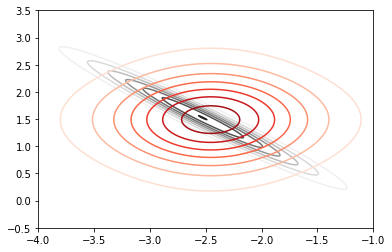

In [34]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, inc_klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi-inclusive.pdf')

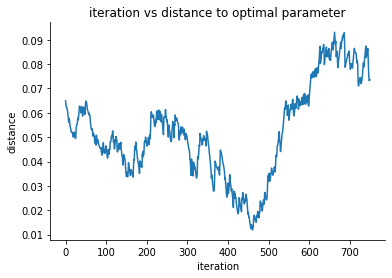

In [33]:
plot_dist_to_opt_param(inc_klvi_param_history, inc_klvi_var_param)